## Imports

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import random_split
from sklearn.model_selection import KFold

import time

## Get Background Data for Pre-Trained Hand-Made Models

In [2]:
#import images from local storage
file_path = "./Data/pngs/"
#size to crop
resize_size = 140
#size of batches
batch_size = 100
#transforms for data
transform = transforms.Compose([transforms.Grayscale(),transforms.Resize((resize_size,resize_size)),transforms.ToTensor()])

#old transform
#transform = transforms.Compose([transforms.Grayscale(),transforms.Resize(255),transforms.CenterCrop(crop_size),transforms.ToTensor()])

#BACKGROUND DATA
data_dir = file_path+"background/"
back_dat = datasets.ImageFolder(data_dir, transform=transform)
back_dataloader = torch.utils.data.DataLoader(back_dat, batch_size=batch_size, shuffle = True,num_workers = 4,persistent_workers=True, pin_memory=True)

In [ ]:
#Preload background data into ram to avoid dataloader bottleneck
background_data = []
for data in enumerate(back_dataloader):
    background_data.append(data)

In [3]:
is_cuda = torch.cuda.is_available()
if is_cuda: device = torch.device("cuda")
else: device = torch.device("cpu")

## Feedforward and Convolution Net Definitions

In [4]:
class FeedForward(nn.Module):
    
    def __init__(self,in_dim,hid_dim,out_dim):
        super().__init__()
        
        self.L1 = nn.Linear(in_dim,hid_dim)
        #self.activ = nn.Sigmoid()
        self.L2 = nn.Linear(hid_dim,out_dim)
    
    def forward(self,X):
        out = self.L1(X)
        out = torch.sigmoid(out)
        out = self.L2(out)
        return out

In [5]:
#Influenced by LeNet architecture:
#https://www.pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
#https://medium.datadriveninvestor.com/architecture-implementation-of-lenet-from-scratch-in-pytorch-709cc38c00a9
class Convolutional(nn.Module):
    
    def __init__(self,channel_num,class_num):
        super().__init__()
        #only need one ReLU and one MaxPool
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv1 = nn.Conv2d(channel_num,6,kernel_size=5)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        self.conv3 = nn.Conv2d(16,20,kernel_size=5)
        self.conv4 = nn.Conv2d(20,50,kernel_size=5)
        self.conv5 = nn.Conv2d(50,120,kernel_size=5)

        self.L1 = nn.Linear(120,84)
        self.L2 = nn.Linear(84,class_num)
    
    def forward(self,X):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.maxpool(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.maxpool(X)
        
        X = self.conv3(X)
        X = self.relu(X)
        X = self.maxpool(X)
        
        X = self.conv4(X)
        X = self.relu(X)
        X = self.maxpool(X)
        X = self.conv5(X)
        X = self.relu(X)
        
        X = torch.flatten(X,1)
        
        X = self.L1(X)
        X = self.relu(X)
        X = self.L2(X)
        
        return X

## Instantiate and Train Feedforward and Convolutional Nets

In [7]:
#Convolutional model
conv_net = Convolutional(1,2)
#Feedforward model
ff_net = FeedForward(resize_size*resize_size,10,2)

In [8]:
#feedforward
loss = nn.CrossEntropyLoss() #loss for categorization
eta = 1e-3 #learning rate
optimizer = torch.optim.Adam(ff_net.parameters(), lr = eta)

num_epochs = 5000
for epoch in range(num_epochs):
    loss_calc = 0#keep a rAunning calculation of the loss
    count = 0 # keep a running count of the number correct for the average
    
    for i, (images, labels) in background_data:
        images = images.view(-1,resize_size*resize_size).requires_grad_()
        
        optimizer.zero_grad()
        
        predictions = ff_net(images)
        
        train_loss = loss(predictions,labels)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss_calc += train_loss.item()
        count += (labels == torch.argmax(predictions,axis=1)).sum()
                
    loss_calc = loss_calc/len(back_dataloader)
    count = count/len(back_dat)
    
    print(f"epoch : {epoch + 1}/{num_epochs}, loss = {loss_calc}, accuracy = {count}")

epoch : 1/5000, loss = 0.7130175739526748, accuracy = 0.4987500011920929
epoch : 2/5000, loss = 0.6933530703186989, accuracy = 0.4932500123977661
epoch : 3/5000, loss = 0.693230165541172, accuracy = 0.4932500123977661
epoch : 4/5000, loss = 0.6926568642258644, accuracy = 0.5055000185966492
epoch : 5/5000, loss = 0.6922773376107216, accuracy = 0.5137500166893005
epoch : 6/5000, loss = 0.692062396556139, accuracy = 0.5099999904632568
epoch : 7/5000, loss = 0.6914825111627578, accuracy = 0.5136250257492065
epoch : 8/5000, loss = 0.6908165782690048, accuracy = 0.5134999752044678
epoch : 9/5000, loss = 0.6896918006241322, accuracy = 0.5141249895095825
epoch : 10/5000, loss = 0.6896746933460236, accuracy = 0.5134999752044678
epoch : 11/5000, loss = 0.6878171615302563, accuracy = 0.5115000009536743
epoch : 12/5000, loss = 0.6874305203557014, accuracy = 0.5121250152587891
epoch : 13/5000, loss = 0.6859278306365013, accuracy = 0.5181249976158142
epoch : 14/5000, loss = 0.6837418846786022, accur

epoch : 113/5000, loss = 0.6707329496741294, accuracy = 0.5453749895095825
epoch : 114/5000, loss = 0.671684542298317, accuracy = 0.5435000061988831
epoch : 115/5000, loss = 0.6701187126338481, accuracy = 0.5479999780654907
epoch : 116/5000, loss = 0.6718807898461818, accuracy = 0.5429999828338623
epoch : 117/5000, loss = 0.6715849675238132, accuracy = 0.5393750071525574
epoch : 118/5000, loss = 0.6707543842494488, accuracy = 0.5417500138282776
epoch : 119/5000, loss = 0.6706915095448494, accuracy = 0.5414999723434448
epoch : 120/5000, loss = 0.6703417897224426, accuracy = 0.5429999828338623
epoch : 121/5000, loss = 0.6701550267636776, accuracy = 0.5451250076293945
epoch : 122/5000, loss = 0.6718354254961014, accuracy = 0.5452499985694885
epoch : 123/5000, loss = 0.670912666618824, accuracy = 0.5460000038146973
epoch : 124/5000, loss = 0.6695841319859028, accuracy = 0.5453749895095825
epoch : 125/5000, loss = 0.670726066827774, accuracy = 0.5462499856948853
epoch : 126/5000, loss = 0.6

epoch : 223/5000, loss = 0.6674288265407086, accuracy = 0.5485000014305115
epoch : 224/5000, loss = 0.6652937032282352, accuracy = 0.550125002861023
epoch : 225/5000, loss = 0.6645783342421054, accuracy = 0.5503749847412109
epoch : 226/5000, loss = 0.6620050333440304, accuracy = 0.5528749823570251
epoch : 227/5000, loss = 0.659301033616066, accuracy = 0.5556250214576721
epoch : 228/5000, loss = 0.6587486267089844, accuracy = 0.5556250214576721
epoch : 229/5000, loss = 0.6576035745441914, accuracy = 0.5569999814033508
epoch : 230/5000, loss = 0.6591815374791622, accuracy = 0.5567499995231628
epoch : 231/5000, loss = 0.6603004328906537, accuracy = 0.5546249747276306
epoch : 232/5000, loss = 0.657191401720047, accuracy = 0.5583750009536743
epoch : 233/5000, loss = 0.6586147673428059, accuracy = 0.5561249852180481
epoch : 234/5000, loss = 0.6567807167768478, accuracy = 0.5578749775886536
epoch : 235/5000, loss = 0.6579305283725262, accuracy = 0.5551249980926514
epoch : 236/5000, loss = 0.6

epoch : 333/5000, loss = 0.6607533857226372, accuracy = 0.5528749823570251
epoch : 334/5000, loss = 0.6593660712242126, accuracy = 0.5541250109672546
epoch : 335/5000, loss = 0.6587871231138707, accuracy = 0.5546249747276306
epoch : 336/5000, loss = 0.6583569437265396, accuracy = 0.5550000071525574
epoch : 337/5000, loss = 0.6585153542459011, accuracy = 0.5551249980926514
epoch : 338/5000, loss = 0.6611717864871025, accuracy = 0.5507500171661377
epoch : 339/5000, loss = 0.6588170751929283, accuracy = 0.5543749928474426
epoch : 340/5000, loss = 0.6619675546884537, accuracy = 0.5518749952316284
epoch : 341/5000, loss = 0.6599286213517189, accuracy = 0.5529999732971191
epoch : 342/5000, loss = 0.659048306196928, accuracy = 0.5538750290870667
epoch : 343/5000, loss = 0.6606184877455235, accuracy = 0.5518749952316284
epoch : 344/5000, loss = 0.6592901080846787, accuracy = 0.5536249876022339
epoch : 345/5000, loss = 0.6582030981779099, accuracy = 0.5557500123977661
epoch : 346/5000, loss = 0

epoch : 443/5000, loss = 0.6533812873065472, accuracy = 0.5613750219345093
epoch : 444/5000, loss = 0.6555704288184643, accuracy = 0.5575000047683716
epoch : 445/5000, loss = 0.6507599733769893, accuracy = 0.5632500052452087
epoch : 446/5000, loss = 0.6513264149427413, accuracy = 0.5632500052452087
epoch : 447/5000, loss = 0.6506172440946102, accuracy = 0.562749981880188
epoch : 448/5000, loss = 0.6507066942751407, accuracy = 0.5637500286102295
epoch : 449/5000, loss = 0.652554701268673, accuracy = 0.5611249804496765
epoch : 450/5000, loss = 0.6631766527891159, accuracy = 0.5463749766349792
epoch : 451/5000, loss = 0.6651754550635814, accuracy = 0.5429999828338623
epoch : 452/5000, loss = 0.6583527497947216, accuracy = 0.5543749928474426
epoch : 453/5000, loss = 0.6531886726617813, accuracy = 0.5600000023841858
epoch : 454/5000, loss = 0.6503063514828682, accuracy = 0.5641250014305115
epoch : 455/5000, loss = 0.6510105460882187, accuracy = 0.562624990940094
epoch : 456/5000, loss = 0.6

epoch : 553/5000, loss = 0.6480647601187229, accuracy = 0.5663750171661377
epoch : 554/5000, loss = 0.6460514970123767, accuracy = 0.5688750147819519
epoch : 555/5000, loss = 0.6453981541097165, accuracy = 0.5695000290870667
epoch : 556/5000, loss = 0.6551242806017399, accuracy = 0.5569999814033508
epoch : 557/5000, loss = 0.6460553035140038, accuracy = 0.5686249732971191
epoch : 558/5000, loss = 0.6464691080152989, accuracy = 0.5691249966621399
epoch : 559/5000, loss = 0.6538327366113663, accuracy = 0.5587499737739563
epoch : 560/5000, loss = 0.6466402687132359, accuracy = 0.5686249732971191
epoch : 561/5000, loss = 0.6460249684751034, accuracy = 0.5697500109672546
epoch : 562/5000, loss = 0.6455516502261162, accuracy = 0.5692499876022339
epoch : 563/5000, loss = 0.6468661531805993, accuracy = 0.5682500004768372
epoch : 564/5000, loss = 0.64598099142313, accuracy = 0.5691249966621399
epoch : 565/5000, loss = 0.6511529132723808, accuracy = 0.5631250143051147
epoch : 566/5000, loss = 0.

epoch : 663/5000, loss = 0.6469623558223248, accuracy = 0.5666249990463257
epoch : 664/5000, loss = 0.6432504035532475, accuracy = 0.5727499723434448
epoch : 665/5000, loss = 0.6427594274282455, accuracy = 0.5731250047683716
epoch : 666/5000, loss = 0.6411784730851651, accuracy = 0.5742499828338623
epoch : 667/5000, loss = 0.6429785408079625, accuracy = 0.5730000138282776
epoch : 668/5000, loss = 0.6430884584784508, accuracy = 0.5726249814033508
epoch : 669/5000, loss = 0.6493924468755722, accuracy = 0.5647500157356262
epoch : 670/5000, loss = 0.6427994497120381, accuracy = 0.5734999775886536
epoch : 671/5000, loss = 0.6437960401177406, accuracy = 0.5720000267028809
epoch : 672/5000, loss = 0.6406436398625374, accuracy = 0.5753750205039978
epoch : 673/5000, loss = 0.6471956126391888, accuracy = 0.5674999952316284
epoch : 674/5000, loss = 0.6415467299520969, accuracy = 0.5746250152587891
epoch : 675/5000, loss = 0.6419593758881093, accuracy = 0.5757499933242798
epoch : 676/5000, loss = 

epoch : 773/5000, loss = 0.6385217443108558, accuracy = 0.578125
epoch : 774/5000, loss = 0.6400204218924046, accuracy = 0.5774999856948853
epoch : 775/5000, loss = 0.6418029151856899, accuracy = 0.5747500061988831
epoch : 776/5000, loss = 0.6380940362811088, accuracy = 0.578374981880188
epoch : 777/5000, loss = 0.6382868275046348, accuracy = 0.578374981880188
epoch : 778/5000, loss = 0.6372083328664303, accuracy = 0.5796250104904175
epoch : 779/5000, loss = 0.6396722190082074, accuracy = 0.5774999856948853
epoch : 780/5000, loss = 0.6410067237913608, accuracy = 0.5759999752044678
epoch : 781/5000, loss = 0.6381361432373523, accuracy = 0.5789999961853027
epoch : 782/5000, loss = 0.6375294998288155, accuracy = 0.5798749923706055
epoch : 783/5000, loss = 0.638982304930687, accuracy = 0.5774999856948853
epoch : 784/5000, loss = 0.6393054373562336, accuracy = 0.577750027179718
epoch : 785/5000, loss = 0.6405070155858994, accuracy = 0.5762500166893005
epoch : 786/5000, loss = 0.637434060871

epoch : 883/5000, loss = 0.6379735402762889, accuracy = 0.5786250233650208
epoch : 884/5000, loss = 0.6350111171603203, accuracy = 0.5818750262260437
epoch : 885/5000, loss = 0.635240938514471, accuracy = 0.5821250081062317
epoch : 886/5000, loss = 0.6374609470367432, accuracy = 0.5787500143051147
epoch : 887/5000, loss = 0.6340481638908386, accuracy = 0.5828750133514404
epoch : 888/5000, loss = 0.6341533847153187, accuracy = 0.5831249952316284
epoch : 889/5000, loss = 0.6367628820240497, accuracy = 0.5797500014305115
epoch : 890/5000, loss = 0.6402638211846352, accuracy = 0.5759999752044678
epoch : 891/5000, loss = 0.6340849429368973, accuracy = 0.5826249718666077
epoch : 892/5000, loss = 0.6337476082146167, accuracy = 0.5838750004768372
epoch : 893/5000, loss = 0.6371066763997077, accuracy = 0.5796250104904175
epoch : 894/5000, loss = 0.6417082279920578, accuracy = 0.5736250281333923
epoch : 895/5000, loss = 0.636036229878664, accuracy = 0.5814999938011169
epoch : 896/5000, loss = 0.

epoch : 993/5000, loss = 0.6367837592959404, accuracy = 0.5791249871253967
epoch : 994/5000, loss = 0.6409439302980899, accuracy = 0.5745000243186951
epoch : 995/5000, loss = 0.6321768134832382, accuracy = 0.5858749747276306
epoch : 996/5000, loss = 0.6312121830880641, accuracy = 0.5867499709129333
epoch : 997/5000, loss = 0.6313841864466667, accuracy = 0.5863749980926514
epoch : 998/5000, loss = 0.639954148977995, accuracy = 0.5758749842643738
epoch : 999/5000, loss = 0.6412709288299083, accuracy = 0.5746250152587891
epoch : 1000/5000, loss = 0.6362349018454552, accuracy = 0.5808749794960022
epoch : 1001/5000, loss = 0.6309402182698249, accuracy = 0.5863749980926514
epoch : 1002/5000, loss = 0.6480612047016621, accuracy = 0.5658749938011169
epoch : 1003/5000, loss = 0.6343897469341755, accuracy = 0.5838750004768372
epoch : 1004/5000, loss = 0.6308862626552582, accuracy = 0.5868750214576721
epoch : 1005/5000, loss = 0.6404516443610191, accuracy = 0.574999988079071
epoch : 1006/5000, lo

epoch : 1102/5000, loss = 0.6329882711172103, accuracy = 0.5841249823570251
epoch : 1103/5000, loss = 0.6329679451882839, accuracy = 0.5838750004768372
epoch : 1104/5000, loss = 0.6363643676042556, accuracy = 0.5817499756813049
epoch : 1105/5000, loss = 0.6300501897931099, accuracy = 0.5874999761581421
epoch : 1106/5000, loss = 0.6309247627854347, accuracy = 0.5866249799728394
epoch : 1107/5000, loss = 0.6316736526787281, accuracy = 0.5867499709129333
epoch : 1108/5000, loss = 0.6314951106905937, accuracy = 0.5861250162124634
epoch : 1109/5000, loss = 0.6362979330122471, accuracy = 0.5805000066757202
epoch : 1110/5000, loss = 0.6358949065208435, accuracy = 0.5818750262260437
epoch : 1111/5000, loss = 0.6363364212214947, accuracy = 0.5806249976158142
epoch : 1112/5000, loss = 0.6322198159992695, accuracy = 0.5853750109672546
epoch : 1113/5000, loss = 0.6327515125274659, accuracy = 0.5843750238418579
epoch : 1114/5000, loss = 0.6355940610170364, accuracy = 0.5809999704360962
epoch : 1115

epoch : 1211/5000, loss = 0.6283923871815205, accuracy = 0.5896250009536743
epoch : 1212/5000, loss = 0.6309472337365151, accuracy = 0.5861250162124634
epoch : 1213/5000, loss = 0.6285025499761104, accuracy = 0.5899999737739563
epoch : 1214/5000, loss = 0.627375990152359, accuracy = 0.590749979019165
epoch : 1215/5000, loss = 0.6308153159916401, accuracy = 0.5861250162124634
epoch : 1216/5000, loss = 0.6327951289713383, accuracy = 0.5856249928474426
epoch : 1217/5000, loss = 0.646776656806469, accuracy = 0.5690000057220459
epoch : 1218/5000, loss = 0.636338572204113, accuracy = 0.5808749794960022
epoch : 1219/5000, loss = 0.6334283195436001, accuracy = 0.5838750004768372
epoch : 1220/5000, loss = 0.6291854761540889, accuracy = 0.5891249775886536
epoch : 1221/5000, loss = 0.6294344015419483, accuracy = 0.5888749957084656
epoch : 1222/5000, loss = 0.6277927324175835, accuracy = 0.590624988079071
epoch : 1223/5000, loss = 0.6278471432626247, accuracy = 0.590624988079071
epoch : 1224/5000,

epoch : 1320/5000, loss = 0.6248550973832607, accuracy = 0.593500018119812
epoch : 1321/5000, loss = 0.6239728577435016, accuracy = 0.5943750143051147
epoch : 1322/5000, loss = 0.6244735419750214, accuracy = 0.59375
epoch : 1323/5000, loss = 0.6267656184732914, accuracy = 0.590749979019165
epoch : 1324/5000, loss = 0.6764263704419136, accuracy = 0.5270000100135803
epoch : 1325/5000, loss = 0.6805971890687943, accuracy = 0.5112500190734863
epoch : 1326/5000, loss = 0.6830821737647057, accuracy = 0.518625020980835
epoch : 1327/5000, loss = 0.6791527792811394, accuracy = 0.5223749876022339
epoch : 1328/5000, loss = 0.6751583456993103, accuracy = 0.5277500152587891
epoch : 1329/5000, loss = 0.6341817170381546, accuracy = 0.5831249952316284
epoch : 1330/5000, loss = 0.6266246065497398, accuracy = 0.5920000076293945
epoch : 1331/5000, loss = 0.6252304293215275, accuracy = 0.5932499766349792
epoch : 1332/5000, loss = 0.6245091758668423, accuracy = 0.59375
epoch : 1333/5000, loss = 0.623994515

epoch : 1429/5000, loss = 0.6192348942160606, accuracy = 0.6007500290870667
epoch : 1430/5000, loss = 0.6272412449121475, accuracy = 0.5913749933242798
epoch : 1431/5000, loss = 0.6333071194589138, accuracy = 0.5847499966621399
epoch : 1432/5000, loss = 0.6737786710262299, accuracy = 0.5306249856948853
epoch : 1433/5000, loss = 0.6303103640675545, accuracy = 0.5881249904632568
epoch : 1434/5000, loss = 0.6175503477454185, accuracy = 0.6032500267028809
epoch : 1435/5000, loss = 0.6586055383086205, accuracy = 0.550000011920929
epoch : 1436/5000, loss = 0.6678980469703675, accuracy = 0.5386250019073486
epoch : 1437/5000, loss = 0.6213073164224625, accuracy = 0.5982499718666077
epoch : 1438/5000, loss = 0.6268669575452804, accuracy = 0.5918750166893005
epoch : 1439/5000, loss = 0.6192222259938717, accuracy = 0.6013749837875366
epoch : 1440/5000, loss = 0.6586285471916199, accuracy = 0.550125002861023
epoch : 1441/5000, loss = 0.6634968616068363, accuracy = 0.5456249713897705
epoch : 1442/5

epoch : 1538/5000, loss = 0.6179342418909073, accuracy = 0.6022499799728394
epoch : 1539/5000, loss = 0.6213107101619244, accuracy = 0.5987499952316284
epoch : 1540/5000, loss = 0.6172434821724891, accuracy = 0.6033750176429749
epoch : 1541/5000, loss = 0.6175033114850521, accuracy = 0.6031249761581421
epoch : 1542/5000, loss = 0.6220904037356376, accuracy = 0.5982499718666077
epoch : 1543/5000, loss = 0.6166528634727001, accuracy = 0.6037499904632568
epoch : 1544/5000, loss = 0.6192808076739311, accuracy = 0.6016250252723694
epoch : 1545/5000, loss = 0.6209184870123863, accuracy = 0.5988749861717224
epoch : 1546/5000, loss = 0.622467751801014, accuracy = 0.5978749990463257
epoch : 1547/5000, loss = 0.6183931268751621, accuracy = 0.6021249890327454
epoch : 1548/5000, loss = 0.6279909424483776, accuracy = 0.5918750166893005
epoch : 1549/5000, loss = 0.6175931736826896, accuracy = 0.6041250228881836
epoch : 1550/5000, loss = 0.6190634600818157, accuracy = 0.6016250252723694
epoch : 1551/

epoch : 1647/5000, loss = 0.6122264385223388, accuracy = 0.6100000143051147
epoch : 1648/5000, loss = 0.6114227771759033, accuracy = 0.6106250286102295
epoch : 1649/5000, loss = 0.658485011011362, accuracy = 0.5504999756813049
epoch : 1650/5000, loss = 0.677070639282465, accuracy = 0.5199999809265137
epoch : 1651/5000, loss = 0.6340695150196552, accuracy = 0.5832499861717224
epoch : 1652/5000, loss = 0.634089856594801, accuracy = 0.5843750238418579
epoch : 1653/5000, loss = 0.6139357909560204, accuracy = 0.6076250076293945
epoch : 1654/5000, loss = 0.6128341510891915, accuracy = 0.6087499856948853
epoch : 1655/5000, loss = 0.6131915494799614, accuracy = 0.6082500219345093
epoch : 1656/5000, loss = 0.6144925430417061, accuracy = 0.6072499752044678
epoch : 1657/5000, loss = 0.632788798213005, accuracy = 0.5853750109672546
epoch : 1658/5000, loss = 0.6142581351101398, accuracy = 0.6069999933242798
epoch : 1659/5000, loss = 0.6141943603754043, accuracy = 0.6076250076293945
epoch : 1660/500

epoch : 1756/5000, loss = 0.6159416936337948, accuracy = 0.6053749918937683
epoch : 1757/5000, loss = 0.6095947392284871, accuracy = 0.6128749847412109
epoch : 1758/5000, loss = 0.6075960710644722, accuracy = 0.6150000095367432
epoch : 1759/5000, loss = 0.6106105074286461, accuracy = 0.6115000247955322
epoch : 1760/5000, loss = 0.6123277641832828, accuracy = 0.6101250052452087
epoch : 1761/5000, loss = 0.6101915769279003, accuracy = 0.6117500066757202
epoch : 1762/5000, loss = 0.6074205115437508, accuracy = 0.6150000095367432
epoch : 1763/5000, loss = 0.6072639219462872, accuracy = 0.6148750185966492
epoch : 1764/5000, loss = 0.6075554244220257, accuracy = 0.6151250004768372
epoch : 1765/5000, loss = 0.6364269003272056, accuracy = 0.5797500014305115
epoch : 1766/5000, loss = 0.6244336202740669, accuracy = 0.5963749885559082
epoch : 1767/5000, loss = 0.6084919579327106, accuracy = 0.6136249899864197
epoch : 1768/5000, loss = 0.6083907023072243, accuracy = 0.6137499809265137
epoch : 1769

epoch : 1865/5000, loss = 0.6077487871050835, accuracy = 0.6147500276565552
epoch : 1866/5000, loss = 0.6130634099245071, accuracy = 0.609250009059906
epoch : 1867/5000, loss = 0.6187326282262802, accuracy = 0.6028749942779541
epoch : 1868/5000, loss = 0.6665899828076363, accuracy = 0.5407500267028809
epoch : 1869/5000, loss = 0.6148896493017674, accuracy = 0.6075000166893005
epoch : 1870/5000, loss = 0.6086965292692185, accuracy = 0.6141250133514404
epoch : 1871/5000, loss = 0.6099227905273438, accuracy = 0.612375020980835
epoch : 1872/5000, loss = 0.6071834586560726, accuracy = 0.6157500147819519
epoch : 1873/5000, loss = 0.6092826545238494, accuracy = 0.6137499809265137
epoch : 1874/5000, loss = 0.6061788156628609, accuracy = 0.6163750290870667
epoch : 1875/5000, loss = 0.6050272949039937, accuracy = 0.6183750033378601
epoch : 1876/5000, loss = 0.6091380782425404, accuracy = 0.6140000224113464
epoch : 1877/5000, loss = 0.6065362960100174, accuracy = 0.6163750290870667
epoch : 1878/5

epoch : 1974/5000, loss = 0.6031645618379116, accuracy = 0.6203749775886536
epoch : 1975/5000, loss = 0.6038286961615086, accuracy = 0.6201249957084656
epoch : 1976/5000, loss = 0.6059448622167111, accuracy = 0.6173750162124634
epoch : 1977/5000, loss = 0.609021895378828, accuracy = 0.6140000224113464
epoch : 1978/5000, loss = 0.6095713630318642, accuracy = 0.6128749847412109
epoch : 1979/5000, loss = 0.6034389577805996, accuracy = 0.6197500228881836
epoch : 1980/5000, loss = 0.6072639361023903, accuracy = 0.6162499785423279
epoch : 1981/5000, loss = 0.6069971188902855, accuracy = 0.6154999732971191
epoch : 1982/5000, loss = 0.6083381123840809, accuracy = 0.6143749952316284
epoch : 1983/5000, loss = 0.6073612116277218, accuracy = 0.6158750057220459
epoch : 1984/5000, loss = 0.6071341305971145, accuracy = 0.6153749823570251
epoch : 1985/5000, loss = 0.6169233076274395, accuracy = 0.6053749918937683
epoch : 1986/5000, loss = 0.6050985999405384, accuracy = 0.6182500123977661
epoch : 1987/

epoch : 2082/5000, loss = 0.6032802246510982, accuracy = 0.6206250190734863
epoch : 2083/5000, loss = 0.5989474020898342, accuracy = 0.6259999871253967
epoch : 2084/5000, loss = 0.5974642902612686, accuracy = 0.6268749833106995
epoch : 2085/5000, loss = 0.602525083720684, accuracy = 0.6212499737739563
epoch : 2086/5000, loss = 0.6071652233600616, accuracy = 0.6169999837875366
epoch : 2087/5000, loss = 0.6001572631299495, accuracy = 0.6243749856948853
epoch : 2088/5000, loss = 0.6033365115523338, accuracy = 0.6205000281333923
epoch : 2089/5000, loss = 0.5976586833596229, accuracy = 0.6267499923706055
epoch : 2090/5000, loss = 0.5984963536262512, accuracy = 0.6258749961853027
epoch : 2091/5000, loss = 0.5979550279676914, accuracy = 0.6263750195503235
epoch : 2092/5000, loss = 0.5974472172558307, accuracy = 0.6269999742507935
epoch : 2093/5000, loss = 0.5972788259387016, accuracy = 0.6272500157356262
epoch : 2094/5000, loss = 0.5963324502110481, accuracy = 0.628250002861023
epoch : 2095/5

epoch : 2191/5000, loss = 0.5936567939817905, accuracy = 0.6316249966621399
epoch : 2192/5000, loss = 0.5987973667681217, accuracy = 0.6274999976158142
epoch : 2193/5000, loss = 0.6000899627804757, accuracy = 0.6232500076293945
epoch : 2194/5000, loss = 0.6527182459831238, accuracy = 0.5598750114440918
epoch : 2195/5000, loss = 0.6052083298563957, accuracy = 0.6190000176429749
epoch : 2196/5000, loss = 0.5956309959292412, accuracy = 0.6298750042915344
epoch : 2197/5000, loss = 0.5946830488741398, accuracy = 0.6305000185966492
epoch : 2198/5000, loss = 0.5960605792701245, accuracy = 0.6297500133514404
epoch : 2199/5000, loss = 0.5942389950156212, accuracy = 0.6308749914169312
epoch : 2200/5000, loss = 0.5933722473680973, accuracy = 0.6312500238418579
epoch : 2201/5000, loss = 0.5950568750500679, accuracy = 0.6305000185966492
epoch : 2202/5000, loss = 0.5947855532169342, accuracy = 0.6307500004768372
epoch : 2203/5000, loss = 0.5934902586042881, accuracy = 0.6318749785423279
epoch : 2204

epoch : 2300/5000, loss = 0.5955900114029646, accuracy = 0.6299999952316284
epoch : 2301/5000, loss = 0.614272165298462, accuracy = 0.609250009059906
epoch : 2302/5000, loss = 0.6176066730171442, accuracy = 0.6033750176429749
epoch : 2303/5000, loss = 0.595011168345809, accuracy = 0.6306250095367432
epoch : 2304/5000, loss = 0.5955763354897499, accuracy = 0.6296250224113464
epoch : 2305/5000, loss = 0.6050222776830196, accuracy = 0.6198750138282776
epoch : 2306/5000, loss = 0.5942312121391297, accuracy = 0.6311249732971191
epoch : 2307/5000, loss = 0.6029904421418906, accuracy = 0.6225000023841858
epoch : 2308/5000, loss = 0.592619926482439, accuracy = 0.6333749890327454
epoch : 2309/5000, loss = 0.5958477236330509, accuracy = 0.6301249861717224
epoch : 2310/5000, loss = 0.6585713304579258, accuracy = 0.5511249899864197
epoch : 2311/5000, loss = 0.6767950356006622, accuracy = 0.5237500071525574
epoch : 2312/5000, loss = 0.676632285863161, accuracy = 0.5239999890327454
epoch : 2313/5000

epoch : 2409/5000, loss = 0.6118147760629654, accuracy = 0.612375020980835
epoch : 2410/5000, loss = 0.6134277008473873, accuracy = 0.6081249713897705
epoch : 2411/5000, loss = 0.6147243227809668, accuracy = 0.6075000166893005
epoch : 2412/5000, loss = 0.6137413576245307, accuracy = 0.609125018119812
epoch : 2413/5000, loss = 0.5944672998040914, accuracy = 0.6321250200271606
epoch : 2414/5000, loss = 0.6013289898633957, accuracy = 0.625
epoch : 2415/5000, loss = 0.6012572951614856, accuracy = 0.6257500052452087
epoch : 2416/5000, loss = 0.5995618809014559, accuracy = 0.6274999976158142
epoch : 2417/5000, loss = 0.6008234646171331, accuracy = 0.6230000257492065
epoch : 2418/5000, loss = 0.6113184802234173, accuracy = 0.6110000014305115
epoch : 2419/5000, loss = 0.6047301191836596, accuracy = 0.6202499866485596
epoch : 2420/5000, loss = 0.5971511244773865, accuracy = 0.6291249990463257
epoch : 2421/5000, loss = 0.6005128126591444, accuracy = 0.6240000128746033
epoch : 2422/5000, loss = 0

epoch : 2518/5000, loss = 0.6017930492758751, accuracy = 0.624625027179718
epoch : 2519/5000, loss = 0.5984985716640949, accuracy = 0.6276249885559082
epoch : 2520/5000, loss = 0.5941257655620575, accuracy = 0.6318749785423279
epoch : 2521/5000, loss = 0.6042573753744364, accuracy = 0.6212499737739563
epoch : 2522/5000, loss = 0.595959148183465, accuracy = 0.6290000081062317
epoch : 2523/5000, loss = 0.6152969043701887, accuracy = 0.6068750023841858
epoch : 2524/5000, loss = 0.6062526572495699, accuracy = 0.6188750267028809
epoch : 2525/5000, loss = 0.6053888097405433, accuracy = 0.6187499761581421
epoch : 2526/5000, loss = 0.6291886392980814, accuracy = 0.593625009059906
epoch : 2527/5000, loss = 0.6247190944850445, accuracy = 0.6000000238418579
epoch : 2528/5000, loss = 0.615744898468256, accuracy = 0.606374979019165
epoch : 2529/5000, loss = 0.6156865444034338, accuracy = 0.6071249842643738
epoch : 2530/5000, loss = 0.615507097914815, accuracy = 0.6072499752044678
epoch : 2531/5000,

epoch : 2627/5000, loss = 0.5912594255059958, accuracy = 0.6362500190734863
epoch : 2628/5000, loss = 0.6095641512423754, accuracy = 0.6165000200271606
epoch : 2629/5000, loss = 0.6164245299994946, accuracy = 0.6073750257492065
epoch : 2630/5000, loss = 0.6066608060151338, accuracy = 0.6183750033378601
epoch : 2631/5000, loss = 0.5890298839658499, accuracy = 0.6392499804496765
epoch : 2632/5000, loss = 0.5950157575309276, accuracy = 0.6292499899864197
epoch : 2633/5000, loss = 0.5914742857217788, accuracy = 0.6372500061988831
epoch : 2634/5000, loss = 0.6020541559904814, accuracy = 0.6257500052452087
epoch : 2635/5000, loss = 0.6211095072329045, accuracy = 0.6018750071525574
epoch : 2636/5000, loss = 0.6011415287852288, accuracy = 0.6257500052452087
epoch : 2637/5000, loss = 0.6168694458901882, accuracy = 0.609375
epoch : 2638/5000, loss = 0.6117724545300007, accuracy = 0.6121249794960022
epoch : 2639/5000, loss = 0.5940832670778036, accuracy = 0.6336249709129333
epoch : 2640/5000, los

epoch : 2736/5000, loss = 0.5996736533939838, accuracy = 0.6268749833106995
epoch : 2737/5000, loss = 0.5833519492298365, accuracy = 0.6447499990463257
epoch : 2738/5000, loss = 0.5966861102730036, accuracy = 0.6294999718666077
epoch : 2739/5000, loss = 0.5907560467720032, accuracy = 0.6361250281333923
epoch : 2740/5000, loss = 0.595402006432414, accuracy = 0.6311249732971191
epoch : 2741/5000, loss = 0.591609300300479, accuracy = 0.6356250047683716
epoch : 2742/5000, loss = 0.5867549613118171, accuracy = 0.640625
epoch : 2743/5000, loss = 0.5938262648880481, accuracy = 0.6326249837875366
epoch : 2744/5000, loss = 0.584292559698224, accuracy = 0.6443750262260437
epoch : 2745/5000, loss = 0.5871110774576664, accuracy = 0.6401249766349792
epoch : 2746/5000, loss = 0.5859671823680401, accuracy = 0.6411250233650208
epoch : 2747/5000, loss = 0.5980495817959308, accuracy = 0.6273750066757202
epoch : 2748/5000, loss = 0.6027745548635721, accuracy = 0.6212499737739563
epoch : 2749/5000, loss =

epoch : 2845/5000, loss = 0.6769020490348339, accuracy = 0.5236250162124634
epoch : 2846/5000, loss = 0.6767611004412174, accuracy = 0.5238749980926514
epoch : 2847/5000, loss = 0.6764801919460297, accuracy = 0.5245000123977661
epoch : 2848/5000, loss = 0.6692616641521454, accuracy = 0.5363749861717224
epoch : 2849/5000, loss = 0.6068121254444122, accuracy = 0.6187499761581421
epoch : 2850/5000, loss = 0.577420262619853, accuracy = 0.6513749957084656
epoch : 2851/5000, loss = 0.6041501846164465, accuracy = 0.6205000281333923
epoch : 2852/5000, loss = 0.6572131730616093, accuracy = 0.5536249876022339
epoch : 2853/5000, loss = 0.5843787416815758, accuracy = 0.6462500095367432
epoch : 2854/5000, loss = 0.5750845145434141, accuracy = 0.6535000205039978
epoch : 2855/5000, loss = 0.58286217674613, accuracy = 0.6455000042915344
epoch : 2856/5000, loss = 0.590352126955986, accuracy = 0.6358749866485596
epoch : 2857/5000, loss = 0.5787967383861542, accuracy = 0.6502500176429749
epoch : 2858/500

epoch : 2954/5000, loss = 0.6101134635508061, accuracy = 0.6140000224113464
epoch : 2955/5000, loss = 0.5734464470297098, accuracy = 0.6554999947547913
epoch : 2956/5000, loss = 0.585396259278059, accuracy = 0.6420000195503235
epoch : 2957/5000, loss = 0.5885134756565094, accuracy = 0.6392499804496765
epoch : 2958/5000, loss = 0.5910232625901699, accuracy = 0.637374997138977
epoch : 2959/5000, loss = 0.5972972493618727, accuracy = 0.628000020980835
epoch : 2960/5000, loss = 0.6298879437148571, accuracy = 0.5929999947547913
epoch : 2961/5000, loss = 0.5891985397785902, accuracy = 0.6388750076293945
epoch : 2962/5000, loss = 0.5805043995380401, accuracy = 0.6478750109672546
epoch : 2963/5000, loss = 0.5866540547460317, accuracy = 0.640749990940094
epoch : 2964/5000, loss = 0.580787704512477, accuracy = 0.6457499861717224
epoch : 2965/5000, loss = 0.571247748658061, accuracy = 0.6588749885559082
epoch : 2966/5000, loss = 0.5786971300840378, accuracy = 0.6506249904632568
epoch : 2967/5000,

epoch : 3063/5000, loss = 0.6290431711822748, accuracy = 0.5899999737739563
epoch : 3064/5000, loss = 0.6199342980980873, accuracy = 0.6047499775886536
epoch : 3065/5000, loss = 0.6009832467883826, accuracy = 0.624750018119812
epoch : 3066/5000, loss = 0.580092366039753, accuracy = 0.6485000252723694
epoch : 3067/5000, loss = 0.5920462228357792, accuracy = 0.6362500190734863
epoch : 3068/5000, loss = 0.590391831099987, accuracy = 0.6368749737739563
epoch : 3069/5000, loss = 0.5981091912835836, accuracy = 0.6288750171661377
epoch : 3070/5000, loss = 0.6567825555801392, accuracy = 0.5536249876022339
epoch : 3071/5000, loss = 0.5915087275207043, accuracy = 0.6347500085830688
epoch : 3072/5000, loss = 0.5787807010114193, accuracy = 0.6506249904632568
epoch : 3073/5000, loss = 0.5977871671319008, accuracy = 0.6284999847412109
epoch : 3074/5000, loss = 0.6589307494461536, accuracy = 0.5503749847412109
epoch : 3075/5000, loss = 0.6067630454897881, accuracy = 0.6191250085830688
epoch : 3076/50

epoch : 3172/5000, loss = 0.5779228907078504, accuracy = 0.6502500176429749
epoch : 3173/5000, loss = 0.6099407706409693, accuracy = 0.6138749718666077
epoch : 3174/5000, loss = 0.5937677200883626, accuracy = 0.6359999775886536
epoch : 3175/5000, loss = 0.6028023209422827, accuracy = 0.6236249804496765
epoch : 3176/5000, loss = 0.6175936687737703, accuracy = 0.6042500138282776
epoch : 3177/5000, loss = 0.6071539342403411, accuracy = 0.6183750033378601
epoch : 3178/5000, loss = 0.626286692917347, accuracy = 0.5946249961853027
epoch : 3179/5000, loss = 0.5983703445643187, accuracy = 0.6276249885559082
epoch : 3180/5000, loss = 0.5895043700933457, accuracy = 0.6397500038146973
epoch : 3181/5000, loss = 0.6130135238170624, accuracy = 0.6119999885559082
epoch : 3182/5000, loss = 0.6015120849013329, accuracy = 0.6244999766349792
epoch : 3183/5000, loss = 0.5851661659777164, accuracy = 0.6428750157356262
epoch : 3184/5000, loss = 0.5784407418221236, accuracy = 0.6496250033378601
epoch : 3185/

epoch : 3281/5000, loss = 0.5844977252185345, accuracy = 0.6431249976158142
epoch : 3282/5000, loss = 0.6029792904853821, accuracy = 0.6227499842643738
epoch : 3283/5000, loss = 0.5949752073734998, accuracy = 0.6331250071525574
epoch : 3284/5000, loss = 0.5841588504612446, accuracy = 0.6445000171661377
epoch : 3285/5000, loss = 0.5988309908658266, accuracy = 0.6287500262260437
epoch : 3286/5000, loss = 0.5803982436656951, accuracy = 0.6491249799728394
epoch : 3287/5000, loss = 0.6028238974511624, accuracy = 0.6231250166893005
epoch : 3288/5000, loss = 0.6130383655428886, accuracy = 0.6122499704360962
epoch : 3289/5000, loss = 0.6225438855588437, accuracy = 0.5982499718666077
epoch : 3290/5000, loss = 0.5723633415997028, accuracy = 0.6597499847412109
epoch : 3291/5000, loss = 0.5847808208316565, accuracy = 0.643625020980835
epoch : 3292/5000, loss = 0.5881917048245668, accuracy = 0.6391249895095825
epoch : 3293/5000, loss = 0.5803080085664988, accuracy = 0.6489999890327454
epoch : 3294/

epoch : 3390/5000, loss = 0.5759090349078179, accuracy = 0.6536250114440918
epoch : 3391/5000, loss = 0.5943596418946981, accuracy = 0.6349999904632568
epoch : 3392/5000, loss = 0.5959441732615233, accuracy = 0.6327499747276306
epoch : 3393/5000, loss = 0.5761352624744177, accuracy = 0.652999997138977
epoch : 3394/5000, loss = 0.5736261438578367, accuracy = 0.6567500233650208
epoch : 3395/5000, loss = 0.5741757482290268, accuracy = 0.656125009059906
epoch : 3396/5000, loss = 0.5728526871651412, accuracy = 0.6572499871253967
epoch : 3397/5000, loss = 0.5751085493713617, accuracy = 0.6547499895095825
epoch : 3398/5000, loss = 0.569597752392292, accuracy = 0.6610000133514404
epoch : 3399/5000, loss = 0.5703928235918283, accuracy = 0.6596249938011169
epoch : 3400/5000, loss = 0.5650605898350477, accuracy = 0.6667500138282776
epoch : 3401/5000, loss = 0.5608836848288774, accuracy = 0.6702499985694885
epoch : 3402/5000, loss = 0.5640661627054214, accuracy = 0.6671249866485596
epoch : 3403/50

epoch : 3499/5000, loss = 0.5767327789217234, accuracy = 0.6522499918937683
epoch : 3500/5000, loss = 0.568973122164607, accuracy = 0.6611250042915344
epoch : 3501/5000, loss = 0.5791617829352618, accuracy = 0.6495000123977661
epoch : 3502/5000, loss = 0.5760797984898091, accuracy = 0.6552500128746033
epoch : 3503/5000, loss = 0.5644444230943918, accuracy = 0.6664999723434448
epoch : 3504/5000, loss = 0.5602742616087198, accuracy = 0.6698750257492065
epoch : 3505/5000, loss = 0.5685872562229634, accuracy = 0.6620000004768372
epoch : 3506/5000, loss = 0.5653661683201789, accuracy = 0.6647499799728394
epoch : 3507/5000, loss = 0.5685388933867216, accuracy = 0.6617500185966492
epoch : 3508/5000, loss = 0.5756350383162498, accuracy = 0.6536250114440918
epoch : 3509/5000, loss = 0.5737773228436709, accuracy = 0.6556249856948853
epoch : 3510/5000, loss = 0.5640665292739868, accuracy = 0.6669999957084656
epoch : 3511/5000, loss = 0.5588957987725734, accuracy = 0.672249972820282
epoch : 3512/5

epoch : 3608/5000, loss = 0.6113671869039535, accuracy = 0.6142500042915344
epoch : 3609/5000, loss = 0.560531223192811, accuracy = 0.6706249713897705
epoch : 3610/5000, loss = 0.5653362076729536, accuracy = 0.6647499799728394
epoch : 3611/5000, loss = 0.5788152419030667, accuracy = 0.6516249775886536
epoch : 3612/5000, loss = 0.5728240359574557, accuracy = 0.659250020980835
epoch : 3613/5000, loss = 0.5857522949576378, accuracy = 0.643625020980835
epoch : 3614/5000, loss = 0.6054286655038595, accuracy = 0.6191250085830688
epoch : 3615/5000, loss = 0.5972977455705404, accuracy = 0.6307500004768372
epoch : 3616/5000, loss = 0.5663575157523155, accuracy = 0.6635000109672546
epoch : 3617/5000, loss = 0.5733328141272068, accuracy = 0.6570000052452087
epoch : 3618/5000, loss = 0.573131263628602, accuracy = 0.6552500128746033
epoch : 3619/5000, loss = 0.5814695924520492, accuracy = 0.6493750214576721
epoch : 3620/5000, loss = 0.5667833473533392, accuracy = 0.6644999980926514
epoch : 3621/500

epoch : 3717/5000, loss = 0.5420242454856634, accuracy = 0.690500020980835
epoch : 3718/5000, loss = 0.5422750033438206, accuracy = 0.6902499794960022
epoch : 3719/5000, loss = 0.5412833414971828, accuracy = 0.6903749704360962
epoch : 3720/5000, loss = 0.5440589148551226, accuracy = 0.6883749961853027
epoch : 3721/5000, loss = 0.5407945912331342, accuracy = 0.6915000081062317
epoch : 3722/5000, loss = 0.5448469080030918, accuracy = 0.687375009059906
epoch : 3723/5000, loss = 0.5485164530575275, accuracy = 0.6848750114440918
epoch : 3724/5000, loss = 0.5456880476325751, accuracy = 0.687250018119812
epoch : 3725/5000, loss = 0.5431797675788402, accuracy = 0.6881250143051147
epoch : 3726/5000, loss = 0.5651842091232538, accuracy = 0.6639999747276306
epoch : 3727/5000, loss = 0.5749813806265592, accuracy = 0.6553750038146973
epoch : 3728/5000, loss = 0.5470823969691991, accuracy = 0.6851249933242798
epoch : 3729/5000, loss = 0.5479525271803141, accuracy = 0.6855000257492065
epoch : 3730/50

epoch : 3826/5000, loss = 0.5337129980325699, accuracy = 0.6987500190734863
epoch : 3827/5000, loss = 0.5358014971017837, accuracy = 0.6968749761581421
epoch : 3828/5000, loss = 0.5549660999327898, accuracy = 0.6758750081062317
epoch : 3829/5000, loss = 0.5375235393643379, accuracy = 0.6945000290870667
epoch : 3830/5000, loss = 0.5397159799933433, accuracy = 0.6928750276565552
epoch : 3831/5000, loss = 0.5590290777385235, accuracy = 0.672124981880188
epoch : 3832/5000, loss = 0.5459942188113928, accuracy = 0.684249997138977
epoch : 3833/5000, loss = 0.5749239638447762, accuracy = 0.6549999713897705
epoch : 3834/5000, loss = 0.6116393756121397, accuracy = 0.6127499938011169
epoch : 3835/5000, loss = 0.6742247104644775, accuracy = 0.5278750061988831
epoch : 3836/5000, loss = 0.6712152451276779, accuracy = 0.5331249833106995
epoch : 3837/5000, loss = 0.5843771174550056, accuracy = 0.6442499756813049
epoch : 3838/5000, loss = 0.5295083098113537, accuracy = 0.702750027179718
epoch : 3839/50

epoch : 3935/5000, loss = 0.524458273127675, accuracy = 0.7088750004768372
epoch : 3936/5000, loss = 0.5433960661292077, accuracy = 0.690750002861023
epoch : 3937/5000, loss = 0.5503130670636892, accuracy = 0.684249997138977
epoch : 3938/5000, loss = 0.5434886891394853, accuracy = 0.6909999847412109
epoch : 3939/5000, loss = 0.6024066999554634, accuracy = 0.625374972820282
epoch : 3940/5000, loss = 0.6605596587061882, accuracy = 0.5493749976158142
epoch : 3941/5000, loss = 0.636916733905673, accuracy = 0.5883749723434448
epoch : 3942/5000, loss = 0.6437108844518662, accuracy = 0.5718749761581421
epoch : 3943/5000, loss = 0.5212820284068584, accuracy = 0.715624988079071
epoch : 3944/5000, loss = 0.5912096999585629, accuracy = 0.640500009059906
epoch : 3945/5000, loss = 0.5721818462014199, accuracy = 0.6602500081062317
epoch : 3946/5000, loss = 0.5911350592970848, accuracy = 0.6397500038146973
epoch : 3947/5000, loss = 0.6209376350045204, accuracy = 0.6056249737739563
epoch : 3948/5000, 

epoch : 4044/5000, loss = 0.5148387718945742, accuracy = 0.7178750038146973
epoch : 4045/5000, loss = 0.5161042541265488, accuracy = 0.7176250219345093
epoch : 4046/5000, loss = 0.5284558471292258, accuracy = 0.706125020980835
epoch : 4047/5000, loss = 0.6072228211909533, accuracy = 0.6208750009536743
epoch : 4048/5000, loss = 0.5202366881072521, accuracy = 0.7131249904632568
epoch : 4049/5000, loss = 0.5064028229564428, accuracy = 0.7254999876022339
epoch : 4050/5000, loss = 0.514506921172142, accuracy = 0.7177500128746033
epoch : 4051/5000, loss = 0.5112093102186919, accuracy = 0.7210000157356262
epoch : 4052/5000, loss = 0.5243632432073355, accuracy = 0.7088750004768372
epoch : 4053/5000, loss = 0.6046004679054022, accuracy = 0.6227499842643738
epoch : 4054/5000, loss = 0.5056340143084526, accuracy = 0.7271249890327454
epoch : 4055/5000, loss = 0.512528371438384, accuracy = 0.7207499742507935
epoch : 4056/5000, loss = 0.5177822083234787, accuracy = 0.7149999737739563
epoch : 4057/50

epoch : 4153/5000, loss = 0.5141330193728209, accuracy = 0.7193750143051147
epoch : 4154/5000, loss = 0.5811818718910218, accuracy = 0.6517500281333923
epoch : 4155/5000, loss = 0.5077441606670619, accuracy = 0.7276250123977661
epoch : 4156/5000, loss = 0.5025625050067901, accuracy = 0.7303749918937683
epoch : 4157/5000, loss = 0.5001166723668575, accuracy = 0.7316250205039978
epoch : 4158/5000, loss = 0.5283708587288857, accuracy = 0.7057499885559082
epoch : 4159/5000, loss = 0.5008514583110809, accuracy = 0.7319999933242798
epoch : 4160/5000, loss = 0.5194219034165144, accuracy = 0.7131249904632568
epoch : 4161/5000, loss = 0.5002967763692141, accuracy = 0.7310000061988831
epoch : 4162/5000, loss = 0.4976857006549835, accuracy = 0.734125018119812
epoch : 4163/5000, loss = 0.5217348366975785, accuracy = 0.7101250290870667
epoch : 4164/5000, loss = 0.4997775986790657, accuracy = 0.7317500114440918
epoch : 4165/5000, loss = 0.5144129551947116, accuracy = 0.718625009059906
epoch : 4166/5

epoch : 4261/5000, loss = 0.49343876652419566, accuracy = 0.7377499938011169
epoch : 4262/5000, loss = 0.49790159314870835, accuracy = 0.7351250052452087
epoch : 4263/5000, loss = 0.5006044793874025, accuracy = 0.7323750257492065
epoch : 4264/5000, loss = 0.5033981498330832, accuracy = 0.7282500267028809
epoch : 4265/5000, loss = 0.4949979241937399, accuracy = 0.7366250157356262
epoch : 4266/5000, loss = 0.5014333680272103, accuracy = 0.7316250205039978
epoch : 4267/5000, loss = 0.49893178418278694, accuracy = 0.7327499985694885
epoch : 4268/5000, loss = 0.4949585393071175, accuracy = 0.7354999780654907
epoch : 4269/5000, loss = 0.5201398104429245, accuracy = 0.7126250267028809
epoch : 4270/5000, loss = 0.5443464975804091, accuracy = 0.6896250247955322
epoch : 4271/5000, loss = 0.4979347620159388, accuracy = 0.7348750233650208
epoch : 4272/5000, loss = 0.49993923082947733, accuracy = 0.7325000166893005
epoch : 4273/5000, loss = 0.5083044424653054, accuracy = 0.7226250171661377
epoch : 

epoch : 4369/5000, loss = 0.5053238973021508, accuracy = 0.7276250123977661
epoch : 4370/5000, loss = 0.6023070983588695, accuracy = 0.6298750042915344
epoch : 4371/5000, loss = 0.5053798079490661, accuracy = 0.7268750071525574
epoch : 4372/5000, loss = 0.5057222526520491, accuracy = 0.7278749942779541
epoch : 4373/5000, loss = 0.6323535032570362, accuracy = 0.596875011920929
epoch : 4374/5000, loss = 0.5057055748999119, accuracy = 0.7293750047683716
epoch : 4375/5000, loss = 0.4955391600728035, accuracy = 0.737375020980835
epoch : 4376/5000, loss = 0.5035828236490488, accuracy = 0.7277500033378601
epoch : 4377/5000, loss = 0.5084543351083994, accuracy = 0.7223749756813049
epoch : 4378/5000, loss = 0.5032641559839248, accuracy = 0.7281249761581421
epoch : 4379/5000, loss = 0.5627755269408226, accuracy = 0.672124981880188
epoch : 4380/5000, loss = 0.49416919350624083, accuracy = 0.7367500066757202
epoch : 4381/5000, loss = 0.49312729500234126, accuracy = 0.7386249899864197
epoch : 4382/

epoch : 4477/5000, loss = 0.47717802934348585, accuracy = 0.7540000081062317
epoch : 4478/5000, loss = 0.5000076118856669, accuracy = 0.7328749895095825
epoch : 4479/5000, loss = 0.5139758437871933, accuracy = 0.7211250066757202
epoch : 4480/5000, loss = 0.48638696074485777, accuracy = 0.7450000047683716
epoch : 4481/5000, loss = 0.47654305547475817, accuracy = 0.7533749938011169
epoch : 4482/5000, loss = 0.47909974940121175, accuracy = 0.7507500052452087
epoch : 4483/5000, loss = 0.4888342205435038, accuracy = 0.7427499890327454
epoch : 4484/5000, loss = 0.47805066145956515, accuracy = 0.7513750195503235
epoch : 4485/5000, loss = 0.47764996215701105, accuracy = 0.7523750066757202
epoch : 4486/5000, loss = 0.4757452242076397, accuracy = 0.7534999847412109
epoch : 4487/5000, loss = 0.48104342482984064, accuracy = 0.7491250038146973
epoch : 4488/5000, loss = 0.49111419543623924, accuracy = 0.7397500276565552
epoch : 4489/5000, loss = 0.4796820320188999, accuracy = 0.7516250014305115
epoc

epoch : 4585/5000, loss = 0.5256985705345869, accuracy = 0.7076249718666077
epoch : 4586/5000, loss = 0.5029520012438298, accuracy = 0.7325000166893005
epoch : 4587/5000, loss = 0.5305170431733132, accuracy = 0.7041249871253967
epoch : 4588/5000, loss = 0.4978738326579332, accuracy = 0.7363749742507935
epoch : 4589/5000, loss = 0.4965428326278925, accuracy = 0.7362499833106995
epoch : 4590/5000, loss = 0.4988750047981739, accuracy = 0.7323750257492065
epoch : 4591/5000, loss = 0.4862457878887653, accuracy = 0.7455000281333923
epoch : 4592/5000, loss = 0.5161978404968977, accuracy = 0.7174999713897705
epoch : 4593/5000, loss = 0.5349620550870895, accuracy = 0.6995000243186951
epoch : 4594/5000, loss = 0.4907236497849226, accuracy = 0.7396249771118164
epoch : 4595/5000, loss = 0.5189720325171947, accuracy = 0.7137500047683716
epoch : 4596/5000, loss = 0.5040092453360557, accuracy = 0.7302500009536743
epoch : 4597/5000, loss = 0.47648522779345515, accuracy = 0.7543749809265137
epoch : 459

epoch : 4693/5000, loss = 0.46539809443056585, accuracy = 0.7637500166893005
epoch : 4694/5000, loss = 0.46433006040751934, accuracy = 0.765250027179718
epoch : 4695/5000, loss = 0.49404798410832884, accuracy = 0.7383750081062317
epoch : 4696/5000, loss = 0.5198515344411134, accuracy = 0.715749979019165
epoch : 4697/5000, loss = 0.4699494156986475, accuracy = 0.7615000009536743
epoch : 4698/5000, loss = 0.46656211875379083, accuracy = 0.7634999752044678
epoch : 4699/5000, loss = 0.4663811348378658, accuracy = 0.7636250257492065
epoch : 4700/5000, loss = 0.4654768880456686, accuracy = 0.7651249766349792
epoch : 4701/5000, loss = 0.46647166162729264, accuracy = 0.7628750205039978
epoch : 4702/5000, loss = 0.4708165194839239, accuracy = 0.7596250176429749
epoch : 4703/5000, loss = 0.5397221073508263, accuracy = 0.6937500238418579
epoch : 4704/5000, loss = 0.48803774602711203, accuracy = 0.750374972820282
epoch : 4705/5000, loss = 0.5045432824641466, accuracy = 0.7298750281333923
epoch : 4

epoch : 4801/5000, loss = 0.48191648311913016, accuracy = 0.7513750195503235
epoch : 4802/5000, loss = 0.4769533175975084, accuracy = 0.7551249861717224
epoch : 4803/5000, loss = 0.4685189161449671, accuracy = 0.762624979019165
epoch : 4804/5000, loss = 0.4685337748378515, accuracy = 0.762374997138977
epoch : 4805/5000, loss = 0.5481661703437567, accuracy = 0.687375009059906
epoch : 4806/5000, loss = 0.5301792733371258, accuracy = 0.7078750133514404
epoch : 4807/5000, loss = 0.49010095857083796, accuracy = 0.7444999814033508
epoch : 4808/5000, loss = 0.47030396237969396, accuracy = 0.7607499957084656
epoch : 4809/5000, loss = 0.49292220920324326, accuracy = 0.7412499785423279
epoch : 4810/5000, loss = 0.47690751366317274, accuracy = 0.7551249861717224
epoch : 4811/5000, loss = 0.5283221807330847, accuracy = 0.7077500224113464
epoch : 4812/5000, loss = 0.4973875440657139, accuracy = 0.7388749718666077
epoch : 4813/5000, loss = 0.5294041927903891, accuracy = 0.7070000171661377
epoch : 48

epoch : 4909/5000, loss = 0.5032231446355582, accuracy = 0.7328749895095825
epoch : 4910/5000, loss = 0.5355806976556778, accuracy = 0.699874997138977
epoch : 4911/5000, loss = 0.48401388376951215, accuracy = 0.7512500286102295
epoch : 4912/5000, loss = 0.5056838132441044, accuracy = 0.7269999980926514
epoch : 4913/5000, loss = 0.47635562159121037, accuracy = 0.7584999799728394
epoch : 4914/5000, loss = 0.4880492236465216, accuracy = 0.7443749904632568
epoch : 4915/5000, loss = 0.4738848604261875, accuracy = 0.7574999928474426
epoch : 4916/5000, loss = 0.455843398347497, accuracy = 0.7736250162124634
epoch : 4917/5000, loss = 0.4628654159605503, accuracy = 0.7683749794960022
epoch : 4918/5000, loss = 0.47896129749715327, accuracy = 0.753125011920929
epoch : 4919/5000, loss = 0.4638489454984665, accuracy = 0.7666249871253967
epoch : 4920/5000, loss = 0.4853676829487085, accuracy = 0.7490000128746033
epoch : 4921/5000, loss = 0.46702404841780665, accuracy = 0.7638750076293945
epoch : 492

In [9]:
#cnn
loss = nn.CrossEntropyLoss() #loss for categorization
eta = 1e-3 #learning rate
optimizer = torch.optim.Adam(conv_net.parameters(), lr = eta)

num_epochs = 100
for epoch in range(num_epochs):
    loss_calc = 0#keep a rAunning calculation of the loss
    count = 0 # keep a running count of the number correct for the average
    
    for i, (images, labels) in background_data:
        
        optimizer.zero_grad()
        
        predictions = conv_net(images)
        
        train_loss = loss(predictions,labels)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss_calc += train_loss.item()
        count += (labels == torch.argmax(predictions,axis=1)).sum()
        
        if (i+1)%20 == 0: print(f"iteration: {i+1}/{len(back_dat)//batch_size}, epoch : {epoch + 1}/{num_epochs}")
        
    loss_calc = loss_calc/len(back_dataloader)
    count = count/len(back_dat)
    
    print(f"epoch : {epoch + 1}/{num_epochs}, loss = {loss_calc}, accuracy = {count}")

iteration: 20/80, epoch : 1/100
iteration: 40/80, epoch : 1/100
iteration: 60/80, epoch : 1/100
iteration: 80/80, epoch : 1/100
epoch : 1/100, loss = 0.6710302576422691, accuracy = 0.5703750252723694
iteration: 20/80, epoch : 2/100
iteration: 40/80, epoch : 2/100
iteration: 60/80, epoch : 2/100
iteration: 80/80, epoch : 2/100
epoch : 2/100, loss = 0.5543913446366787, accuracy = 0.7212499976158142
iteration: 20/80, epoch : 3/100
iteration: 40/80, epoch : 3/100
iteration: 60/80, epoch : 3/100
iteration: 80/80, epoch : 3/100
epoch : 3/100, loss = 0.4877529077231884, accuracy = 0.7618749737739563
iteration: 20/80, epoch : 4/100
iteration: 40/80, epoch : 4/100
iteration: 60/80, epoch : 4/100
iteration: 80/80, epoch : 4/100
epoch : 4/100, loss = 0.4469289816915989, accuracy = 0.7926250100135803
iteration: 20/80, epoch : 5/100
iteration: 40/80, epoch : 5/100
iteration: 60/80, epoch : 5/100
iteration: 80/80, epoch : 5/100
epoch : 5/100, loss = 0.412750750221312, accuracy = 0.8134999871253967
i

iteration: 40/80, epoch : 41/100
iteration: 60/80, epoch : 41/100
iteration: 80/80, epoch : 41/100
epoch : 41/100, loss = 0.09649895634502173, accuracy = 0.9639999866485596
iteration: 20/80, epoch : 42/100
iteration: 40/80, epoch : 42/100
iteration: 60/80, epoch : 42/100
iteration: 80/80, epoch : 42/100
epoch : 42/100, loss = 0.09440840519964695, accuracy = 0.9651250243186951
iteration: 20/80, epoch : 43/100
iteration: 40/80, epoch : 43/100
iteration: 60/80, epoch : 43/100
iteration: 80/80, epoch : 43/100
epoch : 43/100, loss = 0.09347430616617203, accuracy = 0.9662500023841858
iteration: 20/80, epoch : 44/100
iteration: 40/80, epoch : 44/100
iteration: 60/80, epoch : 44/100
iteration: 80/80, epoch : 44/100
epoch : 44/100, loss = 0.0848903409903869, accuracy = 0.9676250219345093
iteration: 20/80, epoch : 45/100
iteration: 40/80, epoch : 45/100
iteration: 60/80, epoch : 45/100
iteration: 80/80, epoch : 45/100
epoch : 45/100, loss = 0.09928714458364993, accuracy = 0.9616249799728394
iter

iteration: 20/80, epoch : 81/100
iteration: 40/80, epoch : 81/100
iteration: 60/80, epoch : 81/100
iteration: 80/80, epoch : 81/100
epoch : 81/100, loss = 0.031618598112254405, accuracy = 0.9893749952316284
iteration: 20/80, epoch : 82/100
iteration: 40/80, epoch : 82/100
iteration: 60/80, epoch : 82/100
iteration: 80/80, epoch : 82/100
epoch : 82/100, loss = 0.032475897432595956, accuracy = 0.9891250133514404
iteration: 20/80, epoch : 83/100
iteration: 40/80, epoch : 83/100
iteration: 60/80, epoch : 83/100
iteration: 80/80, epoch : 83/100
epoch : 83/100, loss = 0.032766979525331405, accuracy = 0.9892500042915344
iteration: 20/80, epoch : 84/100
iteration: 40/80, epoch : 84/100
iteration: 60/80, epoch : 84/100
iteration: 80/80, epoch : 84/100
epoch : 84/100, loss = 0.032193515294056854, accuracy = 0.9894999861717224
iteration: 20/80, epoch : 85/100
iteration: 40/80, epoch : 85/100
iteration: 60/80, epoch : 85/100
iteration: 80/80, epoch : 85/100
epoch : 85/100, loss = 0.022332978664780

## Save Models and Freeze Layers

In [6]:
#How to save and load model states:
#https://pytorch.org/tutorials/beginner/saving_loading_models.html

#ff_net_path = 'ffn_net.pth'
#torch.save(ff_net.state_dict(), ff_net_path)
#conv_net_path = 'conv_net.pth'
#torch.save(conv_net.state_dict(), conv_net_path)
#pre_made_model_path = 'pre_made_model.pth'
#torch.save(pre_made_model.state_dict(), pre_made_model_path)

In [11]:
#Freeze all but last linear layers
#https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3
#convolutional NN
layer = 0
for child in conv_net.children():
    layer += 1
    if layer < 9:
        for param in child.parameters():
            param.requires_grad = False
#feedforward NN
layer = 0
for child in ff_net.children():
    layer += 1
    if layer < 2:
        for param in child.parameters():
            param.requires_grad = False

## Get Test Data for Pre-Trained Hand-Made Models

In [7]:
#TEST DATA
data_dir = file_path+"test/"
test_dat = datasets.ImageFolder(data_dir, transform=transform)

#Only have 105 benign examples so that there are equal malware and benign examples
ben_idx, = np.where(np.array(test_dat.targets)==0)
np.random.shuffle(ben_idx)
ben_idx = ben_idx[:105]
mal_idx, = np.where(np.array(test_dat.targets)==1)
idx = np.concatenate((ben_idx,mal_idx))

## K-Fold Validation Function Definition

In [8]:
#function to prevent weight leakage: 
#source: https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for child in m.children():
    req_grad = False
    for param in child.parameters():
            req_grad = req_grad or param.requires_grad
    if hasattr(child, 'reset_parameters') and req_grad:
        print(f'Reset trainable parameters of layer = {child}')
        child.reset_parameters()

#neural net should have desired layers frozen before use with function
def kfold_val(neurn,val_per_arr,test_dat,idx,num_epochs=300,n_splits=5,batch_size=10,eta=1e-3,opt=torch.optim.Adam,tm=False,ff=False):
    avg_train_accs = []
    avg_val_accs = []
    avg_test_accs = []

    for val_per in val_per_arr:
        print(f"Percentage of Training Data in Validation Set : {val_per}")
        #5-fold cross validation
        #https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
        kfold = KFold(n_splits=n_splits, shuffle=True)

        train_accs = []
        val_accs = []
        test_accs = []

        for fold, (train_ids, test_ids) in enumerate(kfold.split(idx)):
            if tm: start = time.time()
            print(f'FOLD {fold+1}/{n_splits}')

            train_ids = idx[train_ids]
            test_ids = idx[test_ids]

            #split into validation and training datasets
            np.random.shuffle(train_ids)
            val_ids = train_ids[:int((val_per*len(train_ids)))]
            train_ids = train_ids[int((val_per*len(train_ids))):]

            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

            train_loader = torch.utils.data.DataLoader(test_dat,batch_size=batch_size,sampler=train_subsampler)
            val_loader = torch.utils.data.DataLoader(test_dat,batch_size=batch_size,sampler=val_subsampler)
            test_loader = torch.utils.data.DataLoader(test_dat,batch_size=batch_size,sampler=test_subsampler)

            neurn.apply(reset_weights)

            loss = nn.CrossEntropyLoss() #loss for categorization
            #also influenced from layer freezing, only throw non-froze parameter into optimizer
            optimizer = opt(filter(lambda p: p.requires_grad, neurn.parameters()), lr = eta)
            
            #store the training data in RAM so only one enumeration is performed
            train_data = []
            for data in enumerate(train_loader):
                train_data.append(data)

            #training set
            for epoch in range(num_epochs):
                loss_calc = 0#keep a running calculation of the loss
                count = 0 # keep a running count of the number correct for the average
                for i, (images, labels) in train_data:
                    if ff: images = images.view(-1,resize_size*resize_size).requires_grad_()
                    optimizer.zero_grad()
                    predictions = neurn(images)
                    train_loss = loss(predictions,labels)
                    train_loss.backward()
                    optimizer.step()
                    loss_calc += train_loss.item()
                    count += (labels == torch.argmax(predictions,axis=1)).sum()
                loss_calc = loss_calc/len(train_loader)
                count = count/len(train_ids)
                print(f"epoch : {epoch + 1}/{num_epochs}, loss = {loss_calc}, accuracy = {count}")
            train_accs.append(count)
            with torch.no_grad():
                #validation set
                count = 0 # keep a running count of the number correct for the average
                for i, (images, labels) in enumerate(val_loader):
                    if ff: images = images.view(-1,resize_size*resize_size).requires_grad_()
                    predictions = neurn(images)
                    count += (labels == torch.argmax(predictions,axis=1)).sum()
                count = count/len(val_ids)
                print(f"Validation Accuracy = {count}")
                val_accs.append(count)
                #test set
                count = 0 # keep a running count of the number correct for the average
                for i, (images, labels) in enumerate(test_loader):
                    if ff: images = images.view(-1,resize_size*resize_size).requires_grad_()
                    predictions = neurn(images)
                    count += (labels == torch.argmax(predictions,axis=1)).sum()
                count = count/len(test_ids)
                print(f"Test Accuracy = {count}")
                test_accs.append(count)
            if tm: print(f"Time for Fold: {time.time()-start}")
        print(f"Average Training Accuracy: {sum(train_accs)/len(train_accs)}")
        avg_train_accs.append(sum(train_accs)/len(train_accs))
        print(f"Average Validation Accuracy: {sum(val_accs)/len(val_accs)}")
        avg_val_accs.append(sum(val_accs)/len(val_accs))
        print(f"Average Testing Accuracy: {sum(test_accs)/len(test_accs)}")
        avg_test_accs.append(sum(test_accs)/len(test_accs))
        
    return avg_train_accs, avg_val_accs, avg_test_accs

## Train The FF Nets and Conv Nets for Transfer and Non-Transfer Cases

In [9]:
val_per_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
#conv_train_freeze,conv_val_freeze,conv_test_freeze = kfold_val(conv_net,val_per_arr,test_dat,idx,tm=True)
#print("FIRST NET DONE")
#ff_train_freeze,ff_val_freeze,ff_test_freeze = kfold_val(ff_net,val_per_arr,test_dat,idx,num_epochs=5000,ff=True)
#print("SECOND NET DONE")

#conv_net_no_freeze = Convolutional(1,2)
#conv_train_no_freeze,conv_val_no_freeze,conv_test_no_freeze = kfold_val(conv_net_no_freeze,val_per_arr,test_dat,idx)
#print("THIRD NET DONE")
ff_net_no_freeze = FeedForward(resize_size*resize_size,10,2)
ff_train_no_freeze,ff_val_no_freeze,ff_test_no_freeze = kfold_val(ff_net_no_freeze,val_per_arr,test_dat,idx,num_epochs=1000,ff=True)
print("FOURTH NET DONE")

Percentage of Training Data in Validation Set : 0.1
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.9538625031709671, accuracy = 0.4868420958518982
epoch : 2/1000, loss = 0.9043568521738052, accuracy = 0.4868420958518982
epoch : 3/1000, loss = 0.8559287339448929, accuracy = 0.4868420958518982
epoch : 4/1000, loss = 0.815876767039299, accuracy = 0.4868420958518982
epoch : 5/1000, loss = 0.7836128696799278, accuracy = 0.4868420958518982
epoch : 6/1000, loss = 0.7582544833421707, accuracy = 0.4868420958518982
epoch : 7/1000, loss = 0.7388051226735115, accuracy = 0.4868420958518982
epoch : 8/1000, loss = 0.7242444530129433, accuracy = 0.4868420958518982
epoch : 9/1000, loss = 0.7135979235172272, accuracy = 0.4868420958518982
epoch : 10/1000, loss = 0.7059890329837799, accuracy = 0.4868420958518982
epoch : 11/1000, loss = 0.700

epoch : 109/1000, loss = 0.6907696351408958, accuracy = 0.5131579041481018
epoch : 110/1000, loss = 0.6907698214054108, accuracy = 0.5131579041481018
epoch : 111/1000, loss = 0.6907700188457966, accuracy = 0.5131579041481018
epoch : 112/1000, loss = 0.6907701976597309, accuracy = 0.5131579041481018
epoch : 113/1000, loss = 0.6907703839242458, accuracy = 0.5131579041481018
epoch : 114/1000, loss = 0.690770547837019, accuracy = 0.5131579041481018
epoch : 115/1000, loss = 0.6907707378268242, accuracy = 0.5131579041481018
epoch : 116/1000, loss = 0.6907709054648876, accuracy = 0.5131579041481018
epoch : 117/1000, loss = 0.6907710283994675, accuracy = 0.5131579041481018
epoch : 118/1000, loss = 0.6907711736857891, accuracy = 0.5131579041481018
epoch : 119/1000, loss = 0.6907713338732719, accuracy = 0.5131579041481018
epoch : 120/1000, loss = 0.6907714419066906, accuracy = 0.5131579041481018
epoch : 121/1000, loss = 0.6907715275883675, accuracy = 0.5131579041481018
epoch : 122/1000, loss = 0

epoch : 221/1000, loss = 0.6898440718650818, accuracy = 0.5197368264198303
epoch : 222/1000, loss = 0.6898423321545124, accuracy = 0.5197368264198303
epoch : 223/1000, loss = 0.6898406036198139, accuracy = 0.5197368264198303
epoch : 224/1000, loss = 0.6898388639092445, accuracy = 0.5197368264198303
epoch : 225/1000, loss = 0.6898370534181595, accuracy = 0.5197368264198303
epoch : 226/1000, loss = 0.6898351311683655, accuracy = 0.5197368264198303
epoch : 227/1000, loss = 0.6898322328925133, accuracy = 0.5197368264198303
epoch : 228/1000, loss = 0.6898382268846035, accuracy = 0.5197368264198303
epoch : 229/1000, loss = 0.6898304559290409, accuracy = 0.5197368264198303
epoch : 230/1000, loss = 0.6898287422955036, accuracy = 0.5197368264198303
epoch : 231/1000, loss = 0.6898270212113857, accuracy = 0.5197368264198303
epoch : 232/1000, loss = 0.6898252926766872, accuracy = 0.5197368264198303
epoch : 233/1000, loss = 0.6898235641419888, accuracy = 0.5197368264198303
epoch : 234/1000, loss = 

epoch : 332/1000, loss = 0.6896573640406132, accuracy = 0.5197368264198303
epoch : 333/1000, loss = 0.6896556913852692, accuracy = 0.5197368264198303
epoch : 334/1000, loss = 0.689654067158699, accuracy = 0.5197368264198303
epoch : 335/1000, loss = 0.6896524429321289, accuracy = 0.5197368264198303
epoch : 336/1000, loss = 0.689650796353817, accuracy = 0.5197368264198303
epoch : 337/1000, loss = 0.6896491572260857, accuracy = 0.5197368264198303
epoch : 338/1000, loss = 0.6896475628018379, accuracy = 0.5197368264198303
epoch : 339/1000, loss = 0.6896458864212036, accuracy = 0.5197368264198303
epoch : 340/1000, loss = 0.6896442621946335, accuracy = 0.5197368264198303
epoch : 341/1000, loss = 0.6896426491439342, accuracy = 0.5197368264198303
epoch : 342/1000, loss = 0.6896410286426544, accuracy = 0.5197368264198303
epoch : 343/1000, loss = 0.6896394044160843, accuracy = 0.5197368264198303
epoch : 344/1000, loss = 0.6896377429366112, accuracy = 0.5197368264198303
epoch : 345/1000, loss = 0.

epoch : 443/1000, loss = 0.6898847259581089, accuracy = 0.5197368264198303
epoch : 444/1000, loss = 0.6898851171135902, accuracy = 0.5197368264198303
epoch : 445/1000, loss = 0.6898852027952671, accuracy = 0.5197368264198303
epoch : 446/1000, loss = 0.6898850686848164, accuracy = 0.5197368264198303
epoch : 447/1000, loss = 0.6898848228156567, accuracy = 0.5197368264198303
epoch : 448/1000, loss = 0.68988436460495, accuracy = 0.5197368264198303
epoch : 449/1000, loss = 0.6898837946355343, accuracy = 0.5197368264198303
epoch : 450/1000, loss = 0.6898831054568291, accuracy = 0.5197368264198303
epoch : 451/1000, loss = 0.6898823492228985, accuracy = 0.5197368264198303
epoch : 452/1000, loss = 0.6898815631866455, accuracy = 0.5197368264198303
epoch : 453/1000, loss = 0.6898806393146515, accuracy = 0.5197368264198303
epoch : 454/1000, loss = 0.6898797303438187, accuracy = 0.5197368264198303
epoch : 455/1000, loss = 0.6898787617683411, accuracy = 0.5197368264198303
epoch : 456/1000, loss = 0.

epoch : 554/1000, loss = 0.6897678226232529, accuracy = 0.5197368264198303
epoch : 555/1000, loss = 0.6897667199373245, accuracy = 0.5197368264198303
epoch : 556/1000, loss = 0.6897656172513962, accuracy = 0.5197368264198303
epoch : 557/1000, loss = 0.6897645108401775, accuracy = 0.5197368264198303
epoch : 558/1000, loss = 0.6897633969783783, accuracy = 0.5197368264198303
epoch : 559/1000, loss = 0.6897622905671597, accuracy = 0.5197368264198303
epoch : 560/1000, loss = 0.6897611767053604, accuracy = 0.5197368264198303
epoch : 561/1000, loss = 0.6897600926458836, accuracy = 0.5197368264198303
epoch : 562/1000, loss = 0.6897589676082134, accuracy = 0.5197368264198303
epoch : 563/1000, loss = 0.6897578649222851, accuracy = 0.5197368264198303
epoch : 564/1000, loss = 0.6897567398846149, accuracy = 0.5197368264198303
epoch : 565/1000, loss = 0.6897556446492672, accuracy = 0.5197368264198303
epoch : 566/1000, loss = 0.6897545643150806, accuracy = 0.5197368264198303
epoch : 567/1000, loss = 

epoch : 665/1000, loss = 0.6896473914384842, accuracy = 0.5197368264198303
epoch : 666/1000, loss = 0.6896462962031364, accuracy = 0.5197368264198303
epoch : 667/1000, loss = 0.6896452866494656, accuracy = 0.5197368264198303
epoch : 668/1000, loss = 0.6896442100405693, accuracy = 0.5197368264198303
epoch : 669/1000, loss = 0.6896431185305119, accuracy = 0.5197368264198303
epoch : 670/1000, loss = 0.6896421015262604, accuracy = 0.5197368264198303
epoch : 671/1000, loss = 0.6896410137414932, accuracy = 0.5197368264198303
epoch : 672/1000, loss = 0.6896399669349194, accuracy = 0.5197368264198303
epoch : 673/1000, loss = 0.6896389089524746, accuracy = 0.5197368264198303
epoch : 674/1000, loss = 0.6896378546953201, accuracy = 0.5197368264198303
epoch : 675/1000, loss = 0.6896368078887463, accuracy = 0.5197368264198303
epoch : 676/1000, loss = 0.6896357387304306, accuracy = 0.5197368264198303
epoch : 677/1000, loss = 0.6896346770226955, accuracy = 0.5197368264198303
epoch : 678/1000, loss = 

epoch : 776/1000, loss = 0.6895322129130363, accuracy = 0.5197368264198303
epoch : 777/1000, loss = 0.6895312108099461, accuracy = 0.5197368264198303
epoch : 778/1000, loss = 0.6895302012562752, accuracy = 0.5197368264198303
epoch : 779/1000, loss = 0.6895291581749916, accuracy = 0.5197368264198303
epoch : 780/1000, loss = 0.6895281486213207, accuracy = 0.5197368264198303
epoch : 781/1000, loss = 0.6895271465182304, accuracy = 0.5197368264198303
epoch : 782/1000, loss = 0.6895261332392693, accuracy = 0.5197368264198303
epoch : 783/1000, loss = 0.6895251199603081, accuracy = 0.5197368264198303
epoch : 784/1000, loss = 0.6895241104066372, accuracy = 0.5197368264198303
epoch : 785/1000, loss = 0.6895231083035469, accuracy = 0.5197368264198303
epoch : 786/1000, loss = 0.6895220726728439, accuracy = 0.5197368264198303
epoch : 787/1000, loss = 0.6895210966467857, accuracy = 0.5197368264198303
epoch : 788/1000, loss = 0.6895200721919537, accuracy = 0.5197368264198303
epoch : 789/1000, loss = 

epoch : 887/1000, loss = 0.6894220933318138, accuracy = 0.5197368264198303
epoch : 888/1000, loss = 0.6894211284816265, accuracy = 0.5197368264198303
epoch : 889/1000, loss = 0.6894201599061489, accuracy = 0.5197368264198303
epoch : 890/1000, loss = 0.6894192099571228, accuracy = 0.5197368264198303
epoch : 891/1000, loss = 0.6894182153046131, accuracy = 0.5197368264198303
epoch : 892/1000, loss = 0.6894172504544258, accuracy = 0.5197368264198303
epoch : 893/1000, loss = 0.6894162595272064, accuracy = 0.5197368264198303
epoch : 894/1000, loss = 0.6894153244793415, accuracy = 0.5197368264198303
epoch : 895/1000, loss = 0.6894143484532833, accuracy = 0.5197368264198303
epoch : 896/1000, loss = 0.6894133798778057, accuracy = 0.5197368264198303
epoch : 897/1000, loss = 0.6894124187529087, accuracy = 0.5197368264198303
epoch : 898/1000, loss = 0.6894114352762699, accuracy = 0.5197368264198303
epoch : 899/1000, loss = 0.6894104816019535, accuracy = 0.5197368264198303
epoch : 900/1000, loss = 

epoch : 998/1000, loss = 0.689316812902689, accuracy = 0.5197368264198303
epoch : 999/1000, loss = 0.6893158443272114, accuracy = 0.5197368264198303
epoch : 1000/1000, loss = 0.689314927905798, accuracy = 0.5197368264198303
Validation Accuracy = 0.5625
Test Accuracy = 0.4285714328289032
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7877805083990097, accuracy = 0.46052631735801697
epoch : 2/1000, loss = 0.7552130296826363, accuracy = 0.4736842215061188
epoch : 3/1000, loss = 0.732025969773531, accuracy = 0.4736842215061188
epoch : 4/1000, loss = 0.7160777822136879, accuracy = 0.4736842215061188
epoch : 5/1000, loss = 0.7058132961392403, accuracy = 0.4736842215061188
epoch : 6/1000, loss = 0.6995687484741211, accuracy = 0.4736842215061188
epoch : 7/1000, loss = 0.695957962423563, accuracy = 0.4736842215061188
epoch : 8/100

epoch : 106/1000, loss = 0.6904468759894371, accuracy = 0.5263158082962036
epoch : 107/1000, loss = 0.6904451735317707, accuracy = 0.5263158082962036
epoch : 108/1000, loss = 0.6904434524476528, accuracy = 0.5263158082962036
epoch : 109/1000, loss = 0.6904417388141155, accuracy = 0.5263158082962036
epoch : 110/1000, loss = 0.6904400587081909, accuracy = 0.5263158082962036
epoch : 111/1000, loss = 0.6904383711516857, accuracy = 0.5263158082962036
epoch : 112/1000, loss = 0.6904366910457611, accuracy = 0.5263158082962036
epoch : 113/1000, loss = 0.6904350183904171, accuracy = 0.5263158082962036
epoch : 114/1000, loss = 0.6904333829879761, accuracy = 0.5263158082962036
epoch : 115/1000, loss = 0.6904317066073418, accuracy = 0.5263158082962036
epoch : 116/1000, loss = 0.690430074930191, accuracy = 0.5263158082962036
epoch : 117/1000, loss = 0.6904284283518791, accuracy = 0.5263158082962036
epoch : 118/1000, loss = 0.6904267743229866, accuracy = 0.5263158082962036
epoch : 119/1000, loss = 0

epoch : 216/1000, loss = 0.690284226089716, accuracy = 0.5263158082962036
epoch : 217/1000, loss = 0.6902828775346279, accuracy = 0.5263158082962036
epoch : 218/1000, loss = 0.6902815327048302, accuracy = 0.5263158082962036
epoch : 219/1000, loss = 0.6902802065014839, accuracy = 0.5263158082962036
epoch : 220/1000, loss = 0.6902788728475571, accuracy = 0.5263158082962036
epoch : 221/1000, loss = 0.6902775205671787, accuracy = 0.5263158082962036
epoch : 222/1000, loss = 0.6902761943638325, accuracy = 0.5263158082962036
epoch : 223/1000, loss = 0.6902748569846153, accuracy = 0.5263158082962036
epoch : 224/1000, loss = 0.6902735345065594, accuracy = 0.5263158082962036
epoch : 225/1000, loss = 0.6902721971273422, accuracy = 0.5263158082962036
epoch : 226/1000, loss = 0.6902708560228348, accuracy = 0.5263158082962036
epoch : 227/1000, loss = 0.6902695596218109, accuracy = 0.5263158082962036
epoch : 228/1000, loss = 0.6902682147920132, accuracy = 0.5263158082962036
epoch : 229/1000, loss = 0

epoch : 326/1000, loss = 0.6901448965072632, accuracy = 0.5263158082962036
epoch : 327/1000, loss = 0.6901437155902386, accuracy = 0.5263158082962036
epoch : 328/1000, loss = 0.6901424862444401, accuracy = 0.5263158082962036
epoch : 329/1000, loss = 0.6901413090527058, accuracy = 0.5263158082962036
epoch : 330/1000, loss = 0.6901401318609715, accuracy = 0.5263158082962036
epoch : 331/1000, loss = 0.6901389099657536, accuracy = 0.5263158082962036
epoch : 332/1000, loss = 0.6901377514004707, accuracy = 0.5263158082962036
epoch : 333/1000, loss = 0.6901365406811237, accuracy = 0.5263158082962036
epoch : 334/1000, loss = 0.6901353448629379, accuracy = 0.5263158082962036
epoch : 335/1000, loss = 0.6901341676712036, accuracy = 0.5263158082962036
epoch : 336/1000, loss = 0.6901329904794693, accuracy = 0.5263158082962036
epoch : 337/1000, loss = 0.6901317872107029, accuracy = 0.5263158082962036
epoch : 338/1000, loss = 0.690130602568388, accuracy = 0.5263158082962036
epoch : 339/1000, loss = 0

epoch : 437/1000, loss = 0.6900186315178871, accuracy = 0.5263158082962036
epoch : 438/1000, loss = 0.6900175735354424, accuracy = 0.5263158082962036
epoch : 439/1000, loss = 0.6900164783000946, accuracy = 0.5263158082962036
epoch : 440/1000, loss = 0.690015409141779, accuracy = 0.5263158082962036
epoch : 441/1000, loss = 0.6900143176317215, accuracy = 0.5263158082962036
epoch : 442/1000, loss = 0.6900132670998573, accuracy = 0.5263158082962036
epoch : 443/1000, loss = 0.6900121681392193, accuracy = 0.5263158082962036
epoch : 444/1000, loss = 0.6900110691785812, accuracy = 0.5263158082962036
epoch : 445/1000, loss = 0.6900100260972977, accuracy = 0.5263158082962036
epoch : 446/1000, loss = 0.6900089345872402, accuracy = 0.5263158082962036
epoch : 447/1000, loss = 0.6900078728795052, accuracy = 0.5263158082962036
epoch : 448/1000, loss = 0.6900067999958992, accuracy = 0.5263158082962036
epoch : 449/1000, loss = 0.6900057308375835, accuracy = 0.5263158082962036
epoch : 450/1000, loss = 0

epoch : 548/1000, loss = 0.689904298633337, accuracy = 0.5263158082962036
epoch : 549/1000, loss = 0.6899033412337303, accuracy = 0.5263158082962036
epoch : 550/1000, loss = 0.6899023577570915, accuracy = 0.5263158082962036
epoch : 551/1000, loss = 0.6899013370275497, accuracy = 0.5263158082962036
epoch : 552/1000, loss = 0.6899002902209759, accuracy = 0.5263158082962036
epoch : 553/1000, loss = 0.6898991540074348, accuracy = 0.5263158082962036
epoch : 554/1000, loss = 0.6898975968360901, accuracy = 0.5263158082962036
epoch : 555/1000, loss = 0.6898746453225613, accuracy = 0.5263158082962036
epoch : 556/1000, loss = 0.6894166469573975, accuracy = 0.5263158082962036
epoch : 557/1000, loss = 0.6893509924411774, accuracy = 0.5263158082962036
epoch : 558/1000, loss = 0.6892979964613914, accuracy = 0.5263158082962036
epoch : 559/1000, loss = 0.6892551742494106, accuracy = 0.5263158082962036
epoch : 560/1000, loss = 0.689219206571579, accuracy = 0.5263158082962036
epoch : 561/1000, loss = 0.

epoch : 659/1000, loss = 0.6884765811264515, accuracy = 0.5263158082962036
epoch : 660/1000, loss = 0.6884736940264702, accuracy = 0.5263158082962036
epoch : 661/1000, loss = 0.6884708069264889, accuracy = 0.5263158082962036
epoch : 662/1000, loss = 0.6884679235517979, accuracy = 0.5263158082962036
epoch : 663/1000, loss = 0.6884650886058807, accuracy = 0.5263158082962036
epoch : 664/1000, loss = 0.6884622648358345, accuracy = 0.5263158082962036
epoch : 665/1000, loss = 0.6884594596922398, accuracy = 0.5263158082962036
epoch : 666/1000, loss = 0.6884566470980644, accuracy = 0.5263158082962036
epoch : 667/1000, loss = 0.6884538792073727, accuracy = 0.5263158082962036
epoch : 668/1000, loss = 0.6884511485695839, accuracy = 0.5263158082962036
epoch : 669/1000, loss = 0.6884484253823757, accuracy = 0.5263158082962036
epoch : 670/1000, loss = 0.6884456910192966, accuracy = 0.5263158082962036
epoch : 671/1000, loss = 0.6884430423378944, accuracy = 0.5263158082962036
epoch : 672/1000, loss = 

epoch : 770/1000, loss = 0.6882471144199371, accuracy = 0.5263158082962036
epoch : 771/1000, loss = 0.6882456913590431, accuracy = 0.5263158082962036
epoch : 772/1000, loss = 0.6882442608475685, accuracy = 0.5263158082962036
epoch : 773/1000, loss = 0.6882428154349327, accuracy = 0.5263158082962036
epoch : 774/1000, loss = 0.688241396099329, accuracy = 0.5263158082962036
epoch : 775/1000, loss = 0.6882399991154671, accuracy = 0.5263158082962036
epoch : 776/1000, loss = 0.6882385723292828, accuracy = 0.5263158082962036
epoch : 777/1000, loss = 0.6882371753454208, accuracy = 0.5263158082962036
epoch : 778/1000, loss = 0.688235804438591, accuracy = 0.5263158082962036
epoch : 779/1000, loss = 0.6882344223558903, accuracy = 0.5263158082962036
epoch : 780/1000, loss = 0.6882330402731895, accuracy = 0.5263158082962036
epoch : 781/1000, loss = 0.6882316693663597, accuracy = 0.5263158082962036
epoch : 782/1000, loss = 0.6882303357124329, accuracy = 0.5263158082962036
epoch : 783/1000, loss = 0.

epoch : 880/1000, loss = 0.6881275400519371, accuracy = 0.5263158082962036
epoch : 881/1000, loss = 0.6881267502903938, accuracy = 0.5263158082962036
epoch : 882/1000, loss = 0.6881259754300117, accuracy = 0.5263158082962036
epoch : 883/1000, loss = 0.6881251409649849, accuracy = 0.5263158082962036
epoch : 884/1000, loss = 0.6881243921816349, accuracy = 0.5263158082962036
epoch : 885/1000, loss = 0.6881236024200916, accuracy = 0.5263158082962036
epoch : 886/1000, loss = 0.6881228312849998, accuracy = 0.5263158082962036
epoch : 887/1000, loss = 0.6881220489740372, accuracy = 0.5263158082962036
epoch : 888/1000, loss = 0.6881213001906872, accuracy = 0.5263158082962036
epoch : 889/1000, loss = 0.6881205216050148, accuracy = 0.5263158082962036
epoch : 890/1000, loss = 0.6881197653710842, accuracy = 0.5263158082962036
epoch : 891/1000, loss = 0.6881189905107021, accuracy = 0.5263158082962036
epoch : 892/1000, loss = 0.6881182380020618, accuracy = 0.5263158082962036
epoch : 893/1000, loss = 

epoch : 992/1000, loss = 0.6880594976246357, accuracy = 0.5263158082962036
epoch : 993/1000, loss = 0.6880590505897999, accuracy = 0.5263158082962036
epoch : 994/1000, loss = 0.6880585998296738, accuracy = 0.5263158082962036
epoch : 995/1000, loss = 0.6880581602454185, accuracy = 0.5263158082962036
epoch : 996/1000, loss = 0.6880577281117439, accuracy = 0.5263158082962036
epoch : 997/1000, loss = 0.6880573034286499, accuracy = 0.5263158082962036
epoch : 998/1000, loss = 0.688056830316782, accuracy = 0.5263158082962036
epoch : 999/1000, loss = 0.6880564317107201, accuracy = 0.5263158082962036
epoch : 1000/1000, loss = 0.6880559772253036, accuracy = 0.5263158082962036
Validation Accuracy = 0.4375
Test Accuracy = 0.4285714328289032
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7431023493409157, accuracy = 0.4736842215061188

epoch : 125/1000, loss = 0.6923080421984196, accuracy = 0.5
epoch : 126/1000, loss = 0.6923080682754517, accuracy = 0.5
epoch : 127/1000, loss = 0.6923080906271935, accuracy = 0.5
epoch : 128/1000, loss = 0.6923081129789352, accuracy = 0.5
epoch : 129/1000, loss = 0.6923081092536449, accuracy = 0.5
epoch : 130/1000, loss = 0.6923081241548061, accuracy = 0.5
epoch : 131/1000, loss = 0.6923081539571285, accuracy = 0.5
epoch : 132/1000, loss = 0.6923081688582897, accuracy = 0.5
epoch : 133/1000, loss = 0.6923081874847412, accuracy = 0.5
epoch : 134/1000, loss = 0.6923081837594509, accuracy = 0.5
epoch : 135/1000, loss = 0.6923082359135151, accuracy = 0.5
epoch : 136/1000, loss = 0.6923082508146763, accuracy = 0.5
epoch : 137/1000, loss = 0.6923082396388054, accuracy = 0.5
epoch : 138/1000, loss = 0.6923082321882248, accuracy = 0.5
epoch : 139/1000, loss = 0.6923082321882248, accuracy = 0.5
epoch : 140/1000, loss = 0.6923082657158375, accuracy = 0.5
epoch : 141/1000, loss = 0.6923082880675

epoch : 264/1000, loss = 0.6923088990151882, accuracy = 0.5
epoch : 265/1000, loss = 0.6923088952898979, accuracy = 0.5
epoch : 266/1000, loss = 0.6923088915646076, accuracy = 0.5
epoch : 267/1000, loss = 0.6923088915646076, accuracy = 0.5
epoch : 268/1000, loss = 0.6923088803887367, accuracy = 0.5
epoch : 269/1000, loss = 0.6923088990151882, accuracy = 0.5
epoch : 270/1000, loss = 0.692308884114027, accuracy = 0.5
epoch : 271/1000, loss = 0.6923088952898979, accuracy = 0.5
epoch : 272/1000, loss = 0.6923088915646076, accuracy = 0.5
epoch : 273/1000, loss = 0.6923089027404785, accuracy = 0.5
epoch : 274/1000, loss = 0.6923089101910591, accuracy = 0.5
epoch : 275/1000, loss = 0.6923088952898979, accuracy = 0.5
epoch : 276/1000, loss = 0.6923088990151882, accuracy = 0.5
epoch : 277/1000, loss = 0.6923088952898979, accuracy = 0.5
epoch : 278/1000, loss = 0.6923089064657688, accuracy = 0.5
epoch : 279/1000, loss = 0.6923088878393173, accuracy = 0.5
epoch : 280/1000, loss = 0.69230890646576

epoch : 403/1000, loss = 0.6923089623451233, accuracy = 0.5
epoch : 404/1000, loss = 0.692308958619833, accuracy = 0.5
epoch : 405/1000, loss = 0.6923089623451233, accuracy = 0.5
epoch : 406/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 407/1000, loss = 0.6923089623451233, accuracy = 0.5
epoch : 408/1000, loss = 0.6923089697957039, accuracy = 0.5
epoch : 409/1000, loss = 0.6923089660704136, accuracy = 0.5
epoch : 410/1000, loss = 0.692308958619833, accuracy = 0.5
epoch : 411/1000, loss = 0.692308958619833, accuracy = 0.5
epoch : 412/1000, loss = 0.692308958619833, accuracy = 0.5
epoch : 413/1000, loss = 0.6923089623451233, accuracy = 0.5
epoch : 414/1000, loss = 0.6923089623451233, accuracy = 0.5
epoch : 415/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 416/1000, loss = 0.6923089660704136, accuracy = 0.5
epoch : 417/1000, loss = 0.6923089697957039, accuracy = 0.5
epoch : 418/1000, loss = 0.6923089623451233, accuracy = 0.5
epoch : 419/1000, loss = 0.6923089623451233,

epoch : 541/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 542/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 543/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 544/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 545/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 546/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 547/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 548/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 549/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 550/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 551/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 552/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 553/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 554/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 555/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 556/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 557/1000, loss = 0.6923089884221

epoch : 679/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 680/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 681/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 682/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 683/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 684/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 685/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 686/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 687/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 688/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 689/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 690/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 691/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 692/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 693/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 694/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 695/1000, loss = 0.6923089958727

epoch : 816/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 817/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 818/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 819/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 820/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 821/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 822/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 823/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 824/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 825/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 826/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 827/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 828/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 829/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 830/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 831/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 832/1000, loss = 0.6923089921474

epoch : 953/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 954/1000, loss = 0.692308995872736, accuracy = 0.5
epoch : 955/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 956/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 957/1000, loss = 0.6923089772462845, accuracy = 0.5
epoch : 958/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 959/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 960/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 961/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 962/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 963/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 964/1000, loss = 0.6923089921474457, accuracy = 0.5
epoch : 965/1000, loss = 0.6923089884221554, accuracy = 0.5
epoch : 966/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 967/1000, loss = 0.6923089809715748, accuracy = 0.5
epoch : 968/1000, loss = 0.6923089846968651, accuracy = 0.5
epoch : 969/1000, loss = 0.69230898842215

epoch : 70/1000, loss = 0.6906578801572323, accuracy = 0.5131579041481018
epoch : 71/1000, loss = 0.6906362622976303, accuracy = 0.5131579041481018
epoch : 72/1000, loss = 0.6906165592372417, accuracy = 0.5131579041481018
epoch : 73/1000, loss = 0.6905986070632935, accuracy = 0.5131579041481018
epoch : 74/1000, loss = 0.6905821822583675, accuracy = 0.5131579041481018
epoch : 75/1000, loss = 0.6905672661960125, accuracy = 0.5131579041481018
epoch : 76/1000, loss = 0.6905536316335201, accuracy = 0.5131579041481018
epoch : 77/1000, loss = 0.6905412152409554, accuracy = 0.5131579041481018
epoch : 78/1000, loss = 0.690529853105545, accuracy = 0.5131579041481018
epoch : 79/1000, loss = 0.6905194781720638, accuracy = 0.5131579041481018
epoch : 80/1000, loss = 0.6905100233852863, accuracy = 0.5131579041481018
epoch : 81/1000, loss = 0.6905013769865036, accuracy = 0.5131579041481018
epoch : 82/1000, loss = 0.6904934905469418, accuracy = 0.5131579041481018
epoch : 83/1000, loss = 0.6904862672090

epoch : 181/1000, loss = 0.6873864494264126, accuracy = 0.5131579041481018
epoch : 182/1000, loss = 0.6872720308601856, accuracy = 0.5131579041481018
epoch : 183/1000, loss = 0.6871932409703732, accuracy = 0.5131579041481018
epoch : 184/1000, loss = 0.6871367059648037, accuracy = 0.5131579041481018
epoch : 185/1000, loss = 0.6870945580303669, accuracy = 0.5131579041481018
epoch : 186/1000, loss = 0.6870620213449001, accuracy = 0.5131579041481018
epoch : 187/1000, loss = 0.6870360635221004, accuracy = 0.5131579041481018
epoch : 188/1000, loss = 0.6870147846639156, accuracy = 0.5131579041481018
epoch : 189/1000, loss = 0.6869968846440315, accuracy = 0.5131579041481018
epoch : 190/1000, loss = 0.6869814991950989, accuracy = 0.5131579041481018
epoch : 191/1000, loss = 0.6869680285453796, accuracy = 0.5131579041481018
epoch : 192/1000, loss = 0.6869560554623604, accuracy = 0.5131579041481018
epoch : 193/1000, loss = 0.686945267021656, accuracy = 0.5131579041481018
epoch : 194/1000, loss = 0

epoch : 292/1000, loss = 0.6889587007462978, accuracy = 0.5131579041481018
epoch : 293/1000, loss = 0.6889384835958481, accuracy = 0.5131579041481018
epoch : 294/1000, loss = 0.6889184601604939, accuracy = 0.5131579041481018
epoch : 295/1000, loss = 0.6888985969126225, accuracy = 0.5131579041481018
epoch : 296/1000, loss = 0.6888789497315884, accuracy = 0.5131579041481018
epoch : 297/1000, loss = 0.688859548419714, accuracy = 0.5131579041481018
epoch : 298/1000, loss = 0.6888404302299023, accuracy = 0.5131579041481018
epoch : 299/1000, loss = 0.6888215877115726, accuracy = 0.5131579041481018
epoch : 300/1000, loss = 0.6888030543923378, accuracy = 0.5131579041481018
epoch : 301/1000, loss = 0.6887847930192947, accuracy = 0.5131579041481018
epoch : 302/1000, loss = 0.6887668445706367, accuracy = 0.5131579041481018
epoch : 303/1000, loss = 0.6887492015957832, accuracy = 0.5131579041481018
epoch : 304/1000, loss = 0.6887318454682827, accuracy = 0.5131579041481018
epoch : 305/1000, loss = 0

epoch : 404/1000, loss = 0.6877556443214417, accuracy = 0.5131579041481018
epoch : 405/1000, loss = 0.6877497583627701, accuracy = 0.5131579041481018
epoch : 406/1000, loss = 0.6877438873052597, accuracy = 0.5131579041481018
epoch : 407/1000, loss = 0.6877380684018135, accuracy = 0.5131579041481018
epoch : 408/1000, loss = 0.6877323165535927, accuracy = 0.5131579041481018
epoch : 409/1000, loss = 0.687726579606533, accuracy = 0.5131579041481018
epoch : 410/1000, loss = 0.6877209097146988, accuracy = 0.5131579041481018
epoch : 411/1000, loss = 0.6877152547240257, accuracy = 0.5131579041481018
epoch : 412/1000, loss = 0.6877096630632877, accuracy = 0.5131579041481018
epoch : 413/1000, loss = 0.6877040714025497, accuracy = 0.5131579041481018
epoch : 414/1000, loss = 0.6876985467970371, accuracy = 0.5131579041481018
epoch : 415/1000, loss = 0.6876930482685566, accuracy = 0.5131579041481018
epoch : 416/1000, loss = 0.6876876093447208, accuracy = 0.5131579041481018
epoch : 417/1000, loss = 0

epoch : 514/1000, loss = 0.687292255461216, accuracy = 0.5131579041481018
epoch : 515/1000, loss = 0.6872893013060093, accuracy = 0.5131579041481018
epoch : 516/1000, loss = 0.687286376953125, accuracy = 0.5131579041481018
epoch : 517/1000, loss = 0.6872834376990795, accuracy = 0.5131579041481018
epoch : 518/1000, loss = 0.6872804947197437, accuracy = 0.5131579041481018
epoch : 519/1000, loss = 0.6872776262462139, accuracy = 0.5131579041481018
epoch : 520/1000, loss = 0.6872747540473938, accuracy = 0.5131579041481018
epoch : 521/1000, loss = 0.6872718781232834, accuracy = 0.5131579041481018
epoch : 522/1000, loss = 0.687269039452076, accuracy = 0.5131579041481018
epoch : 523/1000, loss = 0.6872662231326103, accuracy = 0.5131579041481018
epoch : 524/1000, loss = 0.6872633881866932, accuracy = 0.5131579041481018
epoch : 525/1000, loss = 0.6872605867683887, accuracy = 0.5131579041481018
epoch : 526/1000, loss = 0.6872577928006649, accuracy = 0.5131579041481018
epoch : 527/1000, loss = 0.6

epoch : 625/1000, loss = 0.6870451085269451, accuracy = 0.5131579041481018
epoch : 626/1000, loss = 0.6870434805750847, accuracy = 0.5131579041481018
epoch : 627/1000, loss = 0.6870418637990952, accuracy = 0.5131579041481018
epoch : 628/1000, loss = 0.687040239572525, accuracy = 0.5131579041481018
epoch : 629/1000, loss = 0.6870386339724064, accuracy = 0.5131579041481018
epoch : 630/1000, loss = 0.6870370432734489, accuracy = 0.5131579041481018
epoch : 631/1000, loss = 0.6870354562997818, accuracy = 0.5131579041481018
epoch : 632/1000, loss = 0.6870338842272758, accuracy = 0.5131579041481018
epoch : 633/1000, loss = 0.687032300978899, accuracy = 0.5131579041481018
epoch : 634/1000, loss = 0.6870307885110378, accuracy = 0.5131579041481018
epoch : 635/1000, loss = 0.6870291903614998, accuracy = 0.5131579041481018
epoch : 636/1000, loss = 0.6870276592671871, accuracy = 0.5131579041481018
epoch : 637/1000, loss = 0.6870261169970036, accuracy = 0.5131579041481018
epoch : 638/1000, loss = 0.

epoch : 736/1000, loss = 0.6869070045650005, accuracy = 0.5131579041481018
epoch : 737/1000, loss = 0.6869060918688774, accuracy = 0.5131579041481018
epoch : 738/1000, loss = 0.6869051717221737, accuracy = 0.5131579041481018
epoch : 739/1000, loss = 0.6869042590260506, accuracy = 0.5131579041481018
epoch : 740/1000, loss = 0.6869033388793468, accuracy = 0.5131579041481018
epoch : 741/1000, loss = 0.6869024336338043, accuracy = 0.5131579041481018
epoch : 742/1000, loss = 0.6869015619158745, accuracy = 0.5131579041481018
epoch : 743/1000, loss = 0.6869006529450417, accuracy = 0.5131579041481018
epoch : 744/1000, loss = 0.6868997290730476, accuracy = 0.5131579041481018
epoch : 745/1000, loss = 0.6868988685309887, accuracy = 0.5131579041481018
epoch : 746/1000, loss = 0.6868979819118977, accuracy = 0.5131579041481018
epoch : 747/1000, loss = 0.6868971213698387, accuracy = 0.5131579041481018
epoch : 748/1000, loss = 0.6868962459266186, accuracy = 0.5131579041481018
epoch : 749/1000, loss = 

epoch : 847/1000, loss = 0.686828400939703, accuracy = 0.5131579041481018
epoch : 848/1000, loss = 0.6868278831243515, accuracy = 0.5131579041481018
epoch : 849/1000, loss = 0.6868273392319679, accuracy = 0.5131579041481018
epoch : 850/1000, loss = 0.6868268549442291, accuracy = 0.5131579041481018
epoch : 851/1000, loss = 0.6868263222277164, accuracy = 0.5131579041481018
epoch : 852/1000, loss = 0.6868258081376553, accuracy = 0.5131579041481018
epoch : 853/1000, loss = 0.6868252865970135, accuracy = 0.5131579041481018
epoch : 854/1000, loss = 0.6868247613310814, accuracy = 0.5131579041481018
epoch : 855/1000, loss = 0.6868242882192135, accuracy = 0.5131579041481018
epoch : 856/1000, loss = 0.6868237666785717, accuracy = 0.5131579041481018
epoch : 857/1000, loss = 0.686823271214962, accuracy = 0.5131579041481018
epoch : 858/1000, loss = 0.6868227645754814, accuracy = 0.5131579041481018
epoch : 859/1000, loss = 0.6868222802877426, accuracy = 0.5131579041481018
epoch : 860/1000, loss = 0.

epoch : 957/1000, loss = 0.6867836713790894, accuracy = 0.5131579041481018
epoch : 958/1000, loss = 0.6867833808064461, accuracy = 0.5131579041481018
epoch : 959/1000, loss = 0.6867830604314804, accuracy = 0.5131579041481018
epoch : 960/1000, loss = 0.6867827586829662, accuracy = 0.5131579041481018
epoch : 961/1000, loss = 0.6867824532091618, accuracy = 0.5131579041481018
epoch : 962/1000, loss = 0.6867821514606476, accuracy = 0.5131579041481018
epoch : 963/1000, loss = 0.6867818683385849, accuracy = 0.5131579041481018
epoch : 964/1000, loss = 0.6867815926671028, accuracy = 0.5131579041481018
epoch : 965/1000, loss = 0.6867812685668468, accuracy = 0.5131579041481018
epoch : 966/1000, loss = 0.6867809779942036, accuracy = 0.5131579041481018
epoch : 967/1000, loss = 0.6867806874215603, accuracy = 0.5131579041481018
epoch : 968/1000, loss = 0.6867804192006588, accuracy = 0.5131579041481018
epoch : 969/1000, loss = 0.6867801174521446, accuracy = 0.5131579041481018
epoch : 970/1000, loss = 

epoch : 65/1000, loss = 0.6909720487892628, accuracy = 0.5131579041481018
epoch : 66/1000, loss = 0.6907013095915318, accuracy = 0.5131579041481018
epoch : 67/1000, loss = 0.6915326081216335, accuracy = 0.5131579041481018
epoch : 68/1000, loss = 0.6912824399769306, accuracy = 0.5131579041481018
epoch : 69/1000, loss = 0.6911384649574757, accuracy = 0.5131579041481018
epoch : 70/1000, loss = 0.6910613179206848, accuracy = 0.5131579041481018
epoch : 71/1000, loss = 0.6910172142088413, accuracy = 0.5131579041481018
epoch : 72/1000, loss = 0.6909886039793491, accuracy = 0.5131579041481018
epoch : 73/1000, loss = 0.6909667663276196, accuracy = 0.5131579041481018
epoch : 74/1000, loss = 0.690947636961937, accuracy = 0.5131579041481018
epoch : 75/1000, loss = 0.6909295171499252, accuracy = 0.5131579041481018
epoch : 76/1000, loss = 0.6909117214381695, accuracy = 0.5131579041481018
epoch : 77/1000, loss = 0.690894141793251, accuracy = 0.5131579041481018
epoch : 78/1000, loss = 0.69087654352188

epoch : 175/1000, loss = 0.6893992349505424, accuracy = 0.5131579041481018
epoch : 176/1000, loss = 0.6893936954438686, accuracy = 0.5131579041481018
epoch : 177/1000, loss = 0.6893882043659687, accuracy = 0.5131579041481018
epoch : 178/1000, loss = 0.689382828772068, accuracy = 0.5131579041481018
epoch : 179/1000, loss = 0.6893774680793285, accuracy = 0.5131579041481018
epoch : 180/1000, loss = 0.6893722005188465, accuracy = 0.5131579041481018
epoch : 181/1000, loss = 0.6893670037388802, accuracy = 0.5131579041481018
epoch : 182/1000, loss = 0.6893618814647198, accuracy = 0.5131579041481018
epoch : 183/1000, loss = 0.689356803894043, accuracy = 0.5131579041481018
epoch : 184/1000, loss = 0.6893517710268497, accuracy = 0.5131579041481018
epoch : 185/1000, loss = 0.6893468163907528, accuracy = 0.5131579041481018
epoch : 186/1000, loss = 0.6893419288098812, accuracy = 0.5131579041481018
epoch : 187/1000, loss = 0.6893370822072029, accuracy = 0.5131579041481018
epoch : 188/1000, loss = 0.

epoch : 286/1000, loss = 0.689027838408947, accuracy = 0.5131579041481018
epoch : 287/1000, loss = 0.6890259273350239, accuracy = 0.5131579041481018
epoch : 288/1000, loss = 0.6890240982174873, accuracy = 0.5131579041481018
epoch : 289/1000, loss = 0.689022284001112, accuracy = 0.5131579041481018
epoch : 290/1000, loss = 0.6890204586088657, accuracy = 0.5131579041481018
epoch : 291/1000, loss = 0.6890186481177807, accuracy = 0.5131579041481018
epoch : 292/1000, loss = 0.6890168711543083, accuracy = 0.5131579041481018
epoch : 293/1000, loss = 0.689015094190836, accuracy = 0.5131579041481018
epoch : 294/1000, loss = 0.6890133358538151, accuracy = 0.5131579041481018
epoch : 295/1000, loss = 0.6890115961432457, accuracy = 0.5131579041481018
epoch : 296/1000, loss = 0.689009889960289, accuracy = 0.5131579041481018
epoch : 297/1000, loss = 0.6890081688761711, accuracy = 0.5131579041481018
epoch : 298/1000, loss = 0.6890064775943756, accuracy = 0.5131579041481018
epoch : 299/1000, loss = 0.68

epoch : 397/1000, loss = 0.6888891197741032, accuracy = 0.5131579041481018
epoch : 398/1000, loss = 0.6888885349035263, accuracy = 0.5131579041481018
epoch : 399/1000, loss = 0.6888879686594009, accuracy = 0.5131579041481018
epoch : 400/1000, loss = 0.6888874173164368, accuracy = 0.5131579041481018
epoch : 401/1000, loss = 0.6888868436217308, accuracy = 0.5131579041481018
epoch : 402/1000, loss = 0.6888862997293472, accuracy = 0.5131579041481018
epoch : 403/1000, loss = 0.6888857372105122, accuracy = 0.5131579041481018
epoch : 404/1000, loss = 0.6888852007687092, accuracy = 0.5131579041481018
epoch : 405/1000, loss = 0.6888846531510353, accuracy = 0.5131579041481018
epoch : 406/1000, loss = 0.6888840794563293, accuracy = 0.5131579041481018
epoch : 407/1000, loss = 0.6888835281133652, accuracy = 0.5131579041481018
epoch : 408/1000, loss = 0.6888830177485943, accuracy = 0.5131579041481018
epoch : 409/1000, loss = 0.6888824552297592, accuracy = 0.5131579041481018
epoch : 410/1000, loss = 

epoch : 508/1000, loss = 0.6888397298753262, accuracy = 0.5131579041481018
epoch : 509/1000, loss = 0.6888394020497799, accuracy = 0.5131579041481018
epoch : 510/1000, loss = 0.6888390816748142, accuracy = 0.5131579041481018
epoch : 511/1000, loss = 0.6888387463986874, accuracy = 0.5131579041481018
epoch : 512/1000, loss = 0.6888384222984314, accuracy = 0.5131579041481018
epoch : 513/1000, loss = 0.6888381130993366, accuracy = 0.5131579041481018
epoch : 514/1000, loss = 0.6888377740979195, accuracy = 0.5131579041481018
epoch : 515/1000, loss = 0.6888374872505665, accuracy = 0.5131579041481018
epoch : 516/1000, loss = 0.6888371296226978, accuracy = 0.5131579041481018
epoch : 517/1000, loss = 0.6888368204236031, accuracy = 0.5131579041481018
epoch : 518/1000, loss = 0.6888365186750889, accuracy = 0.5131579041481018
epoch : 519/1000, loss = 0.688836183398962, accuracy = 0.5131579041481018
epoch : 520/1000, loss = 0.6888358816504478, accuracy = 0.5131579041481018
epoch : 521/1000, loss = 0

epoch : 619/1000, loss = 0.6888126470148563, accuracy = 0.5131579041481018
epoch : 620/1000, loss = 0.6888124905526638, accuracy = 0.5131579041481018
epoch : 621/1000, loss = 0.6888123080134392, accuracy = 0.5131579041481018
epoch : 622/1000, loss = 0.6888121552765369, accuracy = 0.5131579041481018
epoch : 623/1000, loss = 0.6888119727373123, accuracy = 0.5131579041481018
epoch : 624/1000, loss = 0.6888118125498295, accuracy = 0.5131579041481018
epoch : 625/1000, loss = 0.6888116374611855, accuracy = 0.5131579041481018
epoch : 626/1000, loss = 0.6888114772737026, accuracy = 0.5131579041481018
epoch : 627/1000, loss = 0.6888113133609295, accuracy = 0.5131579041481018
epoch : 628/1000, loss = 0.6888111419975758, accuracy = 0.5131579041481018
epoch : 629/1000, loss = 0.6888109892606735, accuracy = 0.5131579041481018
epoch : 630/1000, loss = 0.6888108178973198, accuracy = 0.5131579041481018
epoch : 631/1000, loss = 0.688810657709837, accuracy = 0.5131579041481018
epoch : 632/1000, loss = 0

epoch : 730/1000, loss = 0.6887989901006222, accuracy = 0.5131579041481018
epoch : 731/1000, loss = 0.6887988783419132, accuracy = 0.5131579041481018
epoch : 732/1000, loss = 0.6887987889349461, accuracy = 0.5131579041481018
epoch : 733/1000, loss = 0.6887987107038498, accuracy = 0.5131579041481018
epoch : 734/1000, loss = 0.6887986175715923, accuracy = 0.5131579041481018
epoch : 735/1000, loss = 0.6887985318899155, accuracy = 0.5131579041481018
epoch : 736/1000, loss = 0.6887984722852707, accuracy = 0.5131579041481018
epoch : 737/1000, loss = 0.6887983791530132, accuracy = 0.5131579041481018
epoch : 738/1000, loss = 0.6887983195483685, accuracy = 0.5131579041481018
epoch : 739/1000, loss = 0.688798226416111, accuracy = 0.5131579041481018
epoch : 740/1000, loss = 0.6887981481850147, accuracy = 0.5131579041481018
epoch : 741/1000, loss = 0.68879808858037, accuracy = 0.5131579041481018
epoch : 742/1000, loss = 0.6887979879975319, accuracy = 0.5131579041481018
epoch : 743/1000, loss = 0.6

epoch : 842/1000, loss = 0.6887922510504723, accuracy = 0.5131579041481018
epoch : 843/1000, loss = 0.6887921951711178, accuracy = 0.5131579041481018
epoch : 844/1000, loss = 0.6887921579182148, accuracy = 0.5131579041481018
epoch : 845/1000, loss = 0.6887921169400215, accuracy = 0.5131579041481018
epoch : 846/1000, loss = 0.68879209831357, accuracy = 0.5131579041481018
epoch : 847/1000, loss = 0.6887920424342155, accuracy = 0.5131579041481018
epoch : 848/1000, loss = 0.6887920089066029, accuracy = 0.5131579041481018
epoch : 849/1000, loss = 0.6887919753789902, accuracy = 0.5131579041481018
epoch : 850/1000, loss = 0.6887919381260872, accuracy = 0.5131579041481018
epoch : 851/1000, loss = 0.6887919045984745, accuracy = 0.5131579041481018
epoch : 852/1000, loss = 0.6887918375432491, accuracy = 0.5131579041481018
epoch : 853/1000, loss = 0.6887917816638947, accuracy = 0.5131579041481018
epoch : 854/1000, loss = 0.688791748136282, accuracy = 0.5131579041481018
epoch : 855/1000, loss = 0.6

epoch : 953/1000, loss = 0.6887890212237835, accuracy = 0.5131579041481018
epoch : 954/1000, loss = 0.6887890249490738, accuracy = 0.5131579041481018
epoch : 955/1000, loss = 0.6887889951467514, accuracy = 0.5131579041481018
epoch : 956/1000, loss = 0.6887889951467514, accuracy = 0.5131579041481018
epoch : 957/1000, loss = 0.6887889802455902, accuracy = 0.5131579041481018
epoch : 958/1000, loss = 0.6887889429926872, accuracy = 0.5131579041481018
epoch : 959/1000, loss = 0.6887889392673969, accuracy = 0.5131579041481018
epoch : 960/1000, loss = 0.6887889020144939, accuracy = 0.5131579041481018
epoch : 961/1000, loss = 0.6887888722121716, accuracy = 0.5131579041481018
epoch : 962/1000, loss = 0.6887888759374619, accuracy = 0.5131579041481018
epoch : 963/1000, loss = 0.6887888424098492, accuracy = 0.5131579041481018
epoch : 964/1000, loss = 0.6887888312339783, accuracy = 0.5131579041481018
epoch : 965/1000, loss = 0.6887888200581074, accuracy = 0.5131579041481018
epoch : 966/1000, loss = 

epoch : 58/1000, loss = 0.6904440437044416, accuracy = 0.5185185074806213
epoch : 59/1000, loss = 0.6904193588665554, accuracy = 0.5185185074806213
epoch : 60/1000, loss = 0.6903951338359288, accuracy = 0.5185185074806213
epoch : 61/1000, loss = 0.6903712834630694, accuracy = 0.5185185074806213
epoch : 62/1000, loss = 0.6903477140835353, accuracy = 0.5185185074806213
epoch : 63/1000, loss = 0.6903243660926819, accuracy = 0.5185185074806213
epoch : 64/1000, loss = 0.6903009925569806, accuracy = 0.5185185074806213
epoch : 65/1000, loss = 0.6902772911957332, accuracy = 0.5185185074806213
epoch : 66/1000, loss = 0.6902525850704738, accuracy = 0.5185185074806213
epoch : 67/1000, loss = 0.690225111586707, accuracy = 0.5185185074806213
epoch : 68/1000, loss = 0.6901887357234955, accuracy = 0.5185185074806213
epoch : 69/1000, loss = 0.6901084099497113, accuracy = 0.5185185074806213
epoch : 70/1000, loss = 0.6897897592612675, accuracy = 0.5185185074806213
epoch : 71/1000, loss = 0.6895519878183

epoch : 169/1000, loss = 0.687914775950568, accuracy = 0.5185185074806213
epoch : 170/1000, loss = 0.6879083514213562, accuracy = 0.5185185074806213
epoch : 171/1000, loss = 0.7012863116604942, accuracy = 0.5185185074806213
epoch : 172/1000, loss = 0.688659416777747, accuracy = 0.5185185074806213
epoch : 173/1000, loss = 0.6692116005080087, accuracy = 0.5185185074806213
epoch : 174/1000, loss = 0.8026036407266345, accuracy = 0.5185185074806213
epoch : 175/1000, loss = 0.7489121087959835, accuracy = 0.5185185074806213
epoch : 176/1000, loss = 0.7160608555589404, accuracy = 0.5185185074806213
epoch : 177/1000, loss = 0.700967401266098, accuracy = 0.5185185074806213
epoch : 178/1000, loss = 0.6946810058185032, accuracy = 0.5185185074806213
epoch : 179/1000, loss = 0.6920809660639081, accuracy = 0.5185185074806213
epoch : 180/1000, loss = 0.6909568437508175, accuracy = 0.5185185074806213
epoch : 181/1000, loss = 0.6904390283993312, accuracy = 0.5185185074806213
epoch : 182/1000, loss = 0.6

epoch : 280/1000, loss = 0.6893346011638641, accuracy = 0.5185185074806213
epoch : 281/1000, loss = 0.6893336772918701, accuracy = 0.5185185074806213
epoch : 282/1000, loss = 0.6893327278750283, accuracy = 0.5185185074806213
epoch : 283/1000, loss = 0.6893318210329328, accuracy = 0.5185185074806213
epoch : 284/1000, loss = 0.6893308886459896, accuracy = 0.5185185074806213
epoch : 285/1000, loss = 0.6893299690314701, accuracy = 0.5185185074806213
epoch : 286/1000, loss = 0.6893291132790702, accuracy = 0.5185185074806213
epoch : 287/1000, loss = 0.6893281468323299, accuracy = 0.5185185074806213
epoch : 288/1000, loss = 0.6893272399902344, accuracy = 0.5185185074806213
epoch : 289/1000, loss = 0.6893263416630881, accuracy = 0.5185185074806213
epoch : 290/1000, loss = 0.689325383731297, accuracy = 0.5185185074806213
epoch : 291/1000, loss = 0.6893245109489986, accuracy = 0.5185185074806213
epoch : 292/1000, loss = 0.689323616879327, accuracy = 0.5185185074806213
epoch : 293/1000, loss = 0.

epoch : 391/1000, loss = 0.6878582239151001, accuracy = 0.5185185074806213
epoch : 392/1000, loss = 0.6878499516419002, accuracy = 0.5185185074806213
epoch : 393/1000, loss = 0.6878419646195003, accuracy = 0.5185185074806213
epoch : 394/1000, loss = 0.6878342032432556, accuracy = 0.5185185074806213
epoch : 395/1000, loss = 0.6878265568188259, accuracy = 0.5185185074806213
epoch : 396/1000, loss = 0.6878190806933812, accuracy = 0.5185185074806213
epoch : 397/1000, loss = 0.6878116173403603, accuracy = 0.5185185074806213
epoch : 398/1000, loss = 0.6878042476517814, accuracy = 0.5185185074806213
epoch : 399/1000, loss = 0.6877969077655247, accuracy = 0.5185185074806213
epoch : 400/1000, loss = 0.6877896402563367, accuracy = 0.5185185074806213
epoch : 401/1000, loss = 0.6877823429448264, accuracy = 0.5185185074806213
epoch : 402/1000, loss = 0.6877750413758414, accuracy = 0.5185185074806213
epoch : 403/1000, loss = 0.6877678292138236, accuracy = 0.5185185074806213
epoch : 404/1000, loss = 

epoch : 502/1000, loss = 0.6870225327355521, accuracy = 0.5185185074806213
epoch : 503/1000, loss = 0.6870163125651223, accuracy = 0.5185185074806213
epoch : 504/1000, loss = 0.6870100583348956, accuracy = 0.5185185074806213
epoch : 505/1000, loss = 0.6870038168770927, accuracy = 0.5185185074806213
epoch : 506/1000, loss = 0.6869975456169674, accuracy = 0.5185185074806213
epoch : 507/1000, loss = 0.6869913765362331, accuracy = 0.5185185074806213
epoch : 508/1000, loss = 0.6869851137910571, accuracy = 0.5185185074806213
epoch : 509/1000, loss = 0.6869789149080004, accuracy = 0.5185185074806213
epoch : 510/1000, loss = 0.6869727075099945, accuracy = 0.5185185074806213
epoch : 511/1000, loss = 0.6869665001119886, accuracy = 0.5185185074806213
epoch : 512/1000, loss = 0.6869603097438812, accuracy = 0.5185185074806213
epoch : 513/1000, loss = 0.6869541449206216, accuracy = 0.5185185074806213
epoch : 514/1000, loss = 0.6869479417800903, accuracy = 0.5185185074806213
epoch : 515/1000, loss = 

epoch : 613/1000, loss = 0.6863683887890407, accuracy = 0.5185185074806213
epoch : 614/1000, loss = 0.686362841299602, accuracy = 0.5185185074806213
epoch : 615/1000, loss = 0.6863573321274349, accuracy = 0.5185185074806213
epoch : 616/1000, loss = 0.6863518186977932, accuracy = 0.5185185074806213
epoch : 617/1000, loss = 0.686346275465829, accuracy = 0.5185185074806213
epoch : 618/1000, loss = 0.6863407705511365, accuracy = 0.5185185074806213
epoch : 619/1000, loss = 0.6863352571214948, accuracy = 0.5185185074806213
epoch : 620/1000, loss = 0.6863297309194293, accuracy = 0.5185185074806213
epoch : 621/1000, loss = 0.686324234519686, accuracy = 0.5185185074806213
epoch : 622/1000, loss = 0.6863187636647906, accuracy = 0.5185185074806213
epoch : 623/1000, loss = 0.6863132885524205, accuracy = 0.5185185074806213
epoch : 624/1000, loss = 0.6863077580928802, accuracy = 0.5185185074806213
epoch : 625/1000, loss = 0.6863023170403072, accuracy = 0.5185185074806213
epoch : 626/1000, loss = 0.6

epoch : 724/1000, loss = 0.6857886186667851, accuracy = 0.5185185074806213
epoch : 725/1000, loss = 0.6857837268284389, accuracy = 0.5185185074806213
epoch : 726/1000, loss = 0.6857788051877703, accuracy = 0.5185185074806213
epoch : 727/1000, loss = 0.6857738963195256, accuracy = 0.5185185074806213
epoch : 728/1000, loss = 0.685769008738654, accuracy = 0.5185185074806213
epoch : 729/1000, loss = 0.6857640870979854, accuracy = 0.5185185074806213
epoch : 730/1000, loss = 0.6857592335769108, accuracy = 0.5185185074806213
epoch : 731/1000, loss = 0.6857543289661407, accuracy = 0.5185185074806213
epoch : 732/1000, loss = 0.6857494499002185, accuracy = 0.5185185074806213
epoch : 733/1000, loss = 0.6857445750917707, accuracy = 0.5185185074806213
epoch : 734/1000, loss = 0.6857397087982723, accuracy = 0.5185185074806213
epoch : 735/1000, loss = 0.6857348467622485, accuracy = 0.5185185074806213
epoch : 736/1000, loss = 0.6857299889836993, accuracy = 0.5185185074806213
epoch : 737/1000, loss = 0

epoch : 835/1000, loss = 0.6852732428482601, accuracy = 0.5185185074806213
epoch : 836/1000, loss = 0.6852689002241407, accuracy = 0.5185185074806213
epoch : 837/1000, loss = 0.6852645235402244, accuracy = 0.5185185074806213
epoch : 838/1000, loss = 0.6852601383413587, accuracy = 0.5185185074806213
epoch : 839/1000, loss = 0.685255799974714, accuracy = 0.5185185074806213
epoch : 840/1000, loss = 0.6852514147758484, accuracy = 0.5185185074806213
epoch : 841/1000, loss = 0.6852470593793052, accuracy = 0.5185185074806213
epoch : 842/1000, loss = 0.6852426954678127, accuracy = 0.5185185074806213
epoch : 843/1000, loss = 0.685238357101168, accuracy = 0.5185185074806213
epoch : 844/1000, loss = 0.6852340698242188, accuracy = 0.5185185074806213
epoch : 845/1000, loss = 0.6852297016552517, accuracy = 0.5185185074806213
epoch : 846/1000, loss = 0.6852253249713353, accuracy = 0.5185185074806213
epoch : 847/1000, loss = 0.6852210078920636, accuracy = 0.5185185074806213
epoch : 848/1000, loss = 0.

epoch : 946/1000, loss = 0.6848134313310895, accuracy = 0.5185185074806213
epoch : 947/1000, loss = 0.6848094931670597, accuracy = 0.5185185074806213
epoch : 948/1000, loss = 0.6848055635179792, accuracy = 0.5185185074806213
epoch : 949/1000, loss = 0.6848016892160688, accuracy = 0.5185185074806213
epoch : 950/1000, loss = 0.6847977765968868, accuracy = 0.5185185074806213
epoch : 951/1000, loss = 0.6847938895225525, accuracy = 0.5185185074806213
epoch : 952/1000, loss = 0.6847899811608451, accuracy = 0.5185185074806213
epoch : 953/1000, loss = 0.6847860898290362, accuracy = 0.5185185074806213
epoch : 954/1000, loss = 0.6847821857248034, accuracy = 0.5185185074806213
epoch : 955/1000, loss = 0.6847783029079437, accuracy = 0.5185185074806213
epoch : 956/1000, loss = 0.6847744328635079, accuracy = 0.5185185074806213
epoch : 957/1000, loss = 0.6847705713340214, accuracy = 0.5185185074806213
epoch : 958/1000, loss = 0.6847667098045349, accuracy = 0.5185185074806213
epoch : 959/1000, loss = 

epoch : 55/1000, loss = 0.6933347795690809, accuracy = 0.40740740299224854
epoch : 56/1000, loss = 0.6933352095740182, accuracy = 0.40740740299224854
epoch : 57/1000, loss = 0.6933356055191585, accuracy = 0.40740740299224854
epoch : 58/1000, loss = 0.6933359503746033, accuracy = 0.40740740299224854
epoch : 59/1000, loss = 0.6933363250323704, accuracy = 0.40740740299224854
epoch : 60/1000, loss = 0.6933366741452899, accuracy = 0.40740740299224854
epoch : 61/1000, loss = 0.6933370190007346, accuracy = 0.40740740299224854
epoch : 62/1000, loss = 0.6933373297963824, accuracy = 0.40740740299224854
epoch : 63/1000, loss = 0.6933376789093018, accuracy = 0.40740740299224854
epoch : 64/1000, loss = 0.693337972675051, accuracy = 0.40740740299224854
epoch : 65/1000, loss = 0.6933382451534271, accuracy = 0.40740740299224854
epoch : 66/1000, loss = 0.6933385516916003, accuracy = 0.40740740299224854
epoch : 67/1000, loss = 0.6933388326849256, accuracy = 0.40740740299224854
epoch : 68/1000, loss = 0.

epoch : 165/1000, loss = 0.6933497616222927, accuracy = 0.40740740299224854
epoch : 166/1000, loss = 0.6933497914246151, accuracy = 0.40740740299224854
epoch : 167/1000, loss = 0.6933498212269374, accuracy = 0.40740740299224854
epoch : 168/1000, loss = 0.6933498552867344, accuracy = 0.40740740299224854
epoch : 169/1000, loss = 0.6933498765741076, accuracy = 0.40740740299224854
epoch : 170/1000, loss = 0.693349940436227, accuracy = 0.40740740299224854
epoch : 171/1000, loss = 0.693349974496024, accuracy = 0.40740740299224854
epoch : 172/1000, loss = 0.6933499957833972, accuracy = 0.40740740299224854
epoch : 173/1000, loss = 0.6933500255857196, accuracy = 0.40740740299224854
epoch : 174/1000, loss = 0.6933500511305672, accuracy = 0.40740740299224854
epoch : 175/1000, loss = 0.6933500851903643, accuracy = 0.40740740299224854
epoch : 176/1000, loss = 0.693350110735212, accuracy = 0.40740740299224854
epoch : 177/1000, loss = 0.6933501490524837, accuracy = 0.40740740299224854
epoch : 178/100

epoch : 273/1000, loss = 0.6933517158031464, accuracy = 0.40740740299224854
epoch : 274/1000, loss = 0.6933517285755703, accuracy = 0.40740740299224854
epoch : 275/1000, loss = 0.6933517328330449, accuracy = 0.40740740299224854
epoch : 276/1000, loss = 0.6933517328330449, accuracy = 0.40740740299224854
epoch : 277/1000, loss = 0.693351720060621, accuracy = 0.40740740299224854
epoch : 278/1000, loss = 0.6933517498629433, accuracy = 0.40740740299224854
epoch : 279/1000, loss = 0.6933517456054688, accuracy = 0.40740740299224854
epoch : 280/1000, loss = 0.6933517583778926, accuracy = 0.40740740299224854
epoch : 281/1000, loss = 0.693351754120418, accuracy = 0.40740740299224854
epoch : 282/1000, loss = 0.6933517668928418, accuracy = 0.40740740299224854
epoch : 283/1000, loss = 0.6933517626353672, accuracy = 0.40740740299224854
epoch : 284/1000, loss = 0.6933517668928418, accuracy = 0.40740740299224854
epoch : 285/1000, loss = 0.6933517711503165, accuracy = 0.40740740299224854
epoch : 286/10

epoch : 381/1000, loss = 0.6933521287781852, accuracy = 0.40740740299224854
epoch : 382/1000, loss = 0.6933521287781852, accuracy = 0.40740740299224854
epoch : 383/1000, loss = 0.6933521287781852, accuracy = 0.40740740299224854
epoch : 384/1000, loss = 0.6933521415506091, accuracy = 0.40740740299224854
epoch : 385/1000, loss = 0.6933521202632359, accuracy = 0.40740740299224854
epoch : 386/1000, loss = 0.6933521287781852, accuracy = 0.40740740299224854
epoch : 387/1000, loss = 0.6933521287781852, accuracy = 0.40740740299224854
epoch : 388/1000, loss = 0.6933521245207105, accuracy = 0.40740740299224854
epoch : 389/1000, loss = 0.6933521330356598, accuracy = 0.40740740299224854
epoch : 390/1000, loss = 0.6933521245207105, accuracy = 0.40740740299224854
epoch : 391/1000, loss = 0.6933521160057613, accuracy = 0.40740740299224854
epoch : 392/1000, loss = 0.6933521032333374, accuracy = 0.40740740299224854
epoch : 393/1000, loss = 0.6933521202632359, accuracy = 0.40740740299224854
epoch : 394/

epoch : 492/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 493/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 494/1000, loss = 0.69335218838283, accuracy = 0.40740740299224854
epoch : 495/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 496/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 497/1000, loss = 0.69335218838283, accuracy = 0.40740740299224854
epoch : 498/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 499/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 500/1000, loss = 0.6933521968977792, accuracy = 0.40740740299224854
epoch : 501/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 502/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 503/1000, loss = 0.6933521926403046, accuracy = 0.40740740299224854
epoch : 504/1000, loss = 0.69335218838283, accuracy = 0.40740740299224854
epoch : 505/1000, 

epoch : 603/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 604/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 605/1000, loss = 0.693352222442627, accuracy = 0.40740740299224854
epoch : 606/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 607/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 608/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 609/1000, loss = 0.6933522394725254, accuracy = 0.40740740299224854
epoch : 610/1000, loss = 0.69335224373, accuracy = 0.40740740299224854
epoch : 611/1000, loss = 0.693352222442627, accuracy = 0.40740740299224854
epoch : 612/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 613/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 614/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 615/1000, loss = 0.693352222442627, accuracy = 0.40740740299224854
epoch : 616/1000, lo

epoch : 714/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 715/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 716/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 717/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 718/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 719/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 720/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 721/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 722/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 723/1000, loss = 0.693352222442627, accuracy = 0.40740740299224854
epoch : 724/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 725/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 726/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 727/1

epoch : 822/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 823/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 824/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 825/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 826/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 827/1000, loss = 0.6933522267001015, accuracy = 0.40740740299224854
epoch : 828/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 829/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 830/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 831/1000, loss = 0.6933522309575763, accuracy = 0.40740740299224854
epoch : 832/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 833/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 834/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 835/

epoch : 930/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 931/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 932/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 933/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 934/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 935/1000, loss = 0.6933522011552539, accuracy = 0.40740740299224854
epoch : 936/1000, loss = 0.693352222442627, accuracy = 0.40740740299224854
epoch : 937/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 938/1000, loss = 0.6933522096702031, accuracy = 0.40740740299224854
epoch : 939/1000, loss = 0.6933522181851524, accuracy = 0.40740740299224854
epoch : 940/1000, loss = 0.6933522139276777, accuracy = 0.40740740299224854
epoch : 941/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 942/1000, loss = 0.6933522054127285, accuracy = 0.40740740299224854
epoch : 943/1

epoch : 37/1000, loss = 0.6929944029876164, accuracy = 0.5037037134170532
epoch : 38/1000, loss = 0.692970301423754, accuracy = 0.5037037134170532
epoch : 39/1000, loss = 0.6929501167365483, accuracy = 0.5037037134170532
epoch : 40/1000, loss = 0.6929332571370261, accuracy = 0.5037037134170532
epoch : 41/1000, loss = 0.6929191095488412, accuracy = 0.5037037134170532
epoch : 42/1000, loss = 0.6929072950567517, accuracy = 0.5037037134170532
epoch : 43/1000, loss = 0.6928973581109729, accuracy = 0.5037037134170532
epoch : 44/1000, loss = 0.6928890219756535, accuracy = 0.5037037134170532
epoch : 45/1000, loss = 0.6928820056574685, accuracy = 0.5037037134170532
epoch : 46/1000, loss = 0.6928760749953133, accuracy = 0.5037037134170532
epoch : 47/1000, loss = 0.6928710980074746, accuracy = 0.5037037134170532
epoch : 48/1000, loss = 0.6928668873650687, accuracy = 0.5037037134170532
epoch : 49/1000, loss = 0.692863255739212, accuracy = 0.5037037134170532
epoch : 50/1000, loss = 0.69286025421960

epoch : 148/1000, loss = 0.6928432413509914, accuracy = 0.5037037134170532
epoch : 149/1000, loss = 0.6928432328360421, accuracy = 0.5037037134170532
epoch : 150/1000, loss = 0.6928432285785675, accuracy = 0.5037037134170532
epoch : 151/1000, loss = 0.6928432541234153, accuracy = 0.5037037134170532
epoch : 152/1000, loss = 0.6928432498659406, accuracy = 0.5037037134170532
epoch : 153/1000, loss = 0.692843279668263, accuracy = 0.5037037134170532
epoch : 154/1000, loss = 0.6928432839257377, accuracy = 0.5037037134170532
epoch : 155/1000, loss = 0.6928432881832123, accuracy = 0.5037037134170532
epoch : 156/1000, loss = 0.6928432839257377, accuracy = 0.5037037134170532
epoch : 157/1000, loss = 0.6928433009556362, accuracy = 0.5037037134170532
epoch : 158/1000, loss = 0.6928433052131108, accuracy = 0.5037037134170532
epoch : 159/1000, loss = 0.6928433222430093, accuracy = 0.5037037134170532
epoch : 160/1000, loss = 0.6928433179855347, accuracy = 0.5037037134170532
epoch : 161/1000, loss = 0

epoch : 259/1000, loss = 0.6928437096732003, accuracy = 0.5037037134170532
epoch : 260/1000, loss = 0.6928436883858272, accuracy = 0.5037037134170532
epoch : 261/1000, loss = 0.6928436883858272, accuracy = 0.5037037134170532
epoch : 262/1000, loss = 0.6928436926433018, accuracy = 0.5037037134170532
epoch : 263/1000, loss = 0.6928436926433018, accuracy = 0.5037037134170532
epoch : 264/1000, loss = 0.6928437096732003, accuracy = 0.5037037134170532
epoch : 265/1000, loss = 0.6928437267030988, accuracy = 0.5037037134170532
epoch : 266/1000, loss = 0.6928437224456242, accuracy = 0.5037037134170532
epoch : 267/1000, loss = 0.6928437224456242, accuracy = 0.5037037134170532
epoch : 268/1000, loss = 0.6928437267030988, accuracy = 0.5037037134170532
epoch : 269/1000, loss = 0.6928437224456242, accuracy = 0.5037037134170532
epoch : 270/1000, loss = 0.6928437224456242, accuracy = 0.5037037134170532
epoch : 271/1000, loss = 0.692843713930675, accuracy = 0.5037037134170532
epoch : 272/1000, loss = 0

epoch : 370/1000, loss = 0.692843782050269, accuracy = 0.5037037134170532
epoch : 371/1000, loss = 0.6928437863077436, accuracy = 0.5037037134170532
epoch : 372/1000, loss = 0.6928437905652183, accuracy = 0.5037037134170532
epoch : 373/1000, loss = 0.6928437735353198, accuracy = 0.5037037134170532
epoch : 374/1000, loss = 0.6928437735353198, accuracy = 0.5037037134170532
epoch : 375/1000, loss = 0.6928437905652183, accuracy = 0.5037037134170532
epoch : 376/1000, loss = 0.6928437777927944, accuracy = 0.5037037134170532
epoch : 377/1000, loss = 0.6928437777927944, accuracy = 0.5037037134170532
epoch : 378/1000, loss = 0.6928437777927944, accuracy = 0.5037037134170532
epoch : 379/1000, loss = 0.6928437692778451, accuracy = 0.5037037134170532
epoch : 380/1000, loss = 0.6928437650203705, accuracy = 0.5037037134170532
epoch : 381/1000, loss = 0.6928437692778451, accuracy = 0.5037037134170532
epoch : 382/1000, loss = 0.692843782050269, accuracy = 0.5037037134170532
epoch : 383/1000, loss = 0.

epoch : 481/1000, loss = 0.6928437863077436, accuracy = 0.5037037134170532
epoch : 482/1000, loss = 0.692843782050269, accuracy = 0.5037037134170532
epoch : 483/1000, loss = 0.6928437905652183, accuracy = 0.5037037134170532
epoch : 484/1000, loss = 0.692843782050269, accuracy = 0.5037037134170532
epoch : 485/1000, loss = 0.6928437863077436, accuracy = 0.5037037134170532
epoch : 486/1000, loss = 0.6928437948226929, accuracy = 0.5037037134170532
epoch : 487/1000, loss = 0.6928437607628959, accuracy = 0.5037037134170532
epoch : 488/1000, loss = 0.6928437607628959, accuracy = 0.5037037134170532
epoch : 489/1000, loss = 0.692843747990472, accuracy = 0.5037037134170532
epoch : 490/1000, loss = 0.692843747990472, accuracy = 0.5037037134170532
epoch : 491/1000, loss = 0.692843747990472, accuracy = 0.5037037134170532
epoch : 492/1000, loss = 0.6928437437329974, accuracy = 0.5037037134170532
epoch : 493/1000, loss = 0.6928437522479466, accuracy = 0.5037037134170532
epoch : 494/1000, loss = 0.692

epoch : 592/1000, loss = 0.6929955652781895, accuracy = 0.5037037134170532
epoch : 593/1000, loss = 0.6929942156587329, accuracy = 0.5037037134170532
epoch : 594/1000, loss = 0.6929929597037179, accuracy = 0.5037037134170532
epoch : 595/1000, loss = 0.6929917505809239, accuracy = 0.5037037134170532
epoch : 596/1000, loss = 0.6929905797754016, accuracy = 0.5037037134170532
epoch : 597/1000, loss = 0.6929895196642194, accuracy = 0.5037037134170532
epoch : 598/1000, loss = 0.6929884552955627, accuracy = 0.5037037134170532
epoch : 599/1000, loss = 0.6929874633039746, accuracy = 0.5037037134170532
epoch : 600/1000, loss = 0.6929864627974374, accuracy = 0.5037037134170532
epoch : 601/1000, loss = 0.6929855516978672, accuracy = 0.5037037134170532
epoch : 602/1000, loss = 0.6929846491132464, accuracy = 0.5037037134170532
epoch : 603/1000, loss = 0.6929838018757957, accuracy = 0.5037037134170532
epoch : 604/1000, loss = 0.6929829631532941, accuracy = 0.5037037134170532
epoch : 605/1000, loss = 

epoch : 703/1000, loss = 0.6930377313068935, accuracy = 0.5037037134170532
epoch : 704/1000, loss = 0.693037382193974, accuracy = 0.5037037134170532
epoch : 705/1000, loss = 0.6930370586259025, accuracy = 0.5037037134170532
epoch : 706/1000, loss = 0.6930367818900517, accuracy = 0.5037037134170532
epoch : 707/1000, loss = 0.6930364668369293, accuracy = 0.5037037134170532
epoch : 708/1000, loss = 0.6930361602987561, accuracy = 0.5037037134170532
epoch : 709/1000, loss = 0.6930612283093589, accuracy = 0.5037037134170532
epoch : 710/1000, loss = 0.6930354407855442, accuracy = 0.5037037134170532
epoch : 711/1000, loss = 0.6930353130613055, accuracy = 0.5037037134170532
epoch : 712/1000, loss = 0.6930350533553532, accuracy = 0.5037037134170532
epoch : 713/1000, loss = 0.6930347681045532, accuracy = 0.5037037134170532
epoch : 714/1000, loss = 0.693034542458398, accuracy = 0.5037037134170532
epoch : 715/1000, loss = 0.6930342529501233, accuracy = 0.5037037134170532
epoch : 716/1000, loss = 0.

epoch : 813/1000, loss = 0.6930674144199916, accuracy = 0.5037037134170532
epoch : 814/1000, loss = 0.6930671121392932, accuracy = 0.5037037134170532
epoch : 815/1000, loss = 0.6930669035230365, accuracy = 0.5037037134170532
epoch : 816/1000, loss = 0.6930666565895081, accuracy = 0.5037037134170532
epoch : 817/1000, loss = 0.693066418170929, accuracy = 0.5037037134170532
epoch : 818/1000, loss = 0.6930661967822483, accuracy = 0.5037037134170532
epoch : 819/1000, loss = 0.6930659924234662, accuracy = 0.5037037134170532
epoch : 820/1000, loss = 0.6930657497474125, accuracy = 0.5037037134170532
epoch : 821/1000, loss = 0.6930655411311558, accuracy = 0.5037037134170532
epoch : 822/1000, loss = 0.6930653282574245, accuracy = 0.5037037134170532
epoch : 823/1000, loss = 0.6930651537009648, accuracy = 0.5037037134170532
epoch : 824/1000, loss = 0.6930649323122842, accuracy = 0.5037037134170532
epoch : 825/1000, loss = 0.6930647364684513, accuracy = 0.5037037134170532
epoch : 826/1000, loss = 0

epoch : 924/1000, loss = 0.6930211739880698, accuracy = 0.5037037134170532
epoch : 925/1000, loss = 0.6930211143834251, accuracy = 0.5037037134170532
epoch : 926/1000, loss = 0.6930210760661534, accuracy = 0.5037037134170532
epoch : 927/1000, loss = 0.6930210547787803, accuracy = 0.5037037134170532
epoch : 928/1000, loss = 0.6930210292339325, accuracy = 0.5037037134170532
epoch : 929/1000, loss = 0.6930209866591862, accuracy = 0.5037037134170532
epoch : 930/1000, loss = 0.6930209696292877, accuracy = 0.5037037134170532
epoch : 931/1000, loss = 0.693020897252219, accuracy = 0.5037037134170532
epoch : 932/1000, loss = 0.6930208674498967, accuracy = 0.5037037134170532
epoch : 933/1000, loss = 0.693020875964846, accuracy = 0.5037037134170532
epoch : 934/1000, loss = 0.6930208419050489, accuracy = 0.5037037134170532
epoch : 935/1000, loss = 0.6930208078452519, accuracy = 0.5037037134170532
epoch : 936/1000, loss = 0.6930207993303027, accuracy = 0.5037037134170532
epoch : 937/1000, loss = 0.

epoch : 31/1000, loss = 0.6899145543575287, accuracy = 0.5407407283782959
epoch : 32/1000, loss = 0.6899168235915047, accuracy = 0.5407407283782959
epoch : 33/1000, loss = 0.6899189608437675, accuracy = 0.5407407283782959
epoch : 34/1000, loss = 0.6899209703717913, accuracy = 0.5407407283782959
epoch : 35/1000, loss = 0.6899228947503226, accuracy = 0.5407407283782959
epoch : 36/1000, loss = 0.6899247254644122, accuracy = 0.5407407283782959
epoch : 37/1000, loss = 0.689926449741636, accuracy = 0.5407407283782959
epoch : 38/1000, loss = 0.6899281101567405, accuracy = 0.5407407283782959
epoch : 39/1000, loss = 0.6899297365120479, accuracy = 0.5407407283782959
epoch : 40/1000, loss = 0.6899312436580658, accuracy = 0.5407407283782959
epoch : 41/1000, loss = 0.6899326869419643, accuracy = 0.5407407283782959
epoch : 42/1000, loss = 0.6899340833936419, accuracy = 0.5407407283782959
epoch : 43/1000, loss = 0.689935428755624, accuracy = 0.5407407283782959
epoch : 44/1000, loss = 0.68993673580033

epoch : 143/1000, loss = 0.6899767603193011, accuracy = 0.5407407283782959
epoch : 144/1000, loss = 0.6899768454687936, accuracy = 0.5407407283782959
epoch : 145/1000, loss = 0.6899769519056592, accuracy = 0.5407407283782959
epoch : 146/1000, loss = 0.6899770540850503, accuracy = 0.5407407283782959
epoch : 147/1000, loss = 0.6899771903242383, accuracy = 0.5407407283782959
epoch : 148/1000, loss = 0.6899772541863578, accuracy = 0.5407407283782959
epoch : 149/1000, loss = 0.6899773819105965, accuracy = 0.5407407283782959
epoch : 150/1000, loss = 0.6899774628026145, accuracy = 0.5407407283782959
epoch : 151/1000, loss = 0.6899775649820056, accuracy = 0.5407407283782959
epoch : 152/1000, loss = 0.6899776714188712, accuracy = 0.5407407283782959
epoch : 153/1000, loss = 0.6899777523108891, accuracy = 0.5407407283782959
epoch : 154/1000, loss = 0.6899778544902802, accuracy = 0.5407407283782959
epoch : 155/1000, loss = 0.6899779438972473, accuracy = 0.5407407283782959
epoch : 156/1000, loss = 

epoch : 254/1000, loss = 0.6899823588984353, accuracy = 0.5407407283782959
epoch : 255/1000, loss = 0.6899823674133846, accuracy = 0.5407407283782959
epoch : 256/1000, loss = 0.6899823759283338, accuracy = 0.5407407283782959
epoch : 257/1000, loss = 0.689982397215707, accuracy = 0.5407407283782959
epoch : 258/1000, loss = 0.6899824270180294, accuracy = 0.5407407283782959
epoch : 259/1000, loss = 0.6899824610778263, accuracy = 0.5407407283782959
epoch : 260/1000, loss = 0.6899824525628772, accuracy = 0.5407407283782959
epoch : 261/1000, loss = 0.6899824738502502, accuracy = 0.5407407283782959
epoch : 262/1000, loss = 0.6899824695927756, accuracy = 0.5407407283782959
epoch : 263/1000, loss = 0.6899824781077248, accuracy = 0.5407407283782959
epoch : 264/1000, loss = 0.6899825121675219, accuracy = 0.5407407283782959
epoch : 265/1000, loss = 0.6899825164249965, accuracy = 0.5407407283782959
epoch : 266/1000, loss = 0.6899825504847935, accuracy = 0.5407407283782959
epoch : 267/1000, loss = 0

epoch : 365/1000, loss = 0.6899834104946682, accuracy = 0.5407407283782959
epoch : 366/1000, loss = 0.6899833977222443, accuracy = 0.5407407283782959
epoch : 367/1000, loss = 0.689983423267092, accuracy = 0.5407407283782959
epoch : 368/1000, loss = 0.6899834317820412, accuracy = 0.5407407283782959
epoch : 369/1000, loss = 0.6899834190096173, accuracy = 0.5407407283782959
epoch : 370/1000, loss = 0.6899834275245667, accuracy = 0.5407407283782959
epoch : 371/1000, loss = 0.6899834062371936, accuracy = 0.5407407283782959
epoch : 372/1000, loss = 0.6899833934647697, accuracy = 0.5407407283782959
epoch : 373/1000, loss = 0.6899834147521428, accuracy = 0.5407407283782959
epoch : 374/1000, loss = 0.689983423267092, accuracy = 0.5407407283782959
epoch : 375/1000, loss = 0.6899834190096173, accuracy = 0.5407407283782959
epoch : 376/1000, loss = 0.6899834317820412, accuracy = 0.5407407283782959
epoch : 377/1000, loss = 0.6899834402969905, accuracy = 0.5407407283782959
epoch : 378/1000, loss = 0.

epoch : 476/1000, loss = 0.6899836105959756, accuracy = 0.5407407283782959
epoch : 477/1000, loss = 0.6899836148534503, accuracy = 0.5407407283782959
epoch : 478/1000, loss = 0.6899836148534503, accuracy = 0.5407407283782959
epoch : 479/1000, loss = 0.6899836105959756, accuracy = 0.5407407283782959
epoch : 480/1000, loss = 0.6899836233683995, accuracy = 0.5407407283782959
epoch : 481/1000, loss = 0.6899836191109249, accuracy = 0.5407407283782959
epoch : 482/1000, loss = 0.6899836105959756, accuracy = 0.5407407283782959
epoch : 483/1000, loss = 0.689983606338501, accuracy = 0.5407407283782959
epoch : 484/1000, loss = 0.6899836148534503, accuracy = 0.5407407283782959
epoch : 485/1000, loss = 0.6899836191109249, accuracy = 0.5407407283782959
epoch : 486/1000, loss = 0.6899835978235517, accuracy = 0.5407407283782959
epoch : 487/1000, loss = 0.6899835893086025, accuracy = 0.5407407283782959
epoch : 488/1000, loss = 0.689983606338501, accuracy = 0.5407407283782959
epoch : 489/1000, loss = 0.

epoch : 587/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 588/1000, loss = 0.6899836616856712, accuracy = 0.5407407283782959
epoch : 589/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 590/1000, loss = 0.6899836702006203, accuracy = 0.5407407283782959
epoch : 591/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 592/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 593/1000, loss = 0.6899836616856712, accuracy = 0.5407407283782959
epoch : 594/1000, loss = 0.6899836489132473, accuracy = 0.5407407283782959
epoch : 595/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 596/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 597/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 598/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 599/1000, loss = 0.6899836702006203, accuracy = 0.5407407283782959
epoch : 600/1000, loss = 

epoch : 698/1000, loss = 0.6899836787155696, accuracy = 0.5407407283782959
epoch : 699/1000, loss = 0.689983674458095, accuracy = 0.5407407283782959
epoch : 700/1000, loss = 0.6899836829730442, accuracy = 0.5407407283782959
epoch : 701/1000, loss = 0.6899836787155696, accuracy = 0.5407407283782959
epoch : 702/1000, loss = 0.6899836702006203, accuracy = 0.5407407283782959
epoch : 703/1000, loss = 0.6899836829730442, accuracy = 0.5407407283782959
epoch : 704/1000, loss = 0.6899836829730442, accuracy = 0.5407407283782959
epoch : 705/1000, loss = 0.6899836829730442, accuracy = 0.5407407283782959
epoch : 706/1000, loss = 0.6899836787155696, accuracy = 0.5407407283782959
epoch : 707/1000, loss = 0.6899836914879935, accuracy = 0.5407407283782959
epoch : 708/1000, loss = 0.6899837000029427, accuracy = 0.5407407283782959
epoch : 709/1000, loss = 0.6899836914879935, accuracy = 0.5407407283782959
epoch : 710/1000, loss = 0.6899836616856712, accuracy = 0.5407407283782959
epoch : 711/1000, loss = 0

epoch : 809/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 810/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 811/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 812/1000, loss = 0.6899836446557727, accuracy = 0.5407407283782959
epoch : 813/1000, loss = 0.6899836489132473, accuracy = 0.5407407283782959
epoch : 814/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 815/1000, loss = 0.6899836616856712, accuracy = 0.5407407283782959
epoch : 816/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 817/1000, loss = 0.6899836446557727, accuracy = 0.5407407283782959
epoch : 818/1000, loss = 0.6899836616856712, accuracy = 0.5407407283782959
epoch : 819/1000, loss = 0.6899836616856712, accuracy = 0.5407407283782959
epoch : 820/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 821/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 822/1000, loss = 

epoch : 920/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 921/1000, loss = 0.6899836446557727, accuracy = 0.5407407283782959
epoch : 922/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 923/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 924/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 925/1000, loss = 0.6899836489132473, accuracy = 0.5407407283782959
epoch : 926/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 927/1000, loss = 0.6899836659431458, accuracy = 0.5407407283782959
epoch : 928/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 929/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 930/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 931/1000, loss = 0.6899836531707219, accuracy = 0.5407407283782959
epoch : 932/1000, loss = 0.6899836574281965, accuracy = 0.5407407283782959
epoch : 933/1000, loss = 

epoch : 28/1000, loss = 0.6933164298534393, accuracy = 0.4296296238899231
epoch : 29/1000, loss = 0.6933166554995945, accuracy = 0.4296296238899231
epoch : 30/1000, loss = 0.6933168130261558, accuracy = 0.4296296238899231
epoch : 31/1000, loss = 0.6933169535228184, accuracy = 0.4296296238899231
epoch : 32/1000, loss = 0.6933170982769558, accuracy = 0.4296296238899231
epoch : 33/1000, loss = 0.6933171876839229, accuracy = 0.4296296238899231
epoch : 34/1000, loss = 0.6933172813483647, accuracy = 0.4296296238899231
epoch : 35/1000, loss = 0.6933173366955349, accuracy = 0.4296296238899231
epoch : 36/1000, loss = 0.693317426102502, accuracy = 0.4296296238899231
epoch : 37/1000, loss = 0.6933174686772483, accuracy = 0.4296296238899231
epoch : 38/1000, loss = 0.6933175069945199, accuracy = 0.4444444477558136
epoch : 39/1000, loss = 0.6933175665991647, accuracy = 0.4444444477558136
epoch : 40/1000, loss = 0.693317596401487, accuracy = 0.4444444477558136
epoch : 41/1000, loss = 0.69331767729350

epoch : 139/1000, loss = 0.6933670129094806, accuracy = 0.4444444477558136
epoch : 140/1000, loss = 0.6933669235025134, accuracy = 0.4444444477558136
epoch : 141/1000, loss = 0.6933668042932238, accuracy = 0.4444444477558136
epoch : 142/1000, loss = 0.693366710628782, accuracy = 0.4444444477558136
epoch : 143/1000, loss = 0.6933666169643402, accuracy = 0.4444444477558136
epoch : 144/1000, loss = 0.6933665147849492, accuracy = 0.4444444477558136
epoch : 145/1000, loss = 0.6933664168630328, accuracy = 0.4444444477558136
epoch : 146/1000, loss = 0.6933663274560656, accuracy = 0.4444444477558136
epoch : 147/1000, loss = 0.6933662423065731, accuracy = 0.4444444477558136
epoch : 148/1000, loss = 0.6933661358697074, accuracy = 0.4444444477558136
epoch : 149/1000, loss = 0.693366037947791, accuracy = 0.4444444477558136
epoch : 150/1000, loss = 0.6933659485408238, accuracy = 0.4444444477558136
epoch : 151/1000, loss = 0.6933658931936536, accuracy = 0.4444444477558136
epoch : 152/1000, loss = 0.

epoch : 250/1000, loss = 0.6933179369994572, accuracy = 0.4296296238899231
epoch : 251/1000, loss = 0.6933181967054095, accuracy = 0.4296296238899231
epoch : 252/1000, loss = 0.6933184053216662, accuracy = 0.4296296238899231
epoch : 253/1000, loss = 0.6933185756206512, accuracy = 0.4296296238899231
epoch : 254/1000, loss = 0.6933186863149915, accuracy = 0.4296296238899231
epoch : 255/1000, loss = 0.693318784236908, accuracy = 0.4296296238899231
epoch : 256/1000, loss = 0.6933188651289258, accuracy = 0.4296296238899231
epoch : 257/1000, loss = 0.6933189417634692, accuracy = 0.4296296238899231
epoch : 258/1000, loss = 0.6933189460209438, accuracy = 0.4296296238899231
epoch : 259/1000, loss = 0.6933189928531647, accuracy = 0.4296296238899231
epoch : 260/1000, loss = 0.6933189928531647, accuracy = 0.4296296238899231
epoch : 261/1000, loss = 0.6933189928531647, accuracy = 0.4444444477558136
epoch : 262/1000, loss = 0.6933190311704364, accuracy = 0.4444444477558136
epoch : 263/1000, loss = 0

epoch : 361/1000, loss = 0.6933185841356005, accuracy = 0.4444444477558136
epoch : 362/1000, loss = 0.6933185713631767, accuracy = 0.4444444477558136
epoch : 363/1000, loss = 0.6933185883930751, accuracy = 0.4444444477558136
epoch : 364/1000, loss = 0.6933185926505497, accuracy = 0.4444444477558136
epoch : 365/1000, loss = 0.6933185883930751, accuracy = 0.4444444477558136
epoch : 366/1000, loss = 0.6933185798781258, accuracy = 0.4444444477558136
epoch : 367/1000, loss = 0.6933185756206512, accuracy = 0.4444444477558136
epoch : 368/1000, loss = 0.6933185628482273, accuracy = 0.4444444477558136
epoch : 369/1000, loss = 0.6933185756206512, accuracy = 0.4444444477558136
epoch : 370/1000, loss = 0.6933185628482273, accuracy = 0.4444444477558136
epoch : 371/1000, loss = 0.6933185713631767, accuracy = 0.4444444477558136
epoch : 372/1000, loss = 0.6933185841356005, accuracy = 0.4444444477558136
epoch : 373/1000, loss = 0.6933185883930751, accuracy = 0.4444444477558136
epoch : 374/1000, loss = 

epoch : 472/1000, loss = 0.6933184266090393, accuracy = 0.4444444477558136
epoch : 473/1000, loss = 0.6933184266090393, accuracy = 0.4444444477558136
epoch : 474/1000, loss = 0.6933184308665139, accuracy = 0.4444444477558136
epoch : 475/1000, loss = 0.6933184308665139, accuracy = 0.4444444477558136
epoch : 476/1000, loss = 0.6933184436389378, accuracy = 0.4444444477558136
epoch : 477/1000, loss = 0.6933184266090393, accuracy = 0.4444444477558136
epoch : 478/1000, loss = 0.6933184138366154, accuracy = 0.4444444477558136
epoch : 479/1000, loss = 0.6933184095791408, accuracy = 0.4444444477558136
epoch : 480/1000, loss = 0.6933184308665139, accuracy = 0.4444444477558136
epoch : 481/1000, loss = 0.6933184223515647, accuracy = 0.4444444477558136
epoch : 482/1000, loss = 0.6933184223515647, accuracy = 0.4444444477558136
epoch : 483/1000, loss = 0.6933184308665139, accuracy = 0.4444444477558136
epoch : 484/1000, loss = 0.6933184393814632, accuracy = 0.4444444477558136
epoch : 485/1000, loss = 

epoch : 583/1000, loss = 0.6933183925492423, accuracy = 0.4444444477558136
epoch : 584/1000, loss = 0.6933183968067169, accuracy = 0.4444444477558136
epoch : 585/1000, loss = 0.6933184053216662, accuracy = 0.4444444477558136
epoch : 586/1000, loss = 0.6933183882917676, accuracy = 0.4444444477558136
epoch : 587/1000, loss = 0.6933184010641915, accuracy = 0.4444444477558136
epoch : 588/1000, loss = 0.6933184138366154, accuracy = 0.4444444477558136
epoch : 589/1000, loss = 0.6933184138366154, accuracy = 0.4444444477558136
epoch : 590/1000, loss = 0.6933184095791408, accuracy = 0.4444444477558136
epoch : 591/1000, loss = 0.6933184010641915, accuracy = 0.4444444477558136
epoch : 592/1000, loss = 0.6933184010641915, accuracy = 0.4444444477558136
epoch : 593/1000, loss = 0.6933184010641915, accuracy = 0.4444444477558136
epoch : 594/1000, loss = 0.693318384034293, accuracy = 0.4444444477558136
epoch : 595/1000, loss = 0.6933183882917676, accuracy = 0.4444444477558136
epoch : 596/1000, loss = 0

epoch : 694/1000, loss = 0.6933183925492423, accuracy = 0.4444444477558136
epoch : 695/1000, loss = 0.6933183755193438, accuracy = 0.4444444477558136
epoch : 696/1000, loss = 0.6933183755193438, accuracy = 0.4444444477558136
epoch : 697/1000, loss = 0.6933183712618691, accuracy = 0.4444444477558136
epoch : 698/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 699/1000, loss = 0.6933183882917676, accuracy = 0.4444444477558136
epoch : 700/1000, loss = 0.6933183712618691, accuracy = 0.4444444477558136
epoch : 701/1000, loss = 0.6933183584894452, accuracy = 0.4444444477558136
epoch : 702/1000, loss = 0.6933183584894452, accuracy = 0.4444444477558136
epoch : 703/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 704/1000, loss = 0.6933183627469199, accuracy = 0.4444444477558136
epoch : 705/1000, loss = 0.6933183755193438, accuracy = 0.4444444477558136
epoch : 706/1000, loss = 0.6933183712618691, accuracy = 0.4444444477558136
epoch : 707/1000, loss = 

epoch : 805/1000, loss = 0.6933183797768184, accuracy = 0.4444444477558136
epoch : 806/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 807/1000, loss = 0.6933183797768184, accuracy = 0.4444444477558136
epoch : 808/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 809/1000, loss = 0.6933183627469199, accuracy = 0.4444444477558136
epoch : 810/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 811/1000, loss = 0.6933183712618691, accuracy = 0.4444444477558136
epoch : 812/1000, loss = 0.6933183797768184, accuracy = 0.4444444477558136
epoch : 813/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 814/1000, loss = 0.6933183797768184, accuracy = 0.4444444477558136
epoch : 815/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 816/1000, loss = 0.6933183584894452, accuracy = 0.4444444477558136
epoch : 817/1000, loss = 0.6933183670043945, accuracy = 0.4444444477558136
epoch : 818/1000, loss = 

epoch : 916/1000, loss = 0.693318349974496, accuracy = 0.4444444477558136
epoch : 917/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 918/1000, loss = 0.693318349974496, accuracy = 0.4444444477558136
epoch : 919/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 920/1000, loss = 0.693318349974496, accuracy = 0.4444444477558136
epoch : 921/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 922/1000, loss = 0.693318349974496, accuracy = 0.4444444477558136
epoch : 923/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 924/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 925/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 926/1000, loss = 0.6933183584894452, accuracy = 0.4444444477558136
epoch : 927/1000, loss = 0.6933183542319706, accuracy = 0.4444444477558136
epoch : 928/1000, loss = 0.6933183584894452, accuracy = 0.4444444477558136
epoch : 929/1000, loss = 0.69

epoch : 20/1000, loss = 0.693008616566658, accuracy = 0.5169491767883301
epoch : 21/1000, loss = 0.6928377449512482, accuracy = 0.5169491767883301
epoch : 22/1000, loss = 0.6927004506190618, accuracy = 0.5169491767883301
epoch : 23/1000, loss = 0.6925902962684631, accuracy = 0.5169491767883301
epoch : 24/1000, loss = 0.6925019870201746, accuracy = 0.5169491767883301
epoch : 25/1000, loss = 0.6924313306808472, accuracy = 0.5169491767883301
epoch : 26/1000, loss = 0.6923749496539434, accuracy = 0.5169491767883301
epoch : 27/1000, loss = 0.6923299978176752, accuracy = 0.5169491767883301
epoch : 28/1000, loss = 0.6922941754261652, accuracy = 0.5169491767883301
epoch : 29/1000, loss = 0.6922657340764999, accuracy = 0.5169491767883301
epoch : 30/1000, loss = 0.6922431439161301, accuracy = 0.5169491767883301
epoch : 31/1000, loss = 0.6922252128521601, accuracy = 0.5169491767883301
epoch : 32/1000, loss = 0.6922111213207245, accuracy = 0.5169491767883301
epoch : 33/1000, loss = 0.6921999802192

epoch : 131/1000, loss = 0.6921634525060654, accuracy = 0.5169491767883301
epoch : 132/1000, loss = 0.692163477341334, accuracy = 0.5169491767883301
epoch : 133/1000, loss = 0.6921635170777639, accuracy = 0.5169491767883301
epoch : 134/1000, loss = 0.692163497209549, accuracy = 0.5169491767883301
epoch : 135/1000, loss = 0.6921635121107101, accuracy = 0.5169491767883301
epoch : 136/1000, loss = 0.6921635071436564, accuracy = 0.5169491767883301
epoch : 137/1000, loss = 0.6921635071436564, accuracy = 0.5169491767883301
epoch : 138/1000, loss = 0.6921635071436564, accuracy = 0.5169491767883301
epoch : 139/1000, loss = 0.6921635220448176, accuracy = 0.5169491767883301
epoch : 140/1000, loss = 0.6921635270118713, accuracy = 0.5169491767883301
epoch : 141/1000, loss = 0.6921635369459788, accuracy = 0.5169491767883301
epoch : 142/1000, loss = 0.6921635667483012, accuracy = 0.5169491767883301
epoch : 143/1000, loss = 0.6921635617812475, accuracy = 0.5169491767883301
epoch : 144/1000, loss = 0.

epoch : 241/1000, loss = 0.692163810133934, accuracy = 0.5169491767883301
epoch : 242/1000, loss = 0.6921638051668803, accuracy = 0.5169491767883301
epoch : 243/1000, loss = 0.6921638051668803, accuracy = 0.5169491767883301
epoch : 244/1000, loss = 0.6921638200680414, accuracy = 0.5169491767883301
epoch : 245/1000, loss = 0.6921638151009878, accuracy = 0.5169491767883301
epoch : 246/1000, loss = 0.6921638250350952, accuracy = 0.5169491767883301
epoch : 247/1000, loss = 0.6921638250350952, accuracy = 0.5169491767883301
epoch : 248/1000, loss = 0.6921638250350952, accuracy = 0.5169491767883301
epoch : 249/1000, loss = 0.6921638349692026, accuracy = 0.5169491767883301
epoch : 250/1000, loss = 0.6921638399362564, accuracy = 0.5169491767883301
epoch : 251/1000, loss = 0.6921638250350952, accuracy = 0.5169491767883301
epoch : 252/1000, loss = 0.692163830002149, accuracy = 0.5169491767883301
epoch : 253/1000, loss = 0.6921638051668803, accuracy = 0.5169491767883301
epoch : 254/1000, loss = 0.

epoch : 353/1000, loss = 0.69216388463974, accuracy = 0.5169491767883301
epoch : 354/1000, loss = 0.6921638945738474, accuracy = 0.5169491767883301
epoch : 355/1000, loss = 0.6921639094750086, accuracy = 0.5169491767883301
epoch : 356/1000, loss = 0.6921639094750086, accuracy = 0.5169491767883301
epoch : 357/1000, loss = 0.692163904507955, accuracy = 0.5169491767883301
epoch : 358/1000, loss = 0.6921638945738474, accuracy = 0.5169491767883301
epoch : 359/1000, loss = 0.6921638896067938, accuracy = 0.5169491767883301
epoch : 360/1000, loss = 0.69216388463974, accuracy = 0.5169491767883301
epoch : 361/1000, loss = 0.6921638896067938, accuracy = 0.5169491767883301
epoch : 362/1000, loss = 0.6921638896067938, accuracy = 0.5169491767883301
epoch : 363/1000, loss = 0.6921638697385788, accuracy = 0.5169491767883301
epoch : 364/1000, loss = 0.6921638747056326, accuracy = 0.5169491767883301
epoch : 365/1000, loss = 0.6921638747056326, accuracy = 0.5169491767883301
epoch : 366/1000, loss = 0.692

epoch : 463/1000, loss = 0.6921639343102773, accuracy = 0.5169491767883301
epoch : 464/1000, loss = 0.6921639144420624, accuracy = 0.5169491767883301
epoch : 465/1000, loss = 0.692163939277331, accuracy = 0.5169491767883301
epoch : 466/1000, loss = 0.6921639442443848, accuracy = 0.5169491767883301
epoch : 467/1000, loss = 0.692163939277331, accuracy = 0.5169491767883301
epoch : 468/1000, loss = 0.6921639343102773, accuracy = 0.5169491767883301
epoch : 469/1000, loss = 0.6921639442443848, accuracy = 0.5169491767883301
epoch : 470/1000, loss = 0.6921639541784922, accuracy = 0.5169491767883301
epoch : 471/1000, loss = 0.6921639541784922, accuracy = 0.5169491767883301
epoch : 472/1000, loss = 0.6921639293432236, accuracy = 0.5169491767883301
epoch : 473/1000, loss = 0.6921639343102773, accuracy = 0.5169491767883301
epoch : 474/1000, loss = 0.6921639492114385, accuracy = 0.5169491767883301
epoch : 475/1000, loss = 0.6921639194091161, accuracy = 0.5169491767883301
epoch : 476/1000, loss = 0.

epoch : 576/1000, loss = 0.6921639343102773, accuracy = 0.5169491767883301
epoch : 577/1000, loss = 0.6921639343102773, accuracy = 0.5169491767883301
epoch : 578/1000, loss = 0.6921639790137609, accuracy = 0.5169491767883301
epoch : 579/1000, loss = 0.6931099394957224, accuracy = 0.5169491767883301
epoch : 580/1000, loss = 0.6923612803220749, accuracy = 0.5169491767883301
epoch : 581/1000, loss = 0.692319874962171, accuracy = 0.5169491767883301
epoch : 582/1000, loss = 0.692300409078598, accuracy = 0.5169491767883301
epoch : 583/1000, loss = 0.6922813554604849, accuracy = 0.5169491767883301
epoch : 584/1000, loss = 0.6922664692004522, accuracy = 0.5169491767883301
epoch : 585/1000, loss = 0.6922555218140284, accuracy = 0.5169491767883301
epoch : 586/1000, loss = 0.6922474056482315, accuracy = 0.5169491767883301
epoch : 587/1000, loss = 0.6922412316004435, accuracy = 0.5169491767883301
epoch : 588/1000, loss = 0.6922363489866257, accuracy = 0.5169491767883301
epoch : 589/1000, loss = 0.

epoch : 686/1000, loss = 0.6921904484430949, accuracy = 0.5169491767883301
epoch : 687/1000, loss = 0.692190354069074, accuracy = 0.5169491767883301
epoch : 688/1000, loss = 0.6921902894973755, accuracy = 0.5169491767883301
epoch : 689/1000, loss = 0.6921902646621069, accuracy = 0.5169491767883301
epoch : 690/1000, loss = 0.6921902050574621, accuracy = 0.5169491767883301
epoch : 691/1000, loss = 0.6921901206175486, accuracy = 0.5169491767883301
epoch : 692/1000, loss = 0.6921900709470113, accuracy = 0.5169491767883301
epoch : 693/1000, loss = 0.6921900361776352, accuracy = 0.5169491767883301
epoch : 694/1000, loss = 0.692189966638883, accuracy = 0.5169491767883301
epoch : 695/1000, loss = 0.6921899567047755, accuracy = 0.5169491767883301
epoch : 696/1000, loss = 0.6921898573637009, accuracy = 0.5169491767883301
epoch : 697/1000, loss = 0.6921898027261099, accuracy = 0.5169491767883301
epoch : 698/1000, loss = 0.6921897878249487, accuracy = 0.5169491767883301
epoch : 699/1000, loss = 0.

epoch : 798/1000, loss = 0.6938945253690084, accuracy = 0.5169491767883301
epoch : 799/1000, loss = 0.6929889221986135, accuracy = 0.5169491767883301
epoch : 800/1000, loss = 0.6925730407238007, accuracy = 0.5169491767883301
epoch : 801/1000, loss = 0.692407230536143, accuracy = 0.5169491767883301
epoch : 802/1000, loss = 0.6923412879308065, accuracy = 0.5169491767883301
epoch : 803/1000, loss = 0.6923127323389053, accuracy = 0.5169491767883301
epoch : 804/1000, loss = 0.6922985116640726, accuracy = 0.5169491767883301
epoch : 805/1000, loss = 0.69229024151961, accuracy = 0.5169491767883301
epoch : 806/1000, loss = 0.6922847131888071, accuracy = 0.5169491767883301
epoch : 807/1000, loss = 0.6922806551059087, accuracy = 0.5169491767883301
epoch : 808/1000, loss = 0.6922774612903595, accuracy = 0.5169491767883301
epoch : 809/1000, loss = 0.6922748337189356, accuracy = 0.5169491767883301
epoch : 810/1000, loss = 0.6922725439071655, accuracy = 0.5169491767883301
epoch : 811/1000, loss = 0.6

epoch : 910/1000, loss = 0.6922365923722585, accuracy = 0.5169491767883301
epoch : 911/1000, loss = 0.6922365327676138, accuracy = 0.5169491767883301
epoch : 912/1000, loss = 0.6922364334265391, accuracy = 0.5169491767883301
epoch : 913/1000, loss = 0.6922363688548406, accuracy = 0.5169491767883301
epoch : 914/1000, loss = 0.6922363291184107, accuracy = 0.5169491767883301
epoch : 915/1000, loss = 0.6922362099091212, accuracy = 0.5169491767883301
epoch : 916/1000, loss = 0.6922361701726913, accuracy = 0.5169491767883301
epoch : 917/1000, loss = 0.6922361453374227, accuracy = 0.5169491767883301
epoch : 918/1000, loss = 0.6922360559304556, accuracy = 0.5169491767883301
epoch : 919/1000, loss = 0.6922359218200048, accuracy = 0.5169491767883301
epoch : 920/1000, loss = 0.6922359118858973, accuracy = 0.5169491767883301
epoch : 921/1000, loss = 0.6922358920176824, accuracy = 0.5169491767883301
epoch : 922/1000, loss = 0.6922358324130377, accuracy = 0.5169491767883301
epoch : 923/1000, loss = 

epoch : 19/1000, loss = 0.6881144593159357, accuracy = 0.5508474707603455
epoch : 20/1000, loss = 0.6880348473787308, accuracy = 0.5508474707603455
epoch : 21/1000, loss = 0.6879869749148687, accuracy = 0.5508474707603455
epoch : 22/1000, loss = 0.6879595965147018, accuracy = 0.5508474707603455
epoch : 23/1000, loss = 0.6879453063011169, accuracy = 0.5508474707603455
epoch : 24/1000, loss = 0.6879390279452006, accuracy = 0.5508474707603455
epoch : 25/1000, loss = 0.6879375825325648, accuracy = 0.5508474707603455
epoch : 26/1000, loss = 0.6879389037688574, accuracy = 0.5508474707603455
epoch : 27/1000, loss = 0.6879416853189468, accuracy = 0.5508474707603455
epoch : 28/1000, loss = 0.6879450480143229, accuracy = 0.5508474707603455
epoch : 29/1000, loss = 0.6879486093918482, accuracy = 0.5508474707603455
epoch : 30/1000, loss = 0.6879520366589228, accuracy = 0.5508474707603455
epoch : 31/1000, loss = 0.6879551957050959, accuracy = 0.5508474707603455
epoch : 32/1000, loss = 0.687958051760

epoch : 130/1000, loss = 0.6879852513472239, accuracy = 0.5508474707603455
epoch : 131/1000, loss = 0.6879852811495463, accuracy = 0.5508474707603455
epoch : 132/1000, loss = 0.6879853159189224, accuracy = 0.5508474707603455
epoch : 133/1000, loss = 0.6879853457212448, accuracy = 0.5508474707603455
epoch : 134/1000, loss = 0.6879853854576746, accuracy = 0.5508474707603455
epoch : 135/1000, loss = 0.6879854053258896, accuracy = 0.5508474707603455
epoch : 136/1000, loss = 0.6879854649305344, accuracy = 0.5508474707603455
epoch : 137/1000, loss = 0.687985489765803, accuracy = 0.5508474707603455
epoch : 138/1000, loss = 0.6879855146010717, accuracy = 0.5508474707603455
epoch : 139/1000, loss = 0.687985564271609, accuracy = 0.5508474707603455
epoch : 140/1000, loss = 0.6879855891068777, accuracy = 0.5508474707603455
epoch : 141/1000, loss = 0.6879856040080389, accuracy = 0.5508474707603455
epoch : 142/1000, loss = 0.6879856685797373, accuracy = 0.5508474707603455
epoch : 143/1000, loss = 0.

epoch : 243/1000, loss = 0.6879871884981791, accuracy = 0.5508474707603455
epoch : 244/1000, loss = 0.6879871785640717, accuracy = 0.5508474707603455
epoch : 245/1000, loss = 0.6879871884981791, accuracy = 0.5508474707603455
epoch : 246/1000, loss = 0.6879871884981791, accuracy = 0.5508474707603455
epoch : 247/1000, loss = 0.6879871934652328, accuracy = 0.5508474707603455
epoch : 248/1000, loss = 0.6879871884981791, accuracy = 0.5508474707603455
epoch : 249/1000, loss = 0.687987208366394, accuracy = 0.5508474707603455
epoch : 250/1000, loss = 0.6879872381687164, accuracy = 0.5508474707603455
epoch : 251/1000, loss = 0.6879872381687164, accuracy = 0.5508474707603455
epoch : 252/1000, loss = 0.687987228234609, accuracy = 0.5508474707603455
epoch : 253/1000, loss = 0.6879872431357702, accuracy = 0.5508474707603455
epoch : 254/1000, loss = 0.6879872481028239, accuracy = 0.5508474707603455
epoch : 255/1000, loss = 0.6879872729380926, accuracy = 0.5508474707603455
epoch : 256/1000, loss = 0.

epoch : 355/1000, loss = 0.6879876255989075, accuracy = 0.5508474707603455
epoch : 356/1000, loss = 0.6879875908295313, accuracy = 0.5508474707603455
epoch : 357/1000, loss = 0.6879876007636389, accuracy = 0.5508474707603455
epoch : 358/1000, loss = 0.6879876156648, accuracy = 0.5508474707603455
epoch : 359/1000, loss = 0.6879876106977463, accuracy = 0.5508474707603455
epoch : 360/1000, loss = 0.6879876156648, accuracy = 0.5508474707603455
epoch : 361/1000, loss = 0.6879876106977463, accuracy = 0.5508474707603455
epoch : 362/1000, loss = 0.6879876206318537, accuracy = 0.5508474707603455
epoch : 363/1000, loss = 0.6879876405000687, accuracy = 0.5508474707603455
epoch : 364/1000, loss = 0.6879876405000687, accuracy = 0.5508474707603455
epoch : 365/1000, loss = 0.6879876255989075, accuracy = 0.5508474707603455
epoch : 366/1000, loss = 0.6879876405000687, accuracy = 0.5508474707603455
epoch : 367/1000, loss = 0.6879876305659612, accuracy = 0.5508474707603455
epoch : 368/1000, loss = 0.6879

epoch : 468/1000, loss = 0.6879877001047134, accuracy = 0.5508474707603455
epoch : 469/1000, loss = 0.6879877001047134, accuracy = 0.5508474707603455
epoch : 470/1000, loss = 0.6879877001047134, accuracy = 0.5508474707603455
epoch : 471/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 472/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 473/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 474/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 475/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 476/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 477/1000, loss = 0.6879877001047134, accuracy = 0.5508474707603455
epoch : 478/1000, loss = 0.6879877249399821, accuracy = 0.5508474707603455
epoch : 479/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 480/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 481/1000, loss = 

epoch : 578/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 579/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 580/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 581/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 582/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 583/1000, loss = 0.6879877299070358, accuracy = 0.5508474707603455
epoch : 584/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 585/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 586/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 587/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 588/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 589/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 590/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 591/1000, loss = 

epoch : 689/1000, loss = 0.6879877497752508, accuracy = 0.5508474707603455
epoch : 690/1000, loss = 0.6879877547423044, accuracy = 0.5508474707603455
epoch : 691/1000, loss = 0.6879877597093582, accuracy = 0.5508474707603455
epoch : 692/1000, loss = 0.6879877299070358, accuracy = 0.5508474707603455
epoch : 693/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 694/1000, loss = 0.687987744808197, accuracy = 0.5508474707603455
epoch : 695/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 696/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 697/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 698/1000, loss = 0.6879877249399821, accuracy = 0.5508474707603455
epoch : 699/1000, loss = 0.6879877299070358, accuracy = 0.5508474707603455
epoch : 700/1000, loss = 0.6879877299070358, accuracy = 0.5508474707603455
epoch : 701/1000, loss = 0.6879877398411433, accuracy = 0.5508474707603455
epoch : 702/1000, loss = 0

epoch : 800/1000, loss = 0.6879877249399821, accuracy = 0.5508474707603455
epoch : 801/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 802/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 803/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 804/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 805/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 806/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 807/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 808/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 809/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 810/1000, loss = 0.6879877050717672, accuracy = 0.5508474707603455
epoch : 811/1000, loss = 0.6879877100388209, accuracy = 0.5508474707603455
epoch : 812/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 813/1000, loss = 

epoch : 911/1000, loss = 0.687987744808197, accuracy = 0.5508474707603455
epoch : 912/1000, loss = 0.6879877249399821, accuracy = 0.5508474707603455
epoch : 913/1000, loss = 0.6879877249399821, accuracy = 0.5508474707603455
epoch : 914/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 915/1000, loss = 0.6879877497752508, accuracy = 0.5508474707603455
epoch : 916/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 917/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 918/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 919/1000, loss = 0.6879877348740896, accuracy = 0.5508474707603455
epoch : 920/1000, loss = 0.6879877299070358, accuracy = 0.5508474707603455
epoch : 921/1000, loss = 0.6879877199729284, accuracy = 0.5508474707603455
epoch : 922/1000, loss = 0.6879877249399821, accuracy = 0.5508474707603455
epoch : 923/1000, loss = 0.6879877150058746, accuracy = 0.5508474707603455
epoch : 924/1000, loss = 0

epoch : 21/1000, loss = 0.6932129313548406, accuracy = 0.5
epoch : 22/1000, loss = 0.6931932518879572, accuracy = 0.5
epoch : 23/1000, loss = 0.6931835561990738, accuracy = 0.5
epoch : 24/1000, loss = 0.6931798011064529, accuracy = 0.5
epoch : 25/1000, loss = 0.6931793789068857, accuracy = 0.5
epoch : 26/1000, loss = 0.6931807597478231, accuracy = 0.4661017060279846
epoch : 27/1000, loss = 0.6931829651196798, accuracy = 0.5
epoch : 28/1000, loss = 0.6931854138771693, accuracy = 0.5
epoch : 29/1000, loss = 0.6931878328323364, accuracy = 0.5
epoch : 30/1000, loss = 0.6931900382041931, accuracy = 0.5
epoch : 31/1000, loss = 0.6931920101245245, accuracy = 0.5
epoch : 32/1000, loss = 0.6931937436262766, accuracy = 0.5
epoch : 33/1000, loss = 0.6931952138741811, accuracy = 0.5
epoch : 34/1000, loss = 0.6931964159011841, accuracy = 0.5
epoch : 35/1000, loss = 0.693197508653005, accuracy = 0.5
epoch : 36/1000, loss = 0.6931983729203542, accuracy = 0.5
epoch : 37/1000, loss = 0.6931991179784139

epoch : 160/1000, loss = 0.6932093501091003, accuracy = 0.5
epoch : 161/1000, loss = 0.6932093898455302, accuracy = 0.5
epoch : 162/1000, loss = 0.6932094246149063, accuracy = 0.5
epoch : 163/1000, loss = 0.6932094196478525, accuracy = 0.5
epoch : 164/1000, loss = 0.6932094246149063, accuracy = 0.5
epoch : 165/1000, loss = 0.6932094593842825, accuracy = 0.5
epoch : 166/1000, loss = 0.6932094792524973, accuracy = 0.5
epoch : 167/1000, loss = 0.6932094891866049, accuracy = 0.5
epoch : 168/1000, loss = 0.6932094792524973, accuracy = 0.5
epoch : 169/1000, loss = 0.6932095140218735, accuracy = 0.5
epoch : 170/1000, loss = 0.6932095388571421, accuracy = 0.5
epoch : 171/1000, loss = 0.6932095338900884, accuracy = 0.5
epoch : 172/1000, loss = 0.6932095487912496, accuracy = 0.5
epoch : 173/1000, loss = 0.6932095636924108, accuracy = 0.5
epoch : 174/1000, loss = 0.6932095934947332, accuracy = 0.5
epoch : 175/1000, loss = 0.6932096083958944, accuracy = 0.5
epoch : 176/1000, loss = 0.6932096034288

epoch : 297/1000, loss = 0.6932103286186854, accuracy = 0.5
epoch : 298/1000, loss = 0.6932103087504705, accuracy = 0.5
epoch : 299/1000, loss = 0.6932103137175242, accuracy = 0.5
epoch : 300/1000, loss = 0.6932103236516317, accuracy = 0.5
epoch : 301/1000, loss = 0.6932103236516317, accuracy = 0.5
epoch : 302/1000, loss = 0.6932103186845779, accuracy = 0.5
epoch : 303/1000, loss = 0.6932103236516317, accuracy = 0.5
epoch : 304/1000, loss = 0.6932103385527929, accuracy = 0.5
epoch : 305/1000, loss = 0.6932103186845779, accuracy = 0.5
epoch : 306/1000, loss = 0.6932103335857391, accuracy = 0.5
epoch : 307/1000, loss = 0.6932103484869003, accuracy = 0.5
epoch : 308/1000, loss = 0.6932103435198466, accuracy = 0.5
epoch : 309/1000, loss = 0.6932103435198466, accuracy = 0.5
epoch : 310/1000, loss = 0.6932103286186854, accuracy = 0.5
epoch : 311/1000, loss = 0.6932103186845779, accuracy = 0.5
epoch : 312/1000, loss = 0.6932103335857391, accuracy = 0.5
epoch : 313/1000, loss = 0.6932103385527

epoch : 435/1000, loss = 0.6932104577620825, accuracy = 0.5
epoch : 436/1000, loss = 0.6932104527950287, accuracy = 0.5
epoch : 437/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 438/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 439/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 440/1000, loss = 0.6932104527950287, accuracy = 0.5
epoch : 441/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 442/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 443/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 444/1000, loss = 0.6932104726632436, accuracy = 0.5
epoch : 445/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 446/1000, loss = 0.6932104676961899, accuracy = 0.5
epoch : 447/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 448/1000, loss = 0.6932104627291361, accuracy = 0.5
epoch : 449/1000, loss = 0.6932104726632436, accuracy = 0.5
epoch : 450/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 451/1000, loss = 0.6932104527950

epoch : 575/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 576/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 577/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 578/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 579/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 580/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 581/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 582/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 583/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 584/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 585/1000, loss = 0.6932104726632436, accuracy = 0.5
epoch : 586/1000, loss = 0.6932104726632436, accuracy = 0.5
epoch : 587/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 588/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 589/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 590/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 591/1000, loss = 0.6932104776302

epoch : 713/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 714/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 715/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 716/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 717/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 718/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 719/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 720/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 721/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 722/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 723/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 724/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 725/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 726/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 727/1000, loss = 0.6932104825973511, accuracy = 0.5
epoch : 728/1000, loss = 0.6932104776302973, accuracy = 0.5
epoch : 729/1000, loss = 0.6932104825973

epoch : 853/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 854/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 855/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 856/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 857/1000, loss = 0.6932105074326197, accuracy = 0.5
epoch : 858/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 859/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 860/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 861/1000, loss = 0.6932105123996735, accuracy = 0.5
epoch : 862/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 863/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 864/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 865/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 866/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 867/1000, loss = 0.6932105123996735, accuracy = 0.5
epoch : 868/1000, loss = 0.6932105123996735, accuracy = 0.5
epoch : 869/1000, loss = 0.693210502465566, ac

epoch : 992/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 993/1000, loss = 0.6932105074326197, accuracy = 0.5
epoch : 994/1000, loss = 0.6932104875644048, accuracy = 0.5
epoch : 995/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 996/1000, loss = 0.693210502465566, accuracy = 0.5
epoch : 997/1000, loss = 0.6932104925314585, accuracy = 0.5
epoch : 998/1000, loss = 0.6932105074326197, accuracy = 0.5
epoch : 999/1000, loss = 0.6932104974985123, accuracy = 0.5
epoch : 1000/1000, loss = 0.693210502465566, accuracy = 0.5
Validation Accuracy = 0.6000000238418579
Test Accuracy = 0.380952388048172
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7106127738952637, accuracy = 0.5254237055778503
epoch : 2/1000, loss = 0.7044758051633835, accuracy = 0.5254237055778503
epoch : 3/1000, loss = 0.6994481980800629, accuracy 

epoch : 102/1000, loss = 0.6919163763523102, accuracy = 0.5254237055778503
epoch : 103/1000, loss = 0.6919163713852564, accuracy = 0.5254237055778503
epoch : 104/1000, loss = 0.6919163763523102, accuracy = 0.5254237055778503
epoch : 105/1000, loss = 0.691916381319364, accuracy = 0.5254237055778503
epoch : 106/1000, loss = 0.6919164111216863, accuracy = 0.5254237055778503
epoch : 107/1000, loss = 0.6919164061546326, accuracy = 0.5254237055778503
epoch : 108/1000, loss = 0.69191641608874, accuracy = 0.5254237055778503
epoch : 109/1000, loss = 0.6919164111216863, accuracy = 0.5254237055778503
epoch : 110/1000, loss = 0.6919164657592773, accuracy = 0.5254237055778503
epoch : 111/1000, loss = 0.6919164558251699, accuracy = 0.5254237055778503
epoch : 112/1000, loss = 0.691916435956955, accuracy = 0.5254237055778503
epoch : 113/1000, loss = 0.6919164607922236, accuracy = 0.5254237055778503
epoch : 114/1000, loss = 0.6919164955615997, accuracy = 0.5254237055778503
epoch : 115/1000, loss = 0.69

epoch : 212/1000, loss = 0.691916897892952, accuracy = 0.5254237055778503
epoch : 213/1000, loss = 0.6919169127941132, accuracy = 0.5254237055778503
epoch : 214/1000, loss = 0.6919168929258982, accuracy = 0.5254237055778503
epoch : 215/1000, loss = 0.691916897892952, accuracy = 0.5254237055778503
epoch : 216/1000, loss = 0.6919168631235758, accuracy = 0.5254237055778503
epoch : 217/1000, loss = 0.6919168730576833, accuracy = 0.5254237055778503
epoch : 218/1000, loss = 0.691916897892952, accuracy = 0.5254237055778503
epoch : 219/1000, loss = 0.6919169078270594, accuracy = 0.5254237055778503
epoch : 220/1000, loss = 0.6919169028600057, accuracy = 0.5254237055778503
epoch : 221/1000, loss = 0.6919168829917908, accuracy = 0.5254237055778503
epoch : 222/1000, loss = 0.6919169078270594, accuracy = 0.5254237055778503
epoch : 223/1000, loss = 0.691916897892952, accuracy = 0.5254237055778503
epoch : 224/1000, loss = 0.6919169127941132, accuracy = 0.5254237055778503
epoch : 225/1000, loss = 0.69

epoch : 323/1000, loss = 0.6919169773658117, accuracy = 0.5254237055778503
epoch : 324/1000, loss = 0.6919169872999191, accuracy = 0.5254237055778503
epoch : 325/1000, loss = 0.6919169823328654, accuracy = 0.5254237055778503
epoch : 326/1000, loss = 0.6919169922669729, accuracy = 0.5254237055778503
epoch : 327/1000, loss = 0.6919169922669729, accuracy = 0.5254237055778503
epoch : 328/1000, loss = 0.6919169972340266, accuracy = 0.5254237055778503
epoch : 329/1000, loss = 0.6919169872999191, accuracy = 0.5254237055778503
epoch : 330/1000, loss = 0.6919169922669729, accuracy = 0.5254237055778503
epoch : 331/1000, loss = 0.6919169922669729, accuracy = 0.5254237055778503
epoch : 332/1000, loss = 0.6919169972340266, accuracy = 0.5254237055778503
epoch : 333/1000, loss = 0.6919169872999191, accuracy = 0.5254237055778503
epoch : 334/1000, loss = 0.6919170071681341, accuracy = 0.5254237055778503
epoch : 335/1000, loss = 0.6919170121351877, accuracy = 0.5254237055778503
epoch : 336/1000, loss = 

epoch : 435/1000, loss = 0.6919170320034027, accuracy = 0.5254237055778503
epoch : 436/1000, loss = 0.6919170320034027, accuracy = 0.5254237055778503
epoch : 437/1000, loss = 0.6919170171022415, accuracy = 0.5254237055778503
epoch : 438/1000, loss = 0.6919170270363489, accuracy = 0.5254237055778503
epoch : 439/1000, loss = 0.6919170270363489, accuracy = 0.5254237055778503
epoch : 440/1000, loss = 0.6919170320034027, accuracy = 0.5254237055778503
epoch : 441/1000, loss = 0.6919170220692953, accuracy = 0.5254237055778503
epoch : 442/1000, loss = 0.6919170171022415, accuracy = 0.5254237055778503
epoch : 443/1000, loss = 0.6919170171022415, accuracy = 0.5254237055778503
epoch : 444/1000, loss = 0.6919170220692953, accuracy = 0.5254237055778503
epoch : 445/1000, loss = 0.6919170171022415, accuracy = 0.5254237055778503
epoch : 446/1000, loss = 0.6919170121351877, accuracy = 0.5254237055778503
epoch : 447/1000, loss = 0.6919170270363489, accuracy = 0.5254237055778503
epoch : 448/1000, loss = 

epoch : 545/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 546/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 547/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 548/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 549/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 550/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 551/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 552/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 553/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 554/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 555/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 556/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 557/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 558/1000, loss = 

epoch : 657/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 658/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 659/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 660/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 661/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 662/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 663/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 664/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 665/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 666/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 667/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 668/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 669/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 670/1000, loss = 

epoch : 769/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 770/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 771/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 772/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 773/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 774/1000, loss = 0.6919170618057251, accuracy = 0.5254237055778503
epoch : 775/1000, loss = 0.6919170618057251, accuracy = 0.5254237055778503
epoch : 776/1000, loss = 0.6919170618057251, accuracy = 0.5254237055778503
epoch : 777/1000, loss = 0.6919170618057251, accuracy = 0.5254237055778503
epoch : 778/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 779/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 780/1000, loss = 0.6919170568386713, accuracy = 0.5254237055778503
epoch : 781/1000, loss = 0.6919170518716177, accuracy = 0.5254237055778503
epoch : 782/1000, loss = 

epoch : 882/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 883/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 884/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 885/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 886/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 887/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 888/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 889/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 890/1000, loss = 0.6919170369704565, accuracy = 0.5254237055778503
epoch : 891/1000, loss = 0.6919170369704565, accuracy = 0.5254237055778503
epoch : 892/1000, loss = 0.6919170369704565, accuracy = 0.5254237055778503
epoch : 893/1000, loss = 0.6919170419375101, accuracy = 0.5254237055778503
epoch : 894/1000, loss = 0.6919170369704565, accuracy = 0.5254237055778503
epoch : 895/1000, loss = 

epoch : 995/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 996/1000, loss = 0.6919170369704565, accuracy = 0.5254237055778503
epoch : 997/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 998/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 999/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
epoch : 1000/1000, loss = 0.6919170469045639, accuracy = 0.5254237055778503
Validation Accuracy = 0.5199999809265137
Test Accuracy = 0.4047619104385376
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7028792103131613, accuracy = 0.5169491767883301
epoch : 2/1000, loss = 0.6930464704831442, accuracy = 0.5169491767883301
epoch : 3/1000, loss = 0.6929397135972977, accuracy = 0.5169491767883301
epoch : 4/1000, loss = 0.692856639623642, accuracy = 0.5169491767

epoch : 106/1000, loss = 0.6926820774873098, accuracy = 0.5169491767883301
epoch : 107/1000, loss = 0.692682092388471, accuracy = 0.5169491767883301
epoch : 108/1000, loss = 0.692682092388471, accuracy = 0.5169491767883301
epoch : 109/1000, loss = 0.6926820824543635, accuracy = 0.5169491767883301
epoch : 110/1000, loss = 0.692682072520256, accuracy = 0.5169491767883301
epoch : 111/1000, loss = 0.6926820874214172, accuracy = 0.5169491767883301
epoch : 112/1000, loss = 0.6926820675532023, accuracy = 0.5169491767883301
epoch : 113/1000, loss = 0.6926820675532023, accuracy = 0.5169491767883301
epoch : 114/1000, loss = 0.6926820625861486, accuracy = 0.5169491767883301
epoch : 115/1000, loss = 0.6926820526520411, accuracy = 0.5169491767883301
epoch : 116/1000, loss = 0.6926820526520411, accuracy = 0.5169491767883301
epoch : 117/1000, loss = 0.6926820476849874, accuracy = 0.5169491767883301
epoch : 118/1000, loss = 0.6926820377508799, accuracy = 0.5169491767883301
epoch : 119/1000, loss = 0.6

epoch : 216/1000, loss = 0.6926818341016769, accuracy = 0.5169491767883301
epoch : 217/1000, loss = 0.6926818490028381, accuracy = 0.5169491767883301
epoch : 218/1000, loss = 0.6926818539698919, accuracy = 0.5169491767883301
epoch : 219/1000, loss = 0.6926818589369456, accuracy = 0.5169491767883301
epoch : 220/1000, loss = 0.6926818440357844, accuracy = 0.5169491767883301
epoch : 221/1000, loss = 0.6926818241675695, accuracy = 0.5169491767883301
epoch : 222/1000, loss = 0.6926818390687307, accuracy = 0.5169491767883301
epoch : 223/1000, loss = 0.6926818440357844, accuracy = 0.5169491767883301
epoch : 224/1000, loss = 0.6926818291346232, accuracy = 0.5169491767883301
epoch : 225/1000, loss = 0.6926818241675695, accuracy = 0.5169491767883301
epoch : 226/1000, loss = 0.6926818341016769, accuracy = 0.5169491767883301
epoch : 227/1000, loss = 0.6926818341016769, accuracy = 0.5169491767883301
epoch : 228/1000, loss = 0.6926818241675695, accuracy = 0.5169491767883301
epoch : 229/1000, loss = 

epoch : 327/1000, loss = 0.69268170495828, accuracy = 0.5169491767883301
epoch : 328/1000, loss = 0.6926817148923874, accuracy = 0.5169491767883301
epoch : 329/1000, loss = 0.69268170495828, accuracy = 0.5169491767883301
epoch : 330/1000, loss = 0.6926817099253336, accuracy = 0.5169491767883301
epoch : 331/1000, loss = 0.6926816999912262, accuracy = 0.5169491767883301
epoch : 332/1000, loss = 0.69268170495828, accuracy = 0.5169491767883301
epoch : 333/1000, loss = 0.6926817148923874, accuracy = 0.5169491767883301
epoch : 334/1000, loss = 0.6926816950241724, accuracy = 0.5169491767883301
epoch : 335/1000, loss = 0.6926816950241724, accuracy = 0.5169491767883301
epoch : 336/1000, loss = 0.6926816900571188, accuracy = 0.5169491767883301
epoch : 337/1000, loss = 0.69268170495828, accuracy = 0.5169491767883301
epoch : 338/1000, loss = 0.6926816950241724, accuracy = 0.5169491767883301
epoch : 339/1000, loss = 0.6926816950241724, accuracy = 0.5169491767883301
epoch : 340/1000, loss = 0.692681

epoch : 440/1000, loss = 0.6926816552877426, accuracy = 0.5169491767883301
epoch : 441/1000, loss = 0.69268166522185, accuracy = 0.5169491767883301
epoch : 442/1000, loss = 0.6926816701889038, accuracy = 0.5169491767883301
epoch : 443/1000, loss = 0.6926816701889038, accuracy = 0.5169491767883301
epoch : 444/1000, loss = 0.6926816751559576, accuracy = 0.5169491767883301
epoch : 445/1000, loss = 0.6926816602547964, accuracy = 0.5169491767883301
epoch : 446/1000, loss = 0.69268166522185, accuracy = 0.5169491767883301
epoch : 447/1000, loss = 0.6926816552877426, accuracy = 0.5169491767883301
epoch : 448/1000, loss = 0.69268166522185, accuracy = 0.5169491767883301
epoch : 449/1000, loss = 0.6926816552877426, accuracy = 0.5169491767883301
epoch : 450/1000, loss = 0.6926816751559576, accuracy = 0.5169491767883301
epoch : 451/1000, loss = 0.6926816602547964, accuracy = 0.5169491767883301
epoch : 452/1000, loss = 0.6926816602547964, accuracy = 0.5169491767883301
epoch : 453/1000, loss = 0.6926

epoch : 553/1000, loss = 0.6926816155513128, accuracy = 0.5169491767883301
epoch : 554/1000, loss = 0.6926816254854202, accuracy = 0.5169491767883301
epoch : 555/1000, loss = 0.6926816155513128, accuracy = 0.5169491767883301
epoch : 556/1000, loss = 0.6926816254854202, accuracy = 0.5169491767883301
epoch : 557/1000, loss = 0.6926816155513128, accuracy = 0.5169491767883301
epoch : 558/1000, loss = 0.6926816254854202, accuracy = 0.5169491767883301
epoch : 559/1000, loss = 0.6926816155513128, accuracy = 0.5169491767883301
epoch : 560/1000, loss = 0.6926816254854202, accuracy = 0.5169491767883301
epoch : 561/1000, loss = 0.6926816155513128, accuracy = 0.5169491767883301
epoch : 562/1000, loss = 0.6926816254854202, accuracy = 0.5169491767883301
epoch : 563/1000, loss = 0.692681610584259, accuracy = 0.5169491767883301
epoch : 564/1000, loss = 0.6926816205183665, accuracy = 0.5169491767883301
epoch : 565/1000, loss = 0.692681610584259, accuracy = 0.5169491767883301
epoch : 566/1000, loss = 0.

epoch : 664/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 665/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 666/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 667/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 668/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 669/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 670/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 671/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 672/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 673/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 674/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 675/1000, loss = 0.6926815857489904, accuracy = 0.5169491767883301
epoch : 676/1000, loss = 0.6926816006501516, accuracy = 0.5169491767883301
epoch : 677/1000, loss = 

epoch : 776/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 777/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 778/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 779/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 780/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 781/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 782/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 783/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 784/1000, loss = 0.6926815907160441, accuracy = 0.5169491767883301
epoch : 785/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 786/1000, loss = 0.6926815857489904, accuracy = 0.5169491767883301
epoch : 787/1000, loss = 0.6926815758148829, accuracy = 0.5169491767883301
epoch : 788/1000, loss = 0.6926815857489904, accuracy = 0.5169491767883301
epoch : 789/1000, loss = 

epoch : 888/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 889/1000, loss = 0.6926815708478292, accuracy = 0.5169491767883301
epoch : 890/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 891/1000, loss = 0.6926815708478292, accuracy = 0.5169491767883301
epoch : 892/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 893/1000, loss = 0.6926815708478292, accuracy = 0.5169491767883301
epoch : 894/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 895/1000, loss = 0.6926815708478292, accuracy = 0.5169491767883301
epoch : 896/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 897/1000, loss = 0.6926815708478292, accuracy = 0.5169491767883301
epoch : 898/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 899/1000, loss = 0.6926815708478292, accuracy = 0.5169491767883301
epoch : 900/1000, loss = 0.6926815807819366, accuracy = 0.5169491767883301
epoch : 901/1000, loss = 

epoch : 999/1000, loss = 0.6926815658807755, accuracy = 0.5169491767883301
epoch : 1000/1000, loss = 0.6926815758148829, accuracy = 0.5169491767883301
Validation Accuracy = 0.46000000834465027
Test Accuracy = 0.5
Average Training Accuracy: 0.5220339298248291
Average Validation Accuracy: 0.4880000054836273
Average Testing Accuracy: 0.4523809552192688
Percentage of Training Data in Validation Set : 0.4
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7010637575929816, accuracy = 0.48514851927757263
epoch : 2/1000, loss = 0.6853210167451338, accuracy = 0.5247524976730347
epoch : 3/1000, loss = 0.6852780472148549, accuracy = 0.5247524976730347
epoch : 4/1000, loss = 0.6852543354034424, accuracy = 0.5247524976730347
epoch : 5/1000, loss = 0.6852374347773466, accuracy = 0.5247524976730347
epoch : 6/1000, loss = 0.6852241483601657

epoch : 107/1000, loss = 0.6851557709954001, accuracy = 0.5247524976730347
epoch : 108/1000, loss = 0.6851557764140043, accuracy = 0.5247524976730347
epoch : 109/1000, loss = 0.6851557764140043, accuracy = 0.5247524976730347
epoch : 110/1000, loss = 0.6851557764140043, accuracy = 0.5247524976730347
epoch : 111/1000, loss = 0.6851557926698164, accuracy = 0.5247524976730347
epoch : 112/1000, loss = 0.6851557926698164, accuracy = 0.5247524976730347
epoch : 113/1000, loss = 0.6851557926698164, accuracy = 0.5247524976730347
epoch : 114/1000, loss = 0.6851557872512124, accuracy = 0.5247524976730347
epoch : 115/1000, loss = 0.6851557709954001, accuracy = 0.5247524976730347
epoch : 116/1000, loss = 0.6851557709954001, accuracy = 0.5247524976730347
epoch : 117/1000, loss = 0.6851557926698164, accuracy = 0.5247524976730347
epoch : 118/1000, loss = 0.6851557818326083, accuracy = 0.5247524976730347
epoch : 119/1000, loss = 0.6851557872512124, accuracy = 0.5247524976730347
epoch : 120/1000, loss = 

epoch : 217/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 218/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 219/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 220/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 221/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 222/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 223/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 224/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 225/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 226/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 227/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 228/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 229/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 230/1000, loss = 

epoch : 329/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 330/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 331/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 332/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 333/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 334/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 335/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 336/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 337/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 338/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 339/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 340/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 341/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 342/1000, loss = 

epoch : 439/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 440/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 441/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 442/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 443/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 444/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 445/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 446/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 447/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 448/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 449/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 450/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 451/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 452/1000, loss = 

epoch : 550/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 551/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 552/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 553/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 554/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 555/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 556/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 557/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 558/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 559/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 560/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 561/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 562/1000, loss = 0.6851557113907554, accuracy = 0.5247524976730347
epoch : 563/1000, loss = 

epoch : 660/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 661/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 662/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 663/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 664/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 665/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 666/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 667/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 668/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 669/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 670/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 671/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 672/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 673/1000, loss = 

epoch : 772/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 773/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 774/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 775/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 776/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 777/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 778/1000, loss = 0.6851557493209839, accuracy = 0.5247524976730347
epoch : 779/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 780/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 781/1000, loss = 0.6851557222279635, accuracy = 0.5247524976730347
epoch : 782/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 783/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 784/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 785/1000, loss = 

epoch : 884/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 885/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 886/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 887/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 888/1000, loss = 0.6851557493209839, accuracy = 0.5247524976730347
epoch : 889/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 890/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 891/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 892/1000, loss = 0.6851557330651716, accuracy = 0.5247524976730347
epoch : 893/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 894/1000, loss = 0.6851557276465676, accuracy = 0.5247524976730347
epoch : 895/1000, loss = 0.6851557439023798, accuracy = 0.5247524976730347
epoch : 896/1000, loss = 0.6851557493209839, accuracy = 0.5247524976730347
epoch : 897/1000, loss = 

epoch : 996/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 997/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 998/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
epoch : 999/1000, loss = 0.6851557168093595, accuracy = 0.5247524976730347
epoch : 1000/1000, loss = 0.6851557384837758, accuracy = 0.5247524976730347
Validation Accuracy = 0.4029850661754608
Test Accuracy = 0.5952380895614624
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.6966491179032759, accuracy = 0.5346534848213196
epoch : 2/1000, loss = 0.6936128031123768, accuracy = 0.5445544719696045
epoch : 3/1000, loss = 0.6934829300100153, accuracy = 0.5445544719696045
epoch : 4/1000, loss = 0.6934052434834567, accuracy = 0.5445544719696045
epoch : 5/1000, loss = 0.6933584375814958, accuracy = 0.54455447196

epoch : 104/1000, loss = 0.6933527155355974, accuracy = 0.4455445408821106
epoch : 105/1000, loss = 0.6933526505123485, accuracy = 0.4455445408821106
epoch : 106/1000, loss = 0.6933526017449119, accuracy = 0.4455445408821106
epoch : 107/1000, loss = 0.6933525421402671, accuracy = 0.4455445408821106
epoch : 108/1000, loss = 0.6933524554426019, accuracy = 0.4455445408821106
epoch : 109/1000, loss = 0.6933523579077288, accuracy = 0.4455445408821106
epoch : 110/1000, loss = 0.6933522061868147, accuracy = 0.4455445408821106
epoch : 111/1000, loss = 0.6933519352566112, accuracy = 0.4455445408821106
epoch : 112/1000, loss = 0.693351610140367, accuracy = 0.4455445408821106
epoch : 113/1000, loss = 0.6933509870008989, accuracy = 0.4455445408821106
epoch : 114/1000, loss = 0.6933496377684853, accuracy = 0.4455445408821106
epoch : 115/1000, loss = 0.693345763466575, accuracy = 0.4554455578327179
epoch : 116/1000, loss = 0.6933362050489946, accuracy = 0.4455445408821106
epoch : 117/1000, loss = 0.

epoch : 215/1000, loss = 0.6933111819353971, accuracy = 0.4455445408821106
epoch : 216/1000, loss = 0.6933112252842296, accuracy = 0.4455445408821106
epoch : 217/1000, loss = 0.6933112198656256, accuracy = 0.4455445408821106
epoch : 218/1000, loss = 0.6933111927726052, accuracy = 0.4455445408821106
epoch : 219/1000, loss = 0.6933112252842296, accuracy = 0.4455445408821106
epoch : 220/1000, loss = 0.6933112307028337, accuracy = 0.4455445408821106
epoch : 221/1000, loss = 0.6933112144470215, accuracy = 0.4455445408821106
epoch : 222/1000, loss = 0.6933112415400419, accuracy = 0.4455445408821106
epoch : 223/1000, loss = 0.6933112469586459, accuracy = 0.4455445408821106
epoch : 224/1000, loss = 0.6933112794702704, accuracy = 0.4455445408821106
epoch : 225/1000, loss = 0.69331125237725, accuracy = 0.4455445408821106
epoch : 226/1000, loss = 0.69331125237725, accuracy = 0.4455445408821106
epoch : 227/1000, loss = 0.6933112740516663, accuracy = 0.4455445408821106
epoch : 228/1000, loss = 0.69

epoch : 327/1000, loss = 0.6933116262609308, accuracy = 0.4455445408821106
epoch : 328/1000, loss = 0.6933116154237227, accuracy = 0.4455445408821106
epoch : 329/1000, loss = 0.6933116208423268, accuracy = 0.4455445408821106
epoch : 330/1000, loss = 0.6933116100051187, accuracy = 0.4455445408821106
epoch : 331/1000, loss = 0.6933116208423268, accuracy = 0.4455445408821106
epoch : 332/1000, loss = 0.693311642516743, accuracy = 0.4455445408821106
epoch : 333/1000, loss = 0.6933116533539512, accuracy = 0.4455445408821106
epoch : 334/1000, loss = 0.693311637098139, accuracy = 0.4455445408821106
epoch : 335/1000, loss = 0.693311637098139, accuracy = 0.4455445408821106
epoch : 336/1000, loss = 0.6933116479353472, accuracy = 0.4455445408821106
epoch : 337/1000, loss = 0.6933116587725553, accuracy = 0.4455445408821106
epoch : 338/1000, loss = 0.6933116587725553, accuracy = 0.4455445408821106
epoch : 339/1000, loss = 0.6933116316795349, accuracy = 0.4455445408821106
epoch : 340/1000, loss = 0.6

epoch : 439/1000, loss = 0.6933116804469716, accuracy = 0.4455445408821106
epoch : 440/1000, loss = 0.6933116858655756, accuracy = 0.4455445408821106
epoch : 441/1000, loss = 0.6933116858655756, accuracy = 0.4455445408821106
epoch : 442/1000, loss = 0.6933116967027838, accuracy = 0.4455445408821106
epoch : 443/1000, loss = 0.6933116912841797, accuracy = 0.4455445408821106
epoch : 444/1000, loss = 0.6933116912841797, accuracy = 0.4455445408821106
epoch : 445/1000, loss = 0.6933116912841797, accuracy = 0.4455445408821106
epoch : 446/1000, loss = 0.693311642516743, accuracy = 0.4455445408821106
epoch : 447/1000, loss = 0.6933116154237227, accuracy = 0.4455445408821106
epoch : 448/1000, loss = 0.6933115774934943, accuracy = 0.4455445408821106
epoch : 449/1000, loss = 0.6933114907958291, accuracy = 0.4455445408821106
epoch : 450/1000, loss = 0.6933113499121233, accuracy = 0.4455445408821106
epoch : 451/1000, loss = 0.6933109055865895, accuracy = 0.4455445408821106
epoch : 452/1000, loss = 0

epoch : 550/1000, loss = 0.6933624581857161, accuracy = 0.4455445408821106
epoch : 551/1000, loss = 0.6933623227206144, accuracy = 0.4455445408821106
epoch : 552/1000, loss = 0.6933621818369086, accuracy = 0.4455445408821106
epoch : 553/1000, loss = 0.6933620572090149, accuracy = 0.4455445408821106
epoch : 554/1000, loss = 0.6933619163253091, accuracy = 0.4455445408821106
epoch : 555/1000, loss = 0.6933617808602073, accuracy = 0.4455445408821106
epoch : 556/1000, loss = 0.6933616399765015, accuracy = 0.4455445408821106
epoch : 557/1000, loss = 0.69336153160442, accuracy = 0.4455445408821106
epoch : 558/1000, loss = 0.6933613853021101, accuracy = 0.4455445408821106
epoch : 559/1000, loss = 0.6933612823486328, accuracy = 0.4455445408821106
epoch : 560/1000, loss = 0.693361146883531, accuracy = 0.4455445408821106
epoch : 561/1000, loss = 0.6933610276742415, accuracy = 0.4455445408821106
epoch : 562/1000, loss = 0.6933609301393683, accuracy = 0.4455445408821106
epoch : 563/1000, loss = 0.6

epoch : 661/1000, loss = 0.6935669454661283, accuracy = 0.5445544719696045
epoch : 662/1000, loss = 0.6934840137308295, accuracy = 0.5445544719696045
epoch : 663/1000, loss = 0.6934226642955433, accuracy = 0.5445544719696045
epoch : 664/1000, loss = 0.6933778036724437, accuracy = 0.5445544719696045
epoch : 665/1000, loss = 0.6933452920480208, accuracy = 0.5445544719696045
epoch : 666/1000, loss = 0.6933222304690968, accuracy = 0.5445544719696045
epoch : 667/1000, loss = 0.6933061317964033, accuracy = 0.5445544719696045
epoch : 668/1000, loss = 0.6932953000068665, accuracy = 0.5445544719696045
epoch : 669/1000, loss = 0.6932882991704074, accuracy = 0.5445544719696045
epoch : 670/1000, loss = 0.6932841756127097, accuracy = 0.5445544719696045
epoch : 671/1000, loss = 0.6932820840315386, accuracy = 0.5445544719696045
epoch : 672/1000, loss = 0.6932814554734663, accuracy = 0.5445544719696045
epoch : 673/1000, loss = 0.6932818185199391, accuracy = 0.5445544719696045
epoch : 674/1000, loss = 

epoch : 773/1000, loss = 0.6933118755167181, accuracy = 0.4455445408821106
epoch : 774/1000, loss = 0.6933118646795099, accuracy = 0.4455445408821106
epoch : 775/1000, loss = 0.6933118538423018, accuracy = 0.4455445408821106
epoch : 776/1000, loss = 0.6933118592609059, accuracy = 0.4455445408821106
epoch : 777/1000, loss = 0.693311870098114, accuracy = 0.4455445408821106
epoch : 778/1000, loss = 0.6933118484236978, accuracy = 0.4455445408821106
epoch : 779/1000, loss = 0.6933118484236978, accuracy = 0.4455445408821106
epoch : 780/1000, loss = 0.6933118321678855, accuracy = 0.4455445408821106
epoch : 781/1000, loss = 0.6933118375864896, accuracy = 0.4455445408821106
epoch : 782/1000, loss = 0.6933118484236978, accuracy = 0.4455445408821106
epoch : 783/1000, loss = 0.6933118538423018, accuracy = 0.4455445408821106
epoch : 784/1000, loss = 0.6933118592609059, accuracy = 0.4455445408821106
epoch : 785/1000, loss = 0.6933118321678855, accuracy = 0.4455445408821106
epoch : 786/1000, loss = 0

epoch : 886/1000, loss = 0.693311788819053, accuracy = 0.4455445408821106
epoch : 887/1000, loss = 0.693311794237657, accuracy = 0.4455445408821106
epoch : 888/1000, loss = 0.6933117996562611, accuracy = 0.4455445408821106
epoch : 889/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 890/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 891/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 892/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 893/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 894/1000, loss = 0.6933117996562611, accuracy = 0.4455445408821106
epoch : 895/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 896/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 897/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 898/1000, loss = 0.6933118050748651, accuracy = 0.4455445408821106
epoch : 899/1000, loss = 0.

epoch : 998/1000, loss = 0.6933118104934692, accuracy = 0.4455445408821106
epoch : 999/1000, loss = 0.6933118104934692, accuracy = 0.4455445408821106
epoch : 1000/1000, loss = 0.6933118104934692, accuracy = 0.4455445408821106
Validation Accuracy = 0.49253731966018677
Test Accuracy = 0.4285714328289032
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.6914699511094526, accuracy = 0.5049505233764648
epoch : 2/1000, loss = 0.6945132071321661, accuracy = 0.48514851927757263
epoch : 3/1000, loss = 0.6938276832753961, accuracy = 0.48514851927757263
epoch : 4/1000, loss = 0.6933611577207391, accuracy = 0.48514851927757263
epoch : 5/1000, loss = 0.693015223199671, accuracy = 0.48514851927757263
epoch : 6/1000, loss = 0.6927513100884177, accuracy = 0.48514851927757263
epoch : 7/1000, loss = 0.6925473755056207, accuracy = 0.4851485192

epoch : 107/1000, loss = 0.6864762577143583, accuracy = 0.49504950642585754
epoch : 108/1000, loss = 0.6864648461341858, accuracy = 0.49504950642585754
epoch : 109/1000, loss = 0.6864535808563232, accuracy = 0.49504950642585754
epoch : 110/1000, loss = 0.6864424022761259, accuracy = 0.49504950642585754
epoch : 111/1000, loss = 0.686431348323822, accuracy = 0.49504950642585754
epoch : 112/1000, loss = 0.6864204135808077, accuracy = 0.49504950642585754
epoch : 113/1000, loss = 0.6864096034656871, accuracy = 0.49504950642585754
epoch : 114/1000, loss = 0.6863988854668357, accuracy = 0.49504950642585754
epoch : 115/1000, loss = 0.6863882650028575, accuracy = 0.49504950642585754
epoch : 116/1000, loss = 0.6863777529109608, accuracy = 0.49504950642585754
epoch : 117/1000, loss = 0.6863673762841658, accuracy = 0.49504950642585754
epoch : 118/1000, loss = 0.6863570700992238, accuracy = 0.49504950642585754
epoch : 119/1000, loss = 0.6863468939607794, accuracy = 0.49504950642585754
epoch : 120/1

epoch : 216/1000, loss = 0.6856982491233132, accuracy = 0.49504950642585754
epoch : 217/1000, loss = 0.6856940226121382, accuracy = 0.49504950642585754
epoch : 218/1000, loss = 0.685689774426547, accuracy = 0.49504950642585754
epoch : 219/1000, loss = 0.6856855858456005, accuracy = 0.49504950642585754
epoch : 220/1000, loss = 0.6856814135204662, accuracy = 0.49504950642585754
epoch : 221/1000, loss = 0.6856772682883523, accuracy = 0.49504950642585754
epoch : 222/1000, loss = 0.6856731718236749, accuracy = 0.49504950642585754
epoch : 223/1000, loss = 0.6856691187078302, accuracy = 0.49504950642585754
epoch : 224/1000, loss = 0.6856650439175692, accuracy = 0.49504950642585754
epoch : 225/1000, loss = 0.6856610504063693, accuracy = 0.49504950642585754
epoch : 226/1000, loss = 0.6856570568951693, accuracy = 0.49504950642585754
epoch : 227/1000, loss = 0.6856530958955939, accuracy = 0.49504950642585754
epoch : 228/1000, loss = 0.6856492215936835, accuracy = 0.49504950642585754
epoch : 229/1

epoch : 327/1000, loss = 0.6853741407394409, accuracy = 0.49504950642585754
epoch : 328/1000, loss = 0.6853722388094122, accuracy = 0.49504950642585754
epoch : 329/1000, loss = 0.6853702772747386, accuracy = 0.49504950642585754
epoch : 330/1000, loss = 0.6853683699261058, accuracy = 0.49504950642585754
epoch : 331/1000, loss = 0.685366462577473, accuracy = 0.49504950642585754
epoch : 332/1000, loss = 0.6853645931590687, accuracy = 0.49504950642585754
epoch : 333/1000, loss = 0.6853627508336847, accuracy = 0.49504950642585754
epoch : 334/1000, loss = 0.6853608380664479, accuracy = 0.49504950642585754
epoch : 335/1000, loss = 0.6853590119968761, accuracy = 0.49504950642585754
epoch : 336/1000, loss = 0.6853571913459084, accuracy = 0.49504950642585754
epoch : 337/1000, loss = 0.685355392369357, accuracy = 0.49504950642585754
epoch : 338/1000, loss = 0.6853535879742015, accuracy = 0.49504950642585754
epoch : 339/1000, loss = 0.685351778160442, accuracy = 0.49504950642585754
epoch : 340/100

epoch : 437/1000, loss = 0.6852196888490156, accuracy = 0.49504950642585754
epoch : 438/1000, loss = 0.6852186972444708, accuracy = 0.49504950642585754
epoch : 439/1000, loss = 0.6852176785469055, accuracy = 0.49504950642585754
epoch : 440/1000, loss = 0.6852166490121321, accuracy = 0.49504950642585754
epoch : 441/1000, loss = 0.6852156140587546, accuracy = 0.49504950642585754
epoch : 442/1000, loss = 0.685214492407712, accuracy = 0.49504950642585754
epoch : 443/1000, loss = 0.6852133436636492, accuracy = 0.49504950642585754
epoch : 444/1000, loss = 0.6852117668498646, accuracy = 0.49504950642585754
epoch : 445/1000, loss = 0.6852055137807672, accuracy = 0.49504950642585754
epoch : 446/1000, loss = 0.6854939406568353, accuracy = 0.48514851927757263
epoch : 447/1000, loss = 0.6857504411177202, accuracy = 0.49504950642585754
epoch : 448/1000, loss = 0.6857842640443281, accuracy = 0.49504950642585754
epoch : 449/1000, loss = 0.6857865127650175, accuracy = 0.49504950642585754
epoch : 450/1

epoch : 546/1000, loss = 0.6852614121003584, accuracy = 0.49504950642585754
epoch : 547/1000, loss = 0.6852594288912687, accuracy = 0.49504950642585754
epoch : 548/1000, loss = 0.6852574998682196, accuracy = 0.49504950642585754
epoch : 549/1000, loss = 0.6852555762637745, accuracy = 0.49504950642585754
epoch : 550/1000, loss = 0.6852536743337457, accuracy = 0.49504950642585754
epoch : 551/1000, loss = 0.685251772403717, accuracy = 0.49504950642585754
epoch : 552/1000, loss = 0.6852499300783331, accuracy = 0.49504950642585754
epoch : 553/1000, loss = 0.6852481094273654, accuracy = 0.49504950642585754
epoch : 554/1000, loss = 0.6852462833577936, accuracy = 0.49504950642585754
epoch : 555/1000, loss = 0.685244538567283, accuracy = 0.49504950642585754
epoch : 556/1000, loss = 0.6852427883581682, accuracy = 0.49504950642585754
epoch : 557/1000, loss = 0.6852410218932412, accuracy = 0.49504950642585754
epoch : 558/1000, loss = 0.6852393041957509, accuracy = 0.49504950642585754
epoch : 559/10

epoch : 655/1000, loss = 0.6851370334625244, accuracy = 0.49504950642585754
epoch : 656/1000, loss = 0.68513638864864, accuracy = 0.49504950642585754
epoch : 657/1000, loss = 0.6851357167417352, accuracy = 0.49504950642585754
epoch : 658/1000, loss = 0.6851350827650591, accuracy = 0.49504950642585754
epoch : 659/1000, loss = 0.6851344271139665, accuracy = 0.49504950642585754
epoch : 660/1000, loss = 0.6851337823000822, accuracy = 0.49504950642585754
epoch : 661/1000, loss = 0.6851331754164263, accuracy = 0.49504950642585754
epoch : 662/1000, loss = 0.6851325685327704, accuracy = 0.49504950642585754
epoch : 663/1000, loss = 0.6851319508119063, accuracy = 0.49504950642585754
epoch : 664/1000, loss = 0.6851313385096464, accuracy = 0.49504950642585754
epoch : 665/1000, loss = 0.6851307316259905, accuracy = 0.49504950642585754
epoch : 666/1000, loss = 0.6851301464167509, accuracy = 0.49504950642585754
epoch : 667/1000, loss = 0.6851295232772827, accuracy = 0.49504950642585754
epoch : 668/10

epoch : 764/1000, loss = 0.6850876157934015, accuracy = 0.49504950642585754
epoch : 765/1000, loss = 0.6850872798399492, accuracy = 0.49504950642585754
epoch : 766/1000, loss = 0.6850870089097456, accuracy = 0.49504950642585754
epoch : 767/1000, loss = 0.6850867000493136, accuracy = 0.49504950642585754
epoch : 768/1000, loss = 0.6850864128632979, accuracy = 0.49504950642585754
epoch : 769/1000, loss = 0.6850860985842618, accuracy = 0.49504950642585754
epoch : 770/1000, loss = 0.6850857951424338, accuracy = 0.49504950642585754
epoch : 771/1000, loss = 0.6850855350494385, accuracy = 0.49504950642585754
epoch : 772/1000, loss = 0.6850852261890065, accuracy = 0.49504950642585754
epoch : 773/1000, loss = 0.6850849281657826, accuracy = 0.49504950642585754
epoch : 774/1000, loss = 0.6850846247239546, accuracy = 0.49504950642585754
epoch : 775/1000, loss = 0.6850843104449186, accuracy = 0.49504950642585754
epoch : 776/1000, loss = 0.685084034096111, accuracy = 0.49504950642585754
epoch : 777/1

epoch : 872/1000, loss = 0.6850629232146523, accuracy = 0.49504950642585754
epoch : 873/1000, loss = 0.6850627823309465, accuracy = 0.49504950642585754
epoch : 874/1000, loss = 0.6850626251914285, accuracy = 0.49504950642585754
epoch : 875/1000, loss = 0.685062435540286, accuracy = 0.49504950642585754
epoch : 876/1000, loss = 0.6850623054937883, accuracy = 0.49504950642585754
epoch : 877/1000, loss = 0.6850621050054376, accuracy = 0.49504950642585754
epoch : 878/1000, loss = 0.68506197495894, accuracy = 0.49504950642585754
epoch : 879/1000, loss = 0.6850618069822138, accuracy = 0.49504950642585754
epoch : 880/1000, loss = 0.6850616335868835, accuracy = 0.49504950642585754
epoch : 881/1000, loss = 0.6850614981217817, accuracy = 0.49504950642585754
epoch : 882/1000, loss = 0.6850613301450555, accuracy = 0.49504950642585754
epoch : 883/1000, loss = 0.6850611567497253, accuracy = 0.49504950642585754
epoch : 884/1000, loss = 0.6850610104474154, accuracy = 0.49504950642585754
epoch : 885/100

epoch : 981/1000, loss = 0.6850492520765825, accuracy = 0.49504950642585754
epoch : 982/1000, loss = 0.685049138285897, accuracy = 0.49504950642585754
epoch : 983/1000, loss = 0.6850490461696278, accuracy = 0.49504950642585754
epoch : 984/1000, loss = 0.6850489432161505, accuracy = 0.49504950642585754
epoch : 985/1000, loss = 0.6850488565184853, accuracy = 0.49504950642585754
epoch : 986/1000, loss = 0.6850487535650079, accuracy = 0.49504950642585754
epoch : 987/1000, loss = 0.6850486560301348, accuracy = 0.49504950642585754
epoch : 988/1000, loss = 0.6850485747510736, accuracy = 0.49504950642585754
epoch : 989/1000, loss = 0.6850485097278248, accuracy = 0.49504950642585754
epoch : 990/1000, loss = 0.685048374262723, accuracy = 0.49504950642585754
epoch : 991/1000, loss = 0.6850483309138905, accuracy = 0.49504950642585754
epoch : 992/1000, loss = 0.685048217123205, accuracy = 0.49504950642585754
epoch : 993/1000, loss = 0.6850481141697277, accuracy = 0.49504950642585754
epoch : 994/100

epoch : 89/1000, loss = 0.6826617230068553, accuracy = 0.5346534848213196
epoch : 90/1000, loss = 0.6826619560068304, accuracy = 0.5346534848213196
epoch : 91/1000, loss = 0.682662156495181, accuracy = 0.5346534848213196
epoch : 92/1000, loss = 0.6826624003323641, accuracy = 0.5346534848213196
epoch : 93/1000, loss = 0.6826625791462985, accuracy = 0.5346534848213196
epoch : 94/1000, loss = 0.6826627471230247, accuracy = 0.5346534848213196
epoch : 95/1000, loss = 0.6826629421927712, accuracy = 0.5346534848213196
epoch : 96/1000, loss = 0.6826630939136852, accuracy = 0.5346534848213196
epoch : 97/1000, loss = 0.6826632456345991, accuracy = 0.5346534848213196
epoch : 98/1000, loss = 0.6826633919369091, accuracy = 0.5346534848213196
epoch : 99/1000, loss = 0.6826635165648027, accuracy = 0.5346534848213196
epoch : 100/1000, loss = 0.6826636628671126, accuracy = 0.5346534848213196
epoch : 101/1000, loss = 0.6826637495647777, accuracy = 0.5346534848213196
epoch : 102/1000, loss = 0.6826639067

epoch : 201/1000, loss = 0.6826641288670626, accuracy = 0.5346534848213196
epoch : 202/1000, loss = 0.6826640204949812, accuracy = 0.5346534848213196
epoch : 203/1000, loss = 0.6826638904484835, accuracy = 0.5346534848213196
epoch : 204/1000, loss = 0.6826637495647777, accuracy = 0.5346534848213196
epoch : 205/1000, loss = 0.6826636086810719, accuracy = 0.5346534848213196
epoch : 206/1000, loss = 0.6826634461229498, accuracy = 0.5346534848213196
epoch : 207/1000, loss = 0.6826632835648276, accuracy = 0.5346534848213196
epoch : 208/1000, loss = 0.6826630668206648, accuracy = 0.5346534848213196
epoch : 209/1000, loss = 0.6826628175648776, accuracy = 0.5346534848213196
epoch : 210/1000, loss = 0.6826624870300293, accuracy = 0.5346534848213196
epoch : 211/1000, loss = 0.6826621185649525, accuracy = 0.5346534848213196
epoch : 212/1000, loss = 0.6826616308905862, accuracy = 0.5346534848213196
epoch : 213/1000, loss = 0.6826610131697222, accuracy = 0.5346534848213196
epoch : 214/1000, loss = 

epoch : 313/1000, loss = 0.6778416958722201, accuracy = 0.5346534848213196
epoch : 314/1000, loss = 0.6778383525935087, accuracy = 0.5346534848213196
epoch : 315/1000, loss = 0.6778350960124623, accuracy = 0.5346534848213196
epoch : 316/1000, loss = 0.6778318340128119, accuracy = 0.5346534848213196
epoch : 317/1000, loss = 0.6778286912224509, accuracy = 0.5346534848213196
epoch : 318/1000, loss = 0.6778255863623186, accuracy = 0.5346534848213196
epoch : 319/1000, loss = 0.6778225519440391, accuracy = 0.5346534848213196
epoch : 320/1000, loss = 0.6778196096420288, accuracy = 0.5346534848213196
epoch : 321/1000, loss = 0.677816699851643, accuracy = 0.5346534848213196
epoch : 322/1000, loss = 0.6778138496659019, accuracy = 0.5346534848213196
epoch : 323/1000, loss = 0.6778110699220137, accuracy = 0.5346534848213196
epoch : 324/1000, loss = 0.6778082847595215, accuracy = 0.5346534848213196
epoch : 325/1000, loss = 0.6778056079691107, accuracy = 0.5346534848213196
epoch : 326/1000, loss = 0

epoch : 426/1000, loss = 0.677747520533475, accuracy = 0.5346534848213196
epoch : 427/1000, loss = 0.6777454506267201, accuracy = 0.5346534848213196
epoch : 428/1000, loss = 0.6777432452548634, accuracy = 0.5346534848213196
epoch : 429/1000, loss = 0.6777407039295543, accuracy = 0.5346534848213196
epoch : 430/1000, loss = 0.677737068046223, accuracy = 0.5346534848213196
epoch : 431/1000, loss = 0.6777300943027843, accuracy = 0.5346534848213196
epoch : 432/1000, loss = 0.6777221018617804, accuracy = 0.5346534848213196
epoch : 433/1000, loss = 0.6777186664667997, accuracy = 0.5346534848213196
epoch : 434/1000, loss = 0.677716076374054, accuracy = 0.5346534848213196
epoch : 435/1000, loss = 0.6777136054905978, accuracy = 0.5346534848213196
epoch : 436/1000, loss = 0.6777111779559742, accuracy = 0.5346534848213196
epoch : 437/1000, loss = 0.6777088046073914, accuracy = 0.5346534848213196
epoch : 438/1000, loss = 0.677706469189037, accuracy = 0.5346534848213196
epoch : 439/1000, loss = 0.67

epoch : 538/1000, loss = 0.7953519685701891, accuracy = 0.5346534848213196
epoch : 539/1000, loss = 0.7676647955721075, accuracy = 0.5346534848213196
epoch : 540/1000, loss = 0.7465195574543693, accuracy = 0.5346534848213196
epoch : 541/1000, loss = 0.7304611747915094, accuracy = 0.5346534848213196
epoch : 542/1000, loss = 0.7182622172615745, accuracy = 0.5346534848213196
epoch : 543/1000, loss = 0.7089771790937944, accuracy = 0.5346534848213196
epoch : 544/1000, loss = 0.7018936411900953, accuracy = 0.5346534848213196
epoch : 545/1000, loss = 0.6964768658984791, accuracy = 0.5346534848213196
epoch : 546/1000, loss = 0.692324622110887, accuracy = 0.5346534848213196
epoch : 547/1000, loss = 0.6891338662667708, accuracy = 0.5346534848213196
epoch : 548/1000, loss = 0.6866755350069567, accuracy = 0.5346534848213196
epoch : 549/1000, loss = 0.6847764389081434, accuracy = 0.5346534848213196
epoch : 550/1000, loss = 0.6833050440658223, accuracy = 0.5346534848213196
epoch : 551/1000, loss = 0

epoch : 648/1000, loss = 0.6828625473109159, accuracy = 0.5346534848213196
epoch : 649/1000, loss = 0.6828608025204052, accuracy = 0.5346534848213196
epoch : 650/1000, loss = 0.6828593178228899, accuracy = 0.5346534848213196
epoch : 651/1000, loss = 0.6828578873114153, accuracy = 0.5346534848213196
epoch : 652/1000, loss = 0.6828565705906261, accuracy = 0.5346534848213196
epoch : 653/1000, loss = 0.6828553784977306, accuracy = 0.5346534848213196
epoch : 654/1000, loss = 0.6828542134978555, accuracy = 0.5346534848213196
epoch : 655/1000, loss = 0.682853178544478, accuracy = 0.5346534848213196
epoch : 656/1000, loss = 0.6828521435911005, accuracy = 0.5346534848213196
epoch : 657/1000, loss = 0.6828511411493475, accuracy = 0.5346534848213196
epoch : 658/1000, loss = 0.682850257916884, accuracy = 0.5346534848213196
epoch : 659/1000, loss = 0.6828493530100043, accuracy = 0.5346534848213196
epoch : 660/1000, loss = 0.6828485077077692, accuracy = 0.5346534848213196
epoch : 661/1000, loss = 0.

epoch : 761/1000, loss = 0.6828146793625571, accuracy = 0.5346534848213196
epoch : 762/1000, loss = 0.6828145709904757, accuracy = 0.5346534848213196
epoch : 763/1000, loss = 0.6828144788742065, accuracy = 0.5346534848213196
epoch : 764/1000, loss = 0.6828143217346885, accuracy = 0.5346534848213196
epoch : 765/1000, loss = 0.6828141808509827, accuracy = 0.5346534848213196
epoch : 766/1000, loss = 0.6828141049905256, accuracy = 0.5346534848213196
epoch : 767/1000, loss = 0.6828139532696117, accuracy = 0.5346534848213196
epoch : 768/1000, loss = 0.6828138557347384, accuracy = 0.5346534848213196
epoch : 769/1000, loss = 0.6828137094324286, accuracy = 0.5346534848213196
epoch : 770/1000, loss = 0.6828136118975553, accuracy = 0.5346534848213196
epoch : 771/1000, loss = 0.6828134872696616, accuracy = 0.5346534848213196
epoch : 772/1000, loss = 0.6828133951533925, accuracy = 0.5346534848213196
epoch : 773/1000, loss = 0.6828132434324785, accuracy = 0.5346534848213196
epoch : 774/1000, loss = 

epoch : 874/1000, loss = 0.6828070445494219, accuracy = 0.5346534848213196
epoch : 875/1000, loss = 0.6828070174564015, accuracy = 0.5346534848213196
epoch : 876/1000, loss = 0.6828069686889648, accuracy = 0.5346534848213196
epoch : 877/1000, loss = 0.6828069632703607, accuracy = 0.5346534848213196
epoch : 878/1000, loss = 0.6828069361773405, accuracy = 0.5346534848213196
epoch : 879/1000, loss = 0.6828068874099038, accuracy = 0.5346534848213196
epoch : 880/1000, loss = 0.6828068386424672, accuracy = 0.5346534848213196
epoch : 881/1000, loss = 0.682806833223863, accuracy = 0.5346534848213196
epoch : 882/1000, loss = 0.682806827805259, accuracy = 0.5346534848213196
epoch : 883/1000, loss = 0.6828067736192183, accuracy = 0.5346534848213196
epoch : 884/1000, loss = 0.6828067140145735, accuracy = 0.5346534848213196
epoch : 885/1000, loss = 0.6828067356889899, accuracy = 0.5346534848213196
epoch : 886/1000, loss = 0.6828067085959695, accuracy = 0.5346534848213196
epoch : 887/1000, loss = 0.

epoch : 986/1000, loss = 0.6828050559217279, accuracy = 0.5346534848213196
epoch : 987/1000, loss = 0.6828050450845198, accuracy = 0.5346534848213196
epoch : 988/1000, loss = 0.6828050342473116, accuracy = 0.5346534848213196
epoch : 989/1000, loss = 0.6828050450845198, accuracy = 0.5346534848213196
epoch : 990/1000, loss = 0.6828050342473116, accuracy = 0.5346534848213196
epoch : 991/1000, loss = 0.6828050396659158, accuracy = 0.5346534848213196
epoch : 992/1000, loss = 0.6828050125728954, accuracy = 0.5346534848213196
epoch : 993/1000, loss = 0.6828050288287076, accuracy = 0.5346534848213196
epoch : 994/1000, loss = 0.6828050234101035, accuracy = 0.5346534848213196
epoch : 995/1000, loss = 0.6828050342473116, accuracy = 0.5346534848213196
epoch : 996/1000, loss = 0.6828050017356873, accuracy = 0.5346534848213196
epoch : 997/1000, loss = 0.6828049908984791, accuracy = 0.5346534848213196
epoch : 998/1000, loss = 0.682804985479875, accuracy = 0.5346534848213196
epoch : 999/1000, loss = 0

epoch : 97/1000, loss = 0.6927745017138395, accuracy = 0.4752475321292877
epoch : 98/1000, loss = 0.6927745071324435, accuracy = 0.4752475321292877
epoch : 99/1000, loss = 0.6927744746208191, accuracy = 0.4752475321292877
epoch : 100/1000, loss = 0.6927745125510476, accuracy = 0.4752475321292877
epoch : 101/1000, loss = 0.6927745125510476, accuracy = 0.4752475321292877
epoch : 102/1000, loss = 0.692774469202215, accuracy = 0.4752475321292877
epoch : 103/1000, loss = 0.692774469202215, accuracy = 0.4752475321292877
epoch : 104/1000, loss = 0.6927744529464028, accuracy = 0.4752475321292877
epoch : 105/1000, loss = 0.6927744475277987, accuracy = 0.4752475321292877
epoch : 106/1000, loss = 0.6927744421091947, accuracy = 0.4752475321292877
epoch : 107/1000, loss = 0.6927744529464028, accuracy = 0.4752475321292877
epoch : 108/1000, loss = 0.6927744150161743, accuracy = 0.4752475321292877
epoch : 109/1000, loss = 0.6927744150161743, accuracy = 0.4752475321292877
epoch : 110/1000, loss = 0.692

epoch : 208/1000, loss = 0.6747870445251465, accuracy = 0.5148515105247498
epoch : 209/1000, loss = 0.6746633865616538, accuracy = 0.5148515105247498
epoch : 210/1000, loss = 0.6745429526675831, accuracy = 0.5148515105247498
epoch : 211/1000, loss = 0.6744256073778326, accuracy = 0.5148515105247498
epoch : 212/1000, loss = 0.6743111502040516, accuracy = 0.5148515105247498
epoch : 213/1000, loss = 0.674199564890428, accuracy = 0.5148515105247498
epoch : 214/1000, loss = 0.6740906455300071, accuracy = 0.5148515105247498
epoch : 215/1000, loss = 0.6739842837507074, accuracy = 0.5148515105247498
epoch : 216/1000, loss = 0.6738804091106761, accuracy = 0.5148515105247498
epoch : 217/1000, loss = 0.6737789240750399, accuracy = 0.5148515105247498
epoch : 218/1000, loss = 0.6736797365275297, accuracy = 0.5148515105247498
epoch : 219/1000, loss = 0.6735827814448964, accuracy = 0.5148515105247498
epoch : 220/1000, loss = 0.6734878745946017, accuracy = 0.5148515105247498
epoch : 221/1000, loss = 0

epoch : 318/1000, loss = 0.6688785227862272, accuracy = 0.5148515105247498
epoch : 319/1000, loss = 0.6688547351143577, accuracy = 0.5148515105247498
epoch : 320/1000, loss = 0.6688311696052551, accuracy = 0.5148515105247498
epoch : 321/1000, loss = 0.6688078370961276, accuracy = 0.5148515105247498
epoch : 322/1000, loss = 0.6687846942381426, accuracy = 0.5148515105247498
epoch : 323/1000, loss = 0.668761822310361, accuracy = 0.5148515105247498
epoch : 324/1000, loss = 0.6687391888011586, accuracy = 0.5148515105247498
epoch : 325/1000, loss = 0.6687167070128701, accuracy = 0.5148515105247498
epoch : 326/1000, loss = 0.6686944473873485, accuracy = 0.5148515105247498
epoch : 327/1000, loss = 0.668672426180406, accuracy = 0.5148515105247498
epoch : 328/1000, loss = 0.6686506054618142, accuracy = 0.5148515105247498
epoch : 329/1000, loss = 0.6686289852315729, accuracy = 0.5148515105247498
epoch : 330/1000, loss = 0.6686075492338701, accuracy = 0.5148515105247498
epoch : 331/1000, loss = 0.

epoch : 428/1000, loss = 0.667316653511741, accuracy = 0.5148515105247498
epoch : 429/1000, loss = 0.6673041636293585, accuracy = 0.5148515105247498
epoch : 430/1000, loss = 0.6672918796539307, accuracy = 0.5148515105247498
epoch : 431/1000, loss = 0.6672797094691884, accuracy = 0.5148515105247498
epoch : 432/1000, loss = 0.6672677018425681, accuracy = 0.5148515105247498
epoch : 433/1000, loss = 0.6672558296810497, accuracy = 0.5148515105247498
epoch : 434/1000, loss = 0.6672441038218412, accuracy = 0.5148515105247498
epoch : 435/1000, loss = 0.6672325080091303, accuracy = 0.5148515105247498
epoch : 436/1000, loss = 0.6672210910103538, accuracy = 0.5148515105247498
epoch : 437/1000, loss = 0.6672098474069075, accuracy = 0.5148515105247498
epoch : 438/1000, loss = 0.6671987230127508, accuracy = 0.5148515105247498
epoch : 439/1000, loss = 0.6671877449209039, accuracy = 0.5148515105247498
epoch : 440/1000, loss = 0.6671768860383467, accuracy = 0.5148515105247498
epoch : 441/1000, loss = 0

epoch : 541/1000, loss = 0.666447872465307, accuracy = 0.5148515105247498
epoch : 542/1000, loss = 0.6664429632100192, accuracy = 0.5148515105247498
epoch : 543/1000, loss = 0.6664380593733354, accuracy = 0.5148515105247498
epoch : 544/1000, loss = 0.6664332097226923, accuracy = 0.5148515105247498
epoch : 545/1000, loss = 0.6664283654906533, accuracy = 0.5148515105247498
epoch : 546/1000, loss = 0.6664235429330305, accuracy = 0.5148515105247498
epoch : 547/1000, loss = 0.666418807073073, accuracy = 0.5148515105247498
epoch : 548/1000, loss = 0.6664140170270746, accuracy = 0.5148515105247498
epoch : 549/1000, loss = 0.6664093190973456, accuracy = 0.5148515105247498
epoch : 550/1000, loss = 0.6664046211676165, accuracy = 0.5148515105247498
epoch : 551/1000, loss = 0.666399972005324, accuracy = 0.5148515105247498
epoch : 552/1000, loss = 0.6663953553546559, accuracy = 0.5148515105247498
epoch : 553/1000, loss = 0.6663907441225919, accuracy = 0.5148515105247498
epoch : 554/1000, loss = 0.6

epoch : 652/1000, loss = 0.6661034334789623, accuracy = 0.5148515105247498
epoch : 653/1000, loss = 0.6661005453629927, accuracy = 0.5148515105247498
epoch : 654/1000, loss = 0.6660976193167947, accuracy = 0.5148515105247498
epoch : 655/1000, loss = 0.6660947420380332, accuracy = 0.5148515105247498
epoch : 656/1000, loss = 0.6660919135267084, accuracy = 0.5148515105247498
epoch : 657/1000, loss = 0.6660890470851552, accuracy = 0.5148515105247498
epoch : 658/1000, loss = 0.6660862294110385, accuracy = 0.5148515105247498
epoch : 659/1000, loss = 0.6660834550857544, accuracy = 0.5148515105247498
epoch : 660/1000, loss = 0.6660806428302418, accuracy = 0.5148515105247498
epoch : 661/1000, loss = 0.6660779118537903, accuracy = 0.5148515105247498
epoch : 662/1000, loss = 0.6660751592029225, accuracy = 0.5148515105247498
epoch : 663/1000, loss = 0.6660724336450751, accuracy = 0.5148515105247498
epoch : 664/1000, loss = 0.6660696972500194, accuracy = 0.5148515105247498
epoch : 665/1000, loss = 

epoch : 763/1000, loss = 0.6658803603865884, accuracy = 0.5148515105247498
epoch : 764/1000, loss = 0.6658787077123468, accuracy = 0.5148515105247498
epoch : 765/1000, loss = 0.6658770821311257, accuracy = 0.5148515105247498
epoch : 766/1000, loss = 0.6658754673871127, accuracy = 0.5148515105247498
epoch : 767/1000, loss = 0.6658738688989119, accuracy = 0.5148515105247498
epoch : 768/1000, loss = 0.6658722378990867, accuracy = 0.5148515105247498
epoch : 769/1000, loss = 0.6658706556666981, accuracy = 0.5148515105247498
epoch : 770/1000, loss = 0.6658690463412892, accuracy = 0.5148515105247498
epoch : 771/1000, loss = 0.6658675074577332, accuracy = 0.5148515105247498
epoch : 772/1000, loss = 0.6658659198067405, accuracy = 0.5148515105247498
epoch : 773/1000, loss = 0.6658643592487682, accuracy = 0.5148515105247498
epoch : 774/1000, loss = 0.6658628420396284, accuracy = 0.5148515105247498
epoch : 775/1000, loss = 0.6658612977374684, accuracy = 0.5148515105247498
epoch : 776/1000, loss = 

epoch : 875/1000, loss = 0.6657407012852755, accuracy = 0.5148515105247498
epoch : 876/1000, loss = 0.6657397692853754, accuracy = 0.5148515105247498
epoch : 877/1000, loss = 0.6657389077273282, accuracy = 0.5148515105247498
epoch : 878/1000, loss = 0.6657380136576566, accuracy = 0.5148515105247498
epoch : 879/1000, loss = 0.6657371466810053, accuracy = 0.5148515105247498
epoch : 880/1000, loss = 0.6657362417741255, accuracy = 0.5148515105247498
epoch : 881/1000, loss = 0.6657354073090986, accuracy = 0.5148515105247498
epoch : 882/1000, loss = 0.6657345186580311, accuracy = 0.5148515105247498
epoch : 883/1000, loss = 0.6657336787744002, accuracy = 0.5148515105247498
epoch : 884/1000, loss = 0.6657328551465814, accuracy = 0.5148515105247498
epoch : 885/1000, loss = 0.6657319935885343, accuracy = 0.5148515105247498
epoch : 886/1000, loss = 0.6657311374490912, accuracy = 0.5148515105247498
epoch : 887/1000, loss = 0.6657302975654602, accuracy = 0.5148515105247498
epoch : 888/1000, loss = 

epoch : 985/1000, loss = 0.6656253988092596, accuracy = 0.5148515105247498
epoch : 986/1000, loss = 0.6656249111348932, accuracy = 0.5148515105247498
epoch : 987/1000, loss = 0.6656243584372781, accuracy = 0.5148515105247498
epoch : 988/1000, loss = 0.6656238382512872, accuracy = 0.5148515105247498
epoch : 989/1000, loss = 0.6656233343211088, accuracy = 0.5148515105247498
epoch : 990/1000, loss = 0.6656228087165139, accuracy = 0.5148515105247498
epoch : 991/1000, loss = 0.6656222993677313, accuracy = 0.5148515105247498
epoch : 992/1000, loss = 0.6656217954375527, accuracy = 0.5148515105247498
epoch : 993/1000, loss = 0.6656212969259783, accuracy = 0.5148515105247498
epoch : 994/1000, loss = 0.6656207875771956, accuracy = 0.5148515105247498
epoch : 995/1000, loss = 0.6656202944842252, accuracy = 0.5148515105247498
epoch : 996/1000, loss = 0.6656197959726508, accuracy = 0.5148515105247498
epoch : 997/1000, loss = 0.6656192974610762, accuracy = 0.5148515105247498
epoch : 998/1000, loss = 

epoch : 92/1000, loss = 0.6918898291058011, accuracy = 0.511904776096344
epoch : 93/1000, loss = 0.6918898423512777, accuracy = 0.511904776096344
epoch : 94/1000, loss = 0.6918898555967543, accuracy = 0.511904776096344
epoch : 95/1000, loss = 0.6918898622194926, accuracy = 0.511904776096344
epoch : 96/1000, loss = 0.6918898688422309, accuracy = 0.511904776096344
epoch : 97/1000, loss = 0.6918898820877075, accuracy = 0.511904776096344
epoch : 98/1000, loss = 0.6918898820877075, accuracy = 0.511904776096344
epoch : 99/1000, loss = 0.6918898820877075, accuracy = 0.511904776096344
epoch : 100/1000, loss = 0.6918899085786607, accuracy = 0.511904776096344
epoch : 101/1000, loss = 0.6918898754649692, accuracy = 0.511904776096344
epoch : 102/1000, loss = 0.6918899019559225, accuracy = 0.511904776096344
epoch : 103/1000, loss = 0.6918898953331841, accuracy = 0.511904776096344
epoch : 104/1000, loss = 0.6918899019559225, accuracy = 0.511904776096344
epoch : 105/1000, loss = 0.6918899350696139, a

epoch : 207/1000, loss = 0.691890173488193, accuracy = 0.511904776096344
epoch : 208/1000, loss = 0.691890193356408, accuracy = 0.511904776096344
epoch : 209/1000, loss = 0.691890173488193, accuracy = 0.511904776096344
epoch : 210/1000, loss = 0.6918902066018846, accuracy = 0.511904776096344
epoch : 211/1000, loss = 0.6918901801109314, accuracy = 0.511904776096344
epoch : 212/1000, loss = 0.6918901801109314, accuracy = 0.511904776096344
epoch : 213/1000, loss = 0.6918901536199782, accuracy = 0.511904776096344
epoch : 214/1000, loss = 0.691890173488193, accuracy = 0.511904776096344
epoch : 215/1000, loss = 0.691890193356408, accuracy = 0.511904776096344
epoch : 216/1000, loss = 0.691890173488193, accuracy = 0.511904776096344
epoch : 217/1000, loss = 0.6918901801109314, accuracy = 0.511904776096344
epoch : 218/1000, loss = 0.6918901999791464, accuracy = 0.511904776096344
epoch : 219/1000, loss = 0.6918902066018846, accuracy = 0.511904776096344
epoch : 220/1000, loss = 0.6918902198473612,

epoch : 319/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 320/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 321/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 322/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 323/1000, loss = 0.6918902198473612, accuracy = 0.511904776096344
epoch : 324/1000, loss = 0.691890213224623, accuracy = 0.511904776096344
epoch : 325/1000, loss = 0.6918902397155762, accuracy = 0.511904776096344
epoch : 326/1000, loss = 0.6918902397155762, accuracy = 0.511904776096344
epoch : 327/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 328/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 329/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 330/1000, loss = 0.6918902330928378, accuracy = 0.511904776096344
epoch : 331/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 332/1000, loss = 0.691890233092

epoch : 431/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 432/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
epoch : 433/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 434/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
epoch : 435/1000, loss = 0.6918902728292677, accuracy = 0.511904776096344
epoch : 436/1000, loss = 0.6918902397155762, accuracy = 0.511904776096344
epoch : 437/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 438/1000, loss = 0.6918902397155762, accuracy = 0.511904776096344
epoch : 439/1000, loss = 0.6918902397155762, accuracy = 0.511904776096344
epoch : 440/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 441/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 442/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 443/1000, loss = 0.6918902728292677, accuracy = 0.511904776096344
epoch : 444/1000, loss = 0.691890292697

epoch : 545/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 546/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 547/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 548/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 549/1000, loss = 0.6918903059429593, accuracy = 0.511904776096344
epoch : 550/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 551/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 552/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 553/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 554/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 555/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 556/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 557/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 558/1000, loss = 0.6918902860747443, 

epoch : 657/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 658/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 659/1000, loss = 0.6918902728292677, accuracy = 0.511904776096344
epoch : 660/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 661/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 662/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 663/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 664/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 665/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 666/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 667/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 668/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 669/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 670/1000, loss = 0.691890246338

epoch : 768/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 769/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 770/1000, loss = 0.6918902926974826, accuracy = 0.511904776096344
epoch : 771/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 772/1000, loss = 0.6918902926974826, accuracy = 0.511904776096344
epoch : 773/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 774/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 775/1000, loss = 0.6918902926974826, accuracy = 0.511904776096344
epoch : 776/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 777/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
epoch : 778/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 779/1000, loss = 0.6918902463383145, accuracy = 0.511904776096344
epoch : 780/1000, loss = 0.6918902728292677, accuracy = 0.511904776096344
epoch : 781/1000, loss = 0.6918902595837

epoch : 879/1000, loss = 0.691890279452006, accuracy = 0.511904776096344
epoch : 880/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
epoch : 881/1000, loss = 0.6918902926974826, accuracy = 0.511904776096344
epoch : 882/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
epoch : 883/1000, loss = 0.6918902926974826, accuracy = 0.511904776096344
epoch : 884/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
epoch : 885/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 886/1000, loss = 0.6918902529610528, accuracy = 0.511904776096344
epoch : 887/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 888/1000, loss = 0.6918902860747443, accuracy = 0.511904776096344
epoch : 889/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 890/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 891/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 892/1000, loss = 0.691890272829

epoch : 993/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 994/1000, loss = 0.6918902728292677, accuracy = 0.511904776096344
epoch : 995/1000, loss = 0.6918902926974826, accuracy = 0.511904776096344
epoch : 996/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 997/1000, loss = 0.6918902662065294, accuracy = 0.511904776096344
epoch : 998/1000, loss = 0.6918902728292677, accuracy = 0.511904776096344
epoch : 999/1000, loss = 0.691890299320221, accuracy = 0.511904776096344
epoch : 1000/1000, loss = 0.6918902595837911, accuracy = 0.511904776096344
Validation Accuracy = 0.5476190447807312
Test Accuracy = 0.380952388048172
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7416779001553854, accuracy = 0.488095223903656
epoch : 2/1000, loss = 0.7197123699718051, accuracy = 0.4642857015132904

epoch : 104/1000, loss = 0.6905536188019646, accuracy = 0.5357142686843872
epoch : 105/1000, loss = 0.6905354128943549, accuracy = 0.5357142686843872
epoch : 106/1000, loss = 0.6905172334776984, accuracy = 0.5357142686843872
epoch : 107/1000, loss = 0.6904990673065186, accuracy = 0.5357142686843872
epoch : 108/1000, loss = 0.6904809408717685, accuracy = 0.5357142686843872
epoch : 109/1000, loss = 0.6904628541734483, accuracy = 0.5357142686843872
epoch : 110/1000, loss = 0.6904448601934645, accuracy = 0.5357142686843872
epoch : 111/1000, loss = 0.6904268066088358, accuracy = 0.5357142686843872
epoch : 112/1000, loss = 0.69040889872445, accuracy = 0.5357142686843872
epoch : 113/1000, loss = 0.6903909908400642, accuracy = 0.5357142686843872
epoch : 114/1000, loss = 0.6903731028238932, accuracy = 0.5357142686843872
epoch : 115/1000, loss = 0.6903552876578437, accuracy = 0.5357142686843872
epoch : 116/1000, loss = 0.690337512228224, accuracy = 0.5357142686843872
epoch : 117/1000, loss = 0.6

epoch : 216/1000, loss = 0.6888136333889432, accuracy = 0.5357142686843872
epoch : 217/1000, loss = 0.6888009044859145, accuracy = 0.5357142686843872
epoch : 218/1000, loss = 0.6887883014149137, accuracy = 0.5357142686843872
epoch : 219/1000, loss = 0.6887756850984361, accuracy = 0.5357142686843872
epoch : 220/1000, loss = 0.6887631548775567, accuracy = 0.5357142686843872
epoch : 221/1000, loss = 0.6887506643931071, accuracy = 0.5357142686843872
epoch : 222/1000, loss = 0.6887381606631808, accuracy = 0.5357142686843872
epoch : 223/1000, loss = 0.6887258092562357, accuracy = 0.5357142686843872
epoch : 224/1000, loss = 0.6887134578492906, accuracy = 0.5357142686843872
epoch : 225/1000, loss = 0.6887011726697286, accuracy = 0.5357142686843872
epoch : 226/1000, loss = 0.6886888874901665, accuracy = 0.5357142686843872
epoch : 227/1000, loss = 0.6886766685379876, accuracy = 0.5357142686843872
epoch : 228/1000, loss = 0.6886645025677152, accuracy = 0.5357142686843872
epoch : 229/1000, loss = 

epoch : 329/1000, loss = 0.6876489784982469, accuracy = 0.5357142686843872
epoch : 330/1000, loss = 0.6876407861709595, accuracy = 0.5357142686843872
epoch : 331/1000, loss = 0.6876326137118869, accuracy = 0.5357142686843872
epoch : 332/1000, loss = 0.687624474366506, accuracy = 0.5357142686843872
epoch : 333/1000, loss = 0.687616401248508, accuracy = 0.5357142686843872
epoch : 334/1000, loss = 0.6876083082622952, accuracy = 0.5357142686843872
epoch : 335/1000, loss = 0.6876002550125122, accuracy = 0.5357142686843872
epoch : 336/1000, loss = 0.6875922679901123, accuracy = 0.5357142686843872
epoch : 337/1000, loss = 0.6875842809677124, accuracy = 0.5357142686843872
epoch : 338/1000, loss = 0.6875763336817423, accuracy = 0.5357142686843872
epoch : 339/1000, loss = 0.6875684526231554, accuracy = 0.5357142686843872
epoch : 340/1000, loss = 0.6875605649418302, accuracy = 0.5357142686843872
epoch : 341/1000, loss = 0.687552723619673, accuracy = 0.5357142686843872
epoch : 342/1000, loss = 0.6

epoch : 441/1000, loss = 0.6927861240175035, accuracy = 0.5357142686843872
epoch : 442/1000, loss = 0.6927861505084567, accuracy = 0.5357142686843872
epoch : 443/1000, loss = 0.6927861438857185, accuracy = 0.5357142686843872
epoch : 444/1000, loss = 0.6927861306402419, accuracy = 0.5357142686843872
epoch : 445/1000, loss = 0.6927861438857185, accuracy = 0.5357142686843872
epoch : 446/1000, loss = 0.6927861306402419, accuracy = 0.5357142686843872
epoch : 447/1000, loss = 0.6927861173947653, accuracy = 0.5357142686843872
epoch : 448/1000, loss = 0.6927861041492887, accuracy = 0.5357142686843872
epoch : 449/1000, loss = 0.6927860909038119, accuracy = 0.5357142686843872
epoch : 450/1000, loss = 0.6927861107720269, accuracy = 0.5357142686843872
epoch : 451/1000, loss = 0.6927860909038119, accuracy = 0.5357142686843872
epoch : 452/1000, loss = 0.6927860776583353, accuracy = 0.5357142686843872
epoch : 453/1000, loss = 0.6927861240175035, accuracy = 0.5357142686843872
epoch : 454/1000, loss = 

epoch : 553/1000, loss = 0.6927859716945224, accuracy = 0.5357142686843872
epoch : 554/1000, loss = 0.6927859915627373, accuracy = 0.5357142686843872
epoch : 555/1000, loss = 0.6927859849399991, accuracy = 0.5357142686843872
epoch : 556/1000, loss = 0.6927859716945224, accuracy = 0.5357142686843872
epoch : 557/1000, loss = 0.6927859716945224, accuracy = 0.5357142686843872
epoch : 558/1000, loss = 0.6927859849399991, accuracy = 0.5357142686843872
epoch : 559/1000, loss = 0.6927859915627373, accuracy = 0.5357142686843872
epoch : 560/1000, loss = 0.6927859650717841, accuracy = 0.5357142686843872
epoch : 561/1000, loss = 0.6927859385808309, accuracy = 0.5357142686843872
epoch : 562/1000, loss = 0.6927859584490458, accuracy = 0.5357142686843872
epoch : 563/1000, loss = 0.6927859716945224, accuracy = 0.5357142686843872
epoch : 564/1000, loss = 0.6927859716945224, accuracy = 0.5357142686843872
epoch : 565/1000, loss = 0.6927859650717841, accuracy = 0.5357142686843872
epoch : 566/1000, loss = 

epoch : 664/1000, loss = 0.692785898844401, accuracy = 0.5357142686843872
epoch : 665/1000, loss = 0.6927858524852328, accuracy = 0.5357142686843872
epoch : 666/1000, loss = 0.6927857730123732, accuracy = 0.5357142686843872
epoch : 667/1000, loss = 0.6927855014801025, accuracy = 0.5357142686843872
epoch : 668/1000, loss = 0.6953489581743876, accuracy = 0.5357142686843872
epoch : 669/1000, loss = 0.6964242590798272, accuracy = 0.5357142686843872
epoch : 670/1000, loss = 0.695743978023529, accuracy = 0.5357142686843872
epoch : 671/1000, loss = 0.6951061752107408, accuracy = 0.5357142686843872
epoch : 672/1000, loss = 0.6945691108703613, accuracy = 0.5357142686843872
epoch : 673/1000, loss = 0.6941378977563646, accuracy = 0.5357142686843872
epoch : 674/1000, loss = 0.6937993764877319, accuracy = 0.5357142686843872
epoch : 675/1000, loss = 0.6935367782910665, accuracy = 0.5357142686843872
epoch : 676/1000, loss = 0.6933344735039605, accuracy = 0.5357142686843872
epoch : 677/1000, loss = 0.

epoch : 777/1000, loss = 0.6927534143129984, accuracy = 0.5357142686843872
epoch : 778/1000, loss = 0.692753427558475, accuracy = 0.5357142686843872
epoch : 779/1000, loss = 0.6927534010675218, accuracy = 0.5357142686843872
epoch : 780/1000, loss = 0.6927533944447836, accuracy = 0.5357142686843872
epoch : 781/1000, loss = 0.6927534341812134, accuracy = 0.5357142686843872
epoch : 782/1000, loss = 0.6927534076902602, accuracy = 0.5357142686843872
epoch : 783/1000, loss = 0.6927534076902602, accuracy = 0.5357142686843872
epoch : 784/1000, loss = 0.6927534209357368, accuracy = 0.5357142686843872
epoch : 785/1000, loss = 0.6927534010675218, accuracy = 0.5357142686843872
epoch : 786/1000, loss = 0.6927534143129984, accuracy = 0.5357142686843872
epoch : 787/1000, loss = 0.6927534076902602, accuracy = 0.5357142686843872
epoch : 788/1000, loss = 0.6927533944447836, accuracy = 0.5357142686843872
epoch : 789/1000, loss = 0.6927534209357368, accuracy = 0.5357142686843872
epoch : 790/1000, loss = 0

epoch : 887/1000, loss = 0.6927534341812134, accuracy = 0.5357142686843872
epoch : 888/1000, loss = 0.692753427558475, accuracy = 0.5357142686843872
epoch : 889/1000, loss = 0.6927534143129984, accuracy = 0.5357142686843872
epoch : 890/1000, loss = 0.6927534408039517, accuracy = 0.5357142686843872
epoch : 891/1000, loss = 0.6927534408039517, accuracy = 0.5357142686843872
epoch : 892/1000, loss = 0.692753427558475, accuracy = 0.5357142686843872
epoch : 893/1000, loss = 0.6927534143129984, accuracy = 0.5357142686843872
epoch : 894/1000, loss = 0.6927534408039517, accuracy = 0.5357142686843872
epoch : 895/1000, loss = 0.6927534408039517, accuracy = 0.5357142686843872
epoch : 896/1000, loss = 0.692753427558475, accuracy = 0.5357142686843872
epoch : 897/1000, loss = 0.6927534143129984, accuracy = 0.5357142686843872
epoch : 898/1000, loss = 0.6927534408039517, accuracy = 0.5357142686843872
epoch : 899/1000, loss = 0.6927534408039517, accuracy = 0.5357142686843872
epoch : 900/1000, loss = 0.6

epoch : 999/1000, loss = 0.6927534341812134, accuracy = 0.5357142686843872
epoch : 1000/1000, loss = 0.6927534341812134, accuracy = 0.5357142686843872
Validation Accuracy = 0.5
Test Accuracy = 0.4285714328289032
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7124144302474128, accuracy = 0.511904776096344
epoch : 2/1000, loss = 0.6902649468845792, accuracy = 0.5595238208770752
epoch : 3/1000, loss = 0.6886577010154724, accuracy = 0.5595238208770752
epoch : 4/1000, loss = 0.6873135368029276, accuracy = 0.5595238208770752
epoch : 5/1000, loss = 0.6862351165877448, accuracy = 0.5595238208770752
epoch : 6/1000, loss = 0.6853905253940158, accuracy = 0.5595238208770752
epoch : 7/1000, loss = 0.6847393247816298, accuracy = 0.5595238208770752
epoch : 8/1000, loss = 0.6842426856358846, accuracy = 0.5595238208770752
epoch : 9/1000, 

epoch : 109/1000, loss = 0.6827832725312974, accuracy = 0.5595238208770752
epoch : 110/1000, loss = 0.6827832526630826, accuracy = 0.5595238208770752
epoch : 111/1000, loss = 0.6827832592858208, accuracy = 0.5595238208770752
epoch : 112/1000, loss = 0.6827832659085592, accuracy = 0.5595238208770752
epoch : 113/1000, loss = 0.682783285776774, accuracy = 0.5595238208770752
epoch : 114/1000, loss = 0.682783285776774, accuracy = 0.5595238208770752
epoch : 115/1000, loss = 0.6827832791540358, accuracy = 0.5595238208770752
epoch : 116/1000, loss = 0.682783285776774, accuracy = 0.5595238208770752
epoch : 117/1000, loss = 0.6827832659085592, accuracy = 0.5595238208770752
epoch : 118/1000, loss = 0.6827832791540358, accuracy = 0.5595238208770752
epoch : 119/1000, loss = 0.6827832923995124, accuracy = 0.5595238208770752
epoch : 120/1000, loss = 0.6827832923995124, accuracy = 0.5595238208770752
epoch : 121/1000, loss = 0.6827832791540358, accuracy = 0.5595238208770752
epoch : 122/1000, loss = 0.6

epoch : 219/1000, loss = 0.6827835043271383, accuracy = 0.5595238208770752
epoch : 220/1000, loss = 0.6827834977043999, accuracy = 0.5595238208770752
epoch : 221/1000, loss = 0.6827834977043999, accuracy = 0.5595238208770752
epoch : 222/1000, loss = 0.6827834910816617, accuracy = 0.5595238208770752
epoch : 223/1000, loss = 0.6827835043271383, accuracy = 0.5595238208770752
epoch : 224/1000, loss = 0.6827834977043999, accuracy = 0.5595238208770752
epoch : 225/1000, loss = 0.6827834977043999, accuracy = 0.5595238208770752
epoch : 226/1000, loss = 0.6827834977043999, accuracy = 0.5595238208770752
epoch : 227/1000, loss = 0.6827835043271383, accuracy = 0.5595238208770752
epoch : 228/1000, loss = 0.6827835241953532, accuracy = 0.5595238208770752
epoch : 229/1000, loss = 0.6827834977043999, accuracy = 0.5595238208770752
epoch : 230/1000, loss = 0.6827835175726149, accuracy = 0.5595238208770752
epoch : 231/1000, loss = 0.6827835374408298, accuracy = 0.5595238208770752
epoch : 232/1000, loss = 

epoch : 331/1000, loss = 0.6827835904227363, accuracy = 0.5595238208770752
epoch : 332/1000, loss = 0.6827835904227363, accuracy = 0.5595238208770752
epoch : 333/1000, loss = 0.6827835639317831, accuracy = 0.5595238208770752
epoch : 334/1000, loss = 0.6827835440635681, accuracy = 0.5595238208770752
epoch : 335/1000, loss = 0.6827835506863065, accuracy = 0.5595238208770752
epoch : 336/1000, loss = 0.6827835639317831, accuracy = 0.5595238208770752
epoch : 337/1000, loss = 0.6827835639317831, accuracy = 0.5595238208770752
epoch : 338/1000, loss = 0.6827835705545213, accuracy = 0.5595238208770752
epoch : 339/1000, loss = 0.6827835639317831, accuracy = 0.5595238208770752
epoch : 340/1000, loss = 0.6827835639317831, accuracy = 0.5595238208770752
epoch : 341/1000, loss = 0.6827835705545213, accuracy = 0.5595238208770752
epoch : 342/1000, loss = 0.6827835705545213, accuracy = 0.5595238208770752
epoch : 343/1000, loss = 0.6827836102909512, accuracy = 0.5595238208770752
epoch : 344/1000, loss = 

epoch : 445/1000, loss = 0.6827836235364279, accuracy = 0.5595238208770752
epoch : 446/1000, loss = 0.6827836434046427, accuracy = 0.5595238208770752
epoch : 447/1000, loss = 0.6827836434046427, accuracy = 0.5595238208770752
epoch : 448/1000, loss = 0.6827836500273811, accuracy = 0.5595238208770752
epoch : 449/1000, loss = 0.6827836500273811, accuracy = 0.5595238208770752
epoch : 450/1000, loss = 0.6827836235364279, accuracy = 0.5595238208770752
epoch : 451/1000, loss = 0.6827836235364279, accuracy = 0.5595238208770752
epoch : 452/1000, loss = 0.6827836301591661, accuracy = 0.5595238208770752
epoch : 453/1000, loss = 0.6827836235364279, accuracy = 0.5595238208770752
epoch : 454/1000, loss = 0.6827836367819045, accuracy = 0.5595238208770752
epoch : 455/1000, loss = 0.6827836301591661, accuracy = 0.5595238208770752
epoch : 456/1000, loss = 0.6827836235364279, accuracy = 0.5595238208770752
epoch : 457/1000, loss = 0.6827836102909512, accuracy = 0.5595238208770752
epoch : 458/1000, loss = 

epoch : 558/1000, loss = 0.6827835837999979, accuracy = 0.5595238208770752
epoch : 559/1000, loss = 0.6827835771772597, accuracy = 0.5595238208770752
epoch : 560/1000, loss = 0.6827835771772597, accuracy = 0.5595238208770752
epoch : 561/1000, loss = 0.6827835771772597, accuracy = 0.5595238208770752
epoch : 562/1000, loss = 0.6827835904227363, accuracy = 0.5595238208770752
epoch : 563/1000, loss = 0.6827835904227363, accuracy = 0.5595238208770752
epoch : 564/1000, loss = 0.6827835771772597, accuracy = 0.5595238208770752
epoch : 565/1000, loss = 0.6827835705545213, accuracy = 0.5595238208770752
epoch : 566/1000, loss = 0.6827835771772597, accuracy = 0.5595238208770752
epoch : 567/1000, loss = 0.6827835771772597, accuracy = 0.5595238208770752
epoch : 568/1000, loss = 0.6827835837999979, accuracy = 0.5595238208770752
epoch : 569/1000, loss = 0.6827835837999979, accuracy = 0.5595238208770752
epoch : 570/1000, loss = 0.6827835837999979, accuracy = 0.5595238208770752
epoch : 571/1000, loss = 

epoch : 670/1000, loss = 0.6827836434046427, accuracy = 0.5595238208770752
epoch : 671/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 672/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 673/1000, loss = 0.6827836434046427, accuracy = 0.5595238208770752
epoch : 674/1000, loss = 0.6827836434046427, accuracy = 0.5595238208770752
epoch : 675/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 676/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 677/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 678/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 679/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 680/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 681/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 682/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 683/1000, loss = 

epoch : 780/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 781/1000, loss = 0.6827835904227363, accuracy = 0.5595238208770752
epoch : 782/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 783/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 784/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 785/1000, loss = 0.6827835904227363, accuracy = 0.5595238208770752
epoch : 786/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 787/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 788/1000, loss = 0.6827835970454745, accuracy = 0.5595238208770752
epoch : 789/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 790/1000, loss = 0.6827835970454745, accuracy = 0.5595238208770752
epoch : 791/1000, loss = 0.6827835970454745, accuracy = 0.5595238208770752
epoch : 792/1000, loss = 0.6827836036682129, accuracy = 0.5595238208770752
epoch : 793/1000, loss = 

epoch : 894/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 895/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 896/1000, loss = 0.6827836500273811, accuracy = 0.5595238208770752
epoch : 897/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 898/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 899/1000, loss = 0.6827836632728577, accuracy = 0.5595238208770752
epoch : 900/1000, loss = 0.6827836500273811, accuracy = 0.5595238208770752
epoch : 901/1000, loss = 0.6827836500273811, accuracy = 0.5595238208770752
epoch : 902/1000, loss = 0.6827836500273811, accuracy = 0.5595238208770752
epoch : 903/1000, loss = 0.6827836566501193, accuracy = 0.5595238208770752
epoch : 904/1000, loss = 0.6827836367819045, accuracy = 0.5595238208770752
epoch : 905/1000, loss = 0.6827836301591661, accuracy = 0.5595238208770752
epoch : 906/1000, loss = 0.6827836367819045, accuracy = 0.5595238208770752
epoch : 907/1000, loss = 

epoch : 1/1000, loss = 0.8082182208697001, accuracy = 0.4642857015132904
epoch : 2/1000, loss = 0.7785669763882955, accuracy = 0.511904776096344
epoch : 3/1000, loss = 0.7703416612413194, accuracy = 0.511904776096344
epoch : 4/1000, loss = 0.7624562382698059, accuracy = 0.511904776096344
epoch : 5/1000, loss = 0.7550918989711337, accuracy = 0.511904776096344
epoch : 6/1000, loss = 0.7482988701926337, accuracy = 0.511904776096344
epoch : 7/1000, loss = 0.7420809202724032, accuracy = 0.511904776096344
epoch : 8/1000, loss = 0.7364215652147929, accuracy = 0.511904776096344
epoch : 9/1000, loss = 0.7312947776582506, accuracy = 0.511904776096344
epoch : 10/1000, loss = 0.7266701062520345, accuracy = 0.511904776096344
epoch : 11/1000, loss = 0.7225149075190226, accuracy = 0.511904776096344
epoch : 12/1000, loss = 0.7187957763671875, accuracy = 0.511904776096344
epoch : 13/1000, loss = 0.7154793275727166, accuracy = 0.511904776096344
epoch : 14/1000, loss = 0.712532725599077, accuracy = 0.511

epoch : 118/1000, loss = 0.6929450300004747, accuracy = 0.511904776096344
epoch : 119/1000, loss = 0.6929450829823812, accuracy = 0.511904776096344
epoch : 120/1000, loss = 0.6929450763596429, accuracy = 0.511904776096344
epoch : 121/1000, loss = 0.6929451492097642, accuracy = 0.511904776096344
epoch : 122/1000, loss = 0.6929451757007175, accuracy = 0.511904776096344
epoch : 123/1000, loss = 0.6929452021916708, accuracy = 0.511904776096344
epoch : 124/1000, loss = 0.6929452021916708, accuracy = 0.511904776096344
epoch : 125/1000, loss = 0.6929452485508389, accuracy = 0.511904776096344
epoch : 126/1000, loss = 0.6929453081554837, accuracy = 0.511904776096344
epoch : 127/1000, loss = 0.6929453214009603, accuracy = 0.511904776096344
epoch : 128/1000, loss = 0.6929453611373901, accuracy = 0.511904776096344
epoch : 129/1000, loss = 0.6929453611373901, accuracy = 0.511904776096344
epoch : 130/1000, loss = 0.6929454538557265, accuracy = 0.511904776096344
epoch : 131/1000, loss = 0.69294541411

epoch : 230/1000, loss = 0.6929469704627991, accuracy = 0.511904776096344
epoch : 231/1000, loss = 0.6929469638400607, accuracy = 0.511904776096344
epoch : 232/1000, loss = 0.6929469439718459, accuracy = 0.511904776096344
epoch : 233/1000, loss = 0.6929469307263693, accuracy = 0.511904776096344
epoch : 234/1000, loss = 0.6929469638400607, accuracy = 0.511904776096344
epoch : 235/1000, loss = 0.6929469638400607, accuracy = 0.511904776096344
epoch : 236/1000, loss = 0.6929469837082757, accuracy = 0.511904776096344
epoch : 237/1000, loss = 0.6929469969537523, accuracy = 0.511904776096344
epoch : 238/1000, loss = 0.692946990331014, accuracy = 0.511904776096344
epoch : 239/1000, loss = 0.6929469969537523, accuracy = 0.511904776096344
epoch : 240/1000, loss = 0.6929469969537523, accuracy = 0.511904776096344
epoch : 241/1000, loss = 0.6929469969537523, accuracy = 0.511904776096344
epoch : 242/1000, loss = 0.6929470035764906, accuracy = 0.511904776096344
epoch : 243/1000, loss = 0.692946996953

epoch : 344/1000, loss = 0.6929474406772189, accuracy = 0.511904776096344
epoch : 345/1000, loss = 0.6929474472999573, accuracy = 0.511904776096344
epoch : 346/1000, loss = 0.6929474406772189, accuracy = 0.511904776096344
epoch : 347/1000, loss = 0.6929474472999573, accuracy = 0.511904776096344
epoch : 348/1000, loss = 0.6929474671681722, accuracy = 0.511904776096344
epoch : 349/1000, loss = 0.6929474804136488, accuracy = 0.511904776096344
epoch : 350/1000, loss = 0.6929474804136488, accuracy = 0.511904776096344
epoch : 351/1000, loss = 0.6929474671681722, accuracy = 0.511904776096344
epoch : 352/1000, loss = 0.6929474737909105, accuracy = 0.511904776096344
epoch : 353/1000, loss = 0.6929474671681722, accuracy = 0.511904776096344
epoch : 354/1000, loss = 0.6929474737909105, accuracy = 0.511904776096344
epoch : 355/1000, loss = 0.6929474804136488, accuracy = 0.511904776096344
epoch : 356/1000, loss = 0.6929474737909105, accuracy = 0.511904776096344
epoch : 357/1000, loss = 0.69294746054

epoch : 456/1000, loss = 0.6929475797547234, accuracy = 0.511904776096344
epoch : 457/1000, loss = 0.6929475665092468, accuracy = 0.511904776096344
epoch : 458/1000, loss = 0.6929475731319852, accuracy = 0.511904776096344
epoch : 459/1000, loss = 0.6929475731319852, accuracy = 0.511904776096344
epoch : 460/1000, loss = 0.6929475731319852, accuracy = 0.511904776096344
epoch : 461/1000, loss = 0.6929475731319852, accuracy = 0.511904776096344
epoch : 462/1000, loss = 0.6929475863774618, accuracy = 0.511904776096344
epoch : 463/1000, loss = 0.6929475863774618, accuracy = 0.511904776096344
epoch : 464/1000, loss = 0.6929475797547234, accuracy = 0.511904776096344
epoch : 465/1000, loss = 0.6929475863774618, accuracy = 0.511904776096344
epoch : 466/1000, loss = 0.6929475863774618, accuracy = 0.511904776096344
epoch : 467/1000, loss = 0.6929475863774618, accuracy = 0.511904776096344
epoch : 468/1000, loss = 0.6929475665092468, accuracy = 0.511904776096344
epoch : 469/1000, loss = 0.69294757313

epoch : 571/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 572/1000, loss = 0.6929476194911532, accuracy = 0.511904776096344
epoch : 573/1000, loss = 0.6929476194911532, accuracy = 0.511904776096344
epoch : 574/1000, loss = 0.6929476194911532, accuracy = 0.511904776096344
epoch : 575/1000, loss = 0.6929476194911532, accuracy = 0.511904776096344
epoch : 576/1000, loss = 0.6929476194911532, accuracy = 0.511904776096344
epoch : 577/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 578/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 579/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 580/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 581/1000, loss = 0.6929476194911532, accuracy = 0.511904776096344
epoch : 582/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 583/1000, loss = 0.6929476261138916, accuracy = 0.511904776096344
epoch : 584/1000, loss = 0.69294762611

epoch : 683/1000, loss = 0.6929476459821066, accuracy = 0.511904776096344
epoch : 684/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 685/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 686/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 687/1000, loss = 0.6929476393593682, accuracy = 0.511904776096344
epoch : 688/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 689/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 690/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 691/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 692/1000, loss = 0.6929476592275832, accuracy = 0.511904776096344
epoch : 693/1000, loss = 0.6929476526048448, accuracy = 0.511904776096344
epoch : 694/1000, loss = 0.6929476459821066, accuracy = 0.511904776096344
epoch : 695/1000, loss = 0.6929476459821066, accuracy = 0.511904776096344
epoch : 696/1000, loss = 0.69294764598

epoch : 798/1000, loss = 0.692947679095798, accuracy = 0.511904776096344
epoch : 799/1000, loss = 0.692947679095798, accuracy = 0.511904776096344
epoch : 800/1000, loss = 0.6929476724730598, accuracy = 0.511904776096344
epoch : 801/1000, loss = 0.6929476658503214, accuracy = 0.511904776096344
epoch : 802/1000, loss = 0.692947679095798, accuracy = 0.511904776096344
epoch : 803/1000, loss = 0.6929476592275832, accuracy = 0.511904776096344
epoch : 804/1000, loss = 0.6929476592275832, accuracy = 0.511904776096344
epoch : 805/1000, loss = 0.6929476592275832, accuracy = 0.511904776096344
epoch : 806/1000, loss = 0.6929476857185364, accuracy = 0.511904776096344
epoch : 807/1000, loss = 0.6929476724730598, accuracy = 0.511904776096344
epoch : 808/1000, loss = 0.6929476724730598, accuracy = 0.511904776096344
epoch : 809/1000, loss = 0.6929476724730598, accuracy = 0.511904776096344
epoch : 810/1000, loss = 0.6929476724730598, accuracy = 0.511904776096344
epoch : 811/1000, loss = 0.69294767909579

epoch : 911/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 912/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 913/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 914/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 915/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 916/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 917/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 918/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 919/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 920/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 921/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 922/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 923/1000, loss = 0.6929477254549662, accuracy = 0.511904776096344
epoch : 924/1000, loss = 0.69294772545

epoch : 20/1000, loss = 0.6893108288447062, accuracy = 0.5595238208770752
epoch : 21/1000, loss = 0.6885699431101481, accuracy = 0.5595238208770752
epoch : 22/1000, loss = 0.6880616678131951, accuracy = 0.5595238208770752
epoch : 23/1000, loss = 0.6877175437079536, accuracy = 0.5595238208770752
epoch : 24/1000, loss = 0.6874872843424479, accuracy = 0.5595238208770752
epoch : 25/1000, loss = 0.6873350871933831, accuracy = 0.5595238208770752
epoch : 26/1000, loss = 0.6872355341911316, accuracy = 0.5595238208770752
epoch : 27/1000, loss = 0.6871711942884657, accuracy = 0.5595238208770752
epoch : 28/1000, loss = 0.6871300008561876, accuracy = 0.5595238208770752
epoch : 29/1000, loss = 0.6871039205127292, accuracy = 0.5595238208770752
epoch : 30/1000, loss = 0.6870875623491075, accuracy = 0.5595238208770752
epoch : 31/1000, loss = 0.6870774163140191, accuracy = 0.5595238208770752
epoch : 32/1000, loss = 0.6870710982216729, accuracy = 0.5595238208770752
epoch : 33/1000, loss = 0.687066998746

epoch : 131/1000, loss = 0.6859827571445041, accuracy = 0.5595238208770752
epoch : 132/1000, loss = 0.6859805782636007, accuracy = 0.5595238208770752
epoch : 133/1000, loss = 0.685978372891744, accuracy = 0.5595238208770752
epoch : 134/1000, loss = 0.6859761873881022, accuracy = 0.5595238208770752
epoch : 135/1000, loss = 0.6859739820162455, accuracy = 0.5595238208770752
epoch : 136/1000, loss = 0.6859717700216506, accuracy = 0.5595238208770752
epoch : 137/1000, loss = 0.6859695447815789, accuracy = 0.5595238208770752
epoch : 138/1000, loss = 0.6859672599368625, accuracy = 0.5595238208770752
epoch : 139/1000, loss = 0.6859649552239312, accuracy = 0.5595238208770752
epoch : 140/1000, loss = 0.6859626372655233, accuracy = 0.5595238208770752
epoch : 141/1000, loss = 0.685960226588779, accuracy = 0.5595238208770752
epoch : 142/1000, loss = 0.6859577165709602, accuracy = 0.5595238208770752
epoch : 143/1000, loss = 0.6859547959433662, accuracy = 0.5595238208770752
epoch : 144/1000, loss = 0.

epoch : 241/1000, loss = 0.6851728293630812, accuracy = 0.5595238208770752
epoch : 242/1000, loss = 0.685162365436554, accuracy = 0.5595238208770752
epoch : 243/1000, loss = 0.6851519015100267, accuracy = 0.5595238208770752
epoch : 244/1000, loss = 0.6851414971881442, accuracy = 0.5595238208770752
epoch : 245/1000, loss = 0.6851310531298319, accuracy = 0.5595238208770752
epoch : 246/1000, loss = 0.6851206421852112, accuracy = 0.5595238208770752
epoch : 247/1000, loss = 0.6851102179951138, accuracy = 0.5595238208770752
epoch : 248/1000, loss = 0.6850998202959696, accuracy = 0.5595238208770752
epoch : 249/1000, loss = 0.6850894623332553, accuracy = 0.5595238208770752
epoch : 250/1000, loss = 0.6850791242387559, accuracy = 0.5595238208770752
epoch : 251/1000, loss = 0.6850687265396118, accuracy = 0.5595238208770752
epoch : 252/1000, loss = 0.6850584083133273, accuracy = 0.5595238208770752
epoch : 253/1000, loss = 0.6850481033325195, accuracy = 0.5595238208770752
epoch : 254/1000, loss = 0

epoch : 351/1000, loss = 0.6854748792118497, accuracy = 0.5595238208770752
epoch : 352/1000, loss = 0.6854727533128526, accuracy = 0.5595238208770752
epoch : 353/1000, loss = 0.6854705943001641, accuracy = 0.5595238208770752
epoch : 354/1000, loss = 0.6854684485329522, accuracy = 0.5595238208770752
epoch : 355/1000, loss = 0.6854663292566935, accuracy = 0.5595238208770752
epoch : 356/1000, loss = 0.6854641901122199, accuracy = 0.5595238208770752
epoch : 357/1000, loss = 0.685462024476793, accuracy = 0.5595238208770752
epoch : 358/1000, loss = 0.6854598919550577, accuracy = 0.5595238208770752
epoch : 359/1000, loss = 0.685457726319631, accuracy = 0.5595238208770752
epoch : 360/1000, loss = 0.6854556269115872, accuracy = 0.5595238208770752
epoch : 361/1000, loss = 0.6854534943898519, accuracy = 0.5595238208770752
epoch : 362/1000, loss = 0.6854513817363315, accuracy = 0.5595238208770752
epoch : 363/1000, loss = 0.6854491962326897, accuracy = 0.5595238208770752
epoch : 364/1000, loss = 0.

epoch : 462/1000, loss = 0.6852439774407281, accuracy = 0.5595238208770752
epoch : 463/1000, loss = 0.6852419906192355, accuracy = 0.5595238208770752
epoch : 464/1000, loss = 0.6852399441930983, accuracy = 0.5595238208770752
epoch : 465/1000, loss = 0.6852379904852973, accuracy = 0.5595238208770752
epoch : 466/1000, loss = 0.6852359308136834, accuracy = 0.5595238208770752
epoch : 467/1000, loss = 0.6852339373694526, accuracy = 0.5595238208770752
epoch : 468/1000, loss = 0.6852319240570068, accuracy = 0.5595238208770752
epoch : 469/1000, loss = 0.6852299372355143, accuracy = 0.5595238208770752
epoch : 470/1000, loss = 0.6852279106775919, accuracy = 0.5595238208770752
epoch : 471/1000, loss = 0.6852259039878845, accuracy = 0.5595238208770752
epoch : 472/1000, loss = 0.6852239304118686, accuracy = 0.5595238208770752
epoch : 473/1000, loss = 0.685221897231208, accuracy = 0.5595238208770752
epoch : 474/1000, loss = 0.6852199170324538, accuracy = 0.5595238208770752
epoch : 475/1000, loss = 0

epoch : 572/1000, loss = 0.6850300828615824, accuracy = 0.5595238208770752
epoch : 573/1000, loss = 0.6850282616085477, accuracy = 0.5595238208770752
epoch : 574/1000, loss = 0.6850263741281297, accuracy = 0.5595238208770752
epoch : 575/1000, loss = 0.6850244998931885, accuracy = 0.5595238208770752
epoch : 576/1000, loss = 0.685022599167294, accuracy = 0.5595238208770752
epoch : 577/1000, loss = 0.685020731555091, accuracy = 0.5595238208770752
epoch : 578/1000, loss = 0.6850188374519348, accuracy = 0.5595238208770752
epoch : 579/1000, loss = 0.6850169963306851, accuracy = 0.5595238208770752
epoch : 580/1000, loss = 0.6850150956047906, accuracy = 0.5595238208770752
epoch : 581/1000, loss = 0.6850132478608025, accuracy = 0.5595238208770752
epoch : 582/1000, loss = 0.6850113736258613, accuracy = 0.5595238208770752
epoch : 583/1000, loss = 0.6850095192591349, accuracy = 0.5595238208770752
epoch : 584/1000, loss = 0.6850076582696702, accuracy = 0.5595238208770752
epoch : 585/1000, loss = 0.

epoch : 686/1000, loss = 0.6848239170180427, accuracy = 0.5595238208770752
epoch : 687/1000, loss = 0.6848221752378676, accuracy = 0.5595238208770752
epoch : 688/1000, loss = 0.6848204599486457, accuracy = 0.5595238208770752
epoch : 689/1000, loss = 0.6848187115457323, accuracy = 0.5595238208770752
epoch : 690/1000, loss = 0.6848169565200806, accuracy = 0.5595238208770752
epoch : 691/1000, loss = 0.6848152412308587, accuracy = 0.5595238208770752
epoch : 692/1000, loss = 0.684813486205207, accuracy = 0.5595238208770752
epoch : 693/1000, loss = 0.6848117576705085, accuracy = 0.5595238208770752
epoch : 694/1000, loss = 0.6848100357585483, accuracy = 0.5595238208770752
epoch : 695/1000, loss = 0.6848082939783732, accuracy = 0.5595238208770752
epoch : 696/1000, loss = 0.684806572066413, accuracy = 0.5595238208770752
epoch : 697/1000, loss = 0.6848048236634996, accuracy = 0.5595238208770752
epoch : 698/1000, loss = 0.6848031017515395, accuracy = 0.5595238208770752
epoch : 699/1000, loss = 0.

epoch : 799/1000, loss = 0.6846340828471713, accuracy = 0.5595238208770752
epoch : 800/1000, loss = 0.6846324668990241, accuracy = 0.5595238208770752
epoch : 801/1000, loss = 0.6846308575736152, accuracy = 0.5595238208770752
epoch : 802/1000, loss = 0.6846292416254679, accuracy = 0.5595238208770752
epoch : 803/1000, loss = 0.6846276124318441, accuracy = 0.5595238208770752
epoch : 804/1000, loss = 0.68462606271108, accuracy = 0.5595238208770752
epoch : 805/1000, loss = 0.6846243672900729, accuracy = 0.5595238208770752
epoch : 806/1000, loss = 0.6846227977010939, accuracy = 0.5595238208770752
epoch : 807/1000, loss = 0.6846211618847318, accuracy = 0.5595238208770752
epoch : 808/1000, loss = 0.6846195724275377, accuracy = 0.5595238208770752
epoch : 809/1000, loss = 0.6846179763476054, accuracy = 0.5595238208770752
epoch : 810/1000, loss = 0.6846163670221964, accuracy = 0.5595238208770752
epoch : 811/1000, loss = 0.6846147179603577, accuracy = 0.5595238208770752
epoch : 812/1000, loss = 0.

epoch : 912/1000, loss = 0.6844575736257765, accuracy = 0.5595238208770752
epoch : 913/1000, loss = 0.6844560901323954, accuracy = 0.5595238208770752
epoch : 914/1000, loss = 0.6844546132617526, accuracy = 0.5595238208770752
epoch : 915/1000, loss = 0.6844530701637268, accuracy = 0.5595238208770752
epoch : 916/1000, loss = 0.684451593293084, accuracy = 0.5595238208770752
epoch : 917/1000, loss = 0.6844500965542264, accuracy = 0.5595238208770752
epoch : 918/1000, loss = 0.6844485667016771, accuracy = 0.5595238208770752
epoch : 919/1000, loss = 0.6844470964537727, accuracy = 0.5595238208770752
epoch : 920/1000, loss = 0.6844455930921767, accuracy = 0.5595238208770752
epoch : 921/1000, loss = 0.6844440764851041, accuracy = 0.5595238208770752
epoch : 922/1000, loss = 0.6844426062371995, accuracy = 0.5595238208770752
epoch : 923/1000, loss = 0.684441069761912, accuracy = 0.5595238208770752
epoch : 924/1000, loss = 0.6844395995140076, accuracy = 0.5595238208770752
epoch : 925/1000, loss = 0.

epoch : 18/1000, loss = 0.6938754660742623, accuracy = 0.5588235259056091
epoch : 19/1000, loss = 0.692733211176736, accuracy = 0.5588235259056091
epoch : 20/1000, loss = 0.6918057969638279, accuracy = 0.5588235259056091
epoch : 21/1000, loss = 0.6910564984594073, accuracy = 0.5588235259056091
epoch : 22/1000, loss = 0.6904539891651699, accuracy = 0.5588235259056091
epoch : 23/1000, loss = 0.6899718131337848, accuracy = 0.5588235259056091
epoch : 24/1000, loss = 0.6895875675337655, accuracy = 0.5588235259056091
epoch : 25/1000, loss = 0.6892828089850289, accuracy = 0.5588235259056091
epoch : 26/1000, loss = 0.6890421680041722, accuracy = 0.5588235259056091
epoch : 27/1000, loss = 0.6888530509812492, accuracy = 0.5588235259056091
epoch : 28/1000, loss = 0.6887050441333226, accuracy = 0.5588235259056091
epoch : 29/1000, loss = 0.6885897942951748, accuracy = 0.5588235259056091
epoch : 30/1000, loss = 0.6885004809924534, accuracy = 0.5588235259056091
epoch : 31/1000, loss = 0.6884317653519

epoch : 129/1000, loss = 0.6882481319563729, accuracy = 0.5588235259056091
epoch : 130/1000, loss = 0.6882481489862714, accuracy = 0.5588235259056091
epoch : 131/1000, loss = 0.6882482085909162, accuracy = 0.5588235259056091
epoch : 132/1000, loss = 0.6882482256208148, accuracy = 0.5588235259056091
epoch : 133/1000, loss = 0.688248268195561, accuracy = 0.5588235259056091
epoch : 134/1000, loss = 0.6882483192852565, accuracy = 0.5588235259056091
epoch : 135/1000, loss = 0.6882483448301043, accuracy = 0.5588235259056091
epoch : 136/1000, loss = 0.6882483618600028, accuracy = 0.5588235259056091
epoch : 137/1000, loss = 0.6882483959197998, accuracy = 0.5588235259056091
epoch : 138/1000, loss = 0.6882484299795968, accuracy = 0.5588235259056091
epoch : 139/1000, loss = 0.6882484470094953, accuracy = 0.5588235259056091
epoch : 140/1000, loss = 0.6882485151290894, accuracy = 0.5588235259056091
epoch : 141/1000, loss = 0.6882485577038356, accuracy = 0.5588235259056091
epoch : 142/1000, loss = 0

epoch : 244/1000, loss = 0.6882502266338894, accuracy = 0.5588235259056091
epoch : 245/1000, loss = 0.6882502436637878, accuracy = 0.5588235259056091
epoch : 246/1000, loss = 0.6882502692086356, accuracy = 0.5588235259056091
epoch : 247/1000, loss = 0.6882502862385341, accuracy = 0.5588235259056091
epoch : 248/1000, loss = 0.6882503032684326, accuracy = 0.5588235259056091
epoch : 249/1000, loss = 0.6882503032684326, accuracy = 0.5588235259056091
epoch : 250/1000, loss = 0.6882503288132804, accuracy = 0.5588235259056091
epoch : 251/1000, loss = 0.6882503288132804, accuracy = 0.5588235259056091
epoch : 252/1000, loss = 0.6882503373282296, accuracy = 0.5588235259056091
epoch : 253/1000, loss = 0.6882503458431789, accuracy = 0.5588235259056091
epoch : 254/1000, loss = 0.6882503458431789, accuracy = 0.5588235259056091
epoch : 255/1000, loss = 0.6882503713880267, accuracy = 0.5588235259056091
epoch : 256/1000, loss = 0.6882503799029759, accuracy = 0.5588235259056091
epoch : 257/1000, loss = 

epoch : 358/1000, loss = 0.6882508737700326, accuracy = 0.5588235259056091
epoch : 359/1000, loss = 0.6882508737700326, accuracy = 0.5588235259056091
epoch : 360/1000, loss = 0.6882508737700326, accuracy = 0.5588235259056091
epoch : 361/1000, loss = 0.6882508907999311, accuracy = 0.5588235259056091
epoch : 362/1000, loss = 0.6882508822849819, accuracy = 0.5588235259056091
epoch : 363/1000, loss = 0.6882508993148804, accuracy = 0.5588235259056091
epoch : 364/1000, loss = 0.6882508907999311, accuracy = 0.5588235259056091
epoch : 365/1000, loss = 0.6882508993148804, accuracy = 0.5588235259056091
epoch : 366/1000, loss = 0.6882508993148804, accuracy = 0.5588235259056091
epoch : 367/1000, loss = 0.6882508993148804, accuracy = 0.5588235259056091
epoch : 368/1000, loss = 0.6882508652550834, accuracy = 0.5588235259056091
epoch : 369/1000, loss = 0.6882509078298297, accuracy = 0.5588235259056091
epoch : 370/1000, loss = 0.6882509078298297, accuracy = 0.5588235259056091
epoch : 371/1000, loss = 

epoch : 472/1000, loss = 0.688251120703561, accuracy = 0.5588235259056091
epoch : 473/1000, loss = 0.6882511121886117, accuracy = 0.5588235259056091
epoch : 474/1000, loss = 0.6882511121886117, accuracy = 0.5588235259056091
epoch : 475/1000, loss = 0.6882511036736625, accuracy = 0.5588235259056091
epoch : 476/1000, loss = 0.688251120703561, accuracy = 0.5588235259056091
epoch : 477/1000, loss = 0.688251120703561, accuracy = 0.5588235259056091
epoch : 478/1000, loss = 0.688251120703561, accuracy = 0.5588235259056091
epoch : 479/1000, loss = 0.6882511292185102, accuracy = 0.5588235259056091
epoch : 480/1000, loss = 0.688251120703561, accuracy = 0.5588235259056091
epoch : 481/1000, loss = 0.6882511036736625, accuracy = 0.5588235259056091
epoch : 482/1000, loss = 0.6882511121886117, accuracy = 0.5588235259056091
epoch : 483/1000, loss = 0.6882511292185102, accuracy = 0.5588235259056091
epoch : 484/1000, loss = 0.6882511292185102, accuracy = 0.5588235259056091
epoch : 485/1000, loss = 0.688

epoch : 582/1000, loss = 0.6882512058530535, accuracy = 0.5588235259056091
epoch : 583/1000, loss = 0.688251188823155, accuracy = 0.5588235259056091
epoch : 584/1000, loss = 0.6882511973381042, accuracy = 0.5588235259056091
epoch : 585/1000, loss = 0.6882511973381042, accuracy = 0.5588235259056091
epoch : 586/1000, loss = 0.6882511803082058, accuracy = 0.5588235259056091
epoch : 587/1000, loss = 0.688251188823155, accuracy = 0.5588235259056091
epoch : 588/1000, loss = 0.6882511973381042, accuracy = 0.5588235259056091
epoch : 589/1000, loss = 0.6882511973381042, accuracy = 0.5588235259056091
epoch : 590/1000, loss = 0.6882512143680027, accuracy = 0.5588235259056091
epoch : 591/1000, loss = 0.6882512143680027, accuracy = 0.5588235259056091
epoch : 592/1000, loss = 0.6882512143680027, accuracy = 0.5588235259056091
epoch : 593/1000, loss = 0.6882512058530535, accuracy = 0.5588235259056091
epoch : 594/1000, loss = 0.6882511973381042, accuracy = 0.5588235259056091
epoch : 595/1000, loss = 0.

epoch : 695/1000, loss = 0.6882512824875968, accuracy = 0.5588235259056091
epoch : 696/1000, loss = 0.6882512654576983, accuracy = 0.5588235259056091
epoch : 697/1000, loss = 0.6882512654576983, accuracy = 0.5588235259056091
epoch : 698/1000, loss = 0.6882512484277997, accuracy = 0.5588235259056091
epoch : 699/1000, loss = 0.6882512484277997, accuracy = 0.5588235259056091
epoch : 700/1000, loss = 0.6882512484277997, accuracy = 0.5588235259056091
epoch : 701/1000, loss = 0.6882512399128505, accuracy = 0.5588235259056091
epoch : 702/1000, loss = 0.688251256942749, accuracy = 0.5588235259056091
epoch : 703/1000, loss = 0.688251256942749, accuracy = 0.5588235259056091
epoch : 704/1000, loss = 0.6882512654576983, accuracy = 0.5588235259056091
epoch : 705/1000, loss = 0.6882512654576983, accuracy = 0.5588235259056091
epoch : 706/1000, loss = 0.6882512654576983, accuracy = 0.5588235259056091
epoch : 707/1000, loss = 0.6882512484277997, accuracy = 0.5588235259056091
epoch : 708/1000, loss = 0.

epoch : 810/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 811/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 812/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 813/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 814/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 815/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 816/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 817/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 818/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 819/1000, loss = 0.6882513250623431, accuracy = 0.5588235259056091
epoch : 820/1000, loss = 0.6882513080324445, accuracy = 0.5588235259056091
epoch : 821/1000, loss = 0.6882513080324445, accuracy = 0.5588235259056091
epoch : 822/1000, loss = 0.6882513165473938, accuracy = 0.5588235259056091
epoch : 823/1000, loss = 

epoch : 921/1000, loss = 0.6882513080324445, accuracy = 0.5588235259056091
epoch : 922/1000, loss = 0.6882513165473938, accuracy = 0.5588235259056091
epoch : 923/1000, loss = 0.6882513080324445, accuracy = 0.5588235259056091
epoch : 924/1000, loss = 0.6882513165473938, accuracy = 0.5588235259056091
epoch : 925/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 926/1000, loss = 0.688251291002546, accuracy = 0.5588235259056091
epoch : 927/1000, loss = 0.688251291002546, accuracy = 0.5588235259056091
epoch : 928/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 929/1000, loss = 0.6882512995174953, accuracy = 0.5588235259056091
epoch : 930/1000, loss = 0.6882513250623431, accuracy = 0.5588235259056091
epoch : 931/1000, loss = 0.6882513420922416, accuracy = 0.5588235259056091
epoch : 932/1000, loss = 0.6882513335772923, accuracy = 0.5588235259056091
epoch : 933/1000, loss = 0.6882513335772923, accuracy = 0.5588235259056091
epoch : 934/1000, loss = 0.

epoch : 30/1000, loss = 0.6941521848951068, accuracy = 0.5147058963775635
epoch : 31/1000, loss = 0.6939238139561245, accuracy = 0.5147058963775635
epoch : 32/1000, loss = 0.6937362721988133, accuracy = 0.5147058963775635
epoch : 33/1000, loss = 0.6935828924179077, accuracy = 0.5147058963775635
epoch : 34/1000, loss = 0.6934579695974078, accuracy = 0.5147058963775635
epoch : 35/1000, loss = 0.6933567438806806, accuracy = 0.5147058963775635
epoch : 36/1000, loss = 0.6932750684874398, accuracy = 0.5147058963775635
epoch : 37/1000, loss = 0.6932095629828317, accuracy = 0.5147058963775635
epoch : 38/1000, loss = 0.6931573918887547, accuracy = 0.5147058963775635
epoch : 39/1000, loss = 0.6931160773549762, accuracy = 0.5147058963775635
epoch : 40/1000, loss = 0.6930837290627616, accuracy = 0.5147058963775635
epoch : 41/1000, loss = 0.6930586355073112, accuracy = 0.5147058963775635
epoch : 42/1000, loss = 0.6930393832070487, accuracy = 0.5147058963775635
epoch : 43/1000, loss = 0.693024856703

epoch : 144/1000, loss = 0.6930381911141532, accuracy = 0.5147058963775635
epoch : 145/1000, loss = 0.6930381485394069, accuracy = 0.5147058963775635
epoch : 146/1000, loss = 0.6930380719048637, accuracy = 0.5147058963775635
epoch : 147/1000, loss = 0.6930380293301174, accuracy = 0.5147058963775635
epoch : 148/1000, loss = 0.6930380293301174, accuracy = 0.5147058963775635
epoch : 149/1000, loss = 0.6930379867553711, accuracy = 0.5147058963775635
epoch : 150/1000, loss = 0.6930379697254726, accuracy = 0.5147058963775635
epoch : 151/1000, loss = 0.6930378590311322, accuracy = 0.5147058963775635
epoch : 152/1000, loss = 0.6930378590311322, accuracy = 0.5147058963775635
epoch : 153/1000, loss = 0.6930377738816398, accuracy = 0.5147058963775635
epoch : 154/1000, loss = 0.6930377738816398, accuracy = 0.5147058963775635
epoch : 155/1000, loss = 0.6930376887321472, accuracy = 0.5147058963775635
epoch : 156/1000, loss = 0.6930376291275024, accuracy = 0.5147058963775635
epoch : 157/1000, loss = 

epoch : 256/1000, loss = 0.6841311539922442, accuracy = 0.529411792755127
epoch : 257/1000, loss = 0.6841060178620475, accuracy = 0.529411792755127
epoch : 258/1000, loss = 0.6840817161968776, accuracy = 0.529411792755127
epoch : 259/1000, loss = 0.6840582319668361, accuracy = 0.529411792755127
epoch : 260/1000, loss = 0.6840354800224304, accuracy = 0.529411792755127
epoch : 261/1000, loss = 0.6840135369982038, accuracy = 0.529411792755127
epoch : 262/1000, loss = 0.6839922325951713, accuracy = 0.529411792755127
epoch : 263/1000, loss = 0.6839715753282819, accuracy = 0.529411792755127
epoch : 264/1000, loss = 0.6839516248021807, accuracy = 0.529411792755127
epoch : 265/1000, loss = 0.683932227747781, accuracy = 0.529411792755127
epoch : 266/1000, loss = 0.6839134352547782, accuracy = 0.529411792755127
epoch : 267/1000, loss = 0.6838951706886292, accuracy = 0.529411792755127
epoch : 268/1000, loss = 0.6838774170194354, accuracy = 0.529411792755127
epoch : 269/1000, loss = 0.683860165732

epoch : 371/1000, loss = 0.6840572697775704, accuracy = 0.529411792755127
epoch : 372/1000, loss = 0.6840452892439706, accuracy = 0.529411792755127
epoch : 373/1000, loss = 0.6840335130691528, accuracy = 0.529411792755127
epoch : 374/1000, loss = 0.6840220178876605, accuracy = 0.529411792755127
epoch : 375/1000, loss = 0.6840106334005084, accuracy = 0.529411792755127
epoch : 376/1000, loss = 0.6839993851525443, accuracy = 0.529411792755127
epoch : 377/1000, loss = 0.6839883753231594, accuracy = 0.529411792755127
epoch : 378/1000, loss = 0.6839774165834699, accuracy = 0.529411792755127
epoch : 379/1000, loss = 0.6839666451726641, accuracy = 0.529411792755127
epoch : 380/1000, loss = 0.6839557545525687, accuracy = 0.529411792755127
epoch : 381/1000, loss = 0.6839445573943002, accuracy = 0.529411792755127
epoch : 382/1000, loss = 0.6839317594255719, accuracy = 0.529411792755127
epoch : 383/1000, loss = 0.6839079260826111, accuracy = 0.529411792755127
epoch : 384/1000, loss = 0.68247275693

epoch : 482/1000, loss = 0.6883894630840847, accuracy = 0.529411792755127
epoch : 483/1000, loss = 0.6883858953203473, accuracy = 0.529411792755127
epoch : 484/1000, loss = 0.6883823445865086, accuracy = 0.529411792755127
epoch : 485/1000, loss = 0.6883788619722638, accuracy = 0.529411792755127
epoch : 486/1000, loss = 0.6883753963879177, accuracy = 0.529411792755127
epoch : 487/1000, loss = 0.6883719904082162, accuracy = 0.529411792755127
epoch : 488/1000, loss = 0.688368592943464, accuracy = 0.529411792755127
epoch : 489/1000, loss = 0.6883652465684074, accuracy = 0.529411792755127
epoch : 490/1000, loss = 0.6883619257381984, accuracy = 0.529411792755127
epoch : 491/1000, loss = 0.6883586474827358, accuracy = 0.529411792755127
epoch : 492/1000, loss = 0.6883553521973746, accuracy = 0.529411792755127
epoch : 493/1000, loss = 0.6883521505764553, accuracy = 0.529411792755127
epoch : 494/1000, loss = 0.6883489319256374, accuracy = 0.529411792755127
epoch : 495/1000, loss = 0.688345755849

epoch : 596/1000, loss = 0.6845136625426156, accuracy = 0.5441176295280457
epoch : 597/1000, loss = 0.6844601375716073, accuracy = 0.5441176295280457
epoch : 598/1000, loss = 0.6844169412340436, accuracy = 0.5441176295280457
epoch : 599/1000, loss = 0.6843816808291844, accuracy = 0.5441176295280457
epoch : 600/1000, loss = 0.6843526193073818, accuracy = 0.5441176295280457
epoch : 601/1000, loss = 0.6843282239777702, accuracy = 0.5441176295280457
epoch : 602/1000, loss = 0.6843074475015912, accuracy = 0.5441176295280457
epoch : 603/1000, loss = 0.6842895661081586, accuracy = 0.5441176295280457
epoch : 604/1000, loss = 0.6842739496912275, accuracy = 0.5441176295280457
epoch : 605/1000, loss = 0.6842600362641471, accuracy = 0.5441176295280457
epoch : 606/1000, loss = 0.6842474937438965, accuracy = 0.5441176295280457
epoch : 607/1000, loss = 0.6842360751969474, accuracy = 0.5441176295280457
epoch : 608/1000, loss = 0.6842255251748222, accuracy = 0.5441176295280457
epoch : 609/1000, loss = 

epoch : 709/1000, loss = 0.6835401313645499, accuracy = 0.5441176295280457
epoch : 710/1000, loss = 0.6835338047572544, accuracy = 0.5441176295280457
epoch : 711/1000, loss = 0.6835274696350098, accuracy = 0.5441176295280457
epoch : 712/1000, loss = 0.6835211685725621, accuracy = 0.5441176295280457
epoch : 713/1000, loss = 0.6835148334503174, accuracy = 0.5441176295280457
epoch : 714/1000, loss = 0.6835085153579712, accuracy = 0.5441176295280457
epoch : 715/1000, loss = 0.6835021802357265, accuracy = 0.5441176295280457
epoch : 716/1000, loss = 0.6834958706583295, accuracy = 0.5441176295280457
epoch : 717/1000, loss = 0.6834895951407296, accuracy = 0.5441176295280457
epoch : 718/1000, loss = 0.6834832770483834, accuracy = 0.5441176295280457
epoch : 719/1000, loss = 0.6834770015307835, accuracy = 0.5441176295280457
epoch : 720/1000, loss = 0.6834707260131836, accuracy = 0.5441176295280457
epoch : 721/1000, loss = 0.6834643908909389, accuracy = 0.5441176295280457
epoch : 722/1000, loss = 

epoch : 822/1000, loss = 0.682857368673597, accuracy = 0.5441176295280457
epoch : 823/1000, loss = 0.6828515955380031, accuracy = 0.5441176295280457
epoch : 824/1000, loss = 0.6828458990369525, accuracy = 0.5441176295280457
epoch : 825/1000, loss = 0.6828401599611554, accuracy = 0.5441176295280457
epoch : 826/1000, loss = 0.6828344464302063, accuracy = 0.5441176295280457
epoch : 827/1000, loss = 0.6828286903245109, accuracy = 0.5441176295280457
epoch : 828/1000, loss = 0.6828229427337646, accuracy = 0.5441176295280457
epoch : 829/1000, loss = 0.6828172547476632, accuracy = 0.5441176295280457
epoch : 830/1000, loss = 0.6828115241868156, accuracy = 0.5441176295280457
epoch : 831/1000, loss = 0.6828058276857648, accuracy = 0.5441176295280457
epoch : 832/1000, loss = 0.6828001482146127, accuracy = 0.5441176295280457
epoch : 833/1000, loss = 0.6827944006238665, accuracy = 0.5441176295280457
epoch : 834/1000, loss = 0.6827887466975621, accuracy = 0.5441176295280457
epoch : 835/1000, loss = 0

epoch : 935/1000, loss = 0.68223865543093, accuracy = 0.5441176295280457
epoch : 936/1000, loss = 0.6822334613118853, accuracy = 0.5441176295280457
epoch : 937/1000, loss = 0.6822282161031451, accuracy = 0.5441176295280457
epoch : 938/1000, loss = 0.6822230049542019, accuracy = 0.5441176295280457
epoch : 939/1000, loss = 0.6822177767753601, accuracy = 0.5441176295280457
epoch : 940/1000, loss = 0.6822126252310616, accuracy = 0.5441176295280457
epoch : 941/1000, loss = 0.6822074566568647, accuracy = 0.5441176295280457
epoch : 942/1000, loss = 0.6822022540228707, accuracy = 0.5441176295280457
epoch : 943/1000, loss = 0.6821970854486737, accuracy = 0.5441176295280457
epoch : 944/1000, loss = 0.6821919083595276, accuracy = 0.5441176295280457
epoch : 945/1000, loss = 0.6821867142404828, accuracy = 0.5441176295280457
epoch : 946/1000, loss = 0.682181579726083, accuracy = 0.5441176295280457
epoch : 947/1000, loss = 0.6821764026369367, accuracy = 0.5441176295280457
epoch : 948/1000, loss = 0.6

epoch : 46/1000, loss = 0.6915731004306248, accuracy = 0.529411792755127
epoch : 47/1000, loss = 0.691573977470398, accuracy = 0.529411792755127
epoch : 48/1000, loss = 0.6915747949055263, accuracy = 0.529411792755127
epoch : 49/1000, loss = 0.6915755357061114, accuracy = 0.529411792755127
epoch : 50/1000, loss = 0.6915762594767979, accuracy = 0.529411792755127
epoch : 51/1000, loss = 0.6915768555232457, accuracy = 0.529411792755127
epoch : 52/1000, loss = 0.6915774941444397, accuracy = 0.529411792755127
epoch : 53/1000, loss = 0.6915781412805829, accuracy = 0.529411792755127
epoch : 54/1000, loss = 0.6915787032672337, accuracy = 0.529411792755127
epoch : 55/1000, loss = 0.6915792397090367, accuracy = 0.529411792755127
epoch : 56/1000, loss = 0.6915797761508397, accuracy = 0.529411792755127
epoch : 57/1000, loss = 0.6915802615029472, accuracy = 0.529411792755127
epoch : 58/1000, loss = 0.6915807979447501, accuracy = 0.529411792755127
epoch : 59/1000, loss = 0.6915812407221112, accuracy

epoch : 161/1000, loss = 0.6916107875960213, accuracy = 0.529411792755127
epoch : 162/1000, loss = 0.691610940865108, accuracy = 0.529411792755127
epoch : 163/1000, loss = 0.6916111281939915, accuracy = 0.529411792755127
epoch : 164/1000, loss = 0.691611281463078, accuracy = 0.529411792755127
epoch : 165/1000, loss = 0.6916114602770124, accuracy = 0.529411792755127
epoch : 166/1000, loss = 0.6916115709713527, accuracy = 0.529411792755127
epoch : 167/1000, loss = 0.6916118008749825, accuracy = 0.529411792755127
epoch : 168/1000, loss = 0.6916119371141706, accuracy = 0.529411792755127
epoch : 169/1000, loss = 0.6916120818683079, accuracy = 0.529411792755127
epoch : 170/1000, loss = 0.6916122777121407, accuracy = 0.529411792755127
epoch : 171/1000, loss = 0.6916124394961766, accuracy = 0.529411792755127
epoch : 172/1000, loss = 0.6916126097951617, accuracy = 0.529411792755127
epoch : 173/1000, loss = 0.691612720489502, accuracy = 0.529411792755127
epoch : 174/1000, loss = 0.69161291633333

epoch : 276/1000, loss = 0.6916236111095974, accuracy = 0.529411792755127
epoch : 277/1000, loss = 0.6916236792291913, accuracy = 0.529411792755127
epoch : 278/1000, loss = 0.6916237388338361, accuracy = 0.529411792755127
epoch : 279/1000, loss = 0.6916237814085824, accuracy = 0.529411792755127
epoch : 280/1000, loss = 0.6916238580431256, accuracy = 0.529411792755127
epoch : 281/1000, loss = 0.6916239772524152, accuracy = 0.529411792755127
epoch : 282/1000, loss = 0.6916239857673645, accuracy = 0.529411792755127
epoch : 283/1000, loss = 0.6916240879467556, accuracy = 0.529411792755127
epoch : 284/1000, loss = 0.691624139036451, accuracy = 0.529411792755127
epoch : 285/1000, loss = 0.6916241901261466, accuracy = 0.529411792755127
epoch : 286/1000, loss = 0.6916242837905884, accuracy = 0.529411792755127
epoch : 287/1000, loss = 0.6916242923055377, accuracy = 0.529411792755127
epoch : 288/1000, loss = 0.6916244285447257, accuracy = 0.529411792755127
epoch : 289/1000, loss = 0.691624445574

epoch : 392/1000, loss = 0.6916289584977287, accuracy = 0.529411792755127
epoch : 393/1000, loss = 0.6916290010724749, accuracy = 0.529411792755127
epoch : 394/1000, loss = 0.6916290181023734, accuracy = 0.529411792755127
epoch : 395/1000, loss = 0.6916290266173226, accuracy = 0.529411792755127
epoch : 396/1000, loss = 0.6916291032518659, accuracy = 0.529411792755127
epoch : 397/1000, loss = 0.6916291117668152, accuracy = 0.529411792755127
epoch : 398/1000, loss = 0.691629137311663, accuracy = 0.529411792755127
epoch : 399/1000, loss = 0.6916291884013585, accuracy = 0.529411792755127
epoch : 400/1000, loss = 0.6916291287967137, accuracy = 0.529411792755127
epoch : 401/1000, loss = 0.6916292309761047, accuracy = 0.529411792755127
epoch : 402/1000, loss = 0.6916292309761047, accuracy = 0.529411792755127
epoch : 403/1000, loss = 0.691629239491054, accuracy = 0.529411792755127
epoch : 404/1000, loss = 0.6916293246405465, accuracy = 0.529411792755127
epoch : 405/1000, loss = 0.6916293331554

epoch : 505/1000, loss = 0.6916312234742301, accuracy = 0.529411792755127
epoch : 506/1000, loss = 0.6916312234742301, accuracy = 0.529411792755127
epoch : 507/1000, loss = 0.6916312405041286, accuracy = 0.529411792755127
epoch : 508/1000, loss = 0.6916312149592808, accuracy = 0.529411792755127
epoch : 509/1000, loss = 0.6916312745639256, accuracy = 0.529411792755127
epoch : 510/1000, loss = 0.6916312660489764, accuracy = 0.529411792755127
epoch : 511/1000, loss = 0.6916313001087734, accuracy = 0.529411792755127
epoch : 512/1000, loss = 0.6916313001087734, accuracy = 0.529411792755127
epoch : 513/1000, loss = 0.6916312830788749, accuracy = 0.529411792755127
epoch : 514/1000, loss = 0.6916313086237226, accuracy = 0.529411792755127
epoch : 515/1000, loss = 0.6916313597134182, accuracy = 0.529411792755127
epoch : 516/1000, loss = 0.6916313767433167, accuracy = 0.529411792755127
epoch : 517/1000, loss = 0.6916313682283673, accuracy = 0.529411792755127
epoch : 518/1000, loss = 0.69163137674

epoch : 616/1000, loss = 0.691632194178445, accuracy = 0.529411792755127
epoch : 617/1000, loss = 0.6916322197232928, accuracy = 0.529411792755127
epoch : 618/1000, loss = 0.6916322367531913, accuracy = 0.529411792755127
epoch : 619/1000, loss = 0.6916322112083435, accuracy = 0.529411792755127
epoch : 620/1000, loss = 0.691632194178445, accuracy = 0.529411792755127
epoch : 621/1000, loss = 0.6916322452681405, accuracy = 0.529411792755127
epoch : 622/1000, loss = 0.6916322026933942, accuracy = 0.529411792755127
epoch : 623/1000, loss = 0.6916322708129883, accuracy = 0.529411792755127
epoch : 624/1000, loss = 0.6916322537830898, accuracy = 0.529411792755127
epoch : 625/1000, loss = 0.6916322708129883, accuracy = 0.529411792755127
epoch : 626/1000, loss = 0.6916322708129883, accuracy = 0.529411792755127
epoch : 627/1000, loss = 0.6916322963578361, accuracy = 0.529411792755127
epoch : 628/1000, loss = 0.6916322878428868, accuracy = 0.529411792755127
epoch : 629/1000, loss = 0.6916322708129

epoch : 728/1000, loss = 0.6916326880455017, accuracy = 0.529411792755127
epoch : 729/1000, loss = 0.6916326710156032, accuracy = 0.529411792755127
epoch : 730/1000, loss = 0.6916326454707554, accuracy = 0.529411792755127
epoch : 731/1000, loss = 0.6916326539857047, accuracy = 0.529411792755127
epoch : 732/1000, loss = 0.6916326710156032, accuracy = 0.529411792755127
epoch : 733/1000, loss = 0.6916326625006539, accuracy = 0.529411792755127
epoch : 734/1000, loss = 0.6916326710156032, accuracy = 0.529411792755127
epoch : 735/1000, loss = 0.6916326795305524, accuracy = 0.529411792755127
epoch : 736/1000, loss = 0.6916326795305524, accuracy = 0.529411792755127
epoch : 737/1000, loss = 0.6916326710156032, accuracy = 0.529411792755127
epoch : 738/1000, loss = 0.6916326539857047, accuracy = 0.529411792755127
epoch : 739/1000, loss = 0.6916326539857047, accuracy = 0.529411792755127
epoch : 740/1000, loss = 0.691632696560451, accuracy = 0.529411792755127
epoch : 741/1000, loss = 0.691632705075

epoch : 845/1000, loss = 0.6916328753743853, accuracy = 0.529411792755127
epoch : 846/1000, loss = 0.6916328924042838, accuracy = 0.529411792755127
epoch : 847/1000, loss = 0.691632900919233, accuracy = 0.529411792755127
epoch : 848/1000, loss = 0.6916329094341823, accuracy = 0.529411792755127
epoch : 849/1000, loss = 0.691632900919233, accuracy = 0.529411792755127
epoch : 850/1000, loss = 0.6916329094341823, accuracy = 0.529411792755127
epoch : 851/1000, loss = 0.6916329094341823, accuracy = 0.529411792755127
epoch : 852/1000, loss = 0.6916329094341823, accuracy = 0.529411792755127
epoch : 853/1000, loss = 0.691632900919233, accuracy = 0.529411792755127
epoch : 854/1000, loss = 0.6916329179491315, accuracy = 0.529411792755127
epoch : 855/1000, loss = 0.6916329179491315, accuracy = 0.529411792755127
epoch : 856/1000, loss = 0.6916329264640808, accuracy = 0.529411792755127
epoch : 857/1000, loss = 0.6916329349790301, accuracy = 0.529411792755127
epoch : 858/1000, loss = 0.69163287537438

epoch : 959/1000, loss = 0.6916329605238778, accuracy = 0.529411792755127
epoch : 960/1000, loss = 0.6916329690388271, accuracy = 0.529411792755127
epoch : 961/1000, loss = 0.6916330030986241, accuracy = 0.529411792755127
epoch : 962/1000, loss = 0.6916330456733704, accuracy = 0.529411792755127
epoch : 963/1000, loss = 0.6916330456733704, accuracy = 0.529411792755127
epoch : 964/1000, loss = 0.6916329945836749, accuracy = 0.529411792755127
epoch : 965/1000, loss = 0.6916329605238778, accuracy = 0.529411792755127
epoch : 966/1000, loss = 0.6916330201285226, accuracy = 0.529411792755127
epoch : 967/1000, loss = 0.6916329860687256, accuracy = 0.529411792755127
epoch : 968/1000, loss = 0.6916330286434719, accuracy = 0.529411792755127
epoch : 969/1000, loss = 0.6916329945836749, accuracy = 0.529411792755127
epoch : 970/1000, loss = 0.6916329520089286, accuracy = 0.529411792755127
epoch : 971/1000, loss = 0.6916329434939793, accuracy = 0.529411792755127
epoch : 972/1000, loss = 0.69163296903

epoch : 70/1000, loss = 0.6882271596363613, accuracy = 0.5441176295280457
epoch : 71/1000, loss = 0.6882270744868687, accuracy = 0.5441176295280457
epoch : 72/1000, loss = 0.6882270659719195, accuracy = 0.5441176295280457
epoch : 73/1000, loss = 0.6882270063672747, accuracy = 0.5441176295280457
epoch : 74/1000, loss = 0.6882269382476807, accuracy = 0.5441176295280457
epoch : 75/1000, loss = 0.6882269297327314, accuracy = 0.5441176295280457
epoch : 76/1000, loss = 0.6882269382476807, accuracy = 0.5441176295280457
epoch : 77/1000, loss = 0.6882268445832389, accuracy = 0.5441176295280457
epoch : 78/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 79/1000, loss = 0.6882268190383911, accuracy = 0.5441176295280457
epoch : 80/1000, loss = 0.6882267594337463, accuracy = 0.5441176295280457
epoch : 81/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 82/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 83/1000, loss = 0.6882267253739494

epoch : 184/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 185/1000, loss = 0.6882267253739494, accuracy = 0.5441176295280457
epoch : 186/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 187/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 188/1000, loss = 0.6882267253739494, accuracy = 0.5441176295280457
epoch : 189/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 190/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 191/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 192/1000, loss = 0.688226750918797, accuracy = 0.5441176295280457
epoch : 193/1000, loss = 0.6882267338888985, accuracy = 0.5441176295280457
epoch : 194/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 195/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 196/1000, loss = 0.688226716859, accuracy = 0.5441176295280457
epoch : 197/1000, loss = 0.6882267424038478, accur

epoch : 296/1000, loss = 0.6882267594337463, accuracy = 0.5441176295280457
epoch : 297/1000, loss = 0.6882267594337463, accuracy = 0.5441176295280457
epoch : 298/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 299/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 300/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 301/1000, loss = 0.6882267764636448, accuracy = 0.5441176295280457
epoch : 302/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 303/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 304/1000, loss = 0.6882267764636448, accuracy = 0.5441176295280457
epoch : 305/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 306/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 307/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 308/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 309/1000, loss = 

epoch : 407/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 408/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 409/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 410/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 411/1000, loss = 0.6882268190383911, accuracy = 0.5441176295280457
epoch : 412/1000, loss = 0.6882268275533404, accuracy = 0.5441176295280457
epoch : 413/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 414/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 415/1000, loss = 0.6882268275533404, accuracy = 0.5441176295280457
epoch : 416/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 417/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 418/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 419/1000, loss = 0.6882268190383911, accuracy = 0.5441176295280457
epoch : 420/1000, loss = 

epoch : 522/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 523/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 524/1000, loss = 0.6882268190383911, accuracy = 0.5441176295280457
epoch : 525/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 526/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 527/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 528/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 529/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 530/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 531/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 532/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 533/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 534/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 535/1000, loss = 

epoch : 636/1000, loss = 0.6882268275533404, accuracy = 0.5441176295280457
epoch : 637/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 638/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 639/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 640/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 641/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 642/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 643/1000, loss = 0.6882268190383911, accuracy = 0.5441176295280457
epoch : 644/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 645/1000, loss = 0.6882267849785941, accuracy = 0.5441176295280457
epoch : 646/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 647/1000, loss = 0.6882267764636448, accuracy = 0.5441176295280457
epoch : 648/1000, loss = 0.6882267764636448, accuracy = 0.5441176295280457
epoch : 649/1000, loss = 

epoch : 746/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 747/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 748/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 749/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 750/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 751/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 752/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 753/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 754/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 755/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 756/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 757/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 758/1000, loss = 0.6882268105234418, accuracy = 0.5441176295280457
epoch : 759/1000, loss = 

epoch : 856/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 857/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 858/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 859/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 860/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 861/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 862/1000, loss = 0.6882268275533404, accuracy = 0.5441176295280457
epoch : 863/1000, loss = 0.6882268190383911, accuracy = 0.5441176295280457
epoch : 864/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 865/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 866/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 867/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 868/1000, loss = 0.6882268360682896, accuracy = 0.5441176295280457
epoch : 869/1000, loss = 

epoch : 969/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 970/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 971/1000, loss = 0.6882268020084926, accuracy = 0.5441176295280457
epoch : 972/1000, loss = 0.6882267934935433, accuracy = 0.5441176295280457
epoch : 973/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 974/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 975/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 976/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 977/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 978/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 979/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 980/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 981/1000, loss = 0.6882267679486956, accuracy = 0.5441176295280457
epoch : 982/1000, loss = 

epoch : 76/1000, loss = 0.6901430913380214, accuracy = 0.5441176295280457
epoch : 77/1000, loss = 0.6901431168828692, accuracy = 0.5441176295280457
epoch : 78/1000, loss = 0.6901431168828692, accuracy = 0.5441176295280457
epoch : 79/1000, loss = 0.6901431509426662, accuracy = 0.5441176295280457
epoch : 80/1000, loss = 0.6901431935174125, accuracy = 0.5441176295280457
epoch : 81/1000, loss = 0.6901432275772095, accuracy = 0.5441176295280457
epoch : 82/1000, loss = 0.6901432701519558, accuracy = 0.5441176295280457
epoch : 83/1000, loss = 0.6901433042117527, accuracy = 0.5441176295280457
epoch : 84/1000, loss = 0.6901432871818542, accuracy = 0.5441176295280457
epoch : 85/1000, loss = 0.6901432871818542, accuracy = 0.5441176295280457
epoch : 86/1000, loss = 0.690143346786499, accuracy = 0.5441176295280457
epoch : 87/1000, loss = 0.6901433978761945, accuracy = 0.5441176295280457
epoch : 88/1000, loss = 0.6901434149060931, accuracy = 0.5441176295280457
epoch : 89/1000, loss = 0.6901434063911

epoch : 191/1000, loss = 0.6901444367000035, accuracy = 0.5441176295280457
epoch : 192/1000, loss = 0.6901444452149528, accuracy = 0.5441176295280457
epoch : 193/1000, loss = 0.6901444452149528, accuracy = 0.5441176295280457
epoch : 194/1000, loss = 0.6901444452149528, accuracy = 0.5441176295280457
epoch : 195/1000, loss = 0.6901444281850543, accuracy = 0.5441176295280457
epoch : 196/1000, loss = 0.6901444707598005, accuracy = 0.5441176295280457
epoch : 197/1000, loss = 0.6901444877896991, accuracy = 0.5441176295280457
epoch : 198/1000, loss = 0.6901444452149528, accuracy = 0.5441176295280457
epoch : 199/1000, loss = 0.6901444452149528, accuracy = 0.5441176295280457
epoch : 200/1000, loss = 0.6901444622448513, accuracy = 0.5441176295280457
epoch : 201/1000, loss = 0.6901445048195975, accuracy = 0.5441176295280457
epoch : 202/1000, loss = 0.690144521849496, accuracy = 0.5441176295280457
epoch : 203/1000, loss = 0.6901445048195975, accuracy = 0.5441176295280457
epoch : 204/1000, loss = 0

epoch : 306/1000, loss = 0.6901447602680751, accuracy = 0.5441176295280457
epoch : 307/1000, loss = 0.6901447602680751, accuracy = 0.5441176295280457
epoch : 308/1000, loss = 0.6901447517531258, accuracy = 0.5441176295280457
epoch : 309/1000, loss = 0.6901447602680751, accuracy = 0.5441176295280457
epoch : 310/1000, loss = 0.6901447602680751, accuracy = 0.5441176295280457
epoch : 311/1000, loss = 0.6901447858129229, accuracy = 0.5441176295280457
epoch : 312/1000, loss = 0.6901447772979736, accuracy = 0.5441176295280457
epoch : 313/1000, loss = 0.6901447772979736, accuracy = 0.5441176295280457
epoch : 314/1000, loss = 0.6901447687830243, accuracy = 0.5441176295280457
epoch : 315/1000, loss = 0.6901447687830243, accuracy = 0.5441176295280457
epoch : 316/1000, loss = 0.6901447772979736, accuracy = 0.5441176295280457
epoch : 317/1000, loss = 0.6901447772979736, accuracy = 0.5441176295280457
epoch : 318/1000, loss = 0.6901447943278721, accuracy = 0.5441176295280457
epoch : 319/1000, loss = 

epoch : 419/1000, loss = 0.6901448198727199, accuracy = 0.5441176295280457
epoch : 420/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 421/1000, loss = 0.6901448283876691, accuracy = 0.5441176295280457
epoch : 422/1000, loss = 0.6901448369026184, accuracy = 0.5441176295280457
epoch : 423/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 424/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 425/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 426/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 427/1000, loss = 0.6901448624474662, accuracy = 0.5441176295280457
epoch : 428/1000, loss = 0.6901448624474662, accuracy = 0.5441176295280457
epoch : 429/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 430/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 431/1000, loss = 0.6901448539325169, accuracy = 0.5441176295280457
epoch : 432/1000, loss = 

epoch : 530/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 531/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 532/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 533/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 534/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 535/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 536/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 537/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 538/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 539/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 540/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 541/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 542/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 543/1000, loss = 

epoch : 643/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 644/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 645/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 646/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 647/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 648/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 649/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 650/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 651/1000, loss = 0.6901448965072632, accuracy = 0.5441176295280457
epoch : 652/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 653/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 654/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 655/1000, loss = 0.6901448879923139, accuracy = 0.5441176295280457
epoch : 656/1000, loss = 

epoch : 755/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 756/1000, loss = 0.690144922052111, accuracy = 0.5441176295280457
epoch : 757/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 758/1000, loss = 0.690144922052111, accuracy = 0.5441176295280457
epoch : 759/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 760/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 761/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 762/1000, loss = 0.690144922052111, accuracy = 0.5441176295280457
epoch : 763/1000, loss = 0.6901449305670602, accuracy = 0.5441176295280457
epoch : 764/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 765/1000, loss = 0.6901449305670602, accuracy = 0.5441176295280457
epoch : 766/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 767/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 768/1000, loss = 0.6

epoch : 866/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 867/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 868/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 869/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 870/1000, loss = 0.6901449050222125, accuracy = 0.5441176295280457
epoch : 871/1000, loss = 0.6901449305670602, accuracy = 0.5441176295280457
epoch : 872/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 873/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 874/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 875/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 876/1000, loss = 0.6901449135371617, accuracy = 0.5441176295280457
epoch : 877/1000, loss = 0.6901449305670602, accuracy = 0.5441176295280457
epoch : 878/1000, loss = 0.6901449305670602, accuracy = 0.5441176295280457
epoch : 879/1000, loss = 

epoch : 978/1000, loss = 0.690144956111908, accuracy = 0.5441176295280457
epoch : 979/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 980/1000, loss = 0.690144956111908, accuracy = 0.5441176295280457
epoch : 981/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 982/1000, loss = 0.690144956111908, accuracy = 0.5441176295280457
epoch : 983/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 984/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 985/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 986/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 987/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 988/1000, loss = 0.690144956111908, accuracy = 0.5441176295280457
epoch : 989/1000, loss = 0.6901449390820095, accuracy = 0.5441176295280457
epoch : 990/1000, loss = 0.6901449475969587, accuracy = 0.5441176295280457
epoch : 991/1000, loss = 0.69

epoch : 89/1000, loss = 0.6927072207132975, accuracy = 0.6078431606292725
epoch : 90/1000, loss = 0.69270392258962, accuracy = 0.6078431606292725
epoch : 91/1000, loss = 0.6927011907100677, accuracy = 0.6078431606292725
epoch : 92/1000, loss = 0.6926988859971365, accuracy = 0.6078431606292725
epoch : 93/1000, loss = 0.6926969985167185, accuracy = 0.6078431606292725
epoch : 94/1000, loss = 0.6926955382029215, accuracy = 0.6078431606292725
epoch : 95/1000, loss = 0.6926944255828857, accuracy = 0.6078431606292725
epoch : 96/1000, loss = 0.6926935215791067, accuracy = 0.6078431606292725
epoch : 97/1000, loss = 0.6926929354667664, accuracy = 0.6078431606292725
epoch : 98/1000, loss = 0.6926925083001455, accuracy = 0.6078431606292725
epoch : 99/1000, loss = 0.6926922798156738, accuracy = 0.6078431606292725
epoch : 100/1000, loss = 0.692692220211029, accuracy = 0.6078431606292725
epoch : 101/1000, loss = 0.6926922897497813, accuracy = 0.6078431606292725
epoch : 102/1000, loss = 0.692692518234

epoch : 204/1000, loss = 0.6927173137664795, accuracy = 0.6078431606292725
epoch : 205/1000, loss = 0.6927172938982645, accuracy = 0.6078431606292725
epoch : 206/1000, loss = 0.6927173435688019, accuracy = 0.6078431606292725
epoch : 207/1000, loss = 0.6927174131075541, accuracy = 0.6078431606292725
epoch : 208/1000, loss = 0.6927173435688019, accuracy = 0.6078431606292725
epoch : 209/1000, loss = 0.6927174131075541, accuracy = 0.6078431606292725
epoch : 210/1000, loss = 0.6927175025145212, accuracy = 0.6078431606292725
epoch : 211/1000, loss = 0.6927174826463064, accuracy = 0.6078431606292725
epoch : 212/1000, loss = 0.6927175720532736, accuracy = 0.6078431606292725
epoch : 213/1000, loss = 0.6927175422509512, accuracy = 0.6078431606292725
epoch : 214/1000, loss = 0.6927175919214884, accuracy = 0.6078431606292725
epoch : 215/1000, loss = 0.6927176316579183, accuracy = 0.6078431606292725
epoch : 216/1000, loss = 0.6927176614602407, accuracy = 0.6078431606292725
epoch : 217/1000, loss = 

epoch : 315/1000, loss = 0.6927194694677988, accuracy = 0.6078431606292725
epoch : 316/1000, loss = 0.6927195092042288, accuracy = 0.6078431606292725
epoch : 317/1000, loss = 0.6927195092042288, accuracy = 0.6078431606292725
epoch : 318/1000, loss = 0.6927195191383362, accuracy = 0.6078431606292725
epoch : 319/1000, loss = 0.6927195390065511, accuracy = 0.6078431606292725
epoch : 320/1000, loss = 0.692719558874766, accuracy = 0.6078431606292725
epoch : 321/1000, loss = 0.6927195489406586, accuracy = 0.6078431606292725
epoch : 322/1000, loss = 0.692719558874766, accuracy = 0.6078431606292725
epoch : 323/1000, loss = 0.6927195390065511, accuracy = 0.6078431606292725
epoch : 324/1000, loss = 0.6927195886770884, accuracy = 0.6078431606292725
epoch : 325/1000, loss = 0.6927196085453033, accuracy = 0.6078431606292725
epoch : 326/1000, loss = 0.6927196184794108, accuracy = 0.6078431606292725
epoch : 327/1000, loss = 0.6927196184794108, accuracy = 0.6078431606292725
epoch : 328/1000, loss = 0.

epoch : 429/1000, loss = 0.6927203834056854, accuracy = 0.6078431606292725
epoch : 430/1000, loss = 0.6927203834056854, accuracy = 0.6078431606292725
epoch : 431/1000, loss = 0.692720373471578, accuracy = 0.6078431606292725
epoch : 432/1000, loss = 0.6927203834056854, accuracy = 0.6078431606292725
epoch : 433/1000, loss = 0.6927203635374705, accuracy = 0.6078431606292725
epoch : 434/1000, loss = 0.692720373471578, accuracy = 0.6078431606292725
epoch : 435/1000, loss = 0.6927203933397929, accuracy = 0.6078431606292725
epoch : 436/1000, loss = 0.6927203933397929, accuracy = 0.6078431606292725
epoch : 437/1000, loss = 0.6927203933397929, accuracy = 0.6078431606292725
epoch : 438/1000, loss = 0.6927203933397929, accuracy = 0.6078431606292725
epoch : 439/1000, loss = 0.6927204330762228, accuracy = 0.6078431606292725
epoch : 440/1000, loss = 0.6927204330762228, accuracy = 0.6078431606292725
epoch : 441/1000, loss = 0.6927204330762228, accuracy = 0.6078431606292725
epoch : 442/1000, loss = 0.

epoch : 542/1000, loss = 0.6927207410335541, accuracy = 0.6078431606292725
epoch : 543/1000, loss = 0.6927207310994467, accuracy = 0.6078431606292725
epoch : 544/1000, loss = 0.6927207410335541, accuracy = 0.6078431606292725
epoch : 545/1000, loss = 0.692720760901769, accuracy = 0.6078431606292725
epoch : 546/1000, loss = 0.6927207708358765, accuracy = 0.6078431606292725
epoch : 547/1000, loss = 0.6927207807699839, accuracy = 0.6078431606292725
epoch : 548/1000, loss = 0.692720760901769, accuracy = 0.6078431606292725
epoch : 549/1000, loss = 0.692720760901769, accuracy = 0.6078431606292725
epoch : 550/1000, loss = 0.6927207708358765, accuracy = 0.6078431606292725
epoch : 551/1000, loss = 0.6927207807699839, accuracy = 0.6078431606292725
epoch : 552/1000, loss = 0.6927207907040914, accuracy = 0.6078431606292725
epoch : 553/1000, loss = 0.6927207907040914, accuracy = 0.6078431606292725
epoch : 554/1000, loss = 0.6927207907040914, accuracy = 0.6078431606292725
epoch : 555/1000, loss = 0.6

epoch : 652/1000, loss = 0.6927209297815958, accuracy = 0.6078431606292725
epoch : 653/1000, loss = 0.6927209397157034, accuracy = 0.6078431606292725
epoch : 654/1000, loss = 0.6927209496498108, accuracy = 0.6078431606292725
epoch : 655/1000, loss = 0.6927209496498108, accuracy = 0.6078431606292725
epoch : 656/1000, loss = 0.6927209397157034, accuracy = 0.6078431606292725
epoch : 657/1000, loss = 0.6927209198474884, accuracy = 0.6078431606292725
epoch : 658/1000, loss = 0.6927209496498108, accuracy = 0.6078431606292725
epoch : 659/1000, loss = 0.6927209496498108, accuracy = 0.6078431606292725
epoch : 660/1000, loss = 0.6927209397157034, accuracy = 0.6078431606292725
epoch : 661/1000, loss = 0.6927209496498108, accuracy = 0.6078431606292725
epoch : 662/1000, loss = 0.6927209794521332, accuracy = 0.6078431606292725
epoch : 663/1000, loss = 0.6927209794521332, accuracy = 0.6078431606292725
epoch : 664/1000, loss = 0.6927209893862406, accuracy = 0.6078431606292725
epoch : 665/1000, loss = 

epoch : 767/1000, loss = 0.692721039056778, accuracy = 0.6078431606292725
epoch : 768/1000, loss = 0.692721039056778, accuracy = 0.6078431606292725
epoch : 769/1000, loss = 0.692721039056778, accuracy = 0.6078431606292725
epoch : 770/1000, loss = 0.6927210489908854, accuracy = 0.6078431606292725
epoch : 771/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 772/1000, loss = 0.6927210489908854, accuracy = 0.6078431606292725
epoch : 773/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 774/1000, loss = 0.6927210489908854, accuracy = 0.6078431606292725
epoch : 775/1000, loss = 0.6927210489908854, accuracy = 0.6078431606292725
epoch : 776/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 777/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 778/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 779/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 780/1000, loss = 0.6

epoch : 877/1000, loss = 0.6927210787932078, accuracy = 0.6078431606292725
epoch : 878/1000, loss = 0.6927210787932078, accuracy = 0.6078431606292725
epoch : 879/1000, loss = 0.6927210787932078, accuracy = 0.6078431606292725
epoch : 880/1000, loss = 0.6927210787932078, accuracy = 0.6078431606292725
epoch : 881/1000, loss = 0.6927210887273153, accuracy = 0.6078431606292725
epoch : 882/1000, loss = 0.6927210986614227, accuracy = 0.6078431606292725
epoch : 883/1000, loss = 0.6927210589249929, accuracy = 0.6078431606292725
epoch : 884/1000, loss = 0.6927210688591003, accuracy = 0.6078431606292725
epoch : 885/1000, loss = 0.6927210986614227, accuracy = 0.6078431606292725
epoch : 886/1000, loss = 0.6927211085955302, accuracy = 0.6078431606292725
epoch : 887/1000, loss = 0.6927211185296377, accuracy = 0.6078431606292725
epoch : 888/1000, loss = 0.6927211185296377, accuracy = 0.6078431606292725
epoch : 889/1000, loss = 0.6927211185296377, accuracy = 0.6078431606292725
epoch : 890/1000, loss = 

epoch : 990/1000, loss = 0.6927210986614227, accuracy = 0.6078431606292725
epoch : 991/1000, loss = 0.6927211085955302, accuracy = 0.6078431606292725
epoch : 992/1000, loss = 0.6927211383978525, accuracy = 0.6078431606292725
epoch : 993/1000, loss = 0.6927211383978525, accuracy = 0.6078431606292725
epoch : 994/1000, loss = 0.6927211085955302, accuracy = 0.6078431606292725
epoch : 995/1000, loss = 0.6927210986614227, accuracy = 0.6078431606292725
epoch : 996/1000, loss = 0.6927210887273153, accuracy = 0.6078431606292725
epoch : 997/1000, loss = 0.6927211185296377, accuracy = 0.6078431606292725
epoch : 998/1000, loss = 0.6927210887273153, accuracy = 0.6078431606292725
epoch : 999/1000, loss = 0.6927211185296377, accuracy = 0.6078431606292725
epoch : 1000/1000, loss = 0.6927211185296377, accuracy = 0.6078431606292725
Validation Accuracy = 0.4615384638309479
Test Accuracy = 0.4761904776096344
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=Tru

epoch : 100/1000, loss = 0.6837151845296224, accuracy = 0.529411792755127
epoch : 101/1000, loss = 0.6782532234986623, accuracy = 0.529411792755127
epoch : 102/1000, loss = 0.6740551292896271, accuracy = 0.529411792755127
epoch : 103/1000, loss = 0.6710572838783264, accuracy = 0.529411792755127
epoch : 104/1000, loss = 0.6690127849578857, accuracy = 0.529411792755127
epoch : 105/1000, loss = 0.6676587164402008, accuracy = 0.529411792755127
epoch : 106/1000, loss = 0.6667773028214773, accuracy = 0.529411792755127
epoch : 107/1000, loss = 0.6662073930104574, accuracy = 0.529411792755127
epoch : 108/1000, loss = 0.6658373574415842, accuracy = 0.529411792755127
epoch : 109/1000, loss = 0.6655926605065664, accuracy = 0.529411792755127
epoch : 110/1000, loss = 0.6654254198074341, accuracy = 0.529411792755127
epoch : 111/1000, loss = 0.6653050680955251, accuracy = 0.529411792755127
epoch : 112/1000, loss = 0.6652126212914785, accuracy = 0.529411792755127
epoch : 113/1000, loss = 0.66513643662

epoch : 212/1000, loss = 0.6626631518205007, accuracy = 0.529411792755127
epoch : 213/1000, loss = 0.6626247763633728, accuracy = 0.529411792755127
epoch : 214/1000, loss = 0.6625866790612539, accuracy = 0.529411792755127
epoch : 215/1000, loss = 0.662548820177714, accuracy = 0.529411792755127
epoch : 216/1000, loss = 0.6625112493832906, accuracy = 0.529411792755127
epoch : 217/1000, loss = 0.6624737977981567, accuracy = 0.529411792755127
epoch : 218/1000, loss = 0.6624365945657095, accuracy = 0.529411792755127
epoch : 219/1000, loss = 0.6623995900154114, accuracy = 0.529411792755127
epoch : 220/1000, loss = 0.66236279408137, accuracy = 0.529411792755127
epoch : 221/1000, loss = 0.6623261769612631, accuracy = 0.529411792755127
epoch : 222/1000, loss = 0.6622898479302725, accuracy = 0.529411792755127
epoch : 223/1000, loss = 0.6622536877791086, accuracy = 0.529411792755127
epoch : 224/1000, loss = 0.6622178057829539, accuracy = 0.529411792755127
epoch : 225/1000, loss = 0.66218204299608

epoch : 325/1000, loss = 0.6596166789531708, accuracy = 0.529411792755127
epoch : 326/1000, loss = 0.6595981319745382, accuracy = 0.529411792755127
epoch : 327/1000, loss = 0.6595797340075175, accuracy = 0.529411792755127
epoch : 328/1000, loss = 0.6595614353815714, accuracy = 0.529411792755127
epoch : 329/1000, loss = 0.6595432062943777, accuracy = 0.529411792755127
epoch : 330/1000, loss = 0.6595250765482584, accuracy = 0.529411792755127
epoch : 331/1000, loss = 0.659507026274999, accuracy = 0.529411792755127
epoch : 332/1000, loss = 0.6594890753428141, accuracy = 0.529411792755127
epoch : 333/1000, loss = 0.659471203883489, accuracy = 0.529411792755127
epoch : 334/1000, loss = 0.6594534615675608, accuracy = 0.529411792755127
epoch : 335/1000, loss = 0.6594358185927073, accuracy = 0.529411792755127
epoch : 336/1000, loss = 0.6594182252883911, accuracy = 0.529411792755127
epoch : 337/1000, loss = 0.6594007213910421, accuracy = 0.529411792755127
epoch : 338/1000, loss = 0.6593833466370

epoch : 439/1000, loss = 0.6579785744349161, accuracy = 0.529411792755127
epoch : 440/1000, loss = 0.6579673488934835, accuracy = 0.529411792755127
epoch : 441/1000, loss = 0.6579562425613403, accuracy = 0.529411792755127
epoch : 442/1000, loss = 0.6579451064268748, accuracy = 0.529411792755127
epoch : 443/1000, loss = 0.6579340199629465, accuracy = 0.529411792755127
epoch : 444/1000, loss = 0.6579230626424154, accuracy = 0.529411792755127
epoch : 445/1000, loss = 0.6579120059808096, accuracy = 0.529411792755127
epoch : 446/1000, loss = 0.6579011281331381, accuracy = 0.529411792755127
epoch : 447/1000, loss = 0.6578901906808218, accuracy = 0.529411792755127
epoch : 448/1000, loss = 0.6578793525695801, accuracy = 0.529411792755127
epoch : 449/1000, loss = 0.6578685144583384, accuracy = 0.529411792755127
epoch : 450/1000, loss = 0.6578577359517416, accuracy = 0.529411792755127
epoch : 451/1000, loss = 0.6578469971815745, accuracy = 0.529411792755127
epoch : 452/1000, loss = 0.65783627827

epoch : 552/1000, loss = 0.6569291849931082, accuracy = 0.529411792755127
epoch : 553/1000, loss = 0.6569214661916097, accuracy = 0.529411792755127
epoch : 554/1000, loss = 0.6569137672583262, accuracy = 0.529411792755127
epoch : 555/1000, loss = 0.6569061279296875, accuracy = 0.529411792755127
epoch : 556/1000, loss = 0.6568984687328339, accuracy = 0.529411792755127
epoch : 557/1000, loss = 0.6568908592065176, accuracy = 0.529411792755127
epoch : 558/1000, loss = 0.6568832298119863, accuracy = 0.529411792755127
epoch : 559/1000, loss = 0.6568756600220998, accuracy = 0.529411792755127
epoch : 560/1000, loss = 0.6568680802981058, accuracy = 0.529411792755127
epoch : 561/1000, loss = 0.6568605800469717, accuracy = 0.529411792755127
epoch : 562/1000, loss = 0.65685306986173, accuracy = 0.529411792755127
epoch : 563/1000, loss = 0.6568455696105957, accuracy = 0.529411792755127
epoch : 564/1000, loss = 0.6568380892276764, accuracy = 0.529411792755127
epoch : 565/1000, loss = 0.6568306485811

epoch : 668/1000, loss = 0.6561604738235474, accuracy = 0.529411792755127
epoch : 669/1000, loss = 0.6561547815799713, accuracy = 0.529411792755127
epoch : 670/1000, loss = 0.6561490992705027, accuracy = 0.529411792755127
epoch : 671/1000, loss = 0.656143436829249, accuracy = 0.529411792755127
epoch : 672/1000, loss = 0.6561377346515656, accuracy = 0.529411792755127
epoch : 673/1000, loss = 0.6561321119467417, accuracy = 0.529411792755127
epoch : 674/1000, loss = 0.6561264793078104, accuracy = 0.529411792755127
epoch : 675/1000, loss = 0.6561208764712015, accuracy = 0.529411792755127
epoch : 676/1000, loss = 0.6561152537663778, accuracy = 0.529411792755127
epoch : 677/1000, loss = 0.6561096509297689, accuracy = 0.529411792755127
epoch : 678/1000, loss = 0.6561040878295898, accuracy = 0.529411792755127
epoch : 679/1000, loss = 0.6560985247294108, accuracy = 0.529411792755127
epoch : 680/1000, loss = 0.6560929417610168, accuracy = 0.529411792755127
epoch : 681/1000, loss = 0.656087408463

epoch : 782/1000, loss = 0.6555858155091604, accuracy = 0.529411792755127
epoch : 783/1000, loss = 0.6555813550949097, accuracy = 0.529411792755127
epoch : 784/1000, loss = 0.6555768847465515, accuracy = 0.529411792755127
epoch : 785/1000, loss = 0.6555724541346232, accuracy = 0.529411792755127
epoch : 786/1000, loss = 0.65556800365448, accuracy = 0.529411792755127
epoch : 787/1000, loss = 0.6555635531743368, accuracy = 0.529411792755127
epoch : 788/1000, loss = 0.6555591523647308, accuracy = 0.529411792755127
epoch : 789/1000, loss = 0.6555547614892324, accuracy = 0.529411792755127
epoch : 790/1000, loss = 0.655550350745519, accuracy = 0.529411792755127
epoch : 791/1000, loss = 0.6555459896723429, accuracy = 0.529411792755127
epoch : 792/1000, loss = 0.6555415789286295, accuracy = 0.529411792755127
epoch : 793/1000, loss = 0.6555371979872385, accuracy = 0.529411792755127
epoch : 794/1000, loss = 0.6555328667163849, accuracy = 0.529411792755127
epoch : 795/1000, loss = 0.65552848577499

epoch : 895/1000, loss = 0.655130515495936, accuracy = 0.529411792755127
epoch : 896/1000, loss = 0.6551268597443899, accuracy = 0.529411792755127
epoch : 897/1000, loss = 0.6551231940587362, accuracy = 0.529411792755127
epoch : 898/1000, loss = 0.6551195681095123, accuracy = 0.529411792755127
epoch : 899/1000, loss = 0.6551160017649332, accuracy = 0.529411792755127
epoch : 900/1000, loss = 0.6551123758157095, accuracy = 0.529411792755127
epoch : 901/1000, loss = 0.6551087399323782, accuracy = 0.529411792755127
epoch : 902/1000, loss = 0.6551051437854767, accuracy = 0.529411792755127
epoch : 903/1000, loss = 0.6551015774408976, accuracy = 0.529411792755127
epoch : 904/1000, loss = 0.6550979514916738, accuracy = 0.529411792755127
epoch : 905/1000, loss = 0.6550943553447723, accuracy = 0.529411792755127
epoch : 906/1000, loss = 0.6550907989343008, accuracy = 0.529411792755127
epoch : 907/1000, loss = 0.6550872127215067, accuracy = 0.529411792755127
epoch : 908/1000, loss = 0.655083656311

epoch : 8/1000, loss = 0.6734572350978851, accuracy = 0.529411792755127
epoch : 9/1000, loss = 0.673418660958608, accuracy = 0.529411792755127
epoch : 10/1000, loss = 0.6733846962451935, accuracy = 0.529411792755127
epoch : 11/1000, loss = 0.6733547846476237, accuracy = 0.529411792755127
epoch : 12/1000, loss = 0.6733282605806986, accuracy = 0.529411792755127
epoch : 13/1000, loss = 0.6733049352963766, accuracy = 0.529411792755127
epoch : 14/1000, loss = 0.673284242550532, accuracy = 0.529411792755127
epoch : 15/1000, loss = 0.673266073067983, accuracy = 0.529411792755127
epoch : 16/1000, loss = 0.6732499798138937, accuracy = 0.529411792755127
epoch : 17/1000, loss = 0.6732357939084371, accuracy = 0.529411792755127
epoch : 18/1000, loss = 0.6732233166694641, accuracy = 0.529411792755127
epoch : 19/1000, loss = 0.673212319612503, accuracy = 0.529411792755127
epoch : 20/1000, loss = 0.6732026239236196, accuracy = 0.529411792755127
epoch : 21/1000, loss = 0.673194150129954, accuracy = 0.5

epoch : 123/1000, loss = 0.6731493671735128, accuracy = 0.529411792755127
epoch : 124/1000, loss = 0.6731493473052979, accuracy = 0.529411792755127
epoch : 125/1000, loss = 0.6731493671735128, accuracy = 0.529411792755127
epoch : 126/1000, loss = 0.6731493870417277, accuracy = 0.529411792755127
epoch : 127/1000, loss = 0.6731493870417277, accuracy = 0.529411792755127
epoch : 128/1000, loss = 0.6731494069099426, accuracy = 0.529411792755127
epoch : 129/1000, loss = 0.6731494069099426, accuracy = 0.529411792755127
epoch : 130/1000, loss = 0.6731494665145874, accuracy = 0.529411792755127
epoch : 131/1000, loss = 0.67314941684405, accuracy = 0.529411792755127
epoch : 132/1000, loss = 0.6731494764486948, accuracy = 0.529411792755127
epoch : 133/1000, loss = 0.6731495161851248, accuracy = 0.529411792755127
epoch : 134/1000, loss = 0.6731494466463724, accuracy = 0.529411792755127
epoch : 135/1000, loss = 0.6731494764486948, accuracy = 0.529411792755127
epoch : 136/1000, loss = 0.6731494565804

epoch : 237/1000, loss = 0.67311163743337, accuracy = 0.529411792755127
epoch : 238/1000, loss = 0.6731114288171133, accuracy = 0.529411792755127
epoch : 239/1000, loss = 0.6731112698713938, accuracy = 0.529411792755127
epoch : 240/1000, loss = 0.6731111307938894, accuracy = 0.529411792755127
epoch : 241/1000, loss = 0.6731110016504923, accuracy = 0.529411792755127
epoch : 242/1000, loss = 0.6731109221776327, accuracy = 0.529411792755127
epoch : 243/1000, loss = 0.6731108526388804, accuracy = 0.529411792755127
epoch : 244/1000, loss = 0.673110822836558, accuracy = 0.529411792755127
epoch : 245/1000, loss = 0.673110822836558, accuracy = 0.529411792755127
epoch : 246/1000, loss = 0.6731107930342356, accuracy = 0.529411792755127
epoch : 247/1000, loss = 0.6731107930342356, accuracy = 0.529411792755127
epoch : 248/1000, loss = 0.6731108129024506, accuracy = 0.529411792755127
epoch : 249/1000, loss = 0.6731108327706655, accuracy = 0.529411792755127
epoch : 250/1000, loss = 0.673110852638880

epoch : 349/1000, loss = 0.6731148858865103, accuracy = 0.529411792755127
epoch : 350/1000, loss = 0.6731148958206177, accuracy = 0.529411792755127
epoch : 351/1000, loss = 0.6731149355570475, accuracy = 0.529411792755127
epoch : 352/1000, loss = 0.6731149156888326, accuracy = 0.529411792755127
epoch : 353/1000, loss = 0.6731149256229401, accuracy = 0.529411792755127
epoch : 354/1000, loss = 0.6731149653593699, accuracy = 0.529411792755127
epoch : 355/1000, loss = 0.6731149554252625, accuracy = 0.529411792755127
epoch : 356/1000, loss = 0.6731149355570475, accuracy = 0.529411792755127
epoch : 357/1000, loss = 0.6731149554252625, accuracy = 0.529411792755127
epoch : 358/1000, loss = 0.6731149554252625, accuracy = 0.529411792755127
epoch : 359/1000, loss = 0.673114945491155, accuracy = 0.529411792755127
epoch : 360/1000, loss = 0.6731149355570475, accuracy = 0.529411792755127
epoch : 361/1000, loss = 0.673114945491155, accuracy = 0.529411792755127
epoch : 362/1000, loss = 0.6731149951616

epoch : 463/1000, loss = 0.6731150249640147, accuracy = 0.529411792755127
epoch : 464/1000, loss = 0.6731150647004446, accuracy = 0.529411792755127
epoch : 465/1000, loss = 0.6731150448322296, accuracy = 0.529411792755127
epoch : 466/1000, loss = 0.6731150348981222, accuracy = 0.529411792755127
epoch : 467/1000, loss = 0.6731150448322296, accuracy = 0.529411792755127
epoch : 468/1000, loss = 0.6731150348981222, accuracy = 0.529411792755127
epoch : 469/1000, loss = 0.6731150150299072, accuracy = 0.529411792755127
epoch : 470/1000, loss = 0.6731150050957998, accuracy = 0.529411792755127
epoch : 471/1000, loss = 0.6731150348981222, accuracy = 0.529411792755127
epoch : 472/1000, loss = 0.6731150448322296, accuracy = 0.529411792755127
epoch : 473/1000, loss = 0.6731150448322296, accuracy = 0.529411792755127
epoch : 474/1000, loss = 0.6731150249640147, accuracy = 0.529411792755127
epoch : 475/1000, loss = 0.6731150150299072, accuracy = 0.529411792755127
epoch : 476/1000, loss = 0.67311504483

epoch : 580/1000, loss = 0.6732490261395773, accuracy = 0.529411792755127
epoch : 581/1000, loss = 0.6732486387093862, accuracy = 0.529411792755127
epoch : 582/1000, loss = 0.673248161872228, accuracy = 0.529411792755127
epoch : 583/1000, loss = 0.673247625430425, accuracy = 0.529411792755127
epoch : 584/1000, loss = 0.6732470591862997, accuracy = 0.529411792755127
epoch : 585/1000, loss = 0.6732464929421743, accuracy = 0.529411792755127
epoch : 586/1000, loss = 0.673245886961619, accuracy = 0.529411792755127
epoch : 587/1000, loss = 0.6732452511787415, accuracy = 0.529411792755127
epoch : 588/1000, loss = 0.6732445855935415, accuracy = 0.529411792755127
epoch : 589/1000, loss = 0.6732439001401266, accuracy = 0.529411792755127
epoch : 590/1000, loss = 0.6732431749502817, accuracy = 0.529411792755127
epoch : 591/1000, loss = 0.6732424994309744, accuracy = 0.529411792755127
epoch : 592/1000, loss = 0.6732418040434519, accuracy = 0.529411792755127
epoch : 593/1000, loss = 0.67324111859003

epoch : 696/1000, loss = 0.6732696493466696, accuracy = 0.529411792755127
epoch : 697/1000, loss = 0.6732689638932546, accuracy = 0.529411792755127
epoch : 698/1000, loss = 0.6732682784398397, accuracy = 0.529411792755127
epoch : 699/1000, loss = 0.6732676525910696, accuracy = 0.529411792755127
epoch : 700/1000, loss = 0.6732667485872904, accuracy = 0.529411792755127
epoch : 701/1000, loss = 0.6732627948125204, accuracy = 0.529411792755127
epoch : 702/1000, loss = 0.67367089788119, accuracy = 0.529411792755127
epoch : 703/1000, loss = 0.6732543210188547, accuracy = 0.529411792755127
epoch : 704/1000, loss = 0.6732602218786875, accuracy = 0.529411792755127
epoch : 705/1000, loss = 0.6732632517814636, accuracy = 0.529411792755127
epoch : 706/1000, loss = 0.6732645829518636, accuracy = 0.529411792755127
epoch : 707/1000, loss = 0.6732650399208069, accuracy = 0.529411792755127
epoch : 708/1000, loss = 0.67326487104098, accuracy = 0.529411792755127
epoch : 709/1000, loss = 0.673264443874359

epoch : 812/1000, loss = 0.6732348402341207, accuracy = 0.529411792755127
epoch : 813/1000, loss = 0.6732346912225088, accuracy = 0.529411792755127
epoch : 814/1000, loss = 0.6732345024744669, accuracy = 0.529411792755127
epoch : 815/1000, loss = 0.6732344230016073, accuracy = 0.529411792755127
epoch : 816/1000, loss = 0.6732342839241028, accuracy = 0.529411792755127
epoch : 817/1000, loss = 0.6732341845830282, accuracy = 0.529411792755127
epoch : 818/1000, loss = 0.6732340455055237, accuracy = 0.529411792755127
epoch : 819/1000, loss = 0.6732339163621267, accuracy = 0.529411792755127
epoch : 820/1000, loss = 0.673233817021052, accuracy = 0.529411792755127
epoch : 821/1000, loss = 0.6732336779435476, accuracy = 0.529411792755127
epoch : 822/1000, loss = 0.6732336084047953, accuracy = 0.529411792755127
epoch : 823/1000, loss = 0.6732334593931834, accuracy = 0.529411792755127
epoch : 824/1000, loss = 0.6732333699862162, accuracy = 0.529411792755127
epoch : 825/1000, loss = 0.673233240842

epoch : 924/1000, loss = 0.6731813450654348, accuracy = 0.529411792755127
epoch : 925/1000, loss = 0.6731818417708079, accuracy = 0.529411792755127
epoch : 926/1000, loss = 0.6731822689374288, accuracy = 0.529411792755127
epoch : 927/1000, loss = 0.6731826563676199, accuracy = 0.529411792755127
epoch : 928/1000, loss = 0.6731830736001333, accuracy = 0.529411792755127
epoch : 929/1000, loss = 0.6731834908326467, accuracy = 0.529411792755127
epoch : 930/1000, loss = 0.6731838385264078, accuracy = 0.529411792755127
epoch : 931/1000, loss = 0.6731841762860616, accuracy = 0.529411792755127
epoch : 932/1000, loss = 0.6731845438480377, accuracy = 0.529411792755127
epoch : 933/1000, loss = 0.6731848319371542, accuracy = 0.529411792755127
epoch : 934/1000, loss = 0.6731851597627004, accuracy = 0.529411792755127
epoch : 935/1000, loss = 0.6731854379177094, accuracy = 0.529411792755127
epoch : 936/1000, loss = 0.6731857160727183, accuracy = 0.529411792755127
epoch : 937/1000, loss = 0.67318594455

epoch : 34/1000, loss = 0.6913134555021921, accuracy = 0.45098039507865906
epoch : 35/1000, loss = 0.6912574768066406, accuracy = 0.45098039507865906
epoch : 36/1000, loss = 0.6912135680516561, accuracy = 0.45098039507865906
epoch : 37/1000, loss = 0.6911793251832327, accuracy = 0.45098039507865906
epoch : 38/1000, loss = 0.6911527117093405, accuracy = 0.45098039507865906
epoch : 39/1000, loss = 0.6911322971185049, accuracy = 0.45098039507865906
epoch : 40/1000, loss = 0.6911167601744334, accuracy = 0.45098039507865906
epoch : 41/1000, loss = 0.6911050776640574, accuracy = 0.45098039507865906
epoch : 42/1000, loss = 0.6910964747269949, accuracy = 0.45098039507865906
epoch : 43/1000, loss = 0.6910902361075083, accuracy = 0.45098039507865906
epoch : 44/1000, loss = 0.6910858253637949, accuracy = 0.45098039507865906
epoch : 45/1000, loss = 0.6910828948020935, accuracy = 0.45098039507865906
epoch : 46/1000, loss = 0.6910810867945353, accuracy = 0.45098039507865906
epoch : 47/1000, loss = 0

epoch : 147/1000, loss = 0.6911039352416992, accuracy = 0.45098039507865906
epoch : 148/1000, loss = 0.6911039253075918, accuracy = 0.45098039507865906
epoch : 149/1000, loss = 0.6911039650440216, accuracy = 0.45098039507865906
epoch : 150/1000, loss = 0.6911040246486664, accuracy = 0.45098039507865906
epoch : 151/1000, loss = 0.6911040445168813, accuracy = 0.45098039507865906
epoch : 152/1000, loss = 0.6911040941874186, accuracy = 0.45098039507865906
epoch : 153/1000, loss = 0.6911040842533112, accuracy = 0.45098039507865906
epoch : 154/1000, loss = 0.6911041835943857, accuracy = 0.45098039507865906
epoch : 155/1000, loss = 0.6911041835943857, accuracy = 0.45098039507865906
epoch : 156/1000, loss = 0.6911041935284933, accuracy = 0.45098039507865906
epoch : 157/1000, loss = 0.6911042332649231, accuracy = 0.45098039507865906
epoch : 158/1000, loss = 0.6911042431990305, accuracy = 0.45098039507865906
epoch : 159/1000, loss = 0.6911042730013529, accuracy = 0.45098039507865906
epoch : 160/

epoch : 255/1000, loss = 0.691105862458547, accuracy = 0.45098039507865906
epoch : 256/1000, loss = 0.691105862458547, accuracy = 0.45098039507865906
epoch : 257/1000, loss = 0.6911059121290842, accuracy = 0.45098039507865906
epoch : 258/1000, loss = 0.6911058823267618, accuracy = 0.45098039507865906
epoch : 259/1000, loss = 0.6911059021949768, accuracy = 0.45098039507865906
epoch : 260/1000, loss = 0.6911058922608694, accuracy = 0.45098039507865906
epoch : 261/1000, loss = 0.6911059319972992, accuracy = 0.45098039507865906
epoch : 262/1000, loss = 0.691105991601944, accuracy = 0.45098039507865906
epoch : 263/1000, loss = 0.691105971733729, accuracy = 0.45098039507865906
epoch : 264/1000, loss = 0.6911060412724813, accuracy = 0.45098039507865906
epoch : 265/1000, loss = 0.691105991601944, accuracy = 0.45098039507865906
epoch : 266/1000, loss = 0.691105991601944, accuracy = 0.45098039507865906
epoch : 267/1000, loss = 0.6911060214042664, accuracy = 0.45098039507865906
epoch : 268/1000, 

epoch : 364/1000, loss = 0.6911066075166067, accuracy = 0.45098039507865906
epoch : 365/1000, loss = 0.6911065975824991, accuracy = 0.45098039507865906
epoch : 366/1000, loss = 0.6911065975824991, accuracy = 0.45098039507865906
epoch : 367/1000, loss = 0.6911065777142843, accuracy = 0.45098039507865906
epoch : 368/1000, loss = 0.6911066075166067, accuracy = 0.45098039507865906
epoch : 369/1000, loss = 0.6911066075166067, accuracy = 0.45098039507865906
epoch : 370/1000, loss = 0.6911066273848215, accuracy = 0.45098039507865906
epoch : 371/1000, loss = 0.6911066174507141, accuracy = 0.45098039507865906
epoch : 372/1000, loss = 0.6911066273848215, accuracy = 0.45098039507865906
epoch : 373/1000, loss = 0.6911066273848215, accuracy = 0.45098039507865906
epoch : 374/1000, loss = 0.6911066273848215, accuracy = 0.45098039507865906
epoch : 375/1000, loss = 0.6911066472530365, accuracy = 0.45098039507865906
epoch : 376/1000, loss = 0.6911066472530365, accuracy = 0.45098039507865906
epoch : 377/

epoch : 477/1000, loss = 0.691106915473938, accuracy = 0.45098039507865906
epoch : 478/1000, loss = 0.691106895605723, accuracy = 0.45098039507865906
epoch : 479/1000, loss = 0.6911069055398306, accuracy = 0.45098039507865906
epoch : 480/1000, loss = 0.691106895605723, accuracy = 0.45098039507865906
epoch : 481/1000, loss = 0.691106895605723, accuracy = 0.45098039507865906
epoch : 482/1000, loss = 0.691106895605723, accuracy = 0.45098039507865906
epoch : 483/1000, loss = 0.691106895605723, accuracy = 0.45098039507865906
epoch : 484/1000, loss = 0.691106915473938, accuracy = 0.45098039507865906
epoch : 485/1000, loss = 0.691106935342153, accuracy = 0.45098039507865906
epoch : 486/1000, loss = 0.6911069254080454, accuracy = 0.45098039507865906
epoch : 487/1000, loss = 0.691106915473938, accuracy = 0.45098039507865906
epoch : 488/1000, loss = 0.6911069452762604, accuracy = 0.45098039507865906
epoch : 489/1000, loss = 0.691106935342153, accuracy = 0.45098039507865906
epoch : 490/1000, loss

epoch : 588/1000, loss = 0.6911070247491201, accuracy = 0.45098039507865906
epoch : 589/1000, loss = 0.6911070148150126, accuracy = 0.45098039507865906
epoch : 590/1000, loss = 0.6911070346832275, accuracy = 0.45098039507865906
epoch : 591/1000, loss = 0.691107044617335, accuracy = 0.45098039507865906
epoch : 592/1000, loss = 0.6911070346832275, accuracy = 0.45098039507865906
epoch : 593/1000, loss = 0.6911070148150126, accuracy = 0.45098039507865906
epoch : 594/1000, loss = 0.6911070346832275, accuracy = 0.45098039507865906
epoch : 595/1000, loss = 0.6911070545514425, accuracy = 0.45098039507865906
epoch : 596/1000, loss = 0.6911070247491201, accuracy = 0.45098039507865906
epoch : 597/1000, loss = 0.691107044617335, accuracy = 0.45098039507865906
epoch : 598/1000, loss = 0.6911070545514425, accuracy = 0.45098039507865906
epoch : 599/1000, loss = 0.6911070744196574, accuracy = 0.45098039507865906
epoch : 600/1000, loss = 0.6911070644855499, accuracy = 0.45098039507865906
epoch : 601/10

epoch : 696/1000, loss = 0.6911070744196574, accuracy = 0.45098039507865906
epoch : 697/1000, loss = 0.6911070744196574, accuracy = 0.45098039507865906
epoch : 698/1000, loss = 0.6911070942878723, accuracy = 0.45098039507865906
epoch : 699/1000, loss = 0.6911070843537649, accuracy = 0.45098039507865906
epoch : 700/1000, loss = 0.6911070942878723, accuracy = 0.45098039507865906
epoch : 701/1000, loss = 0.6911070843537649, accuracy = 0.45098039507865906
epoch : 702/1000, loss = 0.6911070744196574, accuracy = 0.45098039507865906
epoch : 703/1000, loss = 0.6911070843537649, accuracy = 0.45098039507865906
epoch : 704/1000, loss = 0.6911070843537649, accuracy = 0.45098039507865906
epoch : 705/1000, loss = 0.6911070942878723, accuracy = 0.45098039507865906
epoch : 706/1000, loss = 0.6911070843537649, accuracy = 0.45098039507865906
epoch : 707/1000, loss = 0.6911071240901947, accuracy = 0.45098039507865906
epoch : 708/1000, loss = 0.6911071042219797, accuracy = 0.45098039507865906
epoch : 709/

epoch : 808/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 809/1000, loss = 0.691107173760732, accuracy = 0.45098039507865906
epoch : 810/1000, loss = 0.6911071936289469, accuracy = 0.45098039507865906
epoch : 811/1000, loss = 0.6911071836948395, accuracy = 0.45098039507865906
epoch : 812/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 813/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 814/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 815/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 816/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 817/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 818/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 819/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 820/1000, loss = 0.691107173760732, accuracy = 0.45098039507865906
epoch : 821/10

epoch : 922/1000, loss = 0.6911071439584097, accuracy = 0.45098039507865906
epoch : 923/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 924/1000, loss = 0.691107173760732, accuracy = 0.45098039507865906
epoch : 925/1000, loss = 0.6911071638266245, accuracy = 0.45098039507865906
epoch : 926/1000, loss = 0.6911071439584097, accuracy = 0.45098039507865906
epoch : 927/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 928/1000, loss = 0.6911071439584097, accuracy = 0.45098039507865906
epoch : 929/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 930/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 931/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 932/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 933/1000, loss = 0.6911071439584097, accuracy = 0.45098039507865906
epoch : 934/1000, loss = 0.6911071538925171, accuracy = 0.45098039507865906
epoch : 935/1

epoch : 28/1000, loss = 0.6882975896199545, accuracy = 0.47058823704719543
epoch : 29/1000, loss = 0.6882889072100321, accuracy = 0.47058823704719543
epoch : 30/1000, loss = 0.6882812480131785, accuracy = 0.47058823704719543
epoch : 31/1000, loss = 0.6882746418317159, accuracy = 0.47058823704719543
epoch : 32/1000, loss = 0.6882688800493876, accuracy = 0.47058823704719543
epoch : 33/1000, loss = 0.6882637937863668, accuracy = 0.47058823704719543
epoch : 34/1000, loss = 0.6882593433062235, accuracy = 0.47058823704719543
epoch : 35/1000, loss = 0.6882555584112803, accuracy = 0.47058823704719543
epoch : 36/1000, loss = 0.6882522702217102, accuracy = 0.47058823704719543
epoch : 37/1000, loss = 0.6882493694623312, accuracy = 0.47058823704719543
epoch : 38/1000, loss = 0.688246876001358, accuracy = 0.47058823704719543
epoch : 39/1000, loss = 0.6882447898387909, accuracy = 0.47058823704719543
epoch : 40/1000, loss = 0.6882428924242655, accuracy = 0.47058823704719543
epoch : 41/1000, loss = 0.

epoch : 138/1000, loss = 0.6882377167542776, accuracy = 0.47058823704719543
epoch : 139/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 140/1000, loss = 0.6882377465566, accuracy = 0.47058823704719543
epoch : 141/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 142/1000, loss = 0.6882377465566, accuracy = 0.47058823704719543
epoch : 143/1000, loss = 0.6882377366224924, accuracy = 0.47058823704719543
epoch : 144/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 145/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 146/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 147/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 148/1000, loss = 0.688237726688385, accuracy = 0.47058823704719543
epoch : 149/1000, loss = 0.688237726688385, accuracy = 0.47058823704719543
epoch : 150/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 151/1000, lo

epoch : 248/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 249/1000, loss = 0.6882378260294596, accuracy = 0.47058823704719543
epoch : 250/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 251/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 252/1000, loss = 0.6882378160953522, accuracy = 0.47058823704719543
epoch : 253/1000, loss = 0.6882378160953522, accuracy = 0.47058823704719543
epoch : 254/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 255/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 256/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 257/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 258/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 259/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 260/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 261/

epoch : 357/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 358/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 359/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 360/1000, loss = 0.6882377465566, accuracy = 0.47058823704719543
epoch : 361/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 362/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 363/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 364/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 365/1000, loss = 0.6882377465566, accuracy = 0.47058823704719543
epoch : 366/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 367/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 368/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 369/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 370/1000, 

epoch : 470/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 471/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 472/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 473/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 474/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 475/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 476/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 477/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 478/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 479/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 480/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 481/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 482/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 483/

epoch : 583/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 584/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 585/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 586/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 587/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 588/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 589/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 590/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 591/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 592/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 593/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 594/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 595/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 596/

epoch : 693/1000, loss = 0.6882378260294596, accuracy = 0.47058823704719543
epoch : 694/1000, loss = 0.6882378260294596, accuracy = 0.47058823704719543
epoch : 695/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 696/1000, loss = 0.6882378260294596, accuracy = 0.47058823704719543
epoch : 697/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 698/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 699/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 700/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 701/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 702/1000, loss = 0.6882378260294596, accuracy = 0.47058823704719543
epoch : 703/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 704/1000, loss = 0.6882378160953522, accuracy = 0.47058823704719543
epoch : 705/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 706/

epoch : 804/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 805/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 806/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 807/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 808/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 809/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 810/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 811/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 812/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 813/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 814/1000, loss = 0.6882377564907074, accuracy = 0.47058823704719543
epoch : 815/1000, loss = 0.6882377664248148, accuracy = 0.47058823704719543
epoch : 816/1000, loss = 0.6882377465566, accuracy = 0.47058823704719543
epoch : 817/100

epoch : 918/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 919/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 920/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 921/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 922/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 923/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 924/1000, loss = 0.6882377862930298, accuracy = 0.47058823704719543
epoch : 925/1000, loss = 0.6882378160953522, accuracy = 0.47058823704719543
epoch : 926/1000, loss = 0.6882378160953522, accuracy = 0.47058823704719543
epoch : 927/1000, loss = 0.6882377763589224, accuracy = 0.47058823704719543
epoch : 928/1000, loss = 0.6882378061612447, accuracy = 0.47058823704719543
epoch : 929/1000, loss = 0.6882378160953522, accuracy = 0.47058823704719543
epoch : 930/1000, loss = 0.6882377962271372, accuracy = 0.47058823704719543
epoch : 931/

epoch : 27/1000, loss = 0.4423861429095268, accuracy = 0.970588207244873
epoch : 28/1000, loss = 0.42704932391643524, accuracy = 0.970588207244873
epoch : 29/1000, loss = 0.4183257147669792, accuracy = 1.0
epoch : 30/1000, loss = 0.36528512835502625, accuracy = 1.0
epoch : 31/1000, loss = 0.3636776879429817, accuracy = 1.0
epoch : 32/1000, loss = 0.364835187792778, accuracy = 1.0
epoch : 33/1000, loss = 0.33919554203748703, accuracy = 1.0
epoch : 34/1000, loss = 0.35030289739370346, accuracy = 1.0
epoch : 35/1000, loss = 0.3374597653746605, accuracy = 1.0
epoch : 36/1000, loss = 0.34988439083099365, accuracy = 1.0
epoch : 37/1000, loss = 0.3355330526828766, accuracy = 1.0
epoch : 38/1000, loss = 0.3335295170545578, accuracy = 1.0
epoch : 39/1000, loss = 0.3303726688027382, accuracy = 1.0
epoch : 40/1000, loss = 0.33995286375284195, accuracy = 1.0
epoch : 41/1000, loss = 0.3305472806096077, accuracy = 1.0
epoch : 42/1000, loss = 0.33962658047676086, accuracy = 0.970588207244873
epoch : 

epoch : 165/1000, loss = 0.07132664322853088, accuracy = 1.0
epoch : 166/1000, loss = 0.07075976207852364, accuracy = 1.0
epoch : 167/1000, loss = 0.07019964791834354, accuracy = 1.0
epoch : 168/1000, loss = 0.06964616291224957, accuracy = 1.0
epoch : 169/1000, loss = 0.06909923069179058, accuracy = 1.0
epoch : 170/1000, loss = 0.06855873204767704, accuracy = 1.0
epoch : 171/1000, loss = 0.06802458688616753, accuracy = 1.0
epoch : 172/1000, loss = 0.06749667972326279, accuracy = 1.0
epoch : 173/1000, loss = 0.06697492301464081, accuracy = 1.0
epoch : 174/1000, loss = 0.06645918264985085, accuracy = 1.0
epoch : 175/1000, loss = 0.0659494400024414, accuracy = 1.0
epoch : 176/1000, loss = 0.06544553302228451, accuracy = 1.0
epoch : 177/1000, loss = 0.06494738347828388, accuracy = 1.0
epoch : 178/1000, loss = 0.06445494294166565, accuracy = 1.0
epoch : 179/1000, loss = 0.06396808661520481, accuracy = 1.0
epoch : 180/1000, loss = 0.0634867325425148, accuracy = 1.0
epoch : 181/1000, loss = 0

epoch : 302/1000, loss = 0.029721821192651987, accuracy = 1.0
epoch : 303/1000, loss = 0.02956742001697421, accuracy = 1.0
epoch : 304/1000, loss = 0.029414177872240543, accuracy = 1.0
epoch : 305/1000, loss = 0.029262103606015444, accuracy = 1.0
epoch : 306/1000, loss = 0.02911118883639574, accuracy = 1.0
epoch : 307/1000, loss = 0.028961402364075184, accuracy = 1.0
epoch : 308/1000, loss = 0.02881276048719883, accuracy = 1.0
epoch : 309/1000, loss = 0.028665206860750914, accuracy = 1.0
epoch : 310/1000, loss = 0.02851875824853778, accuracy = 1.0
epoch : 311/1000, loss = 0.028373432345688343, accuracy = 1.0
epoch : 312/1000, loss = 0.02822914021089673, accuracy = 1.0
epoch : 313/1000, loss = 0.028085952159017324, accuracy = 1.0
epoch : 314/1000, loss = 0.027943812310695648, accuracy = 1.0
epoch : 315/1000, loss = 0.027802729047834873, accuracy = 1.0
epoch : 316/1000, loss = 0.02766268653795123, accuracy = 1.0
epoch : 317/1000, loss = 0.027523651253432035, accuracy = 1.0
epoch : 318/10

epoch : 439/1000, loss = 0.015990325715392828, accuracy = 1.0
epoch : 440/1000, loss = 0.015926931519061327, accuracy = 1.0
epoch : 441/1000, loss = 0.015863876789808273, accuracy = 1.0
epoch : 442/1000, loss = 0.01580118341371417, accuracy = 1.0
epoch : 443/1000, loss = 0.01573884580284357, accuracy = 1.0
epoch : 444/1000, loss = 0.015676848124712706, accuracy = 1.0
epoch : 445/1000, loss = 0.015615167561918497, accuracy = 1.0
epoch : 446/1000, loss = 0.015553847420960665, accuracy = 1.0
epoch : 447/1000, loss = 0.015492863720282912, accuracy = 1.0
epoch : 448/1000, loss = 0.015432207379490137, accuracy = 1.0
epoch : 449/1000, loss = 0.01537189050577581, accuracy = 1.0
epoch : 450/1000, loss = 0.015311905415728688, accuracy = 1.0
epoch : 451/1000, loss = 0.015252236276865005, accuracy = 1.0
epoch : 452/1000, loss = 0.015192894032225013, accuracy = 1.0
epoch : 453/1000, loss = 0.015133881941437721, accuracy = 1.0
epoch : 454/1000, loss = 0.015075181145220995, accuracy = 1.0
epoch : 455

epoch : 573/1000, loss = 0.009847557870671153, accuracy = 1.0
epoch : 574/1000, loss = 0.009814965771511197, accuracy = 1.0
epoch : 575/1000, loss = 0.009782506385818124, accuracy = 1.0
epoch : 576/1000, loss = 0.00975020439364016, accuracy = 1.0
epoch : 577/1000, loss = 0.009718033485114574, accuracy = 1.0
epoch : 578/1000, loss = 0.009686010191217065, accuracy = 1.0
epoch : 579/1000, loss = 0.009654129389673471, accuracy = 1.0
epoch : 580/1000, loss = 0.009622383397072554, accuracy = 1.0
epoch : 581/1000, loss = 0.009590788278728724, accuracy = 1.0
epoch : 582/1000, loss = 0.009559307945892215, accuracy = 1.0
epoch : 583/1000, loss = 0.009527990128844976, accuracy = 1.0
epoch : 584/1000, loss = 0.00949680502526462, accuracy = 1.0
epoch : 585/1000, loss = 0.009465743089094758, accuracy = 1.0
epoch : 586/1000, loss = 0.009434835286810994, accuracy = 1.0
epoch : 587/1000, loss = 0.009404041105881333, accuracy = 1.0
epoch : 588/1000, loss = 0.009373395703732967, accuracy = 1.0
epoch : 58

epoch : 712/1000, loss = 0.006405410589650273, accuracy = 1.0
epoch : 713/1000, loss = 0.006386858527548611, accuracy = 1.0
epoch : 714/1000, loss = 0.00636836385820061, accuracy = 1.0
epoch : 715/1000, loss = 0.006349951843731105, accuracy = 1.0
epoch : 716/1000, loss = 0.006331594078801572, accuracy = 1.0
epoch : 717/1000, loss = 0.006313307560048997, accuracy = 1.0
epoch : 718/1000, loss = 0.006295076687820256, accuracy = 1.0
epoch : 719/1000, loss = 0.006276917876675725, accuracy = 1.0
epoch : 720/1000, loss = 0.00625883718021214, accuracy = 1.0
epoch : 721/1000, loss = 0.006240817019715905, accuracy = 1.0
epoch : 722/1000, loss = 0.006222887081094086, accuracy = 1.0
epoch : 723/1000, loss = 0.006204975536093116, accuracy = 1.0
epoch : 724/1000, loss = 0.006187187158502638, accuracy = 1.0
epoch : 725/1000, loss = 0.006169418804347515, accuracy = 1.0
epoch : 726/1000, loss = 0.006151703651994467, accuracy = 1.0
epoch : 727/1000, loss = 0.006134091760031879, accuracy = 1.0
epoch : 72

epoch : 854/1000, loss = 0.004330395138822496, accuracy = 1.0
epoch : 855/1000, loss = 0.004319025785662234, accuracy = 1.0
epoch : 856/1000, loss = 0.004307687282562256, accuracy = 1.0
epoch : 857/1000, loss = 0.00429638905916363, accuracy = 1.0
epoch : 858/1000, loss = 0.00428512308280915, accuracy = 1.0
epoch : 859/1000, loss = 0.00427390867844224, accuracy = 1.0
epoch : 860/1000, loss = 0.004262707545422018, accuracy = 1.0
epoch : 861/1000, loss = 0.00425155577249825, accuracy = 1.0
epoch : 862/1000, loss = 0.004240431706421077, accuracy = 1.0
epoch : 863/1000, loss = 0.0042293507140129805, accuracy = 1.0
epoch : 864/1000, loss = 0.004218309302814305, accuracy = 1.0
epoch : 865/1000, loss = 0.004207290476188064, accuracy = 1.0
epoch : 866/1000, loss = 0.004196310881525278, accuracy = 1.0
epoch : 867/1000, loss = 0.004185378085821867, accuracy = 1.0
epoch : 868/1000, loss = 0.004174480331130326, accuracy = 1.0
epoch : 869/1000, loss = 0.004163601668551564, accuracy = 1.0
epoch : 870

epoch : 994/1000, loss = 0.0030371288303285837, accuracy = 1.0
epoch : 995/1000, loss = 0.0030297067714855075, accuracy = 1.0
epoch : 996/1000, loss = 0.0030222980421967804, accuracy = 1.0
epoch : 997/1000, loss = 0.0030149203375913203, accuracy = 1.0
epoch : 998/1000, loss = 0.003007548744790256, accuracy = 1.0
epoch : 999/1000, loss = 0.0030002081766724586, accuracy = 1.0
epoch : 1000/1000, loss = 0.0029928898438811302, accuracy = 1.0
Validation Accuracy = 0.6194030046463013
Test Accuracy = 0.5952380895614624
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.8379395306110382, accuracy = 0.4117647111415863
epoch : 2/1000, loss = 0.7949396967887878, accuracy = 0.529411792755127
epoch : 3/1000, loss = 0.7881905883550644, accuracy = 0.529411792755127
epoch : 4/1000, loss = 0.7814160883426666, accuracy = 0.529411792755127
epoch

epoch : 109/1000, loss = 0.6929551213979721, accuracy = 0.47058823704719543
epoch : 110/1000, loss = 0.6929555684328079, accuracy = 0.47058823704719543
epoch : 111/1000, loss = 0.6929560303688049, accuracy = 0.47058823704719543
epoch : 112/1000, loss = 0.6929564476013184, accuracy = 0.47058823704719543
epoch : 113/1000, loss = 0.6929569095373154, accuracy = 0.47058823704719543
epoch : 114/1000, loss = 0.692957192659378, accuracy = 0.47058823704719543
epoch : 115/1000, loss = 0.6929575651884079, accuracy = 0.47058823704719543
epoch : 116/1000, loss = 0.6929579526185989, accuracy = 0.47058823704719543
epoch : 117/1000, loss = 0.6929582506418228, accuracy = 0.47058823704719543
epoch : 118/1000, loss = 0.6929585784673691, accuracy = 0.47058823704719543
epoch : 119/1000, loss = 0.6929589211940765, accuracy = 0.47058823704719543
epoch : 120/1000, loss = 0.6929592043161392, accuracy = 0.47058823704719543
epoch : 121/1000, loss = 0.6929594129323959, accuracy = 0.47058823704719543
epoch : 122/1

epoch : 222/1000, loss = 0.6929661184549332, accuracy = 0.47058823704719543
epoch : 223/1000, loss = 0.6929661184549332, accuracy = 0.47058823704719543
epoch : 224/1000, loss = 0.6929662078619003, accuracy = 0.47058823704719543
epoch : 225/1000, loss = 0.6929662376642227, accuracy = 0.47058823704719543
epoch : 226/1000, loss = 0.6929662078619003, accuracy = 0.47058823704719543
epoch : 227/1000, loss = 0.6929661929607391, accuracy = 0.47058823704719543
epoch : 228/1000, loss = 0.6929662078619003, accuracy = 0.47058823704719543
epoch : 229/1000, loss = 0.6929662525653839, accuracy = 0.47058823704719543
epoch : 230/1000, loss = 0.6929662674665451, accuracy = 0.47058823704719543
epoch : 231/1000, loss = 0.6929663270711899, accuracy = 0.47058823704719543
epoch : 232/1000, loss = 0.6929663270711899, accuracy = 0.47058823704719543
epoch : 233/1000, loss = 0.6929663270711899, accuracy = 0.47058823704719543
epoch : 234/1000, loss = 0.6929663121700287, accuracy = 0.47058823704719543
epoch : 235/

epoch : 330/1000, loss = 0.6929673850536346, accuracy = 0.47058823704719543
epoch : 331/1000, loss = 0.6929673999547958, accuracy = 0.47058823704719543
epoch : 332/1000, loss = 0.6929673999547958, accuracy = 0.47058823704719543
epoch : 333/1000, loss = 0.6929673999547958, accuracy = 0.47058823704719543
epoch : 334/1000, loss = 0.6929673850536346, accuracy = 0.47058823704719543
epoch : 335/1000, loss = 0.6929673850536346, accuracy = 0.47058823704719543
epoch : 336/1000, loss = 0.6929673701524734, accuracy = 0.47058823704719543
epoch : 337/1000, loss = 0.6929673701524734, accuracy = 0.47058823704719543
epoch : 338/1000, loss = 0.6929673701524734, accuracy = 0.47058823704719543
epoch : 339/1000, loss = 0.692967414855957, accuracy = 0.47058823704719543
epoch : 340/1000, loss = 0.6929673999547958, accuracy = 0.47058823704719543
epoch : 341/1000, loss = 0.692967414855957, accuracy = 0.47058823704719543
epoch : 342/1000, loss = 0.6929674446582794, accuracy = 0.47058823704719543
epoch : 343/10

epoch : 445/1000, loss = 0.6929679661989212, accuracy = 0.47058823704719543
epoch : 446/1000, loss = 0.6929679661989212, accuracy = 0.47058823704719543
epoch : 447/1000, loss = 0.6929679960012436, accuracy = 0.47058823704719543
epoch : 448/1000, loss = 0.6929679363965988, accuracy = 0.47058823704719543
epoch : 449/1000, loss = 0.6929679661989212, accuracy = 0.47058823704719543
epoch : 450/1000, loss = 0.6929680109024048, accuracy = 0.47058823704719543
epoch : 451/1000, loss = 0.6929680407047272, accuracy = 0.47058823704719543
epoch : 452/1000, loss = 0.692968025803566, accuracy = 0.47058823704719543
epoch : 453/1000, loss = 0.6929680109024048, accuracy = 0.47058823704719543
epoch : 454/1000, loss = 0.6929680109024048, accuracy = 0.47058823704719543
epoch : 455/1000, loss = 0.692968025803566, accuracy = 0.47058823704719543
epoch : 456/1000, loss = 0.692968025803566, accuracy = 0.47058823704719543
epoch : 457/1000, loss = 0.6929680556058884, accuracy = 0.47058823704719543
epoch : 458/100

epoch : 558/1000, loss = 0.692968338727951, accuracy = 0.47058823704719543
epoch : 559/1000, loss = 0.6929683238267899, accuracy = 0.47058823704719543
epoch : 560/1000, loss = 0.6929683238267899, accuracy = 0.47058823704719543
epoch : 561/1000, loss = 0.6929683089256287, accuracy = 0.47058823704719543
epoch : 562/1000, loss = 0.6929683089256287, accuracy = 0.47058823704719543
epoch : 563/1000, loss = 0.692968338727951, accuracy = 0.47058823704719543
epoch : 564/1000, loss = 0.692968338727951, accuracy = 0.47058823704719543
epoch : 565/1000, loss = 0.6929683089256287, accuracy = 0.47058823704719543
epoch : 566/1000, loss = 0.6929682940244675, accuracy = 0.47058823704719543
epoch : 567/1000, loss = 0.6929683089256287, accuracy = 0.47058823704719543
epoch : 568/1000, loss = 0.6929682940244675, accuracy = 0.47058823704719543
epoch : 569/1000, loss = 0.6929682940244675, accuracy = 0.47058823704719543
epoch : 570/1000, loss = 0.6929683238267899, accuracy = 0.47058823704719543
epoch : 571/100

epoch : 675/1000, loss = 0.6929684579372406, accuracy = 0.47058823704719543
epoch : 676/1000, loss = 0.6929684430360794, accuracy = 0.47058823704719543
epoch : 677/1000, loss = 0.6929684430360794, accuracy = 0.47058823704719543
epoch : 678/1000, loss = 0.6929684430360794, accuracy = 0.47058823704719543
epoch : 679/1000, loss = 0.6929684579372406, accuracy = 0.47058823704719543
epoch : 680/1000, loss = 0.6929684579372406, accuracy = 0.47058823704719543
epoch : 681/1000, loss = 0.6929685175418854, accuracy = 0.47058823704719543
epoch : 682/1000, loss = 0.6929685026407242, accuracy = 0.47058823704719543
epoch : 683/1000, loss = 0.692968487739563, accuracy = 0.47058823704719543
epoch : 684/1000, loss = 0.692968487739563, accuracy = 0.47058823704719543
epoch : 685/1000, loss = 0.692968487739563, accuracy = 0.47058823704719543
epoch : 686/1000, loss = 0.6929685026407242, accuracy = 0.47058823704719543
epoch : 687/1000, loss = 0.6929685026407242, accuracy = 0.47058823704719543
epoch : 688/100

epoch : 791/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 792/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 793/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 794/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 795/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 796/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 797/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 798/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 799/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 800/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 801/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 802/1000, loss = 0.6929686069488525, accuracy = 0.47058823704719543
epoch : 803/1000, loss = 0.6929686218500137, accuracy = 0.47058823704719543
epoch : 804/

epoch : 900/1000, loss = 0.6929686963558197, accuracy = 0.47058823704719543
epoch : 901/1000, loss = 0.6929686516523361, accuracy = 0.47058823704719543
epoch : 902/1000, loss = 0.6929686516523361, accuracy = 0.47058823704719543
epoch : 903/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 904/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 905/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 906/1000, loss = 0.6929686516523361, accuracy = 0.47058823704719543
epoch : 907/1000, loss = 0.6929686665534973, accuracy = 0.47058823704719543
epoch : 908/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 909/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 910/1000, loss = 0.6929686516523361, accuracy = 0.47058823704719543
epoch : 911/1000, loss = 0.6929686516523361, accuracy = 0.47058823704719543
epoch : 912/1000, loss = 0.6929686367511749, accuracy = 0.47058823704719543
epoch : 913/

epoch : 12/1000, loss = 0.6819048821926117, accuracy = 0.5882353186607361
epoch : 13/1000, loss = 0.6819427758455276, accuracy = 0.5882353186607361
epoch : 14/1000, loss = 0.6819563210010529, accuracy = 0.5882353186607361
epoch : 15/1000, loss = 0.6819537431001663, accuracy = 0.5882353186607361
epoch : 16/1000, loss = 0.6819429993629456, accuracy = 0.5882353186607361
epoch : 17/1000, loss = 0.6819301396608353, accuracy = 0.5882353186607361
epoch : 18/1000, loss = 0.6819181889295578, accuracy = 0.5882353186607361
epoch : 19/1000, loss = 0.6819082200527191, accuracy = 0.5882353186607361
epoch : 20/1000, loss = 0.6819000989198685, accuracy = 0.5882353186607361
epoch : 21/1000, loss = 0.6818935871124268, accuracy = 0.5882353186607361
epoch : 22/1000, loss = 0.6818884015083313, accuracy = 0.5882353186607361
epoch : 23/1000, loss = 0.6818843185901642, accuracy = 0.5882353186607361
epoch : 24/1000, loss = 0.6818812191486359, accuracy = 0.5882353186607361
epoch : 25/1000, loss = 0.681879118084

epoch : 133/1000, loss = 0.6818844228982925, accuracy = 0.5882353186607361
epoch : 134/1000, loss = 0.681884378194809, accuracy = 0.5882353186607361
epoch : 135/1000, loss = 0.6818844079971313, accuracy = 0.5882353186607361
epoch : 136/1000, loss = 0.6818844228982925, accuracy = 0.5882353186607361
epoch : 137/1000, loss = 0.6818843930959702, accuracy = 0.5882353186607361
epoch : 138/1000, loss = 0.681884378194809, accuracy = 0.5882353186607361
epoch : 139/1000, loss = 0.6818844079971313, accuracy = 0.5882353186607361
epoch : 140/1000, loss = 0.6818844228982925, accuracy = 0.5882353186607361
epoch : 141/1000, loss = 0.6818844228982925, accuracy = 0.5882353186607361
epoch : 142/1000, loss = 0.6818843930959702, accuracy = 0.5882353186607361
epoch : 143/1000, loss = 0.6818843632936478, accuracy = 0.5882353186607361
epoch : 144/1000, loss = 0.6818843930959702, accuracy = 0.5882353186607361
epoch : 145/1000, loss = 0.6818844377994537, accuracy = 0.5882353186607361
epoch : 146/1000, loss = 0.

epoch : 249/1000, loss = 0.6818847209215164, accuracy = 0.5882353186607361
epoch : 250/1000, loss = 0.6818847507238388, accuracy = 0.5882353186607361
epoch : 251/1000, loss = 0.6818847805261612, accuracy = 0.5882353186607361
epoch : 252/1000, loss = 0.6818847507238388, accuracy = 0.5882353186607361
epoch : 253/1000, loss = 0.681884765625, accuracy = 0.5882353186607361
epoch : 254/1000, loss = 0.6818847358226776, accuracy = 0.5882353186607361
epoch : 255/1000, loss = 0.6818847209215164, accuracy = 0.5882353186607361
epoch : 256/1000, loss = 0.6818847060203552, accuracy = 0.5882353186607361
epoch : 257/1000, loss = 0.6818847060203552, accuracy = 0.5882353186607361
epoch : 258/1000, loss = 0.6818847209215164, accuracy = 0.5882353186607361
epoch : 259/1000, loss = 0.6818847358226776, accuracy = 0.5882353186607361
epoch : 260/1000, loss = 0.6818847507238388, accuracy = 0.5882353186607361
epoch : 261/1000, loss = 0.6818847507238388, accuracy = 0.5882353186607361
epoch : 262/1000, loss = 0.68

epoch : 363/1000, loss = 0.6818848550319672, accuracy = 0.5882353186607361
epoch : 364/1000, loss = 0.6818848699331284, accuracy = 0.5882353186607361
epoch : 365/1000, loss = 0.681884840130806, accuracy = 0.5882353186607361
epoch : 366/1000, loss = 0.6818848550319672, accuracy = 0.5882353186607361
epoch : 367/1000, loss = 0.6818848550319672, accuracy = 0.5882353186607361
epoch : 368/1000, loss = 0.6818848699331284, accuracy = 0.5882353186607361
epoch : 369/1000, loss = 0.6818848848342896, accuracy = 0.5882353186607361
epoch : 370/1000, loss = 0.6818848699331284, accuracy = 0.5882353186607361
epoch : 371/1000, loss = 0.6818848550319672, accuracy = 0.5882353186607361
epoch : 372/1000, loss = 0.6818848550319672, accuracy = 0.5882353186607361
epoch : 373/1000, loss = 0.681884840130806, accuracy = 0.5882353186607361
epoch : 374/1000, loss = 0.6818848550319672, accuracy = 0.5882353186607361
epoch : 375/1000, loss = 0.6818848699331284, accuracy = 0.5882353186607361
epoch : 376/1000, loss = 0.

epoch : 481/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 482/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 483/1000, loss = 0.6818849295377731, accuracy = 0.5882353186607361
epoch : 484/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 485/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 486/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 487/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 488/1000, loss = 0.6818849146366119, accuracy = 0.5882353186607361
epoch : 489/1000, loss = 0.6818849146366119, accuracy = 0.5882353186607361
epoch : 490/1000, loss = 0.6818848848342896, accuracy = 0.5882353186607361
epoch : 491/1000, loss = 0.6818848848342896, accuracy = 0.5882353186607361
epoch : 492/1000, loss = 0.6818848848342896, accuracy = 0.5882353186607361
epoch : 493/1000, loss = 0.6818848848342896, accuracy = 0.5882353186607361
epoch : 494/1000, loss = 

epoch : 592/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 593/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 594/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 595/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 596/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 597/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 598/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 599/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 600/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 601/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 602/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 603/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 604/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 605/1000, loss = 

epoch : 710/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 711/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 712/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 713/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 714/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 715/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 716/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 717/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 718/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 719/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 720/1000, loss = 0.6818849891424179, accuracy = 0.5882353186607361
epoch : 721/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 722/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 723/1000, loss = 

epoch : 821/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 822/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 823/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 824/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 825/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 826/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 827/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 828/1000, loss = 0.6818849891424179, accuracy = 0.5882353186607361
epoch : 829/1000, loss = 0.6818849742412567, accuracy = 0.5882353186607361
epoch : 830/1000, loss = 0.6818849593400955, accuracy = 0.5882353186607361
epoch : 831/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 832/1000, loss = 0.6818849444389343, accuracy = 0.5882353186607361
epoch : 833/1000, loss = 0.6818849891424179, accuracy = 0.5882353186607361
epoch : 834/1000, loss = 

epoch : 936/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 937/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 938/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 939/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 940/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 941/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 942/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 943/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 944/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 945/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 946/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 947/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 948/1000, loss = 0.6818850040435791, accuracy = 0.5882353186607361
epoch : 949/1000, loss = 

epoch : 43/1000, loss = 0.6903920918703079, accuracy = 0.5882353186607361
epoch : 44/1000, loss = 0.6903926432132721, accuracy = 0.5882353186607361
epoch : 45/1000, loss = 0.6903931349515915, accuracy = 0.5882353186607361
epoch : 46/1000, loss = 0.6903936862945557, accuracy = 0.5882353186607361
epoch : 47/1000, loss = 0.6903941333293915, accuracy = 0.5882353186607361
epoch : 48/1000, loss = 0.6903945952653885, accuracy = 0.5882353186607361
epoch : 49/1000, loss = 0.6903950423002243, accuracy = 0.5882353186607361
epoch : 50/1000, loss = 0.6903954744338989, accuracy = 0.5882353186607361
epoch : 51/1000, loss = 0.69039586186409, accuracy = 0.5882353186607361
epoch : 52/1000, loss = 0.6903962641954422, accuracy = 0.5882353186607361
epoch : 53/1000, loss = 0.6903966069221497, accuracy = 0.5882353186607361
epoch : 54/1000, loss = 0.6903969496488571, accuracy = 0.5882353186607361
epoch : 55/1000, loss = 0.6903973072767258, accuracy = 0.5882353186607361
epoch : 56/1000, loss = 0.69039763510227

epoch : 155/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 156/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 157/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 158/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 159/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 160/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 161/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 162/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 163/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 164/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 165/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 166/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 167/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 168/1000, loss = 

epoch : 273/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 274/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 275/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 276/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 277/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 278/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 279/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 280/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 281/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 282/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 283/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 284/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 285/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 286/1000, loss = 

epoch : 388/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 389/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 390/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 391/1000, loss = 0.6904023289680481, accuracy = 0.5882353186607361
epoch : 392/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 393/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 394/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 395/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 396/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 397/1000, loss = 0.6904023438692093, accuracy = 0.5882353186607361
epoch : 398/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 399/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 400/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 401/1000, loss = 

epoch : 502/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 503/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 504/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 505/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 506/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 507/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 508/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 509/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 510/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 511/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 512/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 513/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 514/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 515/1000, loss = 

epoch : 616/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 617/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 618/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 619/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 620/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 621/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 622/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 623/1000, loss = 0.6904023736715317, accuracy = 0.5882353186607361
epoch : 624/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 625/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 626/1000, loss = 0.6904023587703705, accuracy = 0.5882353186607361
epoch : 627/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 628/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 629/1000, loss = 

epoch : 733/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 734/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 735/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 736/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 737/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 738/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 739/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 740/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 741/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 742/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 743/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 744/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 745/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 746/1000, loss = 

epoch : 852/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 853/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 854/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 855/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 856/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 857/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 858/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 859/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 860/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 861/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 862/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 863/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 864/1000, loss = 0.6904024183750153, accuracy = 0.5882353186607361
epoch : 865/1000, loss = 

epoch : 971/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 972/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 973/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 974/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 975/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 976/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 977/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 978/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 979/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 980/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 981/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 982/1000, loss = 0.6904023885726929, accuracy = 0.5882353186607361
epoch : 983/1000, loss = 0.6904024034738541, accuracy = 0.5882353186607361
epoch : 984/1000, loss = 

epoch : 102/1000, loss = 0.6903918385505676, accuracy = 0.5
epoch : 103/1000, loss = 0.6903925836086273, accuracy = 0.5
epoch : 104/1000, loss = 0.6903933435678482, accuracy = 0.5
epoch : 105/1000, loss = 0.6903940290212631, accuracy = 0.5
epoch : 106/1000, loss = 0.690394714474678, accuracy = 0.5
epoch : 107/1000, loss = 0.690395399928093, accuracy = 0.5
epoch : 108/1000, loss = 0.6903960555791855, accuracy = 0.5
epoch : 109/1000, loss = 0.6903966069221497, accuracy = 0.5
epoch : 110/1000, loss = 0.6903971433639526, accuracy = 0.5
epoch : 111/1000, loss = 0.690397784113884, accuracy = 0.5
epoch : 112/1000, loss = 0.690398320555687, accuracy = 0.5
epoch : 113/1000, loss = 0.6903988271951675, accuracy = 0.5
epoch : 114/1000, loss = 0.6903993040323257, accuracy = 0.5
epoch : 115/1000, loss = 0.6903997510671616, accuracy = 0.5
epoch : 116/1000, loss = 0.6904001832008362, accuracy = 0.5
epoch : 117/1000, loss = 0.6904006600379944, accuracy = 0.5
epoch : 118/1000, loss = 0.6904010474681854,

epoch : 243/1000, loss = 0.690414160490036, accuracy = 0.5
epoch : 244/1000, loss = 0.690414234995842, accuracy = 0.5
epoch : 245/1000, loss = 0.6904142796993256, accuracy = 0.5
epoch : 246/1000, loss = 0.6904143840074539, accuracy = 0.5
epoch : 247/1000, loss = 0.6904143691062927, accuracy = 0.5
epoch : 248/1000, loss = 0.6904144138097763, accuracy = 0.5
epoch : 249/1000, loss = 0.6904144436120987, accuracy = 0.5
epoch : 250/1000, loss = 0.6904144883155823, accuracy = 0.5
epoch : 251/1000, loss = 0.6904145330190659, accuracy = 0.5
epoch : 252/1000, loss = 0.6904145926237106, accuracy = 0.5
epoch : 253/1000, loss = 0.6904146373271942, accuracy = 0.5
epoch : 254/1000, loss = 0.690414696931839, accuracy = 0.5
epoch : 255/1000, loss = 0.6904146671295166, accuracy = 0.5
epoch : 256/1000, loss = 0.6904147267341614, accuracy = 0.5
epoch : 257/1000, loss = 0.690414771437645, accuracy = 0.5
epoch : 258/1000, loss = 0.6904148310422897, accuracy = 0.5
epoch : 259/1000, loss = 0.6904148608446121,

epoch : 381/1000, loss = 0.6904181241989136, accuracy = 0.5
epoch : 382/1000, loss = 0.6904181241989136, accuracy = 0.5
epoch : 383/1000, loss = 0.6904182136058807, accuracy = 0.5
epoch : 384/1000, loss = 0.6904181987047195, accuracy = 0.5
epoch : 385/1000, loss = 0.6904182285070419, accuracy = 0.5
epoch : 386/1000, loss = 0.6904182285070419, accuracy = 0.5
epoch : 387/1000, loss = 0.6904182285070419, accuracy = 0.5
epoch : 388/1000, loss = 0.6904182285070419, accuracy = 0.5
epoch : 389/1000, loss = 0.6904182285070419, accuracy = 0.5
epoch : 390/1000, loss = 0.6904182434082031, accuracy = 0.5
epoch : 391/1000, loss = 0.6904182583093643, accuracy = 0.5
epoch : 392/1000, loss = 0.6904182583093643, accuracy = 0.5
epoch : 393/1000, loss = 0.6904183477163315, accuracy = 0.5
epoch : 394/1000, loss = 0.6904183626174927, accuracy = 0.5
epoch : 395/1000, loss = 0.6904184222221375, accuracy = 0.5
epoch : 396/1000, loss = 0.6904184073209763, accuracy = 0.5
epoch : 397/1000, loss = 0.6904184073209

epoch : 521/1000, loss = 0.6904199570417404, accuracy = 0.5
epoch : 522/1000, loss = 0.6904199421405792, accuracy = 0.5
epoch : 523/1000, loss = 0.6904199421405792, accuracy = 0.5
epoch : 524/1000, loss = 0.6904199123382568, accuracy = 0.5
epoch : 525/1000, loss = 0.690419927239418, accuracy = 0.5
epoch : 526/1000, loss = 0.6904199123382568, accuracy = 0.5
epoch : 527/1000, loss = 0.690419927239418, accuracy = 0.5
epoch : 528/1000, loss = 0.6904199421405792, accuracy = 0.5
epoch : 529/1000, loss = 0.6904199719429016, accuracy = 0.5
epoch : 530/1000, loss = 0.6904199570417404, accuracy = 0.5
epoch : 531/1000, loss = 0.6904199421405792, accuracy = 0.5
epoch : 532/1000, loss = 0.6904200166463852, accuracy = 0.5
epoch : 533/1000, loss = 0.690420001745224, accuracy = 0.5
epoch : 534/1000, loss = 0.6904200166463852, accuracy = 0.5
epoch : 535/1000, loss = 0.690420001745224, accuracy = 0.5
epoch : 536/1000, loss = 0.6904200613498688, accuracy = 0.5
epoch : 537/1000, loss = 0.6904200613498688,

epoch : 659/1000, loss = 0.6904208064079285, accuracy = 0.5
epoch : 660/1000, loss = 0.6904208064079285, accuracy = 0.5
epoch : 661/1000, loss = 0.6904208362102509, accuracy = 0.5
epoch : 662/1000, loss = 0.6904208213090897, accuracy = 0.5
epoch : 663/1000, loss = 0.6904208362102509, accuracy = 0.5
epoch : 664/1000, loss = 0.6904208362102509, accuracy = 0.5
epoch : 665/1000, loss = 0.6904208660125732, accuracy = 0.5
epoch : 666/1000, loss = 0.690420851111412, accuracy = 0.5
epoch : 667/1000, loss = 0.6904208660125732, accuracy = 0.5
epoch : 668/1000, loss = 0.6904208660125732, accuracy = 0.5
epoch : 669/1000, loss = 0.6904208809137344, accuracy = 0.5
epoch : 670/1000, loss = 0.6904208809137344, accuracy = 0.5
epoch : 671/1000, loss = 0.6904208809137344, accuracy = 0.5
epoch : 672/1000, loss = 0.6904208958148956, accuracy = 0.5
epoch : 673/1000, loss = 0.6904208958148956, accuracy = 0.5
epoch : 674/1000, loss = 0.6904208958148956, accuracy = 0.5
epoch : 675/1000, loss = 0.69042092561721

epoch : 797/1000, loss = 0.6904212534427643, accuracy = 0.5
epoch : 798/1000, loss = 0.6904212534427643, accuracy = 0.5
epoch : 799/1000, loss = 0.6904212534427643, accuracy = 0.5
epoch : 800/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 801/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 802/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 803/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 804/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 805/1000, loss = 0.6904212534427643, accuracy = 0.5
epoch : 806/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 807/1000, loss = 0.6904212683439255, accuracy = 0.5
epoch : 808/1000, loss = 0.6904212832450867, accuracy = 0.5
epoch : 809/1000, loss = 0.6904212832450867, accuracy = 0.5
epoch : 810/1000, loss = 0.6904212832450867, accuracy = 0.5
epoch : 811/1000, loss = 0.6904213130474091, accuracy = 0.5
epoch : 812/1000, loss = 0.6904213279485703, accuracy = 0.5
epoch : 813/1000, loss = 0.6904213428497

epoch : 942/1000, loss = 0.6904215663671494, accuracy = 0.5
epoch : 943/1000, loss = 0.6904215514659882, accuracy = 0.5
epoch : 944/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 945/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 946/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 947/1000, loss = 0.6904215812683105, accuracy = 0.5
epoch : 948/1000, loss = 0.6904215812683105, accuracy = 0.5
epoch : 949/1000, loss = 0.6904215812683105, accuracy = 0.5
epoch : 950/1000, loss = 0.6904215812683105, accuracy = 0.5
epoch : 951/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 952/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 953/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 954/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 955/1000, loss = 0.6904215961694717, accuracy = 0.5
epoch : 956/1000, loss = 0.6904216110706329, accuracy = 0.5
epoch : 957/1000, loss = 0.6904216259717941, accuracy = 0.5
epoch : 958/1000, loss = 0.6904216259717

epoch : 59/1000, loss = 0.6708771884441376, accuracy = 0.5882353186607361
epoch : 60/1000, loss = 0.6704341471195221, accuracy = 0.5882353186607361
epoch : 61/1000, loss = 0.6700080335140228, accuracy = 0.5882353186607361
epoch : 62/1000, loss = 0.6695982813835144, accuracy = 0.5882353186607361
epoch : 63/1000, loss = 0.6692042052745819, accuracy = 0.5882353186607361
epoch : 64/1000, loss = 0.6688252985477448, accuracy = 0.5882353186607361
epoch : 65/1000, loss = 0.6684610843658447, accuracy = 0.5882353186607361
epoch : 66/1000, loss = 0.6681109070777893, accuracy = 0.5882353186607361
epoch : 67/1000, loss = 0.6677742600440979, accuracy = 0.5882353186607361
epoch : 68/1000, loss = 0.6674506962299347, accuracy = 0.5882353186607361
epoch : 69/1000, loss = 0.6671398282051086, accuracy = 0.5882353186607361
epoch : 70/1000, loss = 0.6668409407138824, accuracy = 0.5882353186607361
epoch : 71/1000, loss = 0.6665538549423218, accuracy = 0.5882353186607361
epoch : 72/1000, loss = 0.666277915239

epoch : 185/1000, loss = 0.6597990989685059, accuracy = 0.5882353186607361
epoch : 186/1000, loss = 0.659797340631485, accuracy = 0.5882353186607361
epoch : 187/1000, loss = 0.6597954630851746, accuracy = 0.5882353186607361
epoch : 188/1000, loss = 0.6597937941551208, accuracy = 0.5882353186607361
epoch : 189/1000, loss = 0.6597921848297119, accuracy = 0.5882353186607361
epoch : 190/1000, loss = 0.6597907245159149, accuracy = 0.5882353186607361
epoch : 191/1000, loss = 0.6597892940044403, accuracy = 0.5882353186607361
epoch : 192/1000, loss = 0.6597878634929657, accuracy = 0.5882353186607361
epoch : 193/1000, loss = 0.6597864925861359, accuracy = 0.5882353186607361
epoch : 194/1000, loss = 0.6597853302955627, accuracy = 0.5882353186607361
epoch : 195/1000, loss = 0.6597841084003448, accuracy = 0.5882353186607361
epoch : 196/1000, loss = 0.6597830057144165, accuracy = 0.5882353186607361
epoch : 197/1000, loss = 0.6597820222377777, accuracy = 0.5882353186607361
epoch : 198/1000, loss = 0

epoch : 306/1000, loss = 0.6597681641578674, accuracy = 0.5882353186607361
epoch : 307/1000, loss = 0.6597683131694794, accuracy = 0.5882353186607361
epoch : 308/1000, loss = 0.659768283367157, accuracy = 0.5882353186607361
epoch : 309/1000, loss = 0.6597683727741241, accuracy = 0.5882353186607361
epoch : 310/1000, loss = 0.6597684025764465, accuracy = 0.5882353186607361
epoch : 311/1000, loss = 0.6597684621810913, accuracy = 0.5882353186607361
epoch : 312/1000, loss = 0.6597684025764465, accuracy = 0.5882353186607361
epoch : 313/1000, loss = 0.6597684919834137, accuracy = 0.5882353186607361
epoch : 314/1000, loss = 0.6597684919834137, accuracy = 0.5882353186607361
epoch : 315/1000, loss = 0.6597685515880585, accuracy = 0.5882353186607361
epoch : 316/1000, loss = 0.6597685515880585, accuracy = 0.5882353186607361
epoch : 317/1000, loss = 0.6597686409950256, accuracy = 0.5882353186607361
epoch : 318/1000, loss = 0.6597687005996704, accuracy = 0.5882353186607361
epoch : 319/1000, loss = 0

epoch : 416/1000, loss = 0.6597703993320465, accuracy = 0.5882353186607361
epoch : 417/1000, loss = 0.6597703993320465, accuracy = 0.5882353186607361
epoch : 418/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 419/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 420/1000, loss = 0.6597703993320465, accuracy = 0.5882353186607361
epoch : 421/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 422/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 423/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 424/1000, loss = 0.6597704887390137, accuracy = 0.5882353186607361
epoch : 425/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 426/1000, loss = 0.6597704291343689, accuracy = 0.5882353186607361
epoch : 427/1000, loss = 0.6597704887390137, accuracy = 0.5882353186607361
epoch : 428/1000, loss = 0.6597704887390137, accuracy = 0.5882353186607361
epoch : 429/1000, loss = 

epoch : 538/1000, loss = 0.6597709059715271, accuracy = 0.5882353186607361
epoch : 539/1000, loss = 0.6597709953784943, accuracy = 0.5882353186607361
epoch : 540/1000, loss = 0.6597709357738495, accuracy = 0.5882353186607361
epoch : 541/1000, loss = 0.6597709655761719, accuracy = 0.5882353186607361
epoch : 542/1000, loss = 0.6597709655761719, accuracy = 0.5882353186607361
epoch : 543/1000, loss = 0.6597709059715271, accuracy = 0.5882353186607361
epoch : 544/1000, loss = 0.6597709655761719, accuracy = 0.5882353186607361
epoch : 545/1000, loss = 0.6597709357738495, accuracy = 0.5882353186607361
epoch : 546/1000, loss = 0.6597709655761719, accuracy = 0.5882353186607361
epoch : 547/1000, loss = 0.6597709953784943, accuracy = 0.5882353186607361
epoch : 548/1000, loss = 0.6597709953784943, accuracy = 0.5882353186607361
epoch : 549/1000, loss = 0.6597709953784943, accuracy = 0.5882353186607361
epoch : 550/1000, loss = 0.6597709357738495, accuracy = 0.5882353186607361
epoch : 551/1000, loss = 

epoch : 654/1000, loss = 0.6597711741924286, accuracy = 0.5882353186607361
epoch : 655/1000, loss = 0.6597711741924286, accuracy = 0.5882353186607361
epoch : 656/1000, loss = 0.6597711741924286, accuracy = 0.5882353186607361
epoch : 657/1000, loss = 0.6597711741924286, accuracy = 0.5882353186607361
epoch : 658/1000, loss = 0.6597712337970734, accuracy = 0.5882353186607361
epoch : 659/1000, loss = 0.6597712337970734, accuracy = 0.5882353186607361
epoch : 660/1000, loss = 0.6597712337970734, accuracy = 0.5882353186607361
epoch : 661/1000, loss = 0.6597712337970734, accuracy = 0.5882353186607361
epoch : 662/1000, loss = 0.6597712337970734, accuracy = 0.5882353186607361
epoch : 663/1000, loss = 0.6597712635993958, accuracy = 0.5882353186607361
epoch : 664/1000, loss = 0.6597712635993958, accuracy = 0.5882353186607361
epoch : 665/1000, loss = 0.6597712635993958, accuracy = 0.5882353186607361
epoch : 666/1000, loss = 0.6597712337970734, accuracy = 0.5882353186607361
epoch : 667/1000, loss = 

epoch : 773/1000, loss = 0.6597713530063629, accuracy = 0.5882353186607361
epoch : 774/1000, loss = 0.6597713530063629, accuracy = 0.5882353186607361
epoch : 775/1000, loss = 0.6597713530063629, accuracy = 0.5882353186607361
epoch : 776/1000, loss = 0.6597713530063629, accuracy = 0.5882353186607361
epoch : 777/1000, loss = 0.6597713530063629, accuracy = 0.5882353186607361
epoch : 778/1000, loss = 0.6597713530063629, accuracy = 0.5882353186607361
epoch : 779/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 780/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 781/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 782/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 783/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 784/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 785/1000, loss = 0.6597713828086853, accuracy = 0.5882353186607361
epoch : 786/1000, loss = 

epoch : 893/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 894/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 895/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 896/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 897/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 898/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 899/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 900/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 901/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 902/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 903/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 904/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 905/1000, loss = 0.6597714722156525, accuracy = 0.5882353186607361
epoch : 906/1000, loss = 

epoch : 1/1000, loss = 0.7370993196964264, accuracy = 0.47058823704719543
epoch : 2/1000, loss = 0.7158992290496826, accuracy = 0.47058823704719543
epoch : 3/1000, loss = 0.7148272097110748, accuracy = 0.47058823704719543
epoch : 4/1000, loss = 0.7135435342788696, accuracy = 0.47058823704719543
epoch : 5/1000, loss = 0.7121884524822235, accuracy = 0.47058823704719543
epoch : 6/1000, loss = 0.7108190059661865, accuracy = 0.47058823704719543
epoch : 7/1000, loss = 0.7094644010066986, accuracy = 0.47058823704719543
epoch : 8/1000, loss = 0.7081418335437775, accuracy = 0.47058823704719543
epoch : 9/1000, loss = 0.7068621218204498, accuracy = 0.47058823704719543
epoch : 10/1000, loss = 0.7056322693824768, accuracy = 0.47058823704719543
epoch : 11/1000, loss = 0.7044568657875061, accuracy = 0.47058823704719543
epoch : 12/1000, loss = 0.7033388614654541, accuracy = 0.47058823704719543
epoch : 13/1000, loss = 0.7022802829742432, accuracy = 0.47058823704719543
epoch : 14/1000, loss = 0.70128142

epoch : 124/1000, loss = 0.6905993521213531, accuracy = 0.529411792755127
epoch : 125/1000, loss = 0.6905993223190308, accuracy = 0.529411792755127
epoch : 126/1000, loss = 0.6905993521213531, accuracy = 0.529411792755127
epoch : 127/1000, loss = 0.6905993819236755, accuracy = 0.529411792755127
epoch : 128/1000, loss = 0.6905993223190308, accuracy = 0.529411792755127
epoch : 129/1000, loss = 0.6905994117259979, accuracy = 0.529411792755127
epoch : 130/1000, loss = 0.6905994117259979, accuracy = 0.529411792755127
epoch : 131/1000, loss = 0.6905993819236755, accuracy = 0.529411792755127
epoch : 132/1000, loss = 0.6905993819236755, accuracy = 0.529411792755127
epoch : 133/1000, loss = 0.6905993819236755, accuracy = 0.529411792755127
epoch : 134/1000, loss = 0.6905994713306427, accuracy = 0.529411792755127
epoch : 135/1000, loss = 0.6905994415283203, accuracy = 0.529411792755127
epoch : 136/1000, loss = 0.6905994117259979, accuracy = 0.529411792755127
epoch : 137/1000, loss = 0.69059944152

epoch : 239/1000, loss = 0.69060018658638, accuracy = 0.529411792755127
epoch : 240/1000, loss = 0.6906002759933472, accuracy = 0.529411792755127
epoch : 241/1000, loss = 0.6906002461910248, accuracy = 0.529411792755127
epoch : 242/1000, loss = 0.6906002163887024, accuracy = 0.529411792755127
epoch : 243/1000, loss = 0.6906002163887024, accuracy = 0.529411792755127
epoch : 244/1000, loss = 0.6906002759933472, accuracy = 0.529411792755127
epoch : 245/1000, loss = 0.6906002759933472, accuracy = 0.529411792755127
epoch : 246/1000, loss = 0.6906003057956696, accuracy = 0.529411792755127
epoch : 247/1000, loss = 0.6906003057956696, accuracy = 0.529411792755127
epoch : 248/1000, loss = 0.6906002461910248, accuracy = 0.529411792755127
epoch : 249/1000, loss = 0.6906002163887024, accuracy = 0.529411792755127
epoch : 250/1000, loss = 0.6906002759933472, accuracy = 0.529411792755127
epoch : 251/1000, loss = 0.6906003355979919, accuracy = 0.529411792755127
epoch : 252/1000, loss = 0.6906002759933

epoch : 365/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 366/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 367/1000, loss = 0.690600723028183, accuracy = 0.529411792755127
epoch : 368/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 369/1000, loss = 0.690600723028183, accuracy = 0.529411792755127
epoch : 370/1000, loss = 0.690600723028183, accuracy = 0.529411792755127
epoch : 371/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 372/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 373/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 374/1000, loss = 0.6906006932258606, accuracy = 0.529411792755127
epoch : 375/1000, loss = 0.690600723028183, accuracy = 0.529411792755127
epoch : 376/1000, loss = 0.690600723028183, accuracy = 0.529411792755127
epoch : 377/1000, loss = 0.6906007826328278, accuracy = 0.529411792755127
epoch : 378/1000, loss = 0.690600723028183,

epoch : 477/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 478/1000, loss = 0.6906009912490845, accuracy = 0.529411792755127
epoch : 479/1000, loss = 0.6906009912490845, accuracy = 0.529411792755127
epoch : 480/1000, loss = 0.6906009018421173, accuracy = 0.529411792755127
epoch : 481/1000, loss = 0.6906009316444397, accuracy = 0.529411792755127
epoch : 482/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 483/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 484/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 485/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 486/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 487/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 488/1000, loss = 0.6906009614467621, accuracy = 0.529411792755127
epoch : 489/1000, loss = 0.6906009316444397, accuracy = 0.529411792755127
epoch : 490/1000, loss = 0.69060096144

epoch : 607/1000, loss = 0.690601110458374, accuracy = 0.529411792755127
epoch : 608/1000, loss = 0.6906009912490845, accuracy = 0.529411792755127
epoch : 609/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 610/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 611/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 612/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 613/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 614/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 615/1000, loss = 0.690601110458374, accuracy = 0.529411792755127
epoch : 616/1000, loss = 0.690601110458374, accuracy = 0.529411792755127
epoch : 617/1000, loss = 0.6906010806560516, accuracy = 0.529411792755127
epoch : 618/1000, loss = 0.6906010806560516, accuracy = 0.529411792755127
epoch : 619/1000, loss = 0.6906010508537292, accuracy = 0.529411792755127
epoch : 620/1000, loss = 0.69060111045837

epoch : 724/1000, loss = 0.6906012296676636, accuracy = 0.529411792755127
epoch : 725/1000, loss = 0.6906012296676636, accuracy = 0.529411792755127
epoch : 726/1000, loss = 0.6906012296676636, accuracy = 0.529411792755127
epoch : 727/1000, loss = 0.690601259469986, accuracy = 0.529411792755127
epoch : 728/1000, loss = 0.690601259469986, accuracy = 0.529411792755127
epoch : 729/1000, loss = 0.690601259469986, accuracy = 0.529411792755127
epoch : 730/1000, loss = 0.690601259469986, accuracy = 0.529411792755127
epoch : 731/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 732/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 733/1000, loss = 0.690601259469986, accuracy = 0.529411792755127
epoch : 734/1000, loss = 0.690601259469986, accuracy = 0.529411792755127
epoch : 735/1000, loss = 0.6906012296676636, accuracy = 0.529411792755127
epoch : 736/1000, loss = 0.6906012296676636, accuracy = 0.529411792755127
epoch : 737/1000, loss = 0.6906012296676636,

epoch : 843/1000, loss = 0.6906013488769531, accuracy = 0.529411792755127
epoch : 844/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 845/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 846/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 847/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 848/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 849/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 850/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 851/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 852/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 853/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 854/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 855/1000, loss = 0.6906012892723083, accuracy = 0.529411792755127
epoch : 856/1000, loss = 0.69060131907

epoch : 968/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 969/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 970/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 971/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 972/1000, loss = 0.6906013190746307, accuracy = 0.529411792755127
epoch : 973/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 974/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 975/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 976/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 977/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 978/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 979/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 980/1000, loss = 0.6906013786792755, accuracy = 0.529411792755127
epoch : 981/1000, loss = 0.69060137867

epoch : 82/1000, loss = 0.6225345432758331, accuracy = 0.7058823704719543
epoch : 83/1000, loss = 0.6225346326828003, accuracy = 0.7058823704719543
epoch : 84/1000, loss = 0.6225346028804779, accuracy = 0.7058823704719543
epoch : 85/1000, loss = 0.6225346922874451, accuracy = 0.7058823704719543
epoch : 86/1000, loss = 0.6225346326828003, accuracy = 0.7058823704719543
epoch : 87/1000, loss = 0.6225346028804779, accuracy = 0.7058823704719543
epoch : 88/1000, loss = 0.6225346624851227, accuracy = 0.7058823704719543
epoch : 89/1000, loss = 0.6225346922874451, accuracy = 0.7058823704719543
epoch : 90/1000, loss = 0.6225347220897675, accuracy = 0.7058823704719543
epoch : 91/1000, loss = 0.6225347816944122, accuracy = 0.7058823704719543
epoch : 92/1000, loss = 0.6225347220897675, accuracy = 0.7058823704719543
epoch : 93/1000, loss = 0.6225347816944122, accuracy = 0.7058823704719543
epoch : 94/1000, loss = 0.6225346922874451, accuracy = 0.7058823704719543
epoch : 95/1000, loss = 0.622534751892

epoch : 193/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 194/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 195/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 196/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 197/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 198/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 199/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 200/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 201/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 202/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 203/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 204/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 205/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 206/1000, loss = 

epoch : 309/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 310/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 311/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 312/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 313/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 314/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 315/1000, loss = 0.6225349605083466, accuracy = 0.7058823704719543
epoch : 316/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 317/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 318/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 319/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 320/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 321/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 322/1000, loss = 0.6225

epoch : 419/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 420/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 421/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 422/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 423/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 424/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 425/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 426/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 427/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 428/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 429/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 430/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 431/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 432/1000, loss = 

epoch : 530/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 531/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 532/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 533/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 534/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 535/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 536/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 537/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 538/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 539/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 540/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 541/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 542/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 543/1000, loss = 

epoch : 643/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 644/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 645/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 646/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 647/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 648/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 649/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 650/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 651/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 652/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 653/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 654/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 655/1000, loss = 0.622534990310669, accuracy = 0.7058823704719543
epoch : 656/1000, loss = 0.62253499031

epoch : 759/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 760/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 761/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 762/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 763/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 764/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 765/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 766/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 767/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 768/1000, loss = 0.6225350499153137, accuracy = 0.7058823704719543
epoch : 769/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 770/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 771/1000, loss = 0.6225350201129913, accuracy = 0.7058823704719543
epoch : 772/1000, loss = 

epoch : 873/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 874/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 875/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 876/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 877/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 878/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 879/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 880/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 881/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 882/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 883/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 884/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 885/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 886/1000, loss = 

epoch : 986/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 987/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 988/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 989/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 990/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 991/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 992/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 993/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 994/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 995/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 996/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 997/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 998/1000, loss = 0.6225350797176361, accuracy = 0.7058823704719543
epoch : 999/1000, loss = 

epoch : 101/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 102/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 103/1000, loss = 0.6866310834884644, accuracy = 0.529411792755127
epoch : 104/1000, loss = 0.6866311430931091, accuracy = 0.529411792755127
epoch : 105/1000, loss = 0.6866310834884644, accuracy = 0.529411792755127
epoch : 106/1000, loss = 0.6866310834884644, accuracy = 0.529411792755127
epoch : 107/1000, loss = 0.686631053686142, accuracy = 0.529411792755127
epoch : 108/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 109/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 110/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 111/1000, loss = 0.6866311430931091, accuracy = 0.529411792755127
epoch : 112/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 113/1000, loss = 0.6866311132907867, accuracy = 0.529411792755127
epoch : 114/1000, loss = 0.686631143093

epoch : 224/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 225/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 226/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 227/1000, loss = 0.6866309344768524, accuracy = 0.529411792755127
epoch : 228/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 229/1000, loss = 0.6866309642791748, accuracy = 0.529411792755127
epoch : 230/1000, loss = 0.6866309642791748, accuracy = 0.529411792755127
epoch : 231/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 232/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 233/1000, loss = 0.6866308450698853, accuracy = 0.529411792755127
epoch : 234/1000, loss = 0.68663090467453, accuracy = 0.529411792755127
epoch : 235/1000, loss = 0.6866309344768524, accuracy = 0.529411792755127
epoch : 236/1000, loss = 0.6866308748722076, accuracy = 0.529411792755127
epoch : 237/1000, loss = 0.68663090467453, accuracy 

epoch : 343/1000, loss = 0.686630517244339, accuracy = 0.529411792755127
epoch : 344/1000, loss = 0.686630517244339, accuracy = 0.529411792755127
epoch : 345/1000, loss = 0.686630517244339, accuracy = 0.529411792755127
epoch : 346/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 347/1000, loss = 0.686630517244339, accuracy = 0.529411792755127
epoch : 348/1000, loss = 0.6866304874420166, accuracy = 0.529411792755127
epoch : 349/1000, loss = 0.6866304874420166, accuracy = 0.529411792755127
epoch : 350/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 351/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 352/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 353/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 354/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 355/1000, loss = 0.6866304576396942, accuracy = 0.529411792755127
epoch : 356/1000, loss = 0.686630457639694

epoch : 460/1000, loss = 0.6866301596164703, accuracy = 0.529411792755127
epoch : 461/1000, loss = 0.6866300404071808, accuracy = 0.529411792755127
epoch : 462/1000, loss = 0.6866300404071808, accuracy = 0.529411792755127
epoch : 463/1000, loss = 0.6866300702095032, accuracy = 0.529411792755127
epoch : 464/1000, loss = 0.6866300404071808, accuracy = 0.529411792755127
epoch : 465/1000, loss = 0.6866300702095032, accuracy = 0.529411792755127
epoch : 466/1000, loss = 0.6866301000118256, accuracy = 0.529411792755127
epoch : 467/1000, loss = 0.6866301000118256, accuracy = 0.529411792755127
epoch : 468/1000, loss = 0.6866301000118256, accuracy = 0.529411792755127
epoch : 469/1000, loss = 0.6866300702095032, accuracy = 0.529411792755127
epoch : 470/1000, loss = 0.6866300702095032, accuracy = 0.529411792755127
epoch : 471/1000, loss = 0.6866300702095032, accuracy = 0.529411792755127
epoch : 472/1000, loss = 0.6866300702095032, accuracy = 0.529411792755127
epoch : 473/1000, loss = 0.68663010001

epoch : 577/1000, loss = 0.6866297721862793, accuracy = 0.529411792755127
epoch : 578/1000, loss = 0.6866297125816345, accuracy = 0.529411792755127
epoch : 579/1000, loss = 0.6866297125816345, accuracy = 0.529411792755127
epoch : 580/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 581/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 582/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 583/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 584/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 585/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 586/1000, loss = 0.6866297423839569, accuracy = 0.529411792755127
epoch : 587/1000, loss = 0.6866296827793121, accuracy = 0.529411792755127
epoch : 588/1000, loss = 0.6866296529769897, accuracy = 0.529411792755127
epoch : 589/1000, loss = 0.6866296529769897, accuracy = 0.529411792755127
epoch : 590/1000, loss = 0.68662965297

epoch : 694/1000, loss = 0.6834273636341095, accuracy = 0.529411792755127
epoch : 695/1000, loss = 0.6830779016017914, accuracy = 0.529411792755127
epoch : 696/1000, loss = 0.682735413312912, accuracy = 0.529411792755127
epoch : 697/1000, loss = 0.6824002861976624, accuracy = 0.529411792755127
epoch : 698/1000, loss = 0.6820730268955231, accuracy = 0.529411792755127
epoch : 699/1000, loss = 0.6817536652088165, accuracy = 0.529411792755127
epoch : 700/1000, loss = 0.6814424395561218, accuracy = 0.529411792755127
epoch : 701/1000, loss = 0.6811391711235046, accuracy = 0.529411792755127
epoch : 702/1000, loss = 0.6808441877365112, accuracy = 0.529411792755127
epoch : 703/1000, loss = 0.6806427538394928, accuracy = 0.529411792755127
epoch : 704/1000, loss = 0.6802789866924286, accuracy = 0.5882353186607361
epoch : 705/1000, loss = 0.6800073981285095, accuracy = 0.5882353186607361
epoch : 706/1000, loss = 0.6797424554824829, accuracy = 0.5882353186607361
epoch : 707/1000, loss = 0.679483860

epoch : 810/1000, loss = 0.6661677062511444, accuracy = 0.5882353186607361
epoch : 811/1000, loss = 0.6660930514335632, accuracy = 0.5882353186607361
epoch : 812/1000, loss = 0.6660188734531403, accuracy = 0.5882353186607361
epoch : 813/1000, loss = 0.6659452617168427, accuracy = 0.5882353186607361
epoch : 814/1000, loss = 0.6658720672130585, accuracy = 0.5882353186607361
epoch : 815/1000, loss = 0.6657993793487549, accuracy = 0.5882353186607361
epoch : 816/1000, loss = 0.6657272279262543, accuracy = 0.5882353186607361
epoch : 817/1000, loss = 0.6656555831432343, accuracy = 0.5882353186607361
epoch : 818/1000, loss = 0.66558438539505, accuracy = 0.5882353186607361
epoch : 819/1000, loss = 0.6655136942863464, accuracy = 0.5882353186607361
epoch : 820/1000, loss = 0.6654433608055115, accuracy = 0.5882353186607361
epoch : 821/1000, loss = 0.6653735637664795, accuracy = 0.5882353186607361
epoch : 822/1000, loss = 0.6653042137622833, accuracy = 0.5882353186607361
epoch : 823/1000, loss = 0.

epoch : 932/1000, loss = 0.6596403121948242, accuracy = 0.5882353186607361
epoch : 933/1000, loss = 0.6596017181873322, accuracy = 0.5882353186607361
epoch : 934/1000, loss = 0.6595631837844849, accuracy = 0.5882353186607361
epoch : 935/1000, loss = 0.6595247983932495, accuracy = 0.5882353186607361
epoch : 936/1000, loss = 0.6594866216182709, accuracy = 0.5882353186607361
epoch : 937/1000, loss = 0.6594485342502594, accuracy = 0.5882353186607361
epoch : 938/1000, loss = 0.6594106554985046, accuracy = 0.5882353186607361
epoch : 939/1000, loss = 0.6593729555606842, accuracy = 0.5882353186607361
epoch : 940/1000, loss = 0.6593354046344757, accuracy = 0.5882353186607361
epoch : 941/1000, loss = 0.6592979431152344, accuracy = 0.5882353186607361
epoch : 942/1000, loss = 0.6592607498168945, accuracy = 0.5882353186607361
epoch : 943/1000, loss = 0.6592237055301666, accuracy = 0.5882353186607361
epoch : 944/1000, loss = 0.6591867208480835, accuracy = 0.5882353186607361
epoch : 945/1000, loss = 

epoch : 41/1000, loss = 0.8508192300796509, accuracy = 0.47058823704719543
epoch : 42/1000, loss = 0.8463433980941772, accuracy = 0.47058823704719543
epoch : 43/1000, loss = 0.8419591188430786, accuracy = 0.47058823704719543
epoch : 44/1000, loss = 0.8376657068729401, accuracy = 0.47058823704719543
epoch : 45/1000, loss = 0.8334623873233795, accuracy = 0.47058823704719543
epoch : 46/1000, loss = 0.8293479979038239, accuracy = 0.47058823704719543
epoch : 47/1000, loss = 0.8253217339515686, accuracy = 0.47058823704719543
epoch : 48/1000, loss = 0.8213824331760406, accuracy = 0.47058823704719543
epoch : 49/1000, loss = 0.8175293803215027, accuracy = 0.47058823704719543
epoch : 50/1000, loss = 0.8137612640857697, accuracy = 0.47058823704719543
epoch : 51/1000, loss = 0.8100772202014923, accuracy = 0.47058823704719543
epoch : 52/1000, loss = 0.8064762055873871, accuracy = 0.47058823704719543
epoch : 53/1000, loss = 0.8029569387435913, accuracy = 0.47058823704719543
epoch : 54/1000, loss = 0

epoch : 161/1000, loss = 0.683803528547287, accuracy = 0.529411792755127
epoch : 162/1000, loss = 0.6836898624897003, accuracy = 0.529411792755127
epoch : 163/1000, loss = 0.6835803091526031, accuracy = 0.529411792755127
epoch : 164/1000, loss = 0.6834746897220612, accuracy = 0.529411792755127
epoch : 165/1000, loss = 0.683372974395752, accuracy = 0.529411792755127
epoch : 166/1000, loss = 0.6832750141620636, accuracy = 0.529411792755127
epoch : 167/1000, loss = 0.6831806302070618, accuracy = 0.529411792755127
epoch : 168/1000, loss = 0.6830897331237793, accuracy = 0.529411792755127
epoch : 169/1000, loss = 0.6830020844936371, accuracy = 0.529411792755127
epoch : 170/1000, loss = 0.6829176545143127, accuracy = 0.529411792755127
epoch : 171/1000, loss = 0.6828364133834839, accuracy = 0.529411792755127
epoch : 172/1000, loss = 0.6827581524848938, accuracy = 0.529411792755127
epoch : 173/1000, loss = 0.6826826930046082, accuracy = 0.529411792755127
epoch : 174/1000, loss = 0.6826100945472

epoch : 276/1000, loss = 0.6808366477489471, accuracy = 0.529411792755127
epoch : 277/1000, loss = 0.6808358430862427, accuracy = 0.529411792755127
epoch : 278/1000, loss = 0.6808350384235382, accuracy = 0.529411792755127
epoch : 279/1000, loss = 0.6808342635631561, accuracy = 0.529411792755127
epoch : 280/1000, loss = 0.6808335185050964, accuracy = 0.529411792755127
epoch : 281/1000, loss = 0.6808328330516815, accuracy = 0.529411792755127
epoch : 282/1000, loss = 0.6808321177959442, accuracy = 0.529411792755127
epoch : 283/1000, loss = 0.6808314919471741, accuracy = 0.529411792755127
epoch : 284/1000, loss = 0.6808309555053711, accuracy = 0.529411792755127
epoch : 285/1000, loss = 0.6808304190635681, accuracy = 0.529411792755127
epoch : 286/1000, loss = 0.6808299124240875, accuracy = 0.529411792755127
epoch : 287/1000, loss = 0.6808293461799622, accuracy = 0.529411792755127
epoch : 288/1000, loss = 0.6808288991451263, accuracy = 0.529411792755127
epoch : 289/1000, loss = 0.68082854151

epoch : 398/1000, loss = 0.6808283925056458, accuracy = 0.529411792755127
epoch : 399/1000, loss = 0.6808284223079681, accuracy = 0.529411792755127
epoch : 400/1000, loss = 0.6808284819126129, accuracy = 0.529411792755127
epoch : 401/1000, loss = 0.6808285117149353, accuracy = 0.529411792755127
epoch : 402/1000, loss = 0.6808285415172577, accuracy = 0.529411792755127
epoch : 403/1000, loss = 0.6808286309242249, accuracy = 0.529411792755127
epoch : 404/1000, loss = 0.680828720331192, accuracy = 0.529411792755127
epoch : 405/1000, loss = 0.6808286905288696, accuracy = 0.529411792755127
epoch : 406/1000, loss = 0.6808287799358368, accuracy = 0.529411792755127
epoch : 407/1000, loss = 0.6808288395404816, accuracy = 0.529411792755127
epoch : 408/1000, loss = 0.6808288991451263, accuracy = 0.529411792755127
epoch : 409/1000, loss = 0.6808288395404816, accuracy = 0.529411792755127
epoch : 410/1000, loss = 0.6808289885520935, accuracy = 0.529411792755127
epoch : 411/1000, loss = 0.680829048156

epoch : 523/1000, loss = 0.6808321177959442, accuracy = 0.529411792755127
epoch : 524/1000, loss = 0.6808321177959442, accuracy = 0.529411792755127
epoch : 525/1000, loss = 0.6808321177959442, accuracy = 0.529411792755127
epoch : 526/1000, loss = 0.6808321177959442, accuracy = 0.529411792755127
epoch : 527/1000, loss = 0.6808321475982666, accuracy = 0.529411792755127
epoch : 528/1000, loss = 0.6808322668075562, accuracy = 0.529411792755127
epoch : 529/1000, loss = 0.6808322370052338, accuracy = 0.529411792755127
epoch : 530/1000, loss = 0.6808322668075562, accuracy = 0.529411792755127
epoch : 531/1000, loss = 0.6808322668075562, accuracy = 0.529411792755127
epoch : 532/1000, loss = 0.680832177400589, accuracy = 0.529411792755127
epoch : 533/1000, loss = 0.680832177400589, accuracy = 0.529411792755127
epoch : 534/1000, loss = 0.6808322668075562, accuracy = 0.529411792755127
epoch : 535/1000, loss = 0.6808322966098785, accuracy = 0.529411792755127
epoch : 536/1000, loss = 0.6808323264122

epoch : 644/1000, loss = 0.680833488702774, accuracy = 0.529411792755127
epoch : 645/1000, loss = 0.6808335781097412, accuracy = 0.529411792755127
epoch : 646/1000, loss = 0.6808335185050964, accuracy = 0.529411792755127
epoch : 647/1000, loss = 0.6808335185050964, accuracy = 0.529411792755127
epoch : 648/1000, loss = 0.6808335483074188, accuracy = 0.529411792755127
epoch : 649/1000, loss = 0.680833488702774, accuracy = 0.529411792755127
epoch : 650/1000, loss = 0.6808335483074188, accuracy = 0.529411792755127
epoch : 651/1000, loss = 0.6808336079120636, accuracy = 0.529411792755127
epoch : 652/1000, loss = 0.6808336079120636, accuracy = 0.529411792755127
epoch : 653/1000, loss = 0.6808335781097412, accuracy = 0.529411792755127
epoch : 654/1000, loss = 0.6808336079120636, accuracy = 0.529411792755127
epoch : 655/1000, loss = 0.6808336079120636, accuracy = 0.529411792755127
epoch : 656/1000, loss = 0.6808335781097412, accuracy = 0.529411792755127
epoch : 657/1000, loss = 0.6808336973190

epoch : 762/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 763/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 764/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 765/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 766/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 767/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 768/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 769/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 770/1000, loss = 0.6808344423770905, accuracy = 0.529411792755127
epoch : 771/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 772/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 773/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 774/1000, loss = 0.6808345019817352, accuracy = 0.529411792755127
epoch : 775/1000, loss = 0.68083450198

epoch : 881/1000, loss = 0.6808350086212158, accuracy = 0.529411792755127
epoch : 882/1000, loss = 0.6808350086212158, accuracy = 0.529411792755127
epoch : 883/1000, loss = 0.6808349788188934, accuracy = 0.529411792755127
epoch : 884/1000, loss = 0.6808349788188934, accuracy = 0.529411792755127
epoch : 885/1000, loss = 0.6808349788188934, accuracy = 0.529411792755127
epoch : 886/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 887/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 888/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 889/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 890/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 891/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 892/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 893/1000, loss = 0.6808351278305054, accuracy = 0.529411792755127
epoch : 894/1000, loss = 0.68083512783

epoch : 1000/1000, loss = 0.6808353960514069, accuracy = 0.529411792755127
Validation Accuracy = 0.49668875336647034
Test Accuracy = 0.5
Average Training Accuracy: 0.5882353186607361
Average Validation Accuracy: 0.4913907051086426
Average Testing Accuracy: 0.5
Percentage of Training Data in Validation Set : 0.95
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.7048669457435608, accuracy = 0.4444444477558136
epoch : 2/1000, loss = 0.7422956228256226, accuracy = 0.5555555820465088
epoch : 3/1000, loss = 0.7419357895851135, accuracy = 0.5555555820465088
epoch : 4/1000, loss = 0.7408621311187744, accuracy = 0.5555555820465088
epoch : 5/1000, loss = 0.7396364212036133, accuracy = 0.5555555820465088
epoch : 6/1000, loss = 0.7383372187614441, accuracy = 0.5555555820465088
epoch : 7/1000, loss = 0.73699951171875, accuracy = 0.55555

epoch : 139/1000, loss = 0.6869630217552185, accuracy = 0.5555555820465088
epoch : 140/1000, loss = 0.6869627237319946, accuracy = 0.5555555820465088
epoch : 141/1000, loss = 0.6869625449180603, accuracy = 0.5555555820465088
epoch : 142/1000, loss = 0.686962366104126, accuracy = 0.5555555820465088
epoch : 143/1000, loss = 0.6869621872901917, accuracy = 0.5555555820465088
epoch : 144/1000, loss = 0.6869620680809021, accuracy = 0.5555555820465088
epoch : 145/1000, loss = 0.6869618892669678, accuracy = 0.5555555820465088
epoch : 146/1000, loss = 0.6869618892669678, accuracy = 0.5555555820465088
epoch : 147/1000, loss = 0.686961829662323, accuracy = 0.5555555820465088
epoch : 148/1000, loss = 0.6869617104530334, accuracy = 0.5555555820465088
epoch : 149/1000, loss = 0.6869617104530334, accuracy = 0.5555555820465088
epoch : 150/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 151/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 152/1000, loss = 0.

epoch : 266/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 267/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 268/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 269/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 270/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 271/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 272/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 273/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 274/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 275/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 276/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 277/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 278/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 279/1000, loss = 

epoch : 409/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 410/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 411/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 412/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 413/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 414/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 415/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 416/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 417/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 418/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 419/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 420/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 421/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 422/1000, loss = 

epoch : 546/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 547/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 548/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 549/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 550/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 551/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 552/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 553/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 554/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 555/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 556/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 557/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 558/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 559/1000, loss = 

epoch : 656/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 657/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 658/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 659/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 660/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 661/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 662/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 663/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 664/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 665/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 666/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 667/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 668/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 669/1000, loss = 

epoch : 778/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 779/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 780/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 781/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 782/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 783/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 784/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 785/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 786/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 787/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 788/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 789/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 790/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 791/1000, loss = 

epoch : 898/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 899/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 900/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 901/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 902/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 903/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 904/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 905/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 906/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 907/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 908/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 909/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 910/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 911/1000, loss = 

epoch : 21/1000, loss = 0.7031186819076538, accuracy = 0.4444444477558136
epoch : 22/1000, loss = 0.7026126980781555, accuracy = 0.4444444477558136
epoch : 23/1000, loss = 0.7021166086196899, accuracy = 0.4444444477558136
epoch : 24/1000, loss = 0.7016300559043884, accuracy = 0.4444444477558136
epoch : 25/1000, loss = 0.7011538743972778, accuracy = 0.4444444477558136
epoch : 26/1000, loss = 0.7006877064704895, accuracy = 0.4444444477558136
epoch : 27/1000, loss = 0.700231671333313, accuracy = 0.4444444477558136
epoch : 28/1000, loss = 0.6997858881950378, accuracy = 0.4444444477558136
epoch : 29/1000, loss = 0.6993504762649536, accuracy = 0.4444444477558136
epoch : 30/1000, loss = 0.6989251971244812, accuracy = 0.4444444477558136
epoch : 31/1000, loss = 0.6985101103782654, accuracy = 0.4444444477558136
epoch : 32/1000, loss = 0.6981051564216614, accuracy = 0.4444444477558136
epoch : 33/1000, loss = 0.6977105140686035, accuracy = 0.4444444477558136
epoch : 34/1000, loss = 0.6973258852958

epoch : 165/1000, loss = 0.6869629621505737, accuracy = 0.5555555820465088
epoch : 166/1000, loss = 0.6869628429412842, accuracy = 0.5555555820465088
epoch : 167/1000, loss = 0.6869627833366394, accuracy = 0.5555555820465088
epoch : 168/1000, loss = 0.6869625449180603, accuracy = 0.5555555820465088
epoch : 169/1000, loss = 0.6869624257087708, accuracy = 0.5555555820465088
epoch : 170/1000, loss = 0.686962366104126, accuracy = 0.5555555820465088
epoch : 171/1000, loss = 0.6869622468948364, accuracy = 0.5555555820465088
epoch : 172/1000, loss = 0.6869621872901917, accuracy = 0.5555555820465088
epoch : 173/1000, loss = 0.6869620084762573, accuracy = 0.5555555820465088
epoch : 174/1000, loss = 0.6869621276855469, accuracy = 0.5555555820465088
epoch : 175/1000, loss = 0.6869620084762573, accuracy = 0.5555555820465088
epoch : 176/1000, loss = 0.6869618892669678, accuracy = 0.5555555820465088
epoch : 177/1000, loss = 0.6869618892669678, accuracy = 0.5555555820465088
epoch : 178/1000, loss = 0

epoch : 310/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 311/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 312/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 313/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 314/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 315/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 316/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 317/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 318/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 319/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 320/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 321/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 322/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 323/1000, loss = 

epoch : 422/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 423/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 424/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 425/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 426/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 427/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 428/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 429/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 430/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 431/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 432/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 433/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 434/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 435/1000, loss = 

epoch : 568/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 569/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 570/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 571/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 572/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 573/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 574/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 575/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 576/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 577/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 578/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 579/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 580/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 581/1000, loss = 

epoch : 701/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 702/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 703/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 704/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 705/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 706/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 707/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 708/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 709/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 710/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 711/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 712/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 713/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 714/1000, loss = 

epoch : 824/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 825/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 826/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 827/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 828/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 829/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 830/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 831/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 832/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 833/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 834/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 835/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 836/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 837/1000, loss = 

epoch : 957/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 958/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 959/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 960/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 961/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 962/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 963/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 964/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 965/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 966/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 967/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 968/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 969/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 970/1000, loss = 

epoch : 76/1000, loss = 0.6879545450210571, accuracy = 0.5555555820465088
epoch : 77/1000, loss = 0.6878734230995178, accuracy = 0.5555555820465088
epoch : 78/1000, loss = 0.6877979636192322, accuracy = 0.5555555820465088
epoch : 79/1000, loss = 0.6877277493476868, accuracy = 0.5555555820465088
epoch : 80/1000, loss = 0.687662661075592, accuracy = 0.5555555820465088
epoch : 81/1000, loss = 0.6876022815704346, accuracy = 0.5555555820465088
epoch : 82/1000, loss = 0.6875463724136353, accuracy = 0.5555555820465088
epoch : 83/1000, loss = 0.6874946355819702, accuracy = 0.5555555820465088
epoch : 84/1000, loss = 0.6874469518661499, accuracy = 0.5555555820465088
epoch : 85/1000, loss = 0.6874029636383057, accuracy = 0.5555555820465088
epoch : 86/1000, loss = 0.6873622536659241, accuracy = 0.5555555820465088
epoch : 87/1000, loss = 0.6873249411582947, accuracy = 0.5555555820465088
epoch : 88/1000, loss = 0.6872904300689697, accuracy = 0.5555555820465088
epoch : 89/1000, loss = 0.6872588992118

epoch : 204/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 205/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 206/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 207/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 208/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 209/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 210/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 211/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 212/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 213/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 214/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 215/1000, loss = 0.6869615316390991, accuracy = 0.5555555820465088
epoch : 216/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 217/1000, loss = 

epoch : 334/1000, loss = 0.6869616508483887, accuracy = 0.5555555820465088
epoch : 335/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 336/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 337/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 338/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 339/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 340/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 341/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 342/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 343/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 344/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 345/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 346/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 347/1000, loss = 

epoch : 477/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 478/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 479/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 480/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 481/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 482/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 483/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 484/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 485/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 486/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 487/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 488/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 489/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 490/1000, loss = 

epoch : 609/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 610/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 611/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 612/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 613/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 614/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 615/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 616/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 617/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 618/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 619/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 620/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 621/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 622/1000, loss = 

epoch : 742/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 743/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 744/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 745/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 746/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 747/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 748/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 749/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 750/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 751/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 752/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 753/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 754/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 755/1000, loss = 

epoch : 888/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 889/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 890/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 891/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 892/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 893/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 894/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 895/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 896/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 897/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 898/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 899/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 900/1000, loss = 0.6869615912437439, accuracy = 0.5555555820465088
epoch : 901/1000, loss = 

Validation Accuracy = 0.4716981053352356
Test Accuracy = 0.5952380895614624
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.9425824284553528, accuracy = 0.3333333432674408
epoch : 2/1000, loss = 0.6363938450813293, accuracy = 0.6666666865348816
epoch : 3/1000, loss = 0.636543333530426, accuracy = 0.6666666865348816
epoch : 4/1000, loss = 0.6365605592727661, accuracy = 0.6666666865348816
epoch : 5/1000, loss = 0.6365759372711182, accuracy = 0.6666666865348816
epoch : 6/1000, loss = 0.6365901827812195, accuracy = 0.6666666865348816
epoch : 7/1000, loss = 0.6366026997566223, accuracy = 0.6666666865348816
epoch : 8/1000, loss = 0.636613667011261, accuracy = 0.6666666865348816
epoch : 9/1000, loss = 0.6366230249404907, accuracy = 0.6666666865348816
epoch : 10/1000, loss = 0.6366305947303772, accuracy = 0.6666666865348816
epoch 

epoch : 113/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 114/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 115/1000, loss = 0.6365143060684204, accuracy = 0.6666666865348816
epoch : 116/1000, loss = 0.6365140676498413, accuracy = 0.6666666865348816
epoch : 117/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 118/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 119/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 120/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 121/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 122/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 123/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 124/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 125/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 126/1000, loss = 

epoch : 224/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 225/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 226/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 227/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 228/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 229/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 230/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 231/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 232/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 233/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 234/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 235/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 236/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 237/1000, loss = 

epoch : 364/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 365/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 366/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 367/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 368/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 369/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 370/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 371/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 372/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 373/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 374/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 375/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 376/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 377/1000, loss = 

epoch : 504/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 505/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 506/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 507/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 508/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 509/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 510/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 511/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 512/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 513/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 514/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 515/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 516/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 517/1000, loss = 

epoch : 638/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 639/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 640/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 641/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 642/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 643/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 644/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 645/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 646/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 647/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 648/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 649/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 650/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 651/1000, loss = 

epoch : 771/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 772/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 773/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 774/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 775/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 776/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 777/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 778/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 779/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 780/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 781/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 782/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 783/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 784/1000, loss = 

epoch : 897/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 898/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 899/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 900/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 901/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 902/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 903/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 904/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 905/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 906/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 907/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 908/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 909/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 910/1000, loss = 

epoch : 25/1000, loss = 0.6365325450897217, accuracy = 0.6666666865348816
epoch : 26/1000, loss = 0.6365278363227844, accuracy = 0.6666666865348816
epoch : 27/1000, loss = 0.636523962020874, accuracy = 0.6666666865348816
epoch : 28/1000, loss = 0.6365209221839905, accuracy = 0.6666666865348816
epoch : 29/1000, loss = 0.6365187168121338, accuracy = 0.6666666865348816
epoch : 30/1000, loss = 0.6365168690681458, accuracy = 0.6666666865348816
epoch : 31/1000, loss = 0.636515736579895, accuracy = 0.6666666865348816
epoch : 32/1000, loss = 0.6365148425102234, accuracy = 0.6666666865348816
epoch : 33/1000, loss = 0.6365143656730652, accuracy = 0.6666666865348816
epoch : 34/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 35/1000, loss = 0.6365143060684204, accuracy = 0.6666666865348816
epoch : 36/1000, loss = 0.6365143656730652, accuracy = 0.6666666865348816
epoch : 37/1000, loss = 0.6365147233009338, accuracy = 0.6666666865348816
epoch : 38/1000, loss = 0.63651502132415

epoch : 160/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 161/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 162/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 163/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 164/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 165/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 166/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 167/1000, loss = 0.6365142464637756, accuracy = 0.6666666865348816
epoch : 168/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 169/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 170/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 171/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 172/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 173/1000, loss = 

epoch : 302/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 303/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 304/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 305/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 306/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 307/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 308/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 309/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 310/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 311/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 312/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 313/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 314/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 315/1000, loss = 

epoch : 446/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 447/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 448/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 449/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 450/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 451/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 452/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 453/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 454/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 455/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 456/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 457/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 458/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 459/1000, loss = 

epoch : 559/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 560/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 561/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 562/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 563/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 564/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 565/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 566/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 567/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 568/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 569/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 570/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 571/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 572/1000, loss = 

epoch : 695/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 696/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 697/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 698/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 699/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 700/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 701/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 702/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 703/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 704/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 705/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 706/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 707/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 708/1000, loss = 

epoch : 810/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 811/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 812/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 813/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 814/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 815/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 816/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 817/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 818/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 819/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 820/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 821/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 822/1000, loss = 0.6365141868591309, accuracy = 0.6666666865348816
epoch : 823/1000, loss = 

epoch : 939/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 940/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 941/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 942/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 943/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 944/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 945/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 946/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 947/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 948/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 949/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 950/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 951/1000, loss = 0.6365141272544861, accuracy = 0.6666666865348816
epoch : 952/1000, loss = 

epoch : 80/1000, loss = 0.6931660175323486, accuracy = 0.5
epoch : 81/1000, loss = 0.6931638121604919, accuracy = 0.5
epoch : 82/1000, loss = 0.6931618452072144, accuracy = 0.5
epoch : 83/1000, loss = 0.693159818649292, accuracy = 0.5
epoch : 84/1000, loss = 0.693157970905304, accuracy = 0.5
epoch : 85/1000, loss = 0.693156361579895, accuracy = 0.5
epoch : 86/1000, loss = 0.6931548118591309, accuracy = 0.5
epoch : 87/1000, loss = 0.6931535005569458, accuracy = 0.5
epoch : 88/1000, loss = 0.6931523084640503, accuracy = 0.5
epoch : 89/1000, loss = 0.6931512951850891, accuracy = 0.5
epoch : 90/1000, loss = 0.6931503415107727, accuracy = 0.5
epoch : 91/1000, loss = 0.6931496262550354, accuracy = 0.5
epoch : 92/1000, loss = 0.6931489706039429, accuracy = 0.5
epoch : 93/1000, loss = 0.6931484937667847, accuracy = 0.5
epoch : 94/1000, loss = 0.693148136138916, accuracy = 0.5
epoch : 95/1000, loss = 0.6931477785110474, accuracy = 0.5
epoch : 96/1000, loss = 0.6931475400924683, accuracy = 0.5
e

epoch : 255/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 256/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 257/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 258/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 259/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 260/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 261/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 262/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 263/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 264/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 265/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 266/1000, loss = 0.6931472420692444, accuracy = 0.5
epoch : 267/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 268/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 269/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 270/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 271/1000, loss = 0.6931472420692

epoch : 429/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 430/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 431/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 432/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 433/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 434/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 435/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 436/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 437/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 438/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 439/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 440/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 441/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 442/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 443/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 444/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 445/1000, loss = 0.6931471824645

epoch : 583/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 584/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 585/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 586/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 587/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 588/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 589/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 590/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 591/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 592/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 593/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 594/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 595/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 596/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 597/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 598/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 599/1000, loss = 0.6931471824645

epoch : 732/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 733/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 734/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 735/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 736/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 737/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 738/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 739/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 740/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 741/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 742/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 743/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 744/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 745/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 746/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 747/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 748/1000, loss = 0.6931471824645

epoch : 869/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 870/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 871/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 872/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 873/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 874/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 875/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 876/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 877/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 878/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 879/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 880/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 881/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 882/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 883/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 884/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 885/1000, loss = 0.6931471824645

epoch : 34/1000, loss = 0.24408286809921265, accuracy = 1.0
epoch : 35/1000, loss = 0.2420666217803955, accuracy = 1.0
epoch : 36/1000, loss = 0.24007175862789154, accuracy = 1.0
epoch : 37/1000, loss = 0.23809799551963806, accuracy = 1.0
epoch : 38/1000, loss = 0.2361452281475067, accuracy = 1.0
epoch : 39/1000, loss = 0.23421333730220795, accuracy = 1.0
epoch : 40/1000, loss = 0.23230205476284027, accuracy = 1.0
epoch : 41/1000, loss = 0.2304113507270813, accuracy = 1.0
epoch : 42/1000, loss = 0.22854092717170715, accuracy = 1.0
epoch : 43/1000, loss = 0.2266906499862671, accuracy = 1.0
epoch : 44/1000, loss = 0.2248602658510208, accuracy = 1.0
epoch : 45/1000, loss = 0.22304970026016235, accuracy = 1.0
epoch : 46/1000, loss = 0.22125865519046783, accuracy = 1.0
epoch : 47/1000, loss = 0.21948696672916412, accuracy = 1.0
epoch : 48/1000, loss = 0.21773448586463928, accuracy = 1.0
epoch : 49/1000, loss = 0.2160010188817978, accuracy = 1.0
epoch : 50/1000, loss = 0.2142861932516098, ac

epoch : 213/1000, loss = 0.07737304270267487, accuracy = 1.0
epoch : 214/1000, loss = 0.07699673622846603, accuracy = 1.0
epoch : 215/1000, loss = 0.07662332057952881, accuracy = 1.0
epoch : 216/1000, loss = 0.07625263929367065, accuracy = 1.0
epoch : 217/1000, loss = 0.07588475197553635, accuracy = 1.0
epoch : 218/1000, loss = 0.07551959902048111, accuracy = 1.0
epoch : 219/1000, loss = 0.07515707612037659, accuracy = 1.0
epoch : 220/1000, loss = 0.07479719072580338, accuracy = 1.0
epoch : 221/1000, loss = 0.07444005459547043, accuracy = 1.0
epoch : 222/1000, loss = 0.0740855485200882, accuracy = 1.0
epoch : 223/1000, loss = 0.07373358309268951, accuracy = 1.0
epoch : 224/1000, loss = 0.07338415086269379, accuracy = 1.0
epoch : 225/1000, loss = 0.07303737103939056, accuracy = 1.0
epoch : 226/1000, loss = 0.07269301265478134, accuracy = 1.0
epoch : 227/1000, loss = 0.07235120236873627, accuracy = 1.0
epoch : 228/1000, loss = 0.07201182097196579, accuracy = 1.0
epoch : 229/1000, loss = 

epoch : 389/1000, loss = 0.038280658423900604, accuracy = 1.0
epoch : 390/1000, loss = 0.03815433010458946, accuracy = 1.0
epoch : 391/1000, loss = 0.03802867606282234, accuracy = 1.0
epoch : 392/1000, loss = 0.037903692573308945, accuracy = 1.0
epoch : 393/1000, loss = 0.03777926787734032, accuracy = 1.0
epoch : 394/1000, loss = 0.03765551745891571, accuracy = 1.0
epoch : 395/1000, loss = 0.037532441318035126, accuracy = 1.0
epoch : 396/1000, loss = 0.03740992397069931, accuracy = 1.0
epoch : 397/1000, loss = 0.03728807717561722, accuracy = 1.0
epoch : 398/1000, loss = 0.037166792899370193, accuracy = 1.0
epoch : 399/1000, loss = 0.03704618290066719, accuracy = 1.0
epoch : 400/1000, loss = 0.03692613169550896, accuracy = 1.0
epoch : 401/1000, loss = 0.03680675849318504, accuracy = 1.0
epoch : 402/1000, loss = 0.0366879440844059, accuracy = 1.0
epoch : 403/1000, loss = 0.036569688469171524, accuracy = 1.0
epoch : 404/1000, loss = 0.03645210713148117, accuracy = 1.0
epoch : 405/1000, lo

epoch : 556/1000, loss = 0.023654755204916, accuracy = 1.0
epoch : 557/1000, loss = 0.023595144972205162, accuracy = 1.0
epoch : 558/1000, loss = 0.023535648360848427, accuracy = 1.0
epoch : 559/1000, loss = 0.023476438596844673, accuracy = 1.0
epoch : 560/1000, loss = 0.023417457938194275, accuracy = 1.0
epoch : 561/1000, loss = 0.023358765989542007, accuracy = 1.0
epoch : 562/1000, loss = 0.023300185799598694, accuracy = 1.0
epoch : 563/1000, loss = 0.023241836577653885, accuracy = 1.0
epoch : 564/1000, loss = 0.023183831945061684, accuracy = 1.0
epoch : 565/1000, loss = 0.023125940933823586, accuracy = 1.0
epoch : 566/1000, loss = 0.023068396374583244, accuracy = 1.0
epoch : 567/1000, loss = 0.023010965436697006, accuracy = 1.0
epoch : 568/1000, loss = 0.022953763604164124, accuracy = 1.0
epoch : 569/1000, loss = 0.022896790876984596, accuracy = 1.0
epoch : 570/1000, loss = 0.022840049117803574, accuracy = 1.0
epoch : 571/1000, loss = 0.022783536463975906, accuracy = 1.0
epoch : 572

epoch : 725/1000, loss = 0.016117166727781296, accuracy = 1.0
epoch : 726/1000, loss = 0.016084203496575356, accuracy = 1.0
epoch : 727/1000, loss = 0.016051357612013817, accuracy = 1.0
epoch : 728/1000, loss = 0.01601862721145153, accuracy = 1.0
epoch : 729/1000, loss = 0.015986014157533646, accuracy = 1.0
epoch : 730/1000, loss = 0.015953397378325462, accuracy = 1.0
epoch : 731/1000, loss = 0.01592101715505123, accuracy = 1.0
epoch : 732/1000, loss = 0.015888633206486702, accuracy = 1.0
epoch : 733/1000, loss = 0.015856368467211723, accuracy = 1.0
epoch : 734/1000, loss = 0.015824217349290848, accuracy = 1.0
epoch : 735/1000, loss = 0.015792183578014374, accuracy = 1.0
epoch : 736/1000, loss = 0.0157602671533823, accuracy = 1.0
epoch : 737/1000, loss = 0.01572846621274948, accuracy = 1.0
epoch : 738/1000, loss = 0.015696663409471512, accuracy = 1.0
epoch : 739/1000, loss = 0.015665095299482346, accuracy = 1.0
epoch : 740/1000, loss = 0.01563352532684803, accuracy = 1.0
epoch : 741/10

epoch : 880/1000, loss = 0.012021001428365707, accuracy = 1.0
epoch : 881/1000, loss = 0.012000035494565964, accuracy = 1.0
epoch : 882/1000, loss = 0.01197906956076622, accuracy = 1.0
epoch : 883/1000, loss = 0.011958102695643902, accuracy = 1.0
epoch : 884/1000, loss = 0.011937253177165985, accuracy = 1.0
epoch : 885/1000, loss = 0.011916402727365494, accuracy = 1.0
epoch : 886/1000, loss = 0.011895670555531979, accuracy = 1.0
epoch : 887/1000, loss = 0.011874937452375889, accuracy = 1.0
epoch : 888/1000, loss = 0.0118543216958642, accuracy = 1.0
epoch : 889/1000, loss = 0.011833705939352512, accuracy = 1.0
epoch : 890/1000, loss = 0.011813207529485226, accuracy = 1.0
epoch : 891/1000, loss = 0.011792708188295364, accuracy = 1.0
epoch : 892/1000, loss = 0.011772326193749905, accuracy = 1.0
epoch : 893/1000, loss = 0.011751944199204445, accuracy = 1.0
epoch : 894/1000, loss = 0.011731562204658985, accuracy = 1.0
epoch : 895/1000, loss = 0.011711296625435352, accuracy = 1.0
epoch : 896

epoch : 38/1000, loss = 0.6932219862937927, accuracy = 0.5
epoch : 39/1000, loss = 0.6932269334793091, accuracy = 0.5
epoch : 40/1000, loss = 0.6932299137115479, accuracy = 0.5
epoch : 41/1000, loss = 0.6932307481765747, accuracy = 0.5
epoch : 42/1000, loss = 0.6932296752929688, accuracy = 0.5
epoch : 43/1000, loss = 0.6932269334793091, accuracy = 0.5
epoch : 44/1000, loss = 0.6932226419448853, accuracy = 0.5
epoch : 45/1000, loss = 0.6932172179222107, accuracy = 0.5
epoch : 46/1000, loss = 0.6932108402252197, accuracy = 0.5
epoch : 47/1000, loss = 0.6932039856910706, accuracy = 0.5
epoch : 48/1000, loss = 0.6931968927383423, accuracy = 0.5
epoch : 49/1000, loss = 0.6931895613670349, accuracy = 0.5
epoch : 50/1000, loss = 0.6931825876235962, accuracy = 0.5
epoch : 51/1000, loss = 0.6931760311126709, accuracy = 0.5
epoch : 52/1000, loss = 0.6931699514389038, accuracy = 0.5
epoch : 53/1000, loss = 0.6931646466255188, accuracy = 0.5
epoch : 54/1000, loss = 0.6931599378585815, accuracy = 0

epoch : 216/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 217/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 218/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 219/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 220/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 221/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 222/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 223/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 224/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 225/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 226/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 227/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 228/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 229/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 230/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 231/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 232/1000, loss = 0.6931471824645

epoch : 398/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 399/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 400/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 401/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 402/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 403/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 404/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 405/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 406/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 407/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 408/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 409/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 410/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 411/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 412/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 413/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 414/1000, loss = 0.6931471824645

epoch : 569/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 570/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 571/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 572/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 573/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 574/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 575/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 576/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 577/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 578/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 579/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 580/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 581/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 582/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 583/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 584/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 585/1000, loss = 0.6931471824645

epoch : 720/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 721/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 722/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 723/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 724/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 725/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 726/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 727/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 728/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 729/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 730/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 731/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 732/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 733/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 734/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 735/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 736/1000, loss = 0.6931471824645

epoch : 874/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 875/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 876/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 877/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 878/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 879/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 880/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 881/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 882/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 883/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 884/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 885/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 886/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 887/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 888/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 889/1000, loss = 0.6931471824645996, accuracy = 0.0
epoch : 890/1000, loss = 0.6931471824645

epoch : 42/1000, loss = 0.6931545734405518, accuracy = 0.5
epoch : 43/1000, loss = 0.6931517124176025, accuracy = 0.5
epoch : 44/1000, loss = 0.6931494474411011, accuracy = 0.5
epoch : 45/1000, loss = 0.6931480765342712, accuracy = 0.5
epoch : 46/1000, loss = 0.6931474208831787, accuracy = 0.5
epoch : 47/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 48/1000, loss = 0.6931474208831787, accuracy = 0.5
epoch : 49/1000, loss = 0.6931480169296265, accuracy = 0.5
epoch : 50/1000, loss = 0.6931487321853638, accuracy = 0.5
epoch : 51/1000, loss = 0.6931495070457458, accuracy = 0.5
epoch : 52/1000, loss = 0.6931502819061279, accuracy = 0.5
epoch : 53/1000, loss = 0.6931508779525757, accuracy = 0.5
epoch : 54/1000, loss = 0.6931513547897339, accuracy = 0.5
epoch : 55/1000, loss = 0.693151593208313, accuracy = 0.5
epoch : 56/1000, loss = 0.693151593208313, accuracy = 0.5
epoch : 57/1000, loss = 0.6931514739990234, accuracy = 0.5
epoch : 58/1000, loss = 0.6931512355804443, accuracy = 0.5

epoch : 213/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 214/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 215/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 216/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 217/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 218/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 219/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 220/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 221/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 222/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 223/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 224/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 225/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 226/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 227/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 228/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 229/1000, loss = 0.6931471824645

epoch : 380/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 381/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 382/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 383/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 384/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 385/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 386/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 387/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 388/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 389/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 390/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 391/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 392/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 393/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 394/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 395/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 396/1000, loss = 0.6931471824645

epoch : 554/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 555/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 556/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 557/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 558/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 559/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 560/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 561/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 562/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 563/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 564/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 565/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 566/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 567/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 568/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 569/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 570/1000, loss = 0.6931471824645

epoch : 714/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 715/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 716/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 717/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 718/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 719/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 720/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 721/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 722/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 723/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 724/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 725/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 726/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 727/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 728/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 729/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 730/1000, loss = 0.6931471824645

epoch : 856/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 857/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 858/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 859/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 860/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 861/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 862/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 863/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 864/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 865/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 866/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 867/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 868/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 869/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 870/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 871/1000, loss = 0.6931471824645996, accuracy = 0.5
epoch : 872/1000, loss = 0.6931471824645

Validation Accuracy = 0.4939759075641632
Test Accuracy = 0.523809552192688
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=19600, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=2, bias=True)
epoch : 1/1000, loss = 0.2532525062561035, accuracy = 1.0
epoch : 2/1000, loss = 0.08784520626068115, accuracy = 1.0
epoch : 3/1000, loss = 0.08663652092218399, accuracy = 1.0
epoch : 4/1000, loss = 0.08552755415439606, accuracy = 1.0
epoch : 5/1000, loss = 0.08443564921617508, accuracy = 1.0
epoch : 6/1000, loss = 0.08335845172405243, accuracy = 1.0
epoch : 7/1000, loss = 0.08229557424783707, accuracy = 1.0
epoch : 8/1000, loss = 0.0812465101480484, accuracy = 1.0
epoch : 9/1000, loss = 0.08021131157875061, accuracy = 1.0
epoch : 10/1000, loss = 0.07919001579284668, accuracy = 1.0
epoch : 11/1000, loss = 0.07818267494440079, accuracy = 1.0
epoch : 12/1000, loss = 0.07718909531831741, accuracy = 1.0
epoch : 13/1000, loss = 0.0

epoch : 172/1000, loss = 0.018181217834353447, accuracy = 1.0
epoch : 173/1000, loss = 0.018069885671138763, accuracy = 1.0
epoch : 174/1000, loss = 0.0179595947265625, accuracy = 1.0
epoch : 175/1000, loss = 0.017850346863269806, accuracy = 1.0
epoch : 176/1000, loss = 0.017742257565259933, accuracy = 1.0
epoch : 177/1000, loss = 0.01763509400188923, accuracy = 1.0
epoch : 178/1000, loss = 0.01752902939915657, accuracy = 1.0
epoch : 179/1000, loss = 0.01742401160299778, accuracy = 1.0
epoch : 180/1000, loss = 0.017319858074188232, accuracy = 1.0
epoch : 181/1000, loss = 0.017216868698596954, accuracy = 1.0
epoch : 182/1000, loss = 0.017114685848355293, accuracy = 1.0
epoch : 183/1000, loss = 0.0170135498046875, accuracy = 1.0
epoch : 184/1000, loss = 0.016913339495658875, accuracy = 1.0
epoch : 185/1000, loss = 0.016814175993204117, accuracy = 1.0
epoch : 186/1000, loss = 0.016715820878744125, accuracy = 1.0
epoch : 187/1000, loss = 0.01661839708685875, accuracy = 1.0
epoch : 188/1000

epoch : 339/1000, loss = 0.008153723552823067, accuracy = 1.0
epoch : 340/1000, loss = 0.008122625760734081, accuracy = 1.0
epoch : 341/1000, loss = 0.008091762661933899, accuracy = 1.0
epoch : 342/1000, loss = 0.008061017841100693, accuracy = 1.0
epoch : 343/1000, loss = 0.008030567318201065, accuracy = 1.0
epoch : 344/1000, loss = 0.008000234141945839, accuracy = 1.0
epoch : 345/1000, loss = 0.00797007791697979, accuracy = 1.0
epoch : 346/1000, loss = 0.007940157316625118, accuracy = 1.0
epoch : 347/1000, loss = 0.007910353131592274, accuracy = 1.0
epoch : 348/1000, loss = 0.007880785502493382, accuracy = 1.0
epoch : 349/1000, loss = 0.007851453498005867, accuracy = 1.0
epoch : 350/1000, loss = 0.007822119630873203, accuracy = 1.0
epoch : 351/1000, loss = 0.007793022785335779, accuracy = 1.0
epoch : 352/1000, loss = 0.0077641610987484455, accuracy = 1.0
epoch : 353/1000, loss = 0.007735416758805513, accuracy = 1.0
epoch : 354/1000, loss = 0.007706908043473959, accuracy = 1.0
epoch : 

epoch : 507/1000, loss = 0.004729276057332754, accuracy = 1.0
epoch : 508/1000, loss = 0.004716106224805117, accuracy = 1.0
epoch : 509/1000, loss = 0.004703054670244455, accuracy = 1.0
epoch : 510/1000, loss = 0.004690003115683794, accuracy = 1.0
epoch : 511/1000, loss = 0.004677069839090109, accuracy = 1.0
epoch : 512/1000, loss = 0.004664255306124687, accuracy = 1.0
epoch : 513/1000, loss = 0.0046514407731592655, accuracy = 1.0
epoch : 514/1000, loss = 0.0046386257745325565, accuracy = 1.0
epoch : 515/1000, loss = 0.004625929053872824, accuracy = 1.0
epoch : 516/1000, loss = 0.004613232798874378, accuracy = 1.0
epoch : 517/1000, loss = 0.0046006543561816216, accuracy = 1.0
epoch : 518/1000, loss = 0.004588076379150152, accuracy = 1.0
epoch : 519/1000, loss = 0.0045754979364573956, accuracy = 1.0
epoch : 520/1000, loss = 0.0045631565153598785, accuracy = 1.0
epoch : 521/1000, loss = 0.004550696350634098, accuracy = 1.0
epoch : 522/1000, loss = 0.004538354929536581, accuracy = 1.0
epo

epoch : 681/1000, loss = 0.0030852595809847116, accuracy = 1.0
epoch : 682/1000, loss = 0.003078485606238246, accuracy = 1.0
epoch : 683/1000, loss = 0.0030718303751200438, accuracy = 1.0
epoch : 684/1000, loss = 0.0030651751440018415, accuracy = 1.0
epoch : 685/1000, loss = 0.0030585199128836393, accuracy = 1.0
epoch : 686/1000, loss = 0.0030518644489347935, accuracy = 1.0
epoch : 687/1000, loss = 0.0030452092178165913, accuracy = 1.0
epoch : 688/1000, loss = 0.003038672497496009, accuracy = 1.0
epoch : 689/1000, loss = 0.0030321357771754265, accuracy = 1.0
epoch : 690/1000, loss = 0.0030255992896854877, accuracy = 1.0
epoch : 691/1000, loss = 0.0030190625693649054, accuracy = 1.0
epoch : 692/1000, loss = 0.0030125256162136793, accuracy = 1.0
epoch : 693/1000, loss = 0.003005988895893097, accuracy = 1.0
epoch : 694/1000, loss = 0.002999570919200778, accuracy = 1.0
epoch : 695/1000, loss = 0.002993152942508459, accuracy = 1.0
epoch : 696/1000, loss = 0.0029867347329854965, accuracy = 1

epoch : 815/1000, loss = 0.002352567622438073, accuracy = 1.0
epoch : 816/1000, loss = 0.0023480483796447515, accuracy = 1.0
epoch : 817/1000, loss = 0.0023436478804796934, accuracy = 1.0
epoch : 818/1000, loss = 0.002339247614145279, accuracy = 1.0
epoch : 819/1000, loss = 0.002334966091439128, accuracy = 1.0
epoch : 820/1000, loss = 0.00233056559227407, accuracy = 1.0
epoch : 821/1000, loss = 0.0023261650931090117, accuracy = 1.0
epoch : 822/1000, loss = 0.0023218835704028606, accuracy = 1.0
epoch : 823/1000, loss = 0.0023174830712378025, accuracy = 1.0
epoch : 824/1000, loss = 0.002313201315701008, accuracy = 1.0
epoch : 825/1000, loss = 0.002308919792994857, accuracy = 1.0
epoch : 826/1000, loss = 0.002304638037458062, accuracy = 1.0
epoch : 827/1000, loss = 0.002300356514751911, accuracy = 1.0
epoch : 828/1000, loss = 0.0022960747592151165, accuracy = 1.0
epoch : 829/1000, loss = 0.002291793003678322, accuracy = 1.0
epoch : 830/1000, loss = 0.002287511248141527, accuracy = 1.0
epo

epoch : 975/1000, loss = 0.00177952169906348, accuracy = 1.0
epoch : 976/1000, loss = 0.0017765468219295144, accuracy = 1.0
epoch : 977/1000, loss = 0.0017736908048391342, accuracy = 1.0
epoch : 978/1000, loss = 0.0017708349041640759, accuracy = 1.0
epoch : 979/1000, loss = 0.0017679788870736957, accuracy = 1.0
epoch : 980/1000, loss = 0.0017651228699833155, accuracy = 1.0
epoch : 981/1000, loss = 0.001762266969308257, accuracy = 1.0
epoch : 982/1000, loss = 0.001759410952217877, accuracy = 1.0
epoch : 983/1000, loss = 0.0017565549351274967, accuracy = 1.0
epoch : 984/1000, loss = 0.0017538178944960237, accuracy = 1.0
epoch : 985/1000, loss = 0.0017509619938209653, accuracy = 1.0
epoch : 986/1000, loss = 0.0017481058603152633, accuracy = 1.0
epoch : 987/1000, loss = 0.001745368936099112, accuracy = 1.0
epoch : 988/1000, loss = 0.00174251280259341, accuracy = 1.0
epoch : 989/1000, loss = 0.001739775761961937, accuracy = 1.0
epoch : 990/1000, loss = 0.0017369197448715568, accuracy = 1.0


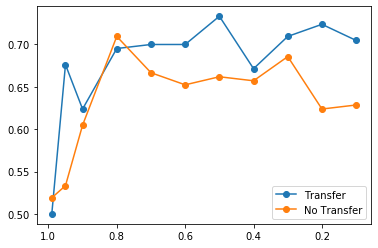

In [22]:
plt.plot(val_per_arr,conv_test_freeze,'-o',label="Transfer")
plt.plot(val_per_arr,conv_test_no_freeze,'-o', label = "No Transfer")
plt.gca().invert_xaxis()
plt.legend()
plt.show()

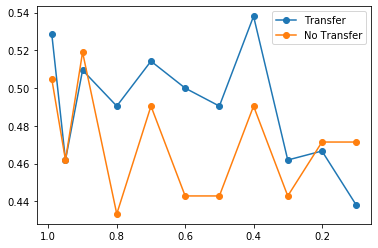

In [23]:
plt.plot(val_per_arr,ff_test_freeze,'-o',label="Transfer")
plt.plot(val_per_arr,ff_test_no_freeze,'-o', label = "No Transfer")
plt.gca().invert_xaxis()
plt.legend()
plt.show()

## Resnet training

In [10]:
#DATA FOR PRE TRAINED MODEL
resize_size = 224
#transforms for data
#The transforms for the prebuilt model will need to be different.  Images must be normalized and not greyscale.
#Normalization as per here: https://pytorch.org/vision/stable/models.html
transform = transforms.Compose([transforms.Resize((resize_size,resize_size)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
test_dat = datasets.ImageFolder(data_dir, transform=transform)

In [11]:
#freeze layers of a model if desired (might want to use this generally)
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, freezing):
    if freezing:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
#Pre trained model
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
pre_made_model = models.resnet34(pretrained=True)
set_parameter_requires_grad(pre_made_model,True)
pre_made_model.fc = nn.Linear(pre_made_model.fc.in_features, 2)

In [13]:
val_per_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
prem_train,prem_val,prem_test = kfold_val(pre_made_model,val_per_arr,test_dat,idx,num_epochs=25)

Percentage of Training Data in Validation Set : 0.1
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=512, out_features=2, bias=True)
epoch : 1/25, loss = 0.708462867885828, accuracy = 0.5723684430122375
epoch : 2/25, loss = 0.5926734078675508, accuracy = 0.6710526347160339
epoch : 3/25, loss = 0.5332945287227631, accuracy = 0.7565789222717285
epoch : 4/25, loss = 0.47805301658809185, accuracy = 0.7894737124443054
epoch : 5/25, loss = 0.43624827545136213, accuracy = 0.7960526347160339
epoch : 6/25, loss = 0.40812988951802254, accuracy = 0.7960526347160339
epoch : 7/25, loss = 0.3857657928019762, accuracy = 0.8157894611358643
epoch : 8/25, loss = 0.3651676857843995, accuracy = 0.8486841917037964
epoch : 9/25, loss = 0.34655360225588083, accuracy = 0.8552631735801697
epoch : 10/25, loss = 0.3300221571698785, accuracy = 0.875
epoch : 11/25, loss = 0.31507718516513705, accuracy = 0.8881579041481018
epoch : 12/25, loss = 0.3013755651190877, accuracy = 0.9013158082962036
epoc

epoch : 6/25, loss = 0.456870349124074, accuracy = 0.8026315569877625
epoch : 7/25, loss = 0.4351444449275732, accuracy = 0.8223684430122375
epoch : 8/25, loss = 0.41382041200995445, accuracy = 0.8684210777282715
epoch : 9/25, loss = 0.3971561500802636, accuracy = 0.875
epoch : 10/25, loss = 0.3822833504527807, accuracy = 0.875
epoch : 11/25, loss = 0.3683925410732627, accuracy = 0.8815789222717285
epoch : 12/25, loss = 0.35582080017775297, accuracy = 0.9013158082962036
epoch : 13/25, loss = 0.34431975334882736, accuracy = 0.9078947305679321
epoch : 14/25, loss = 0.3336412748321891, accuracy = 0.9078947305679321
epoch : 15/25, loss = 0.32370604667812586, accuracy = 0.9144737124443054
epoch : 16/25, loss = 0.3144236272200942, accuracy = 0.9144737124443054
epoch : 17/25, loss = 0.3057061154395342, accuracy = 0.9276315569877625
epoch : 18/25, loss = 0.2974911341443658, accuracy = 0.9276315569877625
epoch : 19/25, loss = 0.28972550574690104, accuracy = 0.9342105388641357
epoch : 20/25, los

epoch : 9/25, loss = 0.4296684903757913, accuracy = 0.8296296000480652
epoch : 10/25, loss = 0.4141083423580442, accuracy = 0.8518518805503845
epoch : 11/25, loss = 0.3999527799231665, accuracy = 0.8518518805503845
epoch : 12/25, loss = 0.3866132338132177, accuracy = 0.8518518805503845
epoch : 13/25, loss = 0.3743808280144419, accuracy = 0.8666666746139526
epoch : 14/25, loss = 0.3629499471613339, accuracy = 0.8740741014480591
epoch : 15/25, loss = 0.35225383937358856, accuracy = 0.8814814686775208
epoch : 16/25, loss = 0.3422348914401872, accuracy = 0.8962963223457336
epoch : 17/25, loss = 0.33280214986630846, accuracy = 0.8962963223457336
epoch : 18/25, loss = 0.32390740513801575, accuracy = 0.8962963223457336
epoch : 19/25, loss = 0.31549743030752453, accuracy = 0.9037036895751953
epoch : 20/25, loss = 0.30752748463835033, accuracy = 0.9111111164093018
epoch : 21/25, loss = 0.29995993950537275, accuracy = 0.9111111164093018
epoch : 22/25, loss = 0.2927602433732578, accuracy = 0.9111

epoch : 11/25, loss = 0.35363736376166344, accuracy = 0.9322034120559692
epoch : 12/25, loss = 0.3394064890841643, accuracy = 0.9322034120559692
epoch : 13/25, loss = 0.32633284603555995, accuracy = 0.9322034120559692
epoch : 14/25, loss = 0.3142945778866609, accuracy = 0.9406779408454895
epoch : 15/25, loss = 0.30310442050298053, accuracy = 0.9406779408454895
epoch : 16/25, loss = 0.29269852116703987, accuracy = 0.9406779408454895
epoch : 17/25, loss = 0.2829609376688798, accuracy = 0.9491525292396545
epoch : 18/25, loss = 0.27383212372660637, accuracy = 0.9491525292396545
epoch : 19/25, loss = 0.2652416067818801, accuracy = 0.9491525292396545
epoch : 20/25, loss = 0.2571392208337784, accuracy = 0.9576271176338196
epoch : 21/25, loss = 0.2494774820903937, accuracy = 0.9576271176338196
epoch : 22/25, loss = 0.2422171620031198, accuracy = 0.9576271176338196
epoch : 23/25, loss = 0.23532352844874063, accuracy = 0.9576271176338196
epoch : 24/25, loss = 0.2287663978834947, accuracy = 0.957

epoch : 13/25, loss = 0.3380067294294184, accuracy = 0.9009901285171509
epoch : 14/25, loss = 0.32758273726159876, accuracy = 0.9009901285171509
epoch : 15/25, loss = 0.31768590211868286, accuracy = 0.9009901285171509
epoch : 16/25, loss = 0.3084554441950538, accuracy = 0.9009901285171509
epoch : 17/25, loss = 0.2997147413817319, accuracy = 0.9108911156654358
epoch : 18/25, loss = 0.29146983135830273, accuracy = 0.9207921028137207
epoch : 19/25, loss = 0.28364594145254657, accuracy = 0.9207921028137207
epoch : 20/25, loss = 0.27621878954497253, accuracy = 0.9207921028137207
epoch : 21/25, loss = 0.2691481668840755, accuracy = 0.9207921028137207
epoch : 22/25, loss = 0.2624074735424735, accuracy = 0.9207921028137207
epoch : 23/25, loss = 0.2559699212962931, accuracy = 0.9207921028137207
epoch : 24/25, loss = 0.24981283193284815, accuracy = 0.9207921028137207
epoch : 25/25, loss = 0.24391602657058023, accuracy = 0.9207921028137207
Validation Accuracy = 0.6865671873092651
Test Accuracy = 

epoch : 15/25, loss = 0.24524134231938255, accuracy = 0.9523809552192688
epoch : 16/25, loss = 0.23454763657516903, accuracy = 0.9523809552192688
epoch : 17/25, loss = 0.22471426758501264, accuracy = 0.9523809552192688
epoch : 18/25, loss = 0.21544192400243548, accuracy = 0.9523809552192688
epoch : 19/25, loss = 0.2068477835920122, accuracy = 0.9642857313156128
epoch : 20/25, loss = 0.19877006279097664, accuracy = 0.976190447807312
epoch : 21/25, loss = 0.19118378228611416, accuracy = 0.976190447807312
epoch : 22/25, loss = 0.18405818773640525, accuracy = 0.976190447807312
epoch : 23/25, loss = 0.17733275724781883, accuracy = 0.976190447807312
epoch : 24/25, loss = 0.17098911934428745, accuracy = 0.976190447807312
epoch : 25/25, loss = 0.1649919417169359, accuracy = 0.976190447807312
Validation Accuracy = 0.6666666865348816
Test Accuracy = 0.6904761791229248
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=512, out_features=2, bias=True)
epoch : 1/25, loss = 0.74200730

epoch : 22/25, loss = 0.17822241369220945, accuracy = 1.0
epoch : 23/25, loss = 0.1709250526295768, accuracy = 1.0
epoch : 24/25, loss = 0.16407194402482775, accuracy = 1.0
epoch : 25/25, loss = 0.15762630684508216, accuracy = 1.0
Validation Accuracy = 0.6190476417541504
Test Accuracy = 0.5714285969734192
Average Training Accuracy: 0.9928571581840515
Average Validation Accuracy: 0.6785714626312256
Average Testing Accuracy: 0.6428571343421936
Percentage of Training Data in Validation Set : 0.6
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=512, out_features=2, bias=True)
epoch : 1/25, loss = 0.8269465395382473, accuracy = 0.4117647111415863
epoch : 2/25, loss = 0.7207139219556536, accuracy = 0.5
epoch : 3/25, loss = 0.6869742274284363, accuracy = 0.5588235259056091
epoch : 4/25, loss = 0.6511026748589107, accuracy = 0.6029411554336548
epoch : 5/25, loss = 0.6213656408446175, accuracy = 0.6176470518112183
epoch : 6/25, loss = 0.5987317945275988, accuracy = 0.6764705777

Validation Accuracy = 0.6100000143051147
Test Accuracy = 0.5952380895614624
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=512, out_features=2, bias=True)
epoch : 1/25, loss = 0.7476235032081604, accuracy = 0.4852941036224365
epoch : 2/25, loss = 0.6115549547331673, accuracy = 0.6764705777168274
epoch : 3/25, loss = 0.534340786082404, accuracy = 0.720588207244873
epoch : 4/25, loss = 0.47664316637175425, accuracy = 0.8088235259056091
epoch : 5/25, loss = 0.43321686557361055, accuracy = 0.8382353186607361
epoch : 6/25, loss = 0.3965851068496704, accuracy = 0.8676470518112183
epoch : 7/25, loss = 0.3666429008756365, accuracy = 0.8823529481887817
epoch : 8/25, loss = 0.34096488782337736, accuracy = 0.8970588445663452
epoch : 9/25, loss = 0.318676512156214, accuracy = 0.9411764740943909
epoch : 10/25, loss = 0.2993870739425932, accuracy = 0.9411764740943909
epoch : 11/25, loss = 0.28212548579488483, accuracy = 0.9411764740943909
epoch : 12/25, loss = 0.26678634328501566,

epoch : 1/25, loss = 0.9381054043769836, accuracy = 0.3921568691730499
epoch : 2/25, loss = 0.7703604598840078, accuracy = 0.4117647111415863
epoch : 3/25, loss = 0.7081042329470316, accuracy = 0.5686274766921997
epoch : 4/25, loss = 0.6656635403633118, accuracy = 0.6078431606292725
epoch : 5/25, loss = 0.6207685073216757, accuracy = 0.686274528503418
epoch : 6/25, loss = 0.5866937388976415, accuracy = 0.7254902124404907
epoch : 7/25, loss = 0.5617454300324122, accuracy = 0.7254902124404907
epoch : 8/25, loss = 0.53940216700236, accuracy = 0.7254902124404907
epoch : 9/25, loss = 0.5178249378999075, accuracy = 0.7647058963775635
epoch : 10/25, loss = 0.4992881367603938, accuracy = 0.7843137383460999
epoch : 11/25, loss = 0.48355818291505176, accuracy = 0.8235294222831726
epoch : 12/25, loss = 0.46890418728192645, accuracy = 0.8235294222831726
epoch : 13/25, loss = 0.4549673895041148, accuracy = 0.8235294222831726
epoch : 14/25, loss = 0.44229743878046673, accuracy = 0.8235294222831726
e

epoch : 8/25, loss = 0.43522031605243683, accuracy = 0.8235294222831726
epoch : 9/25, loss = 0.4060313478112221, accuracy = 0.8823529481887817
epoch : 10/25, loss = 0.3744483217597008, accuracy = 0.9117646813392639
epoch : 11/25, loss = 0.3458060473203659, accuracy = 0.9117646813392639
epoch : 12/25, loss = 0.3271210044622421, accuracy = 0.9117646813392639
epoch : 13/25, loss = 0.31428760290145874, accuracy = 0.9411764740943909
epoch : 14/25, loss = 0.30056288838386536, accuracy = 0.9411764740943909
epoch : 15/25, loss = 0.2853928804397583, accuracy = 0.9411764740943909
epoch : 16/25, loss = 0.27067216858267784, accuracy = 0.970588207244873
epoch : 17/25, loss = 0.2583838365972042, accuracy = 0.970588207244873
epoch : 18/25, loss = 0.24870097264647484, accuracy = 0.970588207244873
epoch : 19/25, loss = 0.24004782736301422, accuracy = 0.970588207244873
epoch : 20/25, loss = 0.23130809515714645, accuracy = 0.970588207244873
epoch : 21/25, loss = 0.22252334281802177, accuracy = 0.97058820

epoch : 18/25, loss = 0.07035381905734539, accuracy = 1.0
epoch : 19/25, loss = 0.06469113752245903, accuracy = 1.0
epoch : 20/25, loss = 0.05964456684887409, accuracy = 1.0
epoch : 21/25, loss = 0.055203357711434364, accuracy = 1.0
epoch : 22/25, loss = 0.05134730041027069, accuracy = 1.0
epoch : 23/25, loss = 0.047991590574383736, accuracy = 1.0
epoch : 24/25, loss = 0.04502549208700657, accuracy = 1.0
epoch : 25/25, loss = 0.04236483760178089, accuracy = 1.0
Validation Accuracy = 0.5364238619804382
Test Accuracy = 0.5952380895614624
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=512, out_features=2, bias=True)
epoch : 1/25, loss = 0.8984178006649017, accuracy = 0.4117647111415863
epoch : 2/25, loss = 0.7053723931312561, accuracy = 0.5882353186607361
epoch : 3/25, loss = 0.63834547996521, accuracy = 0.6470588445663452
epoch : 4/25, loss = 0.5345335304737091, accuracy = 0.7647058963775635
epoch : 5/25, loss = 0.44365188479423523, accuracy = 0.8823529481887817
epoch 

epoch : 8/25, loss = 0.2910701632499695, accuracy = 1.0
epoch : 9/25, loss = 0.25684022903442383, accuracy = 1.0
epoch : 10/25, loss = 0.2270847111940384, accuracy = 1.0
epoch : 11/25, loss = 0.20104120671749115, accuracy = 1.0
epoch : 12/25, loss = 0.1781342625617981, accuracy = 1.0
epoch : 13/25, loss = 0.1580265462398529, accuracy = 1.0
epoch : 14/25, loss = 0.14047008752822876, accuracy = 1.0
epoch : 15/25, loss = 0.12519171833992004, accuracy = 1.0
epoch : 16/25, loss = 0.11188983917236328, accuracy = 1.0
epoch : 17/25, loss = 0.10028302669525146, accuracy = 1.0
epoch : 18/25, loss = 0.0901416540145874, accuracy = 1.0
epoch : 19/25, loss = 0.08128421008586884, accuracy = 1.0
epoch : 20/25, loss = 0.07355741411447525, accuracy = 1.0
epoch : 21/25, loss = 0.06682027131319046, accuracy = 1.0
epoch : 22/25, loss = 0.06093953549861908, accuracy = 1.0
epoch : 23/25, loss = 0.05579296126961708, accuracy = 1.0
epoch : 24/25, loss = 0.051273953169584274, accuracy = 1.0
epoch : 25/25, loss 

epoch : 2/25, loss = 0.5783881545066833, accuracy = 1.0
epoch : 3/25, loss = 0.4256957173347473, accuracy = 1.0
epoch : 4/25, loss = 0.30923447012901306, accuracy = 1.0
epoch : 5/25, loss = 0.2234027236700058, accuracy = 1.0
epoch : 6/25, loss = 0.161746084690094, accuracy = 1.0
epoch : 7/25, loss = 0.11810609698295593, accuracy = 1.0
epoch : 8/25, loss = 0.08735384047031403, accuracy = 1.0
epoch : 9/25, loss = 0.06561091542243958, accuracy = 1.0
epoch : 10/25, loss = 0.05011005699634552, accuracy = 1.0
epoch : 11/25, loss = 0.03893452137708664, accuracy = 1.0
epoch : 12/25, loss = 0.030772283673286438, accuracy = 1.0
epoch : 13/25, loss = 0.024727821350097656, accuracy = 1.0
epoch : 14/25, loss = 0.02018796280026436, accuracy = 1.0
epoch : 15/25, loss = 0.016730155795812607, accuracy = 1.0
epoch : 16/25, loss = 0.014060565270483494, accuracy = 1.0
epoch : 17/25, loss = 0.011972539126873016, accuracy = 1.0
epoch : 18/25, loss = 0.010319322347640991, accuracy = 1.0
epoch : 19/25, loss =

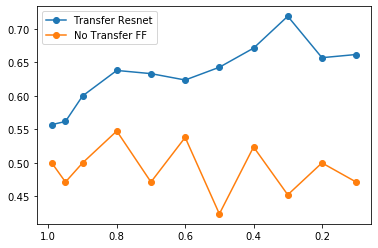

In [14]:
plt.plot(val_per_arr,prem_test,'-o',label="Transfer Resnet")
plt.plot(val_per_arr,ff_test_no_freeze,'-o', label = "No Transfer FF")
plt.gca().invert_xaxis()
plt.legend()
plt.show()